<a href="https://colab.research.google.com/github/BarbaraMcG/darwin-semantic-change/blob/main/Semantic_change_Darwin_BMcG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic change in Darwin letters



Barbara McGillivray

This notebook contains the code for pre-processing the corpus of Darwin letters and train the embeddings. As some of the steps can take a long time to run, it is advisable to only run the first part of this notebook at the beginning of the project.

## Note on data

We will use the letters from the Darwin Correspondence Project (https://www.darwinproject.ac.uk/) which can be freely downloaded from https://github.com/cambridge-collection/darwin-correspondence-data ("xml" folder).

# Corpus processing of Darwin letters

## 1. Initialisation

In [207]:
import sys
sys.executable

'/opt/anaconda3/envs/darwin-env/bin/python'

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [208]:
%pip install gensim==4.3

Note: you may need to restart the kernel to use updated packages.


I install other modules:

In [209]:
%pip install langdetect
%pip install python-Levenshtein
%pip install spacy==3.5.4 pydantic==1.10.13

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Download Spacy's English language model:

In [210]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.2 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [211]:
%pip install pandas nltk gensim

Note: you may need to restart the kernel to use updated packages.


Import libraries

In [212]:
import os 
from bs4 import BeautifulSoup
#from google.colab import drive
import csv
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import re
import spacy
from statistics import mean
from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/barbaramcgillivray/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/barbaramcgillivray/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Reading the files

I define the name of the folder containing the unzipped files:

In [213]:
folder = "/Users/barbaramcgillivray/OneDrive - King's College London/Research/2024/Darwin/data/darwin-correspondence-data-main/xml/letters/"

I define the list of all files:

In [214]:
files = os.listdir(folder)
len(files)

15239

We only want xml files:

In [215]:
files = [f for f in files[:] if f.endswith(".xml")]

In [216]:
len(files)

15239

### Extracting the text of the letters

I create the output folder:

In [217]:
out_folder = "/Users/barbaramcgillivray/OneDrive - King's College London/Research/2024/Darwin/data/preprocessed_text/" 

Testing on one letter:

In [218]:

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  #print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 200:
  #      break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    sender = ""
    receiver = ""
    date_sent = "" # the date in which the letter was sent
    year = ""
    letter_text = "" # transcription of the letter  

    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract sender, receiver and date_sent:

    corr_action = soup.find_all("correspAction")
    if corr_action and "9627F" in fname:
      print("Reading file number", str(count), fname)  
      # loop over all notes under "correspAction":
      for s in corr_action:
          
        #extract receiver's name:
        if s.get('type') == "received":
          try:
            receiver = s.persName.get_text()
            #print("receiver:", receiver)
          except:
            print("No receiver")

        # extract senders' name:
        if s.get('type') == "sent":
          try:
            sender = s.persName.get_text()  
            #print("sender:", sender)
          except:
            print("No sender")
            
          # extract date sent:                  
          try:
            date_sent = s.date["when"]
            # the year is the first four characters of the date:
            year = date_sent[:4]
          except:
            print("No exact date")
            #For ranges where we knew a letter was before a certain date or after a certain date but not more than that, we tended to use as one end of the range the date we knew related to the letter (in this case 1868), and at the other end we put either Darwin’s birth or death. 
            # So we ignore a notBefore=”1809-01-01” and a notAfter=”1882-12-31”
            try:
              date_sent_not_before = s.date["notBefore"]
              # the year is the first four characters of the date:
              year_not_before = date_sent_not_before[:4]
              #print("year_not_before:", year_not_before)
            except:
              print("\tNo notBefore date")
            try:
              date_sent_not_after = s.date["notAfter"]
              year_not_after = date_sent_not_after[:4]
              #print("year_not_after:", year_not_after)
            except:
              print("\tNo notAfter date")
            if date_sent_not_before and date_sent_not_after:
                if date_sent_not_before == "1809-01-01" and date_sent_not_after == "1882-12-31":
                    # a file that has the notBefore as D’s birth and the notAfter as D’s death: in this case we might want to exclude the letter completely – if we left the date range as his whole lifetime we really didn’t know when it was written, which makes it a bit useless in any case for tracing semantic change over time.
                    year = ""
                elif date_sent_not_before == "1809-01-01":
                    year = year_not_after
                elif date_sent_not_after == "1882-12-31":
                    year = year_not_before
                else:
                    year = round(float((int(year_not_before)+int(year_not_after))/2))
              
                #print("3", year)
            elif date_sent_not_before:
              year = year_not_before
              #print("2", year)
            elif date_sent_not_after:
              year = year_not_after
              #print("1", year)

                    
     
      # extract the transcription of the letters:
      text = soup.find_all("div")
      # I loop over all children of nodes in "div":
      for s in text:
        # I save the text of the transcription in the variable "letter_text"
        if s.get('type') == "transcription":
          letter_text = s.get_text()  
          # Remove newlines and tabs:
          letter_text = letter_text.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("  ", " ")
          # Remove leading and trailing spaces:
          letter_text = letter_text.strip()
          # test print statement:
          #print("letter_text:", letter_text)
          
      if letter_text == "":
        # If the transcription is empty, I save the variable "letter_text" with the value "TRANSCRIPTION MISSING"
        letter_text = "TRANSCRIPTION MISSING"
        # test print statement:
        #print("Tag_text:", letter_text)

      # I only select those letters for which we have a year and that were sent by or received by Charles Darwin:
        
      if year != "" and (sender == "Darwin, C. R." or receiver == "Darwin, C. R.") and letter_text != "TRANSCRIPTION MISSING":
        # write to output file
        print([fname, year, sender, receiver, letter_text])
      else:
        print("not sent or received by C. Darwin")                 
        print("sender:", sender)
        print("receiver:", receiver)
        print("letter_text:", letter_text) 
    
    #else:
    #    print("missing corr_action for ", fname) 

Reading file number 2714 DCP-LETT-9627F.xml
['DCP-LETT-9627F.xml', '1874', 'Darwin, C. R.', 'Marshall, W. C.', 'I am very grateful to you. Your observations are excellent, & are put most clearly & will be very useful to me. I have picked off 16 seeds from this lot! The plant is certainly to a certain extent graninivorous also somewhat graminivorous, though mainly insectivorous. The rain, I know washes off the secretion & with it captured insects (& as you say seeds), which are retained by the incurved edges, which then become more incurved. It is a pretty experiment to put a row of flies or cabbage seeds on one margin of a flat leaf & see how the edge of the side curls over in from 12 to 24 hours. With cordial thanks | Yours very sincerely | Ch. Darwin—']


We extract the trascribed text from each letter and save it in an output file.  **You can skip this cell** and go straight to section 4.

In [219]:
outfile = open(os.path.join(out_folder, 'transcription.csv'), 'w+')
output_writer = csv.writer(outfile, delimiter = "\t")

# Write header row:
output_writer.writerow(["File", "Year", "Sender", "Receiver", "Transcription"]) 

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 200:
  #      break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    sender = ""
    receiver = ""
    date_sent = "" # the date in which the letter was sent
    year = ""
    letter_text = "" # transcription of the letter  

    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract sender, receiver and date_sent:

    corr_action = soup.find_all("correspAction")
    if corr_action: # and "13835" in fname:
      print("Reading file number", str(count), fname)  
      # loop over all notes under "correspAction":
      for s in corr_action:
          
        #extract receiver's name:
        if s.get('type') == "received":
          try:
            receiver = s.persName.get_text()
            #print("receiver:", receiver)
          except:
            print("No receiver")

        # extract senders' name:
        if s.get('type') == "sent":
          try:
            sender = s.persName.get_text()  
            #print("sender:", sender)
          except:
            print("No sender")
            
          # extract date sent:                  
          try:
            date_sent = s.date["when"]
            # the year is the first four characters of the date:
            year = date_sent[:4]
            #print("0:", year)
          except:
            print("No exact date")
            #For ranges where we knew a letter was before a certain date or after a certain date but not more than that, we tended to use as one end of the range the date we knew related to the letter (in this case 1868), and at the other end we put either Darwin’s birth or death. 
            # So we ignore a notBefore=”1809-01-01” and a notAfter=”1882-12-31”
            try:
              date_sent_not_before = s.date["notBefore"]
              # the year is the first four characters of the date:
              year_not_before = date_sent_not_before[:4]
              print("year_not_before:", year_not_before)
            except:
              print("\tNo notBefore date")
            try:
              date_sent_not_after = s.date["notAfter"]
              year_not_after = date_sent_not_after[:4]
              print("year_not_after:", year_not_after)
            except:
              print("\tNo notAfter date")
            if date_sent_not_before and date_sent_not_after:
                if date_sent_not_before == "1809-01-01" and date_sent_not_after == "1882-12-31":
                    # a file that has the notBefore as D’s birth and the notAfter as D’s death: in this case we might want to exclude the letter completely – if we left the date range as his whole lifetime we really didn’t know when it was written, which makes it a bit useless in any case for tracing semantic change over time.
                    year = ""
                elif date_sent_not_before == "1809-01-01":
                    year = year_not_after
                elif date_sent_not_after == "1882-12-31":
                    year = year_not_before
                else:
                    year = round(float((int(year_not_before)+int(year_not_after))/2))
              
                print("3", year)
            elif date_sent_not_before:
              year = year_not_before
              #print("2", year)
            elif date_sent_not_after:
              year = year_not_after
              #print("1", year)

    
      # extract the transcription of the letters:
      text = soup.find_all("div")
      # I loop over all children of nodes in "div":
      for s in text:
        # I save the text of the transcription in the variable "letter_text"
        if s.get('type') == "transcription":
          letter_text = s.get_text()  
          # Remove newlines and tabs:
          letter_text = letter_text.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("  ", " ")
          # Remove leading and trailing spaces:
          letter_text = letter_text.strip()
          # test print statement:
          #print("letter_text:", letter_text)
          
      if letter_text == "":
        # If the transcription is empty, I save the variable "letter_text" with the value "TRANSCRIPTION MISSING"
        letter_text = "TRANSCRIPTION MISSING"
        # test print statement:
        #print("Tag_text:", letter_text)

      # I only select those letters for which we have a year and that were sent by or received by Charles Darwin:
      if year != "" and (sender == "Darwin, C. R." or receiver == "Darwin, C. R.") and letter_text != "TRANSCRIPTION MISSING":
        # write to output file
        output_writer.writerow([fname, year, sender, receiver, letter_text])
        #print(year)
      else:
        print("missing corr_action")                 
     
outfile.close()

Reading file number 1 DCP-LETT-12349.xml
Reading file number 1 DCP-LETT-12349.xml
Reading file number 2 DCP-LETT-13057.xml
Reading file number 2 DCP-LETT-13057.xml
Reading file number 3 DCP-LETT-11898.xml
Reading file number 3 DCP-LETT-11898.xml
Reading file number 4 DCP-LETT-7806.xml
Reading file number 4 DCP-LETT-7806.xml
Reading file number 5 DCP-LETT-11640.xml
Reading file number 5 DCP-LETT-11640.xml
Reading file number 6 DCP-LETT-686.xml
Reading file number 6 DCP-LETT-686.xml
Reading file number 7 DCP-LETT-11126.xml
Reading file number 7 DCP-LETT-11126.xml
Reading file number 8 DCP-LETT-10238.xml
Reading file number 8 DCP-LETT-10238.xml
Reading file number 9 DCP-LETT-9195.xml
Reading file number 9 DCP-LETT-9195.xml
No exact date
year_not_before: 1874
year_not_after: 1874
3 1874
Reading file number 10 DCP-LETT-8650F.xml
Reading file number 10 DCP-LETT-8650F.xml
Reading file number 11 DCP-LETT-13731.xml
Reading file number 11 DCP-LETT-13731.xml
Reading file number 12 DCP-LETT-9942F.

Reading file number 98 DCP-LETT-1250.xml
Reading file number 99 DCP-LETT-1536.xml
Reading file number 99 DCP-LETT-1536.xml
Reading file number 100 DCP-LETT-5080A.xml
Reading file number 100 DCP-LETT-5080A.xml
Reading file number 101 DCP-LETT-6259.xml
Reading file number 101 DCP-LETT-6259.xml
Reading file number 102 DCP-LETT-8274.xml
Reading file number 102 DCP-LETT-8274.xml
Reading file number 103 DCP-LETT-7147.xml
Reading file number 103 DCP-LETT-7147.xml
Reading file number 104 DCP-LETT-679.xml
Reading file number 104 DCP-LETT-679.xml
No exact date
year_not_before: 1843
year_not_after: 1843
3 1843
Reading file number 105 DCP-LETT-5988.xml
Reading file number 105 DCP-LETT-5988.xml
Reading file number 106 DCP-LETT-3321.xml
Reading file number 106 DCP-LETT-3321.xml
Reading file number 107 DCP-LETT-13138F.xml
Reading file number 107 DCP-LETT-13138F.xml
Reading file number 108 DCP-LETT-5750.xml
Reading file number 108 DCP-LETT-5750.xml
No exact date
year_not_before: 1868
year_not_after: 1

Reading file number 236 DCP-LETT-2229.xml
Reading file number 237 DCP-LETT-4880.xml
Reading file number 237 DCP-LETT-4880.xml
missing corr_action
Reading file number 238 DCP-LETT-10871A.xml
Reading file number 238 DCP-LETT-10871A.xml
Reading file number 239 DCP-LETT-5546.xml
Reading file number 239 DCP-LETT-5546.xml
Reading file number 240 DCP-LETT-7321F.xml
Reading file number 240 DCP-LETT-7321F.xml
Reading file number 241 DCP-LETT-4658.xml
Reading file number 241 DCP-LETT-4658.xml
Reading file number 242 DCP-LETT-3137.xml
Reading file number 242 DCP-LETT-3137.xml
Reading file number 243 DCP-LETT-12981.xml
Reading file number 243 DCP-LETT-12981.xml
Reading file number 244 DCP-LETT-13447.xml
Reading file number 244 DCP-LETT-13447.xml
No exact date
year_not_before: 1881
year_not_after: 1881
3 1881
Reading file number 245 DCP-LETT-12759.xml
Reading file number 245 DCP-LETT-12759.xml
Reading file number 246 DCP-LETT-1867.xml
Reading file number 246 DCP-LETT-1867.xml
Reading file number 24

Reading file number 336 DCP-LETT-2349.xml
Reading file number 337 DCP-LETT-13748A.xml
Reading file number 337 DCP-LETT-13748A.xml
Reading file number 338 DCP-LETT-1640.xml
Reading file number 338 DCP-LETT-1640.xml
Reading file number 339 DCP-LETT-7231.xml
Reading file number 339 DCP-LETT-7231.xml
Reading file number 340 DCP-LETT-8102.xml
Reading file number 340 DCP-LETT-8102.xml
Reading file number 341 DCP-LETT-1898.xml
Reading file number 341 DCP-LETT-1898.xml
Reading file number 342 DCP-LETT-6891.xml
Reading file number 342 DCP-LETT-6891.xml
Reading file number 343 DCP-LETT-269.xml
Reading file number 343 DCP-LETT-269.xml
Reading file number 344 DCP-LETT-7557.xml
Reading file number 344 DCP-LETT-7557.xml
Reading file number 345 DCP-LETT-8664.xml
Reading file number 345 DCP-LETT-8664.xml
Reading file number 346 DCP-LETT-6649.xml
Reading file number 346 DCP-LETT-6649.xml
Reading file number 347 DCP-LETT-2704A.xml
Reading file number 347 DCP-LETT-2704A.xml
Reading file number 348 DCP-LE

Reading file number 471 DCP-LETT-719.xml
Reading file number 472 DCP-LETT-8314.xml
Reading file number 472 DCP-LETT-8314.xml
Reading file number 473 DCP-LETT-7027.xml
Reading file number 473 DCP-LETT-7027.xml
Reading file number 474 DCP-LETT-6339.xml
Reading file number 474 DCP-LETT-6339.xml
No exact date
year_not_before: 1868
year_not_after: 1868
3 1868
Reading file number 475 DCP-LETT-1456.xml
Reading file number 475 DCP-LETT-1456.xml
Reading file number 476 DCP-LETT-1330.xml
Reading file number 476 DCP-LETT-1330.xml
Reading file number 477 DCP-LETT-7999.xml
Reading file number 477 DCP-LETT-7999.xml
Reading file number 478 DCP-LETT-11907.xml
Reading file number 478 DCP-LETT-11907.xml
Reading file number 479 DCP-LETT-8472.xml
Reading file number 479 DCP-LETT-8472.xml
Reading file number 480 DCP-LETT-7741.xml
Reading file number 480 DCP-LETT-7741.xml
Reading file number 481 DCP-LETT-3527.xml
Reading file number 481 DCP-LETT-3527.xml
Reading file number 482 DCP-LETT-4248.xml
Reading fil

Reading file number 601 DCP-LETT-13122.xml
Reading file number 602 DCP-LETT-13644.xml
Reading file number 602 DCP-LETT-13644.xml
Reading file number 603 DCP-LETT-5802.xml
Reading file number 603 DCP-LETT-5802.xml
Reading file number 604 DCP-LETT-11053.xml
Reading file number 604 DCP-LETT-11053.xml
Reading file number 605 DCP-LETT-12251F.xml
Reading file number 605 DCP-LETT-12251F.xml
Reading file number 606 DCP-LETT-1133.xml
Reading file number 606 DCP-LETT-1133.xml
Reading file number 607 DCP-LETT-8671.xml
Reading file number 607 DCP-LETT-8671.xml
Reading file number 608 DCP-LETT-7542.xml
Reading file number 608 DCP-LETT-7542.xml
No exact date
year_not_before: 1871
year_not_after: 1871
3 1871
Reading file number 609 DCP-LETT-6884.xml
Reading file number 609 DCP-LETT-6884.xml
Reading file number 610 DCP-LETT-3724.xml
Reading file number 610 DCP-LETT-3724.xml
Reading file number 611 DCP-LETT-5355.xml
Reading file number 611 DCP-LETT-5355.xml
Reading file number 612 DCP-LETT-5433.xml
Rea

Reading file number 703 DCP-LETT-8856.xml
Reading file number 704 DCP-LETT-9590.xml
Reading file number 704 DCP-LETT-9590.xml
Reading file number 705 DCP-LETT-3903.xml
Reading file number 705 DCP-LETT-3903.xml
Reading file number 706 DCP-LETT-13334.xml
Reading file number 706 DCP-LETT-13334.xml
Reading file number 707 DCP-LETT-13452.xml
Reading file number 707 DCP-LETT-13452.xml
Reading file number 708 DCP-LETT-12994.xml
Reading file number 708 DCP-LETT-12994.xml
Reading file number 709 DCP-LETT-11245.xml
Reading file number 709 DCP-LETT-11245.xml
Reading file number 710 DCP-LETT-1872.xml
Reading file number 710 DCP-LETT-1872.xml
Reading file number 711 DCP-LETT-11251.xml
Reading file number 711 DCP-LETT-11251.xml
Reading file number 712 DCP-LETT-8406F.xml
Reading file number 712 DCP-LETT-8406F.xml
Reading file number 713 DCP-LETT-1866.xml
Reading file number 713 DCP-LETT-1866.xml
Reading file number 714 DCP-LETT-12758.xml
Reading file number 714 DCP-LETT-12758.xml
Reading file number 

No exact date
year_not_before: 1870
year_not_after: 1882
3 1870
Reading file number 798 DCP-LETT-10013.xml
Reading file number 798 DCP-LETT-10013.xml
Reading file number 799 DCP-LETT-5584.xml
Reading file number 799 DCP-LETT-5584.xml
Reading file number 800 DCP-LETT-4842.xml
Reading file number 800 DCP-LETT-4842.xml
Reading file number 801 DCP-LETT-12604.xml
Reading file number 801 DCP-LETT-12604.xml
Reading file number 802 DCP-LETT-12134A.xml
Reading file number 802 DCP-LETT-12134A.xml
Reading file number 803 DCP-LETT-5590.xml
Reading file number 803 DCP-LETT-5590.xml
Reading file number 804 DCP-LETT-4856.xml
Reading file number 804 DCP-LETT-4856.xml
Reading file number 805 DCP-LETT-2508F.xml
Reading file number 805 DCP-LETT-2508F.xml
Reading file number 806 DCP-LETT-12610.xml
Reading file number 806 DCP-LETT-12610.xml
Reading file number 807 DCP-LETT-7387.xml
Reading file number 807 DCP-LETT-7387.xml
Reading file number 808 DCP-LETT-11319.xml
Reading file number 808 DCP-LETT-11319.xm

Reading file number 891 DCP-LETT-11696.xml
Reading file number 892 DCP-LETT-136.xml
Reading file number 892 DCP-LETT-136.xml
Reading file number 893 DCP-LETT-4301.xml
Reading file number 893 DCP-LETT-4301.xml
Reading file number 894 DCP-LETT-7245A.xml
Reading file number 894 DCP-LETT-7245A.xml
Reading file number 895 DCP-LETT-13081.xml
Reading file number 895 DCP-LETT-13081.xml
Reading file number 896 DCP-LETT-9939F.xml
Reading file number 896 DCP-LETT-9939F.xml
Reading file number 897 DCP-LETT-2770.xml
Reading file number 897 DCP-LETT-2770.xml
Reading file number 898 DCP-LETT-4315.xml
Reading file number 898 DCP-LETT-4315.xml
Reading file number 899 DCP-LETT-2764.xml
Reading file number 899 DCP-LETT-2764.xml
Reading file number 900 DCP-LETT-13095.xml
Reading file number 900 DCP-LETT-13095.xml
Reading file number 901 DCP-LETT-9631.xml
Reading file number 901 DCP-LETT-9631.xml
Reading file number 902 DCP-LETT-6502.xml
Reading file number 902 DCP-LETT-6502.xml
Reading file number 903 DCP

Reading file number 1016 DCP-LETT-2772.xml
Reading file number 1017 DCP-LETT-13083.xml
Reading file number 1017 DCP-LETT-13083.xml
Reading file number 1018 DCP-LETT-4303.xml
Reading file number 1018 DCP-LETT-4303.xml
Reading file number 1019 DCP-LETT-134.xml
Reading file number 1019 DCP-LETT-134.xml
No exact date
year_not_before: 1831
year_not_after: 1831
3 1831
Reading file number 1020 DCP-LETT-11694.xml
Reading file number 1020 DCP-LETT-11694.xml
Reading file number 1021 DCP-LETT-8539.xml
Reading file number 1021 DCP-LETT-8539.xml
Reading file number 1022 DCP-LETT-9627.xml
Reading file number 1022 DCP-LETT-9627.xml
Reading file number 1023 DCP-LETT-6514.xml
Reading file number 1023 DCP-LETT-6514.xml
Reading file number 1024 DCP-LETT-9141.xml
Reading file number 1024 DCP-LETT-9141.xml
Reading file number 1025 DCP-LETT-6272.xml
Reading file number 1025 DCP-LETT-6272.xml
Reading file number 1026 DCP-LETT-715F.xml
Reading file number 1026 DCP-LETT-715F.xml
Reading file number 1027 DCP-LE

Reading file number 1116 DCP-LETT-5586.xml
Reading file number 1117 DCP-LETT-10011.xml
Reading file number 1117 DCP-LETT-10011.xml
Reading file number 1118 DCP-LETT-1938.xml
Reading file number 1118 DCP-LETT-1938.xml
Reading file number 1119 DCP-LETT-7391.xml
Reading file number 1119 DCP-LETT-7391.xml
Reading file number 1120 DCP-LETT-11469.xml
Reading file number 1120 DCP-LETT-11469.xml
Reading file number 1121 DCP-LETT-8313A.xml
Reading file number 1121 DCP-LETT-8313A.xml
Reading file number 1122 DCP-LETT-6931.xml
Reading file number 1122 DCP-LETT-6931.xml
Reading file number 1123 DCP-LETT-1086.xml
Reading file number 1123 DCP-LETT-1086.xml
Reading file number 1124 DCP-LETT-10777.xml
Reading file number 1124 DCP-LETT-10777.xml
Reading file number 1125 DCP-LETT-3849.xml
Reading file number 1125 DCP-LETT-3849.xml
Reading file number 1126 DCP-LETT-3691.xml
Reading file number 1126 DCP-LETT-3691.xml
Reading file number 1127 DCP-LETT-12160.xml
Reading file number 1127 DCP-LETT-12160.xml
N

Reading file number 1249 DCP-LETT-3929.xml
Reading file number 1250 DCP-LETT-6689.xml
Reading file number 1250 DCP-LETT-6689.xml
Reading file number 1251 DCP-LETT-10617.xml
Reading file number 1251 DCP-LETT-10617.xml
Reading file number 1252 DCP-LETT-11509.xml
Reading file number 1252 DCP-LETT-11509.xml
Reading file number 1253 DCP-LETT-6851.xml
Reading file number 1253 DCP-LETT-6851.xml
Reading file number 1254 DCP-LETT-2093F.xml
Reading file number 1254 DCP-LETT-2093F.xml
Reading file number 1255 DCP-LETT-4844F.xml
Reading file number 1255 DCP-LETT-4844F.xml
missing corr_action
Reading file number 1256 DCP-LETT-7597.xml
Reading file number 1256 DCP-LETT-7597.xml
Reading file number 1257 DCP-LETT-1858.xml
Reading file number 1257 DCP-LETT-1858.xml
Reading file number 1258 DCP-LETT-13525F.xml
Reading file number 1258 DCP-LETT-13525F.xml
Reading file number 1259 DCP-LETT-10171.xml
Reading file number 1259 DCP-LETT-10171.xml
Reading file number 1260 DCP-LETT-1680.xml
Reading file number 

Reading file number 1385 DCP-LETT-10373.xml
Reading file number 1386 DCP-LETT-7795.xml
Reading file number 1386 DCP-LETT-7795.xml
Reading file number 1387 DCP-LETT-9960.xml
Reading file number 1387 DCP-LETT-9960.xml
Reading file number 1388 DCP-LETT-10415.xml
Reading file number 1388 DCP-LETT-10415.xml
Reading file number 1389 DCP-LETT-5182.xml
Reading file number 1389 DCP-LETT-5182.xml
Reading file number 1390 DCP-LETT-12202.xml
Reading file number 1390 DCP-LETT-12202.xml
Reading file number 1391 DCP-LETT-2835.xml
Reading file number 1391 DCP-LETT-2835.xml
Reading file number 1392 DCP-LETT-3518.xml
Reading file number 1392 DCP-LETT-3518.xml
Reading file number 1393 DCP-LETT-4277.xml
Reading file number 1393 DCP-LETT-4277.xml
No exact date
year_not_before: 1863
year_not_after: 1863
3 1863
Reading file number 1394 DCP-LETT-5169.xml
Reading file number 1394 DCP-LETT-5169.xml
Reading file number 1395 DCP-LETT-2606.xml
Reading file number 1395 DCP-LETT-2606.xml
Reading file number 1396 DCP

Reading file number 1484 DCP-LETT-1332.xml
Reading file number 1485 DCP-LETT-1454.xml
Reading file number 1485 DCP-LETT-1454.xml
Reading file number 1486 DCP-LETT-9008.xml
Reading file number 1486 DCP-LETT-9008.xml
Reading file number 1487 DCP-LETT-10514A.xml
Reading file number 1487 DCP-LETT-10514A.xml
Reading file number 1488 DCP-LETT-8316.xml
Reading file number 1488 DCP-LETT-8316.xml
Reading file number 1489 DCP-LETT-7025.xml
Reading file number 1489 DCP-LETT-7025.xml
Reading file number 1490 DCP-LETT-3243.xml
Reading file number 1490 DCP-LETT-3243.xml
Reading file number 1491 DCP-LETT-13874.xml
Reading file number 1491 DCP-LETT-13874.xml
Reading file number 1492 DCP-LETT-5632.xml
Reading file number 1492 DCP-LETT-5632.xml
Reading file number 1493 DCP-LETT-1369F.xml
Reading file number 1493 DCP-LETT-1369F.xml
Reading file number 1494 DCP-LETT-6313.xml
Reading file number 1494 DCP-LETT-6313.xml
Reading file number 1495 DCP-LETT-9020.xml
Reading file number 1495 DCP-LETT-9020.xml
Rea

Reading file number 1612 DCP-LETT-2439.xml
Reading file number 1612 DCP-LETT-2439.xml
Reading file number 1613 DCP-LETT-1118.xml
Reading file number 1613 DCP-LETT-1118.xml
Reading file number 1614 DCP-LETT-8882.xml
Reading file number 1614 DCP-LETT-8882.xml
Reading file number 1615 DCP-LETT-9544.xml
Reading file number 1615 DCP-LETT-9544.xml
Reading file number 1616 DCP-LETT-6677.xml
Reading file number 1616 DCP-LETT-6677.xml
Reading file number 1617 DCP-LETT-10831.xml
Reading file number 1617 DCP-LETT-10831.xml
Reading file number 1618 DCP-LETT-1919A.xml
Reading file number 1618 DCP-LETT-1919A.xml
missing corr_action
Reading file number 1619 DCP-LETT-11217A.xml
Reading file number 1619 DCP-LETT-11217A.xml
Reading file number 1620 DCP-LETT-7569.xml
Reading file number 1620 DCP-LETT-7569.xml
Reading file number 1621 DCP-LETT-257.xml
Reading file number 1621 DCP-LETT-257.xml
Reading file number 1622 DCP-LETT-4060.xml
Reading file number 1622 DCP-LETT-4060.xml
Reading file number 1623 DCP

Reading file number 1743 DCP-LETT-8706.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
Reading file number 1744 DCP-LETT-671A.xml
Reading file number 1744 DCP-LETT-671A.xml
Reading file number 1745 DCP-LETT-9418.xml
Reading file number 1745 DCP-LETT-9418.xml
Reading file number 1746 DCP-LETT-1044.xml
Reading file number 1746 DCP-LETT-1044.xml
No exact date
year_not_before: 1847
year_not_after: 1847
3 1847
Reading file number 1747 DCP-LETT-11826F.xml
Reading file number 1747 DCP-LETT-11826F.xml
Reading file number 1748 DCP-LETT-5222.xml
Reading file number 1748 DCP-LETT-5222.xml
Reading file number 1749 DCP-LETT-3653.xml
Reading file number 1749 DCP-LETT-3653.xml
Reading file number 1750 DCP-LETT-11483.xml
Reading file number 1750 DCP-LETT-11483.xml
Reading file number 1751 DCP-LETT-323.xml
Reading file number 1751 DCP-LETT-323.xml
Reading file number 1752 DCP-LETT-10221F.xml
Reading file number 1752 DCP-LETT-10221F.xml
Reading file number 1753 DCP-LETT-10945.xml
Rea

Reading file number 1870 DCP-LETT-2029.xml
No exact date
year_not_before: 1857
year_not_after: 1857
3 1857
Reading file number 1871 DCP-LETT-5746.xml
Reading file number 1871 DCP-LETT-5746.xml
No exact date
year_not_before: 1809
year_not_after: 1868
3 1868
Reading file number 1872 DCP-LETT-4458.xml
Reading file number 1872 DCP-LETT-4458.xml
Reading file number 1873 DCP-LETT-3337.xml
Reading file number 1873 DCP-LETT-3337.xml
Reading file number 1874 DCP-LETT-647.xml
Reading file number 1874 DCP-LETT-647.xml
Reading file number 1875 DCP-LETT-7179.xml
Reading file number 1875 DCP-LETT-7179.xml
Reading file number 1876 DCP-LETT-6267.xml
Reading file number 1876 DCP-LETT-6267.xml
Reading file number 1877 DCP-LETT-9154.xml
Reading file number 1877 DCP-LETT-9154.xml
Reading file number 1878 DCP-LETT-1508.xml
Reading file number 1878 DCP-LETT-1508.xml
Reading file number 1879 DCP-LETT-2001.xml
Reading file number 1879 DCP-LETT-2001.xml
Reading file number 1880 DCP-LETT-4470.xml
Reading file n

Reading file number 1970 DCP-LETT-5781.xml
Reading file number 1971 DCP-LETT-8763F.xml
Reading file number 1971 DCP-LETT-8763F.xml
Reading file number 1972 DCP-LETT-12401.xml
Reading file number 1972 DCP-LETT-12401.xml
Reading file number 1973 DCP-LETT-5959.xml
Reading file number 1973 DCP-LETT-5959.xml
Reading file number 1974 DCP-LETT-12367.xml
Reading file number 1974 DCP-LETT-12367.xml
Reading file number 1975 DCP-LETT-3496.xml
Reading file number 1975 DCP-LETT-3496.xml
Reading file number 1976 DCP-LETT-2950.xml
Reading file number 1976 DCP-LETT-2950.xml
Reading file number 1977 DCP-LETT-2788.xml
Reading file number 1977 DCP-LETT-2788.xml
Reading file number 1978 DCP-LETT-13079.xml
Reading file number 1978 DCP-LETT-13079.xml
Reading file number 1979 DCP-LETT-7828.xml
Reading file number 1979 DCP-LETT-7828.xml
Reading file number 1980 DCP-LETT-10570.xml
Reading file number 1980 DCP-LETT-10570.xml
Reading file number 1981 DCP-LETT-1281.xml
Reading file number 1981 DCP-LETT-1281.xml
R

Reading file number 2060 DCP-LETT-5018.xml
Reading file number 2061 DCP-LETT-2777.xml
Reading file number 2061 DCP-LETT-2777.xml
No exact date
year_not_before: 1860
year_not_after: 1882
3 1860
Reading file number 2062 DCP-LETT-13086.xml
Reading file number 2062 DCP-LETT-13086.xml
Reading file number 2063 DCP-LETT-12398.xml
Reading file number 2063 DCP-LETT-12398.xml
Reading file number 2064 DCP-LETT-3469.xml
Reading file number 2064 DCP-LETT-3469.xml
Reading file number 2065 DCP-LETT-4306.xml
Reading file number 2065 DCP-LETT-4306.xml
Reading file number 2066 DCP-LETT-131.xml
Reading file number 2066 DCP-LETT-131.xml
Reading file number 2067 DCP-LETT-11691.xml
Reading file number 2067 DCP-LETT-11691.xml
Reading file number 2068 DCP-LETT-9622.xml
Reading file number 2068 DCP-LETT-9622.xml
Reading file number 2069 DCP-LETT-11849.xml
Reading file number 2069 DCP-LETT-11849.xml
Reading file number 2070 DCP-LETT-6511.xml
Reading file number 2070 DCP-LETT-6511.xml
Reading file number 2071 DC

Reading file number 2162 DCP-LETT-7343.xml
Reading file number 2163 DCP-LETT-1732.xml
Reading file number 2163 DCP-LETT-1732.xml
Reading file number 2164 DCP-LETT-9408.xml
Reading file number 2164 DCP-LETT-9408.xml
Reading file number 2165 DCP-LETT-1054.xml
Reading file number 2165 DCP-LETT-1054.xml
Reading file number 2166 DCP-LETT-8716.xml
Reading file number 2166 DCP-LETT-8716.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
Reading file number 2167 DCP-LETT-7425.xml
Reading file number 2167 DCP-LETT-7425.xml
No exact date
year_not_before: 1871
year_not_after: 1882
3 1871
Reading file number 2168 DCP-LETT-9719F.xml
Reading file number 2168 DCP-LETT-9719F.xml
Reading file number 2169 DCP-LETT-3643.xml
Reading file number 2169 DCP-LETT-3643.xml
Reading file number 2170 DCP-LETT-5232.xml
Reading file number 2170 DCP-LETT-5232.xml
Reading file number 2171 DCP-LETT-6713.xml
Reading file number 2171 DCP-LETT-6713.xml
Reading file number 2172 DCP-LETT-9420.xml
Reading fi

Reading file number 2301 DCP-LETT-1108.xml
Reading file number 2302 DCP-LETT-8892.xml
Reading file number 2302 DCP-LETT-8892.xml
Reading file number 2303 DCP-LETT-6667.xml
Reading file number 2303 DCP-LETT-6667.xml
Reading file number 2304 DCP-LETT-9554.xml
Reading file number 2304 DCP-LETT-9554.xml
Reading file number 2305 DCP-LETT-11077F.xml
Reading file number 2305 DCP-LETT-11077F.xml
Reading file number 2306 DCP-LETT-2401.xml
Reading file number 2306 DCP-LETT-2401.xml
Reading file number 2307 DCP-LETT-4070.xml
Reading file number 2307 DCP-LETT-4070.xml
No exact date
year_not_before: 1863
year_not_after: 1863
3 1863
Reading file number 2308 DCP-LETT-4716.xml
Reading file number 2308 DCP-LETT-4716.xml
Reading file number 2309 DCP-LETT-3079.xml
Reading file number 2309 DCP-LETT-3079.xml
Reading file number 2310 DCP-LETT-12788.xml
Reading file number 2310 DCP-LETT-12788.xml
Reading file number 2311 DCP-LETT-13496.xml
Reading file number 2311 DCP-LETT-13496.xml
Reading file number 2312 

Reading file number 2400 DCP-LETT-1336.xml
Reading file number 2401 DCP-LETT-7747.xml
Reading file number 2401 DCP-LETT-7747.xml
Reading file number 2402 DCP-LETT-8474.xml
Reading file number 2402 DCP-LETT-8474.xml
Reading file number 2403 DCP-LETT-3521.xml
Reading file number 2403 DCP-LETT-3521.xml
Reading file number 2404 DCP-LETT-5150.xml
Reading file number 2404 DCP-LETT-5150.xml
Reading file number 2405 DCP-LETT-3535.xml
Reading file number 2405 DCP-LETT-3535.xml
Reading file number 2406 DCP-LETT-5144.xml
Reading file number 2406 DCP-LETT-5144.xml
Reading file number 2407 DCP-LETT-6507F.xml
Reading file number 2407 DCP-LETT-6507F.xml
Reading file number 2408 DCP-LETT-11915.xml
Reading file number 2408 DCP-LETT-11915.xml
Reading file number 2409 DCP-LETT-1322.xml
Reading file number 2409 DCP-LETT-1322.xml
Reading file number 2410 DCP-LETT-7753.xml
Reading file number 2410 DCP-LETT-7753.xml
Reading file number 2411 DCP-LETT-8460.xml
Reading file number 2411 DCP-LETT-8460.xml
Reading

Reading file number 2535 DCP-LETT-939.xml
No exact date
year_not_before: 1846
year_not_after: 1846
3 1846
Reading file number 2536 DCP-LETT-13656.xml
Reading file number 2536 DCP-LETT-13656.xml
Reading file number 2537 DCP-LETT-12548.xml
Reading file number 2537 DCP-LETT-12548.xml
Reading file number 2538 DCP-LETT-5810.xml
Reading file number 2538 DCP-LETT-5810.xml
Reading file number 2539 DCP-LETT-2819.xml
Reading file number 2539 DCP-LETT-2819.xml
Reading file number 2540 DCP-LETT-13130.xml
Reading file number 2540 DCP-LETT-13130.xml
Reading file number 2541 DCP-LETT-7961.xml
Reading file number 2541 DCP-LETT-7961.xml
Reading file number 2542 DCP-LETT-10439.xml
Reading file number 2542 DCP-LETT-10439.xml
Reading file number 2543 DCP-LETT-9794.xml
Reading file number 2543 DCP-LETT-9794.xml
No exact date
year_not_before: 1869
year_not_after: 1875
3 1872
Reading file number 2544 DCP-LETT-11727.xml
Reading file number 2544 DCP-LETT-11727.xml
Reading file number 2545 DCP-LETT-12206.xml
Re

Reading file number 2622 DCP-LETT-13748F.xml
Reading file number 2623 DCP-LETT-3050.xml
Reading file number 2623 DCP-LETT-3050.xml
Reading file number 2624 DCP-LETT-4059.xml
Reading file number 2624 DCP-LETT-4059.xml
No exact date
year_not_before: 1863
year_not_after: 1863
3 1863
Reading file number 2625 DCP-LETT-3736.xml
Reading file number 2625 DCP-LETT-3736.xml
Reading file number 2626 DCP-LETT-2428.xml
Reading file number 2626 DCP-LETT-2428.xml
Reading file number 2627 DCP-LETT-5347.xml
Reading file number 2627 DCP-LETT-5347.xml
Reading file number 2628 DCP-LETT-1121.xml
Reading file number 2628 DCP-LETT-1121.xml
No exact date
year_not_before: 1847
year_not_after: 1847
3 1847
Reading file number 2629 DCP-LETT-6896.xml
Reading file number 2629 DCP-LETT-6896.xml
Reading file number 2630 DCP-LETT-7550.xml
Reading file number 2630 DCP-LETT-7550.xml
Reading file number 2631 DCP-LETT-8663.xml
Reading file number 2631 DCP-LETT-8663.xml
Reading file number 2632 DCP-LETT-10808.xml
Reading f

Reading file number 2716 DCP-LETT-6706.xml
Reading file number 2717 DCP-LETT-13291.xml
Reading file number 2717 DCP-LETT-13291.xml
Reading file number 2718 DCP-LETT-2560.xml
Reading file number 2718 DCP-LETT-2560.xml
Reading file number 2719 DCP-LETT-4111.xml
Reading file number 2719 DCP-LETT-4111.xml
Reading file number 2720 DCP-LETT-8938A.xml
Reading file number 2720 DCP-LETT-8938A.xml
No exact date
year_not_before: 1873
year_not_after: 1882
3 1873
Reading file number 2721 DCP-LETT-4279F.xml
Reading file number 2721 DCP-LETT-4279F.xml
No exact date
year_not_before: 1863
year_not_after: 1882
3 1863
Reading file number 2722 DCP-LETT-2574.xml
Reading file number 2722 DCP-LETT-2574.xml
Reading file number 2723 DCP-LETT-13285.xml
Reading file number 2723 DCP-LETT-13285.xml
Reading file number 2724 DCP-LETT-4105.xml
Reading file number 2724 DCP-LETT-4105.xml
Reading file number 2725 DCP-LETT-10954.xml
Reading file number 2725 DCP-LETT-10954.xml
Reading file number 2726 DCP-LETT-332.xml
Rea

Reading file number 2850 DCP-LETT-9623.xml
Reading file number 2851 DCP-LETT-11848.xml
Reading file number 2851 DCP-LETT-11848.xml
Reading file number 2852 DCP-LETT-11690.xml
Reading file number 2852 DCP-LETT-11690.xml
Reading file number 2853 DCP-LETT-130.xml
Reading file number 2853 DCP-LETT-130.xml
Reading file number 2854 DCP-LETT-4307.xml
Reading file number 2854 DCP-LETT-4307.xml
missing corr_action
Reading file number 2855 DCP-LETT-3468.xml
Reading file number 2855 DCP-LETT-3468.xml
Reading file number 2856 DCP-LETT-12399.xml
Reading file number 2856 DCP-LETT-12399.xml
Reading file number 2857 DCP-LETT-7402F.xml
Reading file number 2857 DCP-LETT-7402F.xml
Reading file number 2858 DCP-LETT-13087.xml
Reading file number 2858 DCP-LETT-13087.xml
Reading file number 2859 DCP-LETT-2776.xml
Reading file number 2859 DCP-LETT-2776.xml
Reading file number 2860 DCP-LETT-5019.xml
Reading file number 2860 DCP-LETT-5019.xml
Reading file number 2861 DCP-LETT-11860.xml
Reading file number 2861 

Reading file number 2954 DCP-LETT-3497.xml
Reading file number 2955 DCP-LETT-12366.xml
Reading file number 2955 DCP-LETT-12366.xml
Reading file number 2956 DCP-LETT-13708.xml
Reading file number 2956 DCP-LETT-13708.xml
Reading file number 2957 DCP-LETT-5796.xml
Reading file number 2957 DCP-LETT-5796.xml
Reading file number 2958 DCP-LETT-4488.xml
Reading file number 2958 DCP-LETT-4488.xml
No exact date
year_not_before: 1864
year_not_after: 1882
3 1864
missing corr_action
Reading file number 2959 DCP-LETT-12416.xml
Reading file number 2959 DCP-LETT-12416.xml
Reading file number 2960 DCP-LETT-7181.xml
Reading file number 2960 DCP-LETT-7181.xml
Reading file number 2961 DCP-LETT-867.xml
Reading file number 2961 DCP-LETT-867.xml
Reading file number 2962 DCP-LETT-13289A.xml
Reading file number 2962 DCP-LETT-13289A.xml
Reading file number 2963 DCP-LETT-10201.xml
Reading file number 2963 DCP-LETT-10201.xml
Reading file number 2964 DCP-LETT-1296.xml
Reading file number 2964 DCP-LETT-1296.xml
No 

Reading file number 3055 DCP-LETT-6506.xml
Reading file number 3056 DCP-LETT-9635.xml
Reading file number 3056 DCP-LETT-9635.xml
Reading file number 3057 DCP-LETT-13091.xml
Reading file number 3057 DCP-LETT-13091.xml
Reading file number 3058 DCP-LETT-2760.xml
Reading file number 3058 DCP-LETT-2760.xml
Reading file number 3059 DCP-LETT-12929F.xml
Reading file number 3059 DCP-LETT-12929F.xml
Reading file number 3060 DCP-LETT-4311.xml
Reading file number 3060 DCP-LETT-4311.xml
Reading file number 3061 DCP-LETT-2774.xml
Reading file number 3061 DCP-LETT-2774.xml
Reading file number 3062 DCP-LETT-13085.xml
Reading file number 3062 DCP-LETT-13085.xml
Reading file number 3063 DCP-LETT-4305.xml
Reading file number 3063 DCP-LETT-4305.xml
Reading file number 3064 DCP-LETT-763F.xml
Reading file number 3064 DCP-LETT-763F.xml
No exact date
year_not_before: 1844
year_not_after: 1844
3 1844
Reading file number 3065 DCP-LETT-132.xml
Reading file number 3065 DCP-LETT-132.xml
Reading file number 3066 DC

Reading file number 3156 DCP-LETT-8067.xml
Reading file number 3157 DCP-LETT-1725.xml
Reading file number 3157 DCP-LETT-1725.xml
Reading file number 3158 DCP-LETT-9379.xml
Reading file number 3158 DCP-LETT-9379.xml
Reading file number 3159 DCP-LETT-5543.xml
Reading file number 3159 DCP-LETT-5543.xml
Reading file number 3160 DCP-LETT-4885.xml
Reading file number 3160 DCP-LETT-4885.xml
Reading file number 3161 DCP-LETT-3132.xml
Reading file number 3161 DCP-LETT-3132.xml
Reading file number 3162 DCP-LETT-3654.xml
Reading file number 3162 DCP-LETT-3654.xml
Reading file number 3163 DCP-LETT-5225.xml
Reading file number 3163 DCP-LETT-5225.xml
Reading file number 3164 DCP-LETT-1043.xml
Reading file number 3164 DCP-LETT-1043.xml
No exact date
year_not_before: 1847
year_not_after: 1847
3 1847
Reading file number 3165 DCP-LETT-3174F.xml
Reading file number 3165 DCP-LETT-3174F.xml
Reading file number 3166 DCP-LETT-7432.xml
Reading file number 3166 DCP-LETT-7432.xml
Reading file number 3167 DCP-LE

Reading file number 3296 DCP-LETT-3708.xml
Reading file number 3297 DCP-LETT-4067.xml
Reading file number 3297 DCP-LETT-4067.xml
Reading file number 3298 DCP-LETT-10836.xml
Reading file number 3298 DCP-LETT-10836.xml
Reading file number 3299 DCP-LETT-250.xml
Reading file number 3299 DCP-LETT-250.xml
Reading file number 3300 DCP-LETT-8885.xml
Reading file number 3300 DCP-LETT-8885.xml
Reading file number 3301 DCP-LETT-9543.xml
Reading file number 3301 DCP-LETT-9543.xml
Reading file number 3302 DCP-LETT-6670.xml
Reading file number 3302 DCP-LETT-6670.xml
Reading file number 3303 DCP-LETT-9225.xml
Reading file number 3303 DCP-LETT-9225.xml
Reading file number 3304 DCP-LETT-6116.xml
Reading file number 3304 DCP-LETT-6116.xml
Reading file number 3305 DCP-LETT-10188.xml
Reading file number 3305 DCP-LETT-10188.xml
Reading file number 3306 DCP-LETT-1679.xml
Reading file number 3306 DCP-LETT-1679.xml
Reading file number 3307 DCP-LETT-13380F.xml
Reading file number 3307 DCP-LETT-13380F.xml
No ex

Reading file number 3389 DCP-LETT-11755F.xml
Reading file number 3390 DCP-LETT-3250.xml
Reading file number 3390 DCP-LETT-3250.xml
Reading file number 3391 DCP-LETT-13867.xml
Reading file number 3391 DCP-LETT-13867.xml
Reading file number 3392 DCP-LETT-4259.xml
Reading file number 3392 DCP-LETT-4259.xml
Reading file number 3393 DCP-LETT-3536.xml
Reading file number 3394 DCP-LETT-2628.xml
Reading file number 3394 DCP-LETT-2628.xml
Reading file number 3395 DCP-LETT-5147.xml
Reading file number 3395 DCP-LETT-5147.xml
Reading file number 3396 DCP-LETT-11916.xml
Reading file number 3396 DCP-LETT-11916.xml
Reading file number 3397 DCP-LETT-1321.xml
Reading file number 3397 DCP-LETT-1321.xml
Reading file number 3398 DCP-LETT-7988.xml
Reading file number 3398 DCP-LETT-7988.xml
Reading file number 3399 DCP-LETT-8463.xml
Reading file number 3399 DCP-LETT-8463.xml
Reading file number 3400 DCP-LETT-7750.xml
Reading file number 3400 DCP-LETT-7750.xml
Reading file number 3401 DCP-LETT-9769.xml
Readi

Reading file number 3491 DCP-LETT-11903.xml
Reading file number 3492 DCP-LETT-1452.xml
Reading file number 3492 DCP-LETT-1452.xml
Reading file number 3493 DCP-LETT-7023.xml
Reading file number 3493 DCP-LETT-7023.xml
Reading file number 3494 DCP-LETT-8310.xml
Reading file number 3494 DCP-LETT-8310.xml
Reading file number 3495 DCP-LETT-13872.xml
Reading file number 3495 DCP-LETT-13872.xml
Reading file number 3496 DCP-LETT-3245.xml
Reading file number 3496 DCP-LETT-3245.xml
Reading file number 3497 DCP-LETT-10132A.xml
Reading file number 3497 DCP-LETT-10132A.xml
Reading file number 3498 DCP-LETT-12694F.xml
Reading file number 3498 DCP-LETT-12694F.xml
Reading file number 3499 DCP-LETT-5634.xml
Reading file number 3499 DCP-LETT-5634.xml
Reading file number 3500 DCP-LETT-13866.xml
Reading file number 3500 DCP-LETT-13866.xml
Reading file number 3501 DCP-LETT-3251.xml
Reading file number 3501 DCP-LETT-3251.xml
Reading file number 3502 DCP-LETT-5620.xml
Reading file number 3502 DCP-LETT-5620.xm

Reading file number 3623 DCP-LETT-5350.xml
Reading file number 3623 DCP-LETT-5350.xml
Reading file number 3624 DCP-LETT-1579A.xml
Reading file number 3624 DCP-LETT-1579A.xml
Reading file number 3625 DCP-LETT-3735.xml
Reading file number 3625 DCP-LETT-3735.xml
Reading file number 3626 DCP-LETT-5344.xml
Reading file number 3627 DCP-LETT-1122.xml
Reading file number 3627 DCP-LETT-1122.xml
Reading file number 3628 DCP-LETT-2837F.xml
Reading file number 3628 DCP-LETT-2837F.xml
Reading file number 3629 DCP-LETT-6895.xml
Reading file number 3629 DCP-LETT-6895.xml
Reading file number 3630 DCP-LETT-8660.xml
Reading file number 3630 DCP-LETT-8660.xml
Reading file number 3631 DCP-LETT-7553.xml
Reading file number 3631 DCP-LETT-7553.xml
Reading file number 3632 DCP-LETT-8106.xml
Reading file number 3632 DCP-LETT-8106.xml
Reading file number 3633 DCP-LETT-7235.xml
Reading file number 3633 DCP-LETT-7235.xml
Reading file number 3634 DCP-LETT-1644.xml
Reading file number 3634 DCP-LETT-1644.xml
No exac

Reading file number 3726 DCP-LETT-9350.xml
Reading file number 3726 DCP-LETT-9350.xml
Reading file number 3727 DCP-LETT-443.xml
Reading file number 3727 DCP-LETT-443.xml
Reading file number 3728 DCP-LETT-3133.xml
Reading file number 3728 DCP-LETT-3133.xml
Reading file number 3729 DCP-LETT-4884.xml
Reading file number 3729 DCP-LETT-4884.xml
Reading file number 3730 DCP-LETT-5542.xml
Reading file number 3730 DCP-LETT-5542.xml
Reading file number 3731 DCP-LETT-9378.xml
Reading file number 3732 DCP-LETT-1724.xml
Reading file number 3732 DCP-LETT-1724.xml
Reading file number 3733 DCP-LETT-45A.xml
Reading file number 3733 DCP-LETT-45A.xml
Reading file number 3734 DCP-LETT-8066.xml
Reading file number 3734 DCP-LETT-8066.xml
Reading file number 3735 DCP-LETT-7355.xml
Reading file number 3735 DCP-LETT-7355.xml
Reading file number 3736 DCP-LETT-8700.xml
Reading file number 3736 DCP-LETT-8700.xml
missing corr_action
Reading file number 3737 DCP-LETT-7433.xml
Reading file number 3737 DCP-LETT-7433

Reading file number 3862 DCP-LETT-6249.xml
No exact date
year_not_before: 1809
year_not_after: 1868
3 1868
Reading file number 3863 DCP-LETT-5740.xml
Reading file number 3863 DCP-LETT-5740.xml
Reading file number 3864 DCP-LETT-3331.xml
Reading file number 3864 DCP-LETT-3331.xml
Reading file number 3865 DCP-LETT-5998.xml
Reading file number 3865 DCP-LETT-5998.xml
Reading file number 3866 DCP-LETT-5754.xml
Reading file number 3867 DCP-LETT-3325.xml
Reading file number 3867 DCP-LETT-3325.xml
Reading file number 3868 DCP-LETT-7143.xml
Reading file number 3868 DCP-LETT-7143.xml
Reading file number 3869 DCP-LETT-8270.xml
Reading file number 3869 DCP-LETT-8270.xml
Reading file number 3870 DCP-LETT-1532.xml
Reading file number 3870 DCP-LETT-1532.xml
Reading file number 3871 DCP-LETT-9608.xml
Reading file number 3871 DCP-LETT-9608.xml
Reading file number 3872 DCP-LETT-11863.xml
Reading file number 3872 DCP-LETT-11863.xml
Reading file number 3873 DCP-LETT-1254.xml
Reading file number 3873 DCP-LE

Reading file number 3964 DCP-LETT-12316.xml
Reading file number 3965 DCP-LETT-13008.xml
Reading file number 3965 DCP-LETT-13008.xml
Reading file number 3966 DCP-LETT-5096.xml
Reading file number 3966 DCP-LETT-5096.xml
Reading file number 3967 DCP-LETT-7859.xml
Reading file number 3967 DCP-LETT-7859.xml
Reading file number 3968 DCP-LETT-10501.xml
Reading file number 3968 DCP-LETT-10501.xml
Reading file number 3969 DCP-LETT-9874.xml
Reading file number 3969 DCP-LETT-9874.xml
Reading file number 3970 DCP-LETT-7681.xml
Reading file number 3970 DCP-LETT-7681.xml
Reading file number 3971 DCP-LETT-10515.xml
Reading file number 3971 DCP-LETT-10515.xml
Reading file number 3972 DCP-LETT-9860.xml
Reading file number 3972 DCP-LETT-9860.xml
Reading file number 3973 DCP-LETT-7695.xml
Reading file number 3973 DCP-LETT-7695.xml
Reading file number 3974 DCP-LETT-2935.xml
Reading file number 3974 DCP-LETT-2935.xml
Reading file number 3975 DCP-LETT-12302.xml
Reading file number 3975 DCP-LETT-12302.xml
Re

Reading file number 4097 DCP-LETT-3829.xml
No exact date
year_not_before: 1862
year_not_after: 1882
3 1862
Reading file number 4098 DCP-LETT-12100.xml
Reading file number 4098 DCP-LETT-12100.xml
Reading file number 4099 DCP-LETT-7497.xml
Reading file number 4099 DCP-LETT-7497.xml
Reading file number 4100 DCP-LETT-11409.xml
Reading file number 4100 DCP-LETT-11409.xml
Reading file number 4101 DCP-LETT-6951.xml
Reading file number 4101 DCP-LETT-6951.xml
Reading file number 4102 DCP-LETT-10717.xml
Reading file number 4102 DCP-LETT-10717.xml
Reading file number 4103 DCP-LETT-6789.xml
Reading file number 4103 DCP-LETT-6789.xml
Reading file number 4104 DCP-LETT-8997.xml
Reading file number 4104 DCP-LETT-8997.xml
Reading file number 4105 DCP-LETT-6762.xml
Reading file number 4105 DCP-LETT-6762.xml
Reading file number 4106 DCP-LETT-9451.xml
Reading file number 4106 DCP-LETT-9451.xml
Reading file number 4107 DCP-LETT-10924.xml
Reading file number 4107 DCP-LETT-10924.xml
Reading file number 4108 

Reading file number 4232 DCP-LETT-10850.xml
Reading file number 4233 DCP-LETT-6616.xml
Reading file number 4233 DCP-LETT-6616.xml
Reading file number 4234 DCP-LETT-9525.xml
Reading file number 4234 DCP-LETT-9525.xml
No exact date
year_not_before: 1809
year_not_after: 1874
3 1874
missing corr_action
Reading file number 4235 DCP-LETT-10688.xml
Reading file number 4235 DCP-LETT-10688.xml
Reading file number 4236 DCP-LETT-1179.xml
Reading file number 4236 DCP-LETT-1179.xml
Reading file number 4237 DCP-LETT-2470.xml
Reading file number 4237 DCP-LETT-2470.xml
Reading file number 4238 DCP-LETT-13381.xml
Reading file number 4238 DCP-LETT-13381.xml
Reading file number 4239 DCP-LETT-9909F.xml
Reading file number 4239 DCP-LETT-9909F.xml
Reading file number 4240 DCP-LETT-4001.xml
Reading file number 4240 DCP-LETT-4001.xml
Reading file number 4241 DCP-LETT-3008.xml
Reading file number 4241 DCP-LETT-3008.xml
Reading file number 4242 DCP-LETT-4767.xml
Reading file number 4242 DCP-LETT-4767.xml
Readin

Reading file number 4332 DCP-LETT-2855.xml
Reading file number 4333 DCP-LETT-9900.xml
Reading file number 4333 DCP-LETT-9900.xml
Reading file number 4334 DCP-LETT-1384.xml
Reading file number 4334 DCP-LETT-1384.xml
Reading file number 4335 DCP-LETT-10475.xml
Reading file number 4335 DCP-LETT-10475.xml
Reading file number 4336 DCP-LETT-9914.xml
Reading file number 4336 DCP-LETT-9914.xml
Reading file number 4337 DCP-LETT-7939.xml
Reading file number 4337 DCP-LETT-7939.xml
Reading file number 4338 DCP-LETT-10461.xml
Reading file number 4338 DCP-LETT-10461.xml
Reading file number 4339 DCP-LETT-1390.xml
Reading file number 4339 DCP-LETT-1390.xml
Reading file number 4340 DCP-LETT-2699.xml
Reading file number 4340 DCP-LETT-2699.xml
Reading file number 4341 DCP-LETT-13168.xml
Reading file number 4341 DCP-LETT-13168.xml
Reading file number 4342 DCP-LETT-12276.xml
Reading file number 4342 DCP-LETT-12276.xml
Reading file number 4343 DCP-LETT-3587.xml
Reading file number 4343 DCP-LETT-3587.xml
Rea

Reading file number 4430 DCP-LETT-5134.xml
missing corr_action
Reading file number 4431 DCP-LETT-2883.xml
Reading file number 4431 DCP-LETT-2883.xml
Reading file number 4432 DCP-LETT-3545.xml
Reading file number 4432 DCP-LETT-3545.xml
Reading file number 4433 DCP-LETT-3223.xml
Reading file number 4433 DCP-LETT-3223.xml
Reading file number 4434 DCP-LETT-13814.xml
Reading file number 4434 DCP-LETT-13814.xml
No exact date
year_not_before: 1846
year_not_after: 1854
3 1850
Reading file number 4435 DCP-LETT-5652.xml
Reading file number 4435 DCP-LETT-5652.xml
Reading file number 4436 DCP-LETT-1434.xml
Reading file number 4436 DCP-LETT-1434.xml
Reading file number 4437 DCP-LETT-9068.xml
Reading file number 4437 DCP-LETT-9068.xml
Reading file number 4438 DCP-LETT-10289F.xml
Reading file number 4438 DCP-LETT-10289F.xml
Reading file number 4439 DCP-LETT-8376.xml
Reading file number 4439 DCP-LETT-8376.xml
Reading file number 4440 DCP-LETT-7045.xml
Reading file number 4440 DCP-LETT-7045.xml
No exac

Reading file number 4528 DCP-LETT-7904.xml
Reading file number 4529 DCP-LETT-11742.xml
Reading file number 4529 DCP-LETT-11742.xml
Reading file number 4530 DCP-LETT-9929.xml
Reading file number 4530 DCP-LETT-9929.xml
Reading file number 4531 DCP-LETT-13155.xml
Reading file number 4531 DCP-LETT-13155.xml
Reading file number 4532 DCP-LETT-3581F.xml
Reading file number 4532 DCP-LETT-3581F.xml
Reading file number 4533 DCP-LETT-83.xml
Reading file number 4533 DCP-LETT-83.xml
Reading file number 4534 DCP-LETT-13633.xml
Reading file number 4534 DCP-LETT-13633.xml
missing corr_action
Reading file number 4535 DCP-LETT-5875.xml
Reading file number 4535 DCP-LETT-5875.xml
Reading file number 4536 DCP-LETT-11883A.xml
Reading file number 4536 DCP-LETT-11883A.xml
No exact date
year_not_before: 1879
year_not_after: 1879
3 1879
Reading file number 4537 DCP-LETT-8389.xml
Reading file number 4537 DCP-LETT-8389.xml
Reading file number 4538 DCP-LETT-784.xml
Reading file number 4538 DCP-LETT-784.xml
Reading

Reading file number 4662 DCP-LETT-3960.xml
No exact date
year_not_before: 1809
year_not_after: 1863
3 1863
Reading file number 4663 DCP-LETT-13357.xml
Reading file number 4663 DCP-LETT-13357.xml
Reading file number 4664 DCP-LETT-12049.xml
Reading file number 4664 DCP-LETT-12049.xml
Reading file number 4665 DCP-LETT-10886.xml
Reading file number 4665 DCP-LETT-10886.xml
Reading file number 4666 DCP-LETT-11540.xml
Reading file number 4666 DCP-LETT-11540.xml
Reading file number 4667 DCP-LETT-6818.xml
Reading file number 4667 DCP-LETT-6818.xml
Reading file number 4668 DCP-LETT-8835.xml
Reading file number 4668 DCP-LETT-8835.xml
Reading file number 4669 DCP-LETT-10892.xml
Reading file number 4669 DCP-LETT-10892.xml
Reading file number 4670 DCP-LETT-11554.xml
Reading file number 4670 DCP-LETT-11554.xml
Reading file number 4671 DCP-LETT-8821.xml
Reading file number 4671 DCP-LETT-8821.xml
Reading file number 4672 DCP-LETT-3974.xml
Reading file number 4672 DCP-LETT-3974.xml
Reading file number 4

Reading file number 4797 DCP-LETT-6978.xml
Reading file number 4798 DCP-LETT-12129.xml
Reading file number 4798 DCP-LETT-12129.xml
No exact date
year_not_before: 1879
year_not_after: 1882
3 1879
Reading file number 4799 DCP-LETT-13237.xml
Reading file number 4799 DCP-LETT-13237.xml
Reading file number 4800 DCP-LETT-3800.xml
Reading file number 4800 DCP-LETT-3800.xml
Reading file number 4801 DCP-LETT-12897.xml
Reading file number 4801 DCP-LETT-12897.xml
Reading file number 4802 DCP-LETT-4809.xml
Reading file number 4802 DCP-LETT-4809.xml
Reading file number 4803 DCP-LETT-13551.xml
Reading file number 4803 DCP-LETT-13551.xml
Reading file number 4804 DCP-LETT-1971.xml
Reading file number 4804 DCP-LETT-1971.xml
Reading file number 4805 DCP-LETT-11346.xml
Reading file number 4805 DCP-LETT-11346.xml
Reading file number 4806 DCP-LETT-10058.xml
Reading file number 4806 DCP-LETT-10058.xml
Reading file number 4807 DCP-LETT-1226.xml
Reading file number 4807 DCP-LETT-1226.xml
Reading file number 4

Reading file number 4910 DCP-LETT-828.xml
Reading file number 4911 DCP-LETT-11150.xml
Reading file number 4911 DCP-LETT-11150.xml
Reading file number 4912 DCP-LETT-11144.xml
Reading file number 4912 DCP-LETT-11144.xml
Reading file number 4913 DCP-LETT-5915.xml
Reading file number 4913 DCP-LETT-5915.xml
Reading file number 4914 DCP-LETT-13753.xml
Reading file number 4914 DCP-LETT-13753.xml
Reading file number 4915 DCP-LETT-13035.xml
Reading file number 4915 DCP-LETT-13035.xml
Reading file number 4916 DCP-LETT-11622.xml
Reading file number 4916 DCP-LETT-11622.xml
Reading file number 4917 DCP-LETT-182.xml
Reading file number 4917 DCP-LETT-182.xml
Reading file number 4918 DCP-LETT-9849.xml
Reading file number 4918 DCP-LETT-9849.xml
Reading file number 4919 DCP-LETT-7864.xml
Reading file number 4919 DCP-LETT-7864.xml
Reading file number 4920 DCP-LETT-9691.xml
Reading file number 4920 DCP-LETT-9691.xml
Reading file number 4921 DCP-LETT-11152.xml
Reading file number 4921 DCP-LETT-11152.xml
mi

Reading file number 5006 DCP-LETT-1542.xml
Reading file number 5007 DCP-LETT-8200.xml
Reading file number 5007 DCP-LETT-8200.xml
Reading file number 5008 DCP-LETT-7133.xml
Reading file number 5008 DCP-LETT-7133.xml
Reading file number 5009 DCP-LETT-8986F.xml
Reading file number 5009 DCP-LETT-8986F.xml
Reading file number 5010 DCP-LETT-3355.xml
Reading file number 5010 DCP-LETT-3355.xml
Reading file number 5011 DCP-LETT-5724.xml
Reading file number 5011 DCP-LETT-5724.xml
missing corr_action
Reading file number 5012 DCP-LETT-5042.xml
Reading file number 5012 DCP-LETT-5042.xml
Reading file number 5013 DCP-LETT-3433.xml
Reading file number 5013 DCP-LETT-3433.xml
Reading file number 5014 DCP-LETT-8566.xml
Reading file number 5014 DCP-LETT-8566.xml
Reading file number 5015 DCP-LETT-7655.xml
Reading file number 5015 DCP-LETT-7655.xml
Reading file number 5016 DCP-LETT-9678.xml
Reading file number 5016 DCP-LETT-9678.xml
Reading file number 5017 DCP-LETT-11813.xml
Reading file number 5017 DCP-LE

Reading file number 5104 DCP-LETT-2261.xml
Reading file number 5105 DCP-LETT-13590.xml
Reading file number 5105 DCP-LETT-13590.xml
No exact date
year_not_before: 1882
year_not_after: 1882
3 1882
Reading file number 5106 DCP-LETT-12856.xml
Reading file number 5106 DCP-LETT-12856.xml
Reading file number 5107 DCP-LETT-4610.xml
Reading file number 5107 DCP-LETT-4610.xml
Reading file number 5108 DCP-LETT-7453A.xml
Reading file number 5108 DCP-LETT-7453A.xml
Reading file number 5109 DCP-LETT-427.xml
Reading file number 5109 DCP-LETT-427.xml
Reading file number 5110 DCP-LETT-11387.xml
Reading file number 5110 DCP-LETT-11387.xml
Reading file number 5111 DCP-LETT-7319.xml
Reading file number 5111 DCP-LETT-7319.xml
Reading file number 5112 DCP-LETT-9334.xml
Reading file number 5112 DCP-LETT-9334.xml
Reading file number 5113 DCP-LETT-6007.xml
Reading file number 5113 DCP-LETT-6007.xml
Reading file number 5114 DCP-LETT-10099.xml
Reading file number 5114 DCP-LETT-10099.xml
Reading file number 5115 

Reading file number 5200 DCP-LETT-12711.xml
Reading file number 5201 DCP-LETT-5485.xml
Reading file number 5201 DCP-LETT-5485.xml
Reading file number 5202 DCP-LETT-4943.xml
Reading file number 5202 DCP-LETT-4943.xml
Reading file number 5203 DCP-LETT-12705.xml
Reading file number 5203 DCP-LETT-12705.xml
missing corr_action
Reading file number 5204 DCP-LETT-4321F.xml
Reading file number 5204 DCP-LETT-4321F.xml
missing corr_action
Reading file number 5205 DCP-LETT-7292.xml
Reading file number 5205 DCP-LETT-7292.xml
Reading file number 5206 DCP-LETT-10112.xml
Reading file number 5206 DCP-LETT-10112.xml
Reading file number 5207 DCP-LETT-10674.xml
Reading file number 5207 DCP-LETT-10674.xml
Reading file number 5208 DCP-LETT-1185.xml
Reading file number 5208 DCP-LETT-1185.xml
Reading file number 5209 DCP-LETT-6832.xml
Reading file number 5209 DCP-LETT-6832.xml
Reading file number 5210 DCP-LETT-12063.xml
Reading file number 5210 DCP-LETT-12063.xml
Reading file number 5211 DCP-LETT-3792.xml
Rea

Reading file number 5301 DCP-LETT-95.xml
No exact date
year_not_before: 1831
year_not_after: 1831
3 1831
Reading file number 5302 DCP-LETT-568A.xml
Reading file number 5302 DCP-LETT-568A.xml
Reading file number 5303 DCP-LETT-9081.xml
Reading file number 5303 DCP-LETT-9081.xml
Reading file number 5304 DCP-LETT-792.xml
Reading file number 5304 DCP-LETT-792.xml
Reading file number 5305 DCP-LETT-11032.xml
Reading file number 5305 DCP-LETT-11032.xml
Reading file number 5306 DCP-LETT-12513.xml
Reading file number 5306 DCP-LETT-12513.xml
Reading file number 5307 DCP-LETT-5693.xml
Reading file number 5307 DCP-LETT-5693.xml
Reading file number 5308 DCP-LETT-962.xml
Reading file number 5308 DCP-LETT-962.xml
Reading file number 5309 DCP-LETT-10304.xml
Reading file number 5309 DCP-LETT-10304.xml
Reading file number 5310 DCP-LETT-7084.xml
Reading file number 5310 DCP-LETT-7084.xml
Reading file number 5311 DCP-LETT-9917.xml
Reading file number 5311 DCP-LETT-9917.xml
Reading file number 5312 DCP-LETT

Reading file number 5434 DCP-LETT-3546.xml
Reading file number 5435 DCP-LETT-5287A.xml
Reading file number 5435 DCP-LETT-5287A.xml
No exact date
year_not_before: 1866
year_not_after: 1882
3 1866
Reading file number 5436 DCP-LETT-11796.xml
Reading file number 5436 DCP-LETT-11796.xml
Reading file number 5437 DCP-LETT-7708.xml
Reading file number 5437 DCP-LETT-7708.xml
Reading file number 5438 DCP-LETT-9725.xml
Reading file number 5438 DCP-LETT-9725.xml
Reading file number 5439 DCP-LETT-6416.xml
Reading file number 5439 DCP-LETT-6416.xml
Reading file number 5440 DCP-LETT-10488.xml
Reading file number 5440 DCP-LETT-10488.xml
Reading file number 5441 DCP-LETT-1379.xml
Reading file number 5441 DCP-LETT-1379.xml
Reading file number 5442 DCP-LETT-2670.xml
Reading file number 5442 DCP-LETT-2670.xml
Reading file number 5443 DCP-LETT-13181.xml
Reading file number 5443 DCP-LETT-13181.xml
No exact date
year_not_before: 1881
year_not_after: 1882
3 1882
Reading file number 5444 DCP-LETT-4201.xml
Read

Reading file number 5571 DCP-LETT-10852.xml
Reading file number 5572 DCP-LETT-11594.xml
Reading file number 5572 DCP-LETT-11594.xml
Reading file number 5573 DCP-LETT-234.xml
Reading file number 5573 DCP-LETT-234.xml
Reading file number 5574 DCP-LETT-6600.xml
Reading file number 5574 DCP-LETT-6600.xml
Reading file number 5575 DCP-LETT-9533.xml
Reading file number 5575 DCP-LETT-9533.xml
Reading file number 5576 DCP-LETT-10846.xml
Reading file number 5576 DCP-LETT-10846.xml
Reading file number 5577 DCP-LETT-220.xml
Reading file number 5577 DCP-LETT-220.xml
Reading file number 5578 DCP-LETT-11580.xml
Reading file number 5578 DCP-LETT-11580.xml
Reading file number 5579 DCP-LETT-12089.xml
Reading file number 5579 DCP-LETT-12089.xml
Reading file number 5580 DCP-LETT-3778.xml
Reading file number 5580 DCP-LETT-3778.xml
No exact date
year_not_before: 1809
year_not_after: 1861
3 1861
Reading file number 5581 DCP-LETT-4017.xml
Reading file number 5581 DCP-LETT-4017.xml
Reading file number 5582 DCP

Reading file number 5670 DCP-LETT-7456.xml
Reading file number 5671 DCP-LETT-6748.xml
Reading file number 5671 DCP-LETT-6748.xml
Reading file number 5672 DCP-LETT-1027.xml
Reading file number 5672 DCP-LETT-1027.xml
Reading file number 5673 DCP-LETT-1741.xml
Reading file number 5673 DCP-LETT-1741.xml
Reading file number 5674 DCP-LETT-8003.xml
Reading file number 5674 DCP-LETT-8003.xml
Reading file number 5675 DCP-LETT-1999.xml
Reading file number 5675 DCP-LETT-1999.xml
Reading file number 5676 DCP-LETT-7330.xml
Reading file number 5676 DCP-LETT-7330.xml
Reading file number 5677 DCP-LETT-3156.xml
Reading file number 5677 DCP-LETT-3156.xml
Reading file number 5678 DCP-LETT-4639.xml
Reading file number 5678 DCP-LETT-4639.xml
Reading file number 5679 DCP-LETT-5527.xml
Reading file number 5679 DCP-LETT-5527.xml
Reading file number 5680 DCP-LETT-2248.xml
Reading file number 5680 DCP-LETT-2248.xml
Reading file number 5681 DCP-LETT-1769.xml
Reading file number 5681 DCP-LETT-1769.xml
Reading fil

Reading file number 5764 DCP-LETT-9484.xml
Reading file number 5765 DCP-LETT-11590F.xml
Reading file number 5765 DCP-LETT-11590F.xml
Reading file number 5766 DCP-LETT-10729.xml
Reading file number 5766 DCP-LETT-10729.xml
Reading file number 5767 DCP-LETT-8942.xml
Reading file number 5767 DCP-LETT-8942.xml
Reading file number 5768 DCP-LETT-11437.xml
Reading file number 5768 DCP-LETT-11437.xml
Reading file number 5769 DCP-LETT-397.xml
Reading file number 5769 DCP-LETT-397.xml
No exact date
year_not_before: 1839
year_not_after: 1840
3 1840
Reading file number 5770 DCP-LETT-1966.xml
Reading file number 5770 DCP-LETT-1966.xml
No exact date
year_not_before: 1856
year_not_after: 1856
3 1856
Reading file number 5771 DCP-LETT-11351.xml
Reading file number 5771 DCP-LETT-11351.xml
Reading file number 5772 DCP-LETT-12880.xml
Reading file number 5772 DCP-LETT-12880.xml
Reading file number 5773 DCP-LETT-13546.xml
Reading file number 5773 DCP-LETT-13546.xml
Reading file number 5774 DCP-LETT-12658.xml

Reading file number 5858 DCP-LETT-12300.xml
Reading file number 5859 DCP-LETT-2937.xml
Reading file number 5859 DCP-LETT-2937.xml
No exact date
year_not_before: 1860
year_not_after: 1882
3 1860
Reading file number 5860 DCP-LETT-7697.xml
Reading file number 5860 DCP-LETT-7697.xml
Reading file number 5861 DCP-LETT-11609.xml
Reading file number 5861 DCP-LETT-11609.xml
Reading file number 5862 DCP-LETT-9862.xml
Reading file number 5862 DCP-LETT-9862.xml
Reading file number 5863 DCP-LETT-10517.xml
Reading file number 5863 DCP-LETT-10517.xml
Reading file number 5864 DCP-LETT-6589.xml
Reading file number 5864 DCP-LETT-6589.xml
Reading file number 5865 DCP-LETT-5273F.xml
Reading file number 5865 DCP-LETT-5273F.xml
Reading file number 5866 DCP-LETT-13036.xml
Reading file number 5866 DCP-LETT-13036.xml
Reading file number 5867 DCP-LETT-12328.xml
Reading file number 5867 DCP-LETT-12328.xml
Reading file number 5868 DCP-LETT-11621.xml
Reading file number 5868 DCP-LETT-11621.xml
Reading file number 

Reading file number 5994 DCP-LETT-2700.xml
Reading file number 5995 DCP-LETT-4371.xml
Reading file number 5995 DCP-LETT-4371.xml
Reading file number 5996 DCP-LETT-7678.xml
Reading file number 5996 DCP-LETT-7678.xml
Reading file number 5997 DCP-LETT-146.xml
Reading file number 5997 DCP-LETT-146.xml
Reading file number 5998 DCP-LETT-1209.xml
Reading file number 5998 DCP-LETT-1209.xml
Reading file number 5999 DCP-LETT-6566.xml
Reading file number 5999 DCP-LETT-6566.xml
Reading file number 6000 DCP-LETT-9655.xml
Reading file number 6000 DCP-LETT-9655.xml
Reading file number 6001 DCP-LETT-1786.xml
Reading file number 6001 DCP-LETT-1786.xml
Reading file number 6002 DCP-LETT-10077.xml
Reading file number 6002 DCP-LETT-10077.xml
Reading file number 6003 DCP-LETT-1841A.xml
Reading file number 6003 DCP-LETT-1841A.xml
Reading file number 6004 DCP-LETT-11369.xml
Reading file number 6004 DCP-LETT-11369.xml
Reading file number 6005 DCP-LETT-3191.xml
Reading file number 6005 DCP-LETT-3191.xml
Reading

Reading file number 6097 DCP-LETT-4167.xml
Reading file number 6098 DCP-LETT-3608.xml
Reading file number 6098 DCP-LETT-3608.xml
Reading file number 6099 DCP-LETT-2516.xml
Reading file number 6099 DCP-LETT-2516.xml
Reading file number 6100 DCP-LETT-5279.xml
Reading file number 6100 DCP-LETT-5279.xml
Reading file number 6101 DCP-LETT-9443.xml
Reading file number 6101 DCP-LETT-9443.xml
Reading file number 6102 DCP-LETT-6770.xml
Reading file number 6102 DCP-LETT-6770.xml
Reading file number 6103 DCP-LETT-8985.xml
Reading file number 6103 DCP-LETT-8985.xml
No exact date
year_not_before: 1809
year_not_after: 1873
3 1873
Reading file number 6104 DCP-LETT-350.xml
Reading file number 6104 DCP-LETT-350.xml
No exact date
year_not_before: 1837
year_not_after: 1838
3 1838
Reading file number 6105 DCP-LETT-10936.xml
Reading file number 6105 DCP-LETT-10936.xml
Reading file number 6106 DCP-LETT-1909F.xml
Reading file number 6106 DCP-LETT-1909F.xml
Reading file number 6107 DCP-LETT-9457.xml
Reading fi

Reading file number 6186 DCP-LETT-5457.xml
missing corr_action
Reading file number 6187 DCP-LETT-1631.xml
Reading file number 6187 DCP-LETT-1631.xml
Reading file number 6188 DCP-LETT-7240.xml
Reading file number 6188 DCP-LETT-7240.xml
Reading file number 6189 DCP-LETT-8173.xml
Reading file number 6189 DCP-LETT-8173.xml
Reading file number 6190 DCP-LETT-7526.xml
Reading file number 6190 DCP-LETT-7526.xml
Reading file number 6191 DCP-LETT-8615.xml
Reading file number 6191 DCP-LETT-8615.xml
Reading file number 6192 DCP-LETT-218.xml
Reading file number 6192 DCP-LETT-218.xml
Reading file number 6193 DCP-LETT-1157.xml
Reading file number 6193 DCP-LETT-1157.xml
Reading file number 6194 DCP-LETT-6638.xml
Reading file number 6194 DCP-LETT-6638.xml
Reading file number 6195 DCP-LETT-3998.xml
Reading file number 6195 DCP-LETT-3998.xml
Reading file number 6196 DCP-LETT-5331.xml
Reading file number 6196 DCP-LETT-5331.xml
Reading file number 6197 DCP-LETT-3740.xml
Reading file number 6197 DCP-LETT-37

Reading file number 6283 DCP-LETT-11883F.xml
Reading file number 6284 DCP-LETT-84.xml
Reading file number 6284 DCP-LETT-84.xml
Reading file number 6285 DCP-LETT-13634.xml
Reading file number 6285 DCP-LETT-13634.xml
Reading file number 6286 DCP-LETT-5866.xml
Reading file number 6286 DCP-LETT-5866.xml
Reading file number 6287 DCP-LETT-90.xml
Reading file number 6287 DCP-LETT-90.xml
Reading file number 6288 DCP-LETT-13620.xml
Reading file number 6288 DCP-LETT-13620.xml
Reading file number 6289 DCP-LETT-10329.xml
Reading file number 6289 DCP-LETT-10329.xml
Reading file number 6290 DCP-LETT-9084.xml
Reading file number 6290 DCP-LETT-9084.xml
No exact date
year_not_before: 1809
year_not_after: 1873
3 1873
Reading file number 6291 DCP-LETT-797.xml
Reading file number 6291 DCP-LETT-797.xml
Reading file number 6292 DCP-LETT-11037.xml
Reading file number 6292 DCP-LETT-11037.xml
Reading file number 6293 DCP-LETT-11751.xml
Reading file number 6293 DCP-LETT-11751.xml
Reading file number 6294 DCP-LE

Reading file number 6374 DCP-LETT-2113.xml
Reading file number 6375 DCP-LETT-52.xml
Reading file number 6375 DCP-LETT-52.xml
Reading file number 6376 DCP-LETT-9046.xml
Reading file number 6376 DCP-LETT-9046.xml
Reading file number 6377 DCP-LETT-6375.xml
Reading file number 6377 DCP-LETT-6375.xml
Reading file number 6378 DCP-LETT-755.xml
Reading file number 6378 DCP-LETT-755.xml
Reading file number 6379 DCP-LETT-8358.xml
Reading file number 6379 DCP-LETT-8358.xml
Reading file number 6380 DCP-LETT-11793.xml
Reading file number 6380 DCP-LETT-11793.xml
Reading file number 6381 DCP-LETT-9720.xml
Reading file number 6381 DCP-LETT-9720.xml
Reading file number 6382 DCP-LETT-6413.xml
Reading file number 6382 DCP-LETT-6413.xml
Reading file number 6383 DCP-LETT-2675.xml
Reading file number 6383 DCP-LETT-2675.xml
Reading file number 6384 DCP-LETT-13184.xml
Reading file number 6384 DCP-LETT-13184.xml
Reading file number 6385 DCP-LETT-4204.xml
Reading file number 6385 DCP-LETT-4204.xml
Reading file 

Reading file number 6473 DCP-LETT-5683.xml
Reading file number 6474 DCP-LETT-12503.xml
Reading file number 6474 DCP-LETT-12503.xml
Reading file number 6475 DCP-LETT-7094.xml
Reading file number 6475 DCP-LETT-7094.xml
Reading file number 6476 DCP-LETT-972.xml
Reading file number 6476 DCP-LETT-972.xml
Reading file number 6477 DCP-LETT-10314.xml
Reading file number 6477 DCP-LETT-10314.xml
missing corr_action
Reading file number 6478 DCP-LETT-10472.xml
Reading file number 6478 DCP-LETT-10472.xml
Reading file number 6479 DCP-LETT-1383.xml
Reading file number 6479 DCP-LETT-1383.xml
No exact date
year_not_before: 1851
year_not_after: 1851
3 1851
Reading file number 6480 DCP-LETT-9907.xml
Reading file number 6480 DCP-LETT-9907.xml
Reading file number 6481 DCP-LETT-12265.xml
Reading file number 6481 DCP-LETT-12265.xml
Reading file number 6482 DCP-LETT-3594.xml
Reading file number 6482 DCP-LETT-3594.xml
No exact date
year_not_before: 1809
year_not_after: 1862
3 1862
Reading file number 6483 DCP-

Reading file number 6559 DCP-LETT-4990.xml
Reading file number 6560 DCP-LETT-2339.xml
Reading file number 6560 DCP-LETT-2339.xml
Reading file number 6561 DCP-LETT-3027.xml
Reading file number 6561 DCP-LETT-3027.xml
Reading file number 6562 DCP-LETT-4748.xml
Reading file number 6562 DCP-LETT-4748.xml
Reading file number 6563 DCP-LETT-3741.xml
Reading file number 6563 DCP-LETT-3741.xml
Reading file number 6564 DCP-LETT-5330.xml
Reading file number 6564 DCP-LETT-5330.xml
Reading file number 6565 DCP-LETT-3999.xml
Reading file number 6565 DCP-LETT-3999.xml
Reading file number 6566 DCP-LETT-6639.xml
Reading file number 6566 DCP-LETT-6639.xml
Reading file number 6567 DCP-LETT-1156.xml
Reading file number 6567 DCP-LETT-1156.xml
Reading file number 6568 DCP-LETT-8495F.xml
Reading file number 6568 DCP-LETT-8495F.xml
No receiver
Reading file number 6569 DCP-LETT-219.xml
Reading file number 6569 DCP-LETT-219.xml
Reading file number 6570 DCP-LETT-8614.xml
Reading file number 6570 DCP-LETT-8614.xml

Reading file number 6682 DCP-LETT-5536.xml
Reading file number 6683 DCP-LETT-1750.xml
Reading file number 6683 DCP-LETT-1750.xml
Reading file number 6684 DCP-LETT-8012.xml
Reading file number 6684 DCP-LETT-8012.xml
Reading file number 6685 DCP-LETT-1988.xml
Reading file number 6685 DCP-LETT-1988.xml
Reading file number 6686 DCP-LETT-7321.xml
Reading file number 6686 DCP-LETT-7321.xml
Reading file number 6687 DCP-LETT-9318.xml
Reading file number 6687 DCP-LETT-9318.xml
Reading file number 6688 DCP-LETT-12283F.xml
Reading file number 6688 DCP-LETT-12283F.xml
No exact date
year_not_before: 1879
year_not_after: 1879
3 1879
Reading file number 6689 DCP-LETT-1744.xml
Reading file number 6689 DCP-LETT-1744.xml
No receiver
Reading file number 6690 DCP-LETT-8006.xml
Reading file number 6690 DCP-LETT-8006.xml
Reading file number 6691 DCP-LETT-7335.xml
Reading file number 6691 DCP-LETT-7335.xml
Reading file number 6692 DCP-LETT-3153.xml
Reading file number 6692 DCP-LETT-3153.xml
Reading file numb

Reading file number 6777 DCP-LETT-6075F.xml
Reading file number 6778 DCP-LETT-635.xml
Reading file number 6778 DCP-LETT-635.xml
Reading file number 6779 DCP-LETT-9126.xml
Reading file number 6779 DCP-LETT-9126.xml
Reading file number 6780 DCP-LETT-6215.xml
Reading file number 6780 DCP-LETT-6215.xml
Reading file number 6781 DCP-LETT-13782.xml
Reading file number 6781 DCP-LETT-13782.xml
Reading file number 6782 DCP-LETT-2073.xml
Reading file number 6782 DCP-LETT-2073.xml
Reading file number 6783 DCP-LETT-4402.xml
Reading file number 6783 DCP-LETT-4402.xml
Reading file number 6784 DCP-LETT-7123.xml
Reading file number 6784 DCP-LETT-7123.xml
No exact date
year_not_before: 1870
year_not_after: 1870
3 1870
Reading file number 6785 DCP-LETT-8210.xml
Reading file number 6785 DCP-LETT-8210.xml
Reading file number 6786 DCP-LETT-1552.xml
Reading file number 6786 DCP-LETT-1552.xml
Reading file number 6787 DCP-LETT-5734.xml
Reading file number 6787 DCP-LETT-5734.xml
No exact date
year_not_before: 1

Reading file number 6911 DCP-LETT-7874.xml
Reading file number 6912 DCP-LETT-9681.xml
Reading file number 6912 DCP-LETT-9681.xml
Reading file number 6913 DCP-LETT-11632.xml
Reading file number 6913 DCP-LETT-11632.xml
No exact date
year_not_before: 1878
year_not_after: 1878
3 1878
Reading file number 6914 DCP-LETT-192.xml
Reading file number 6914 DCP-LETT-192.xml
No exact date
year_not_before: 1832
year_not_after: 1832
3 1832
Reading file number 6915 DCP-LETT-9859.xml
Reading file number 6915 DCP-LETT-9859.xml
Reading file number 6916 DCP-LETT-7647.xml
Reading file number 6916 DCP-LETT-7647.xml
Reading file number 6917 DCP-LETT-8574.xml
Reading file number 6917 DCP-LETT-8574.xml
Reading file number 6918 DCP-LETT-179.xml
Reading file number 6918 DCP-LETT-179.xml
No exact date
year_not_before: 1832
year_not_after: 1832
3 1832
Reading file number 6919 DCP-LETT-1236.xml
Reading file number 6919 DCP-LETT-1236.xml
Reading file number 6920 DCP-LETT-6559.xml
Reading file number 6920 DCP-LETT-65

Reading file number 7005 DCP-LETT-8979.xml
Reading file number 7006 DCP-LETT-1785.xml
Reading file number 7006 DCP-LETT-1785.xml
Reading file number 7007 DCP-LETT-10074.xml
Reading file number 7007 DCP-LETT-10074.xml
Reading file number 7008 DCP-LETT-3192.xml
Reading file number 7008 DCP-LETT-3192.xml
Reading file number 7009 DCP-LETT-12663.xml
Reading file number 7009 DCP-LETT-12663.xml
Reading file number 7010 DCP-LETT-4825.xml
Reading file number 7010 DCP-LETT-4825.xml
Reading file number 7011 DCP-LETT-13867G.xml
Reading file number 7011 DCP-LETT-13867G.xml
No exact date
year_not_before: 1842
year_not_after: 1882
3 1842
Reading file number 7012 DCP-LETT-1975.xml
Reading file number 7012 DCP-LETT-1975.xml
Reading file number 7013 DCP-LETT-11342.xml
Reading file number 7013 DCP-LETT-11342.xml
Reading file number 7014 DCP-LETT-12893.xml
Reading file number 7014 DCP-LETT-12893.xml
Reading file number 7015 DCP-LETT-13555.xml
Reading file number 7015 DCP-LETT-13555.xml
Reading file number

Reading file number 7101 DCP-LETT-11395.xml
Reading file number 7102 DCP-LETT-435.xml
Reading file number 7102 DCP-LETT-435.xml
Reading file number 7103 DCP-LETT-6015.xml
Reading file number 7103 DCP-LETT-6015.xml
Reading file number 7104 DCP-LETT-9326.xml
Reading file number 7104 DCP-LETT-9326.xml
Reading file number 7105 DCP-LETT-12844.xml
Reading file number 7105 DCP-LETT-12844.xml
Reading file number 7106 DCP-LETT-13582.xml
Reading file number 7106 DCP-LETT-13582.xml
Reading file number 7107 DCP-LETT-2273.xml
Reading file number 7107 DCP-LETT-2273.xml
Reading file number 7108 DCP-LETT-4602.xml
Reading file number 7108 DCP-LETT-4602.xml
Reading file number 7109 DCP-LETT-4945.xml
Reading file number 7109 DCP-LETT-4945.xml
Reading file number 7110 DCP-LETT-5483.xml
Reading file number 7110 DCP-LETT-5483.xml
Reading file number 7111 DCP-LETT-12703.xml
Reading file number 7111 DCP-LETT-12703.xml
Reading file number 7112 DCP-LETT-12124F.xml
Reading file number 7112 DCP-LETT-12124F.xml
No

Reading file number 7197 DCP-LETT-10660F.xml
Reading file number 7197 DCP-LETT-10660F.xml
No exact date
year_not_before: 1876
year_not_after: 1876
3 1876
Reading file number 7198 DCP-LETT-4762.xml
Reading file number 7198 DCP-LETT-4762.xml
Reading file number 7199 DCP-LETT-2313.xml
Reading file number 7199 DCP-LETT-2313.xml
Reading file number 7200 DCP-LETT-12924.xml
Reading file number 7200 DCP-LETT-12924.xml
Reading file number 7201 DCP-LETT-6175.xml
Reading file number 7201 DCP-LETT-6175.xml
Reading file number 7202 DCP-LETT-9246.xml
Reading file number 7202 DCP-LETT-9246.xml
Reading file number 7203 DCP-LETT-555.xml
Reading file number 7203 DCP-LETT-555.xml
Reading file number 7204 DCP-LETT-8158.xml
Reading file number 7204 DCP-LETT-8158.xml
Reading file number 7205 DCP-LETT-10855.xml
Reading file number 7205 DCP-LETT-10855.xml
Reading file number 7206 DCP-LETT-233.xml
Reading file number 7206 DCP-LETT-233.xml
Reading file number 7207 DCP-LETT-11593.xml
Reading file number 7207 DCP

Reading file number 7324 DCP-LETT-7727.xml
Reading file number 7325 DCP-LETT-8414.xml
Reading file number 7325 DCP-LETT-8414.xml
Reading file number 7326 DCP-LETT-4206.xml
Reading file number 7326 DCP-LETT-4206.xml
Reading file number 7327 DCP-LETT-3569.xml
Reading file number 7327 DCP-LETT-3569.xml
Reading file number 7328 DCP-LETT-12298.xml
Reading file number 7328 DCP-LETT-12298.xml
Reading file number 7329 DCP-LETT-13186.xml
Reading file number 7329 DCP-LETT-13186.xml
Reading file number 7330 DCP-LETT-2677.xml
Reading file number 7330 DCP-LETT-2677.xml
Reading file number 7331 DCP-LETT-5118.xml
Reading file number 7331 DCP-LETT-5118.xml
Reading file number 7332 DCP-LETT-9722.xml
Reading file number 7332 DCP-LETT-9722.xml
Reading file number 7333 DCP-LETT-11949.xml
Reading file number 7333 DCP-LETT-11949.xml
Reading file number 7334 DCP-LETT-6411.xml
Reading file number 7334 DCP-LETT-6411.xml
Reading file number 7335 DCP-LETT-11791.xml
Reading file number 7335 DCP-LETT-11791.xml
Rea

Reading file number 7420 DCP-LETT-11974.xml
Reading file number 7421 DCP-LETT-9079.xml
Reading file number 7421 DCP-LETT-9079.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
Reading file number 7422 DCP-LETT-10288G.xml
Reading file number 7422 DCP-LETT-10288G.xml
Reading file number 7423 DCP-LETT-1425.xml
Reading file number 7423 DCP-LETT-1425.xml
Reading file number 7424 DCP-LETT-5839F.xml
Reading file number 7424 DCP-LETT-5839F.xml
Reading file number 7425 DCP-LETT-8367.xml
Reading file number 7425 DCP-LETT-8367.xml
Reading file number 7426 DCP-LETT-9378A.xml
Reading file number 7426 DCP-LETT-9378A.xml
Reading file number 7427 DCP-LETT-7054.xml
Reading file number 7428 DCP-LETT-13805.xml
Reading file number 7428 DCP-LETT-13805.xml
No exact date
year_not_before: 1842
year_not_after: 1843
3 1842
Reading file number 7429 DCP-LETT-3232.xml
Reading file number 7429 DCP-LETT-3232.xml
Reading file number 7430 DCP-LETT-5643.xml
Reading file number 7430 DCP-LETT-5643.xml
R

Reading file number 7556 DCP-LETT-3965.xml
Reading file number 7557 DCP-LETT-11545.xml
Reading file number 7557 DCP-LETT-11545.xml
missing corr_action
Reading file number 7558 DCP-LETT-10883.xml
Reading file number 7558 DCP-LETT-10883.xml
Reading file number 7559 DCP-LETT-8830.xml
Reading file number 7559 DCP-LETT-8830.xml
Reading file number 7560 DCP-LETT-9290.xml
Reading file number 7560 DCP-LETT-9290.xml
Reading file number 7561 DCP-LETT-1814.xml
Reading file number 7561 DCP-LETT-1814.xml
Reading file number 7562 DCP-LETT-11223.xml
Reading file number 7562 DCP-LETT-11223.xml
Reading file number 7563 DCP-LETT-583.xml
Reading file number 7563 DCP-LETT-583.xml
Reading file number 7564 DCP-LETT-13434.xml
Reading file number 7564 DCP-LETT-13434.xml
Reading file number 7565 DCP-LETT-4978.xml
Reading file number 7565 DCP-LETT-4978.xml
Reading file number 7566 DCP-LETT-13420.xml
Reading file number 7566 DCP-LETT-13420.xml
Reading file number 7567 DCP-LETT-10129.xml
Reading file number 7567 

Reading file number 7686 DCP-LETT-8460F.xml
Reading file number 7687 DCP-LETT-11431.xml
Reading file number 7687 DCP-LETT-11431.xml
Reading file number 7688 DCP-LETT-391.xml
Reading file number 7688 DCP-LETT-391.xml
Reading file number 7689 DCP-LETT-6969.xml
Reading file number 7689 DCP-LETT-6969.xml
Reading file number 7690 DCP-LETT-11357.xml
Reading file number 7690 DCP-LETT-11357.xml
Reading file number 7691 DCP-LETT-1960.xml
Reading file number 7691 DCP-LETT-1960.xml
Reading file number 7692 DCP-LETT-10049.xml
Reading file number 7692 DCP-LETT-10049.xml
Reading file number 7693 DCP-LETT-4818.xml
Reading file number 7693 DCP-LETT-4818.xml
Reading file number 7694 DCP-LETT-13540.xml
Reading file number 7694 DCP-LETT-13540.xml
Reading file number 7695 DCP-LETT-12886.xml
Reading file number 7695 DCP-LETT-12886.xml
Reading file number 7696 DCP-LETT-13889B.xml
Reading file number 7696 DCP-LETT-13889B.xml
Reading file number 7697 DCP-LETT-13554.xml
Reading file number 7697 DCP-LETT-13554.

Reading file number 7787 DCP-LETT-3420.xml
Reading file number 7788 DCP-LETT-5051.xml
Reading file number 7788 DCP-LETT-5051.xml
Reading file number 7789 DCP-LETT-11800.xml
Reading file number 7789 DCP-LETT-11800.xml
Reading file number 7790 DCP-LETT-6558.xml
Reading file number 7790 DCP-LETT-6558.xml
Reading file number 7791 DCP-LETT-1237.xml
Reading file number 7791 DCP-LETT-1237.xml
Reading file number 7792 DCP-LETT-178.xml
Reading file number 7792 DCP-LETT-178.xml
No exact date
year_not_before: 1832
year_not_after: 1832
3 1832
Reading file number 7793 DCP-LETT-8575.xml
Reading file number 7793 DCP-LETT-8575.xml
Reading file number 7794 DCP-LETT-7646.xml
Reading file number 7794 DCP-LETT-7646.xml
Reading file number 7795 DCP-LETT-8213.xml
Reading file number 7795 DCP-LETT-8213.xml
Reading file number 7796 DCP-LETT-7120.xml
Reading file number 7796 DCP-LETT-7120.xml
Reading file number 7797 DCP-LETT-1551.xml
Reading file number 7797 DCP-LETT-1551.xml
Reading file number 7798 DCP-LETT

Reading file number 7917 DCP-LETT-11819.xml
Reading file number 7917 DCP-LETT-11819.xml
Reading file number 7918 DCP-LETT-9672.xml
Reading file number 7918 DCP-LETT-9672.xml
Reading file number 7919 DCP-LETT-6541.xml
Reading file number 7919 DCP-LETT-6541.xml
No exact date
year_not_before: 1869
year_not_after: 1869
3 1869
Reading file number 7920 DCP-LETT-7887.xml
Reading file number 7920 DCP-LETT-7887.xml
No exact date
year_not_before: 1871
year_not_after: 1882
3 1871
Reading file number 7921 DCP-LETT-2727.xml
Reading file number 7921 DCP-LETT-2727.xml
Reading file number 7922 DCP-LETT-5048.xml
Reading file number 7922 DCP-LETT-5048.xml
Reading file number 7923 DCP-LETT-7240F.xml
Reading file number 7923 DCP-LETT-7240F.xml
No exact date
year_not_before: 1809
year_not_after: 1870
3 1870
Reading file number 7924 DCP-LETT-4356.xml
Reading file number 7924 DCP-LETT-4356.xml
missing corr_action
Reading file number 7925 DCP-LETT-3439.xml
Reading file number 7925 DCP-LETT-3439.xml
Reading fi

Reading file number 8004 DCP-LETT-6794.xml
Reading file number 8005 DCP-LETT-3487F.xml
Reading file number 8006 DCP-LETT-12135.xml
Reading file number 8006 DCP-LETT-12135.xml
Reading file number 8007 DCP-LETT-8791.xml
Reading file number 8007 DCP-LETT-8791.xml
Reading file number 8008 DCP-LETT-6964.xml
Reading file number 8008 DCP-LETT-6964.xml
Reading file number 8009 DCP-LETT-8949.xml
Reading file number 8009 DCP-LETT-8949.xml
Reading file number 8010 DCP-LETT-10722.xml
Reading file number 8010 DCP-LETT-10722.xml
Reading file number 8011 DCP-LETT-10044.xml
Reading file number 8011 DCP-LETT-10044.xml
Reading file number 8012 DCP-LETT-12131F.xml
Reading file number 8012 DCP-LETT-12131F.xml
Reading file number 8013 DCP-LETT-12653.xml
Reading file number 8013 DCP-LETT-12653.xml
Reading file number 8014 DCP-LETT-4815.xml
Reading file number 8014 DCP-LETT-4815.xml
missing corr_action
Reading file number 8015 DCP-LETT-13864G.xml
Reading file number 8015 DCP-LETT-13864G.xml
No exact date
yea

Reading file number 8098 DCP-LETT-1004.xml
Reading file number 8099 DCP-LETT-9458.xml
Reading file number 8099 DCP-LETT-9458.xml
Reading file number 8100 DCP-LETT-8746.xml
Reading file number 8100 DCP-LETT-8746.xml
Reading file number 8101 DCP-LETT-7475.xml
Reading file number 8101 DCP-LETT-7475.xml
Reading file number 8102 DCP-LETT-8801.xml
Reading file number 8102 DCP-LETT-8801.xml
Reading file number 8103 DCP-LETT-12203A.xml
Reading file number 8103 DCP-LETT-12203A.xml
Reading file number 8104 DCP-LETT-11574.xml
Reading file number 8104 DCP-LETT-11574.xml
Reading file number 8105 DCP-LETT-9589F.xml
Reading file number 8105 DCP-LETT-9589F.xml
No exact date
year_not_before: 1874
year_not_after: 1874
3 1874
Reading file number 8106 DCP-LETT-2492.xml
Reading file number 8106 DCP-LETT-2492.xml
Reading file number 8107 DCP-LETT-13363.xml
Reading file number 8107 DCP-LETT-13363.xml
Reading file number 8108 DCP-LETT-3954.xml
Reading file number 8108 DCP-LETT-3954.xml
Reading file number 810

Reading file number 8186 DCP-LETT-9510.xml
Reading file number 8187 DCP-LETT-2445.xml
Reading file number 8187 DCP-LETT-2445.xml
Reading file number 8188 DCP-LETT-3983.xml
Reading file number 8188 DCP-LETT-3983.xml
Reading file number 8189 DCP-LETT-4034.xml
Reading file number 8189 DCP-LETT-4034.xml
Reading file number 8190 DCP-LETT-8626.xml
Reading file number 8190 DCP-LETT-8626.xml
Reading file number 8191 DCP-LETT-7515.xml
Reading file number 8191 DCP-LETT-7515.xml
Reading file number 8192 DCP-LETT-9538.xml
Reading file number 8192 DCP-LETT-9538.xml
Reading file number 8193 DCP-LETT-10695.xml
Reading file number 8193 DCP-LETT-10695.xml
Reading file number 8194 DCP-LETT-1164.xml
Reading file number 8194 DCP-LETT-1164.xml
Reading file number 8195 DCP-LETT-5302.xml
Reading file number 8195 DCP-LETT-5302.xml
Reading file number 8196 DCP-LETT-399A.xml
Reading file number 8196 DCP-LETT-399A.xml
No exact date
year_not_before: 1838
year_not_after: 1838
3 1838
Reading file number 8197 DCP-LE

Reading file number 8277 DCP-LETT-11038.xml
Reading file number 8277 DCP-LETT-11038.xml
Reading file number 8278 DCP-LETT-798.xml
Reading file number 8278 DCP-LETT-798.xml
Reading file number 8279 DCP-LETT-8395.xml
Reading file number 8279 DCP-LETT-8395.xml
Reading file number 8280 DCP-LETT-12531.xml
Reading file number 8280 DCP-LETT-12531.xml
Reading file number 8281 DCP-LETT-5869.xml
Reading file number 8281 DCP-LETT-5869.xml
Reading file number 8282 DCP-LETT-2135.xml
Reading file number 8282 DCP-LETT-2135.xml
No exact date
year_not_before: 1809
year_not_after: 1857
3 1857
Reading file number 8283 DCP-LETT-74.xml
Reading file number 8283 DCP-LETT-74.xml
Reading file number 8284 DCP-LETT-4544.xml
Reading file number 8284 DCP-LETT-4544.xml
Reading file number 8285 DCP-LETT-1382F.xml
Reading file number 8285 DCP-LETT-1382F.xml
Reading file number 8286 DCP-LETT-5882.xml
Reading file number 8286 DCP-LETT-5882.xml
No exact date
year_not_before: 1868
year_not_after: 1868
3 1868
Reading file

Reading file number 8377 DCP-LETT-49.xml
Reading file number 8378 DCP-LETT-2108.xml
Reading file number 8378 DCP-LETT-2108.xml
Reading file number 8379 DCP-LETT-1401.xml
Reading file number 8379 DCP-LETT-1401.xml
Reading file number 8380 DCP-LETT-996.xml
Reading file number 8380 DCP-LETT-996.xml
Reading file number 8381 DCP-LETT-8343.xml
Reading file number 8381 DCP-LETT-8343.xml
Reading file number 8382 DCP-LETT-7070.xml
Reading file number 8382 DCP-LETT-7070.xml
Reading file number 8383 DCP-LETT-11788.xml
Reading file number 8383 DCP-LETT-11788.xml
Reading file number 8384 DCP-LETT-8425.xml
Reading file number 8384 DCP-LETT-8425.xml
Reading file number 8385 DCP-LETT-7716.xml
Reading file number 8385 DCP-LETT-7716.xml
Reading file number 8386 DCP-LETT-11950.xml
Reading file number 8386 DCP-LETT-11950.xml
Reading file number 8387 DCP-LETT-6408.xml
Reading file number 8387 DCP-LETT-6408.xml
Reading file number 8388 DCP-LETT-10496.xml
Reading file number 8388 DCP-LETT-10496.xml
Reading f

Reading file number 8506 DCP-LETT-7514.xml
Reading file number 8507 DCP-LETT-8627.xml
Reading file number 8507 DCP-LETT-8627.xml
Reading file number 8508 DCP-LETT-7272.xml
Reading file number 8508 DCP-LETT-7272.xml
Reading file number 8509 DCP-LETT-8141.xml
Reading file number 8509 DCP-LETT-8141.xml
Reading file number 8510 DCP-LETT-1603.xml
Reading file number 8510 DCP-LETT-1603.xml
Reading file number 8511 DCP-LETT-5465.xml
Reading file number 8511 DCP-LETT-5465.xml
Reading file number 8512 DCP-LETT-3014.xml
Reading file number 8512 DCP-LETT-3014.xml
Reading file number 8513 DCP-LETT-564.xml
Reading file number 8513 DCP-LETT-564.xml
Reading file number 8514 DCP-LETT-8169.xml
Reading file number 8514 DCP-LETT-8169.xml
Reading file number 8515 DCP-LETT-9277.xml
Reading file number 8515 DCP-LETT-9277.xml
Reading file number 8516 DCP-LETT-6144.xml
Reading file number 8516 DCP-LETT-6144.xml
Reading file number 8517 DCP-LETT-2322.xml
Reading file number 8517 DCP-LETT-2322.xml
Reading file 

Reading file number 8641 DCP-LETT-3148.xml
Reading file number 8642 DCP-LETT-4627.xml
Reading file number 8642 DCP-LETT-4627.xml
Reading file number 8643 DCP-LETT-5539.xml
Reading file number 8643 DCP-LETT-5539.xml
Reading file number 8644 DCP-LETT-12861.xml
Reading file number 8644 DCP-LETT-12861.xml
Reading file number 8645 DCP-LETT-2256.xml
Reading file number 8645 DCP-LETT-2256.xml
Reading file number 8646 DCP-LETT-2530.xml
Reading file number 8646 DCP-LETT-2530.xml
missing corr_action
Reading file number 8647 DCP-LETT-13185A.xml
Reading file number 8647 DCP-LETT-13185A.xml
Reading file number 8648 DCP-LETT-4141.xml
Reading file number 8648 DCP-LETT-4141.xml
Reading file number 8649 DCP-LETT-10931F.xml
Reading file number 8649 DCP-LETT-10931F.xml
Reading file number 8650 DCP-LETT-376.xml
Reading file number 8650 DCP-LETT-376.xml
Reading file number 8651 DCP-LETT-10910.xml
Reading file number 8651 DCP-LETT-10910.xml
Reading file number 8652 DCP-LETT-7448.xml
Reading file number 8652

Reading file number 8743 DCP-LETT-10290.xml
Reading file number 8744 DCP-LETT-10989F.xml
Reading file number 8744 DCP-LETT-10989F.xml
missing corr_action
Reading file number 8745 DCP-LETT-13799.xml
Reading file number 8745 DCP-LETT-13799.xml
No exact date
year_not_before: 1863
year_not_after: 1882
3 1863
Reading file number 8746 DCP-LETT-2068.xml
Reading file number 8746 DCP-LETT-2068.xml
Reading file number 8747 DCP-LETT-5707.xml
Reading file number 8747 DCP-LETT-5707.xml
Reading file number 8748 DCP-LETT-4419.xml
Reading file number 8748 DCP-LETT-4419.xml
Reading file number 8749 DCP-LETT-3376.xml
Reading file number 8749 DCP-LETT-3376.xml
Reading file number 8750 DCP-LETT-12487.xml
Reading file number 8750 DCP-LETT-12487.xml
Reading file number 8751 DCP-LETT-5713.xml
Reading file number 8751 DCP-LETT-5713.xml
Reading file number 8752 DCP-LETT-12493.xml
Reading file number 8752 DCP-LETT-12493.xml
Reading file number 8753 DCP-LETT-3362.xml
Reading file number 8753 DCP-LETT-3362.xml
No

Reading file number 8876 DCP-LETT-2081.xml
Reading file number 8877 DCP-LETT-5936.xml
Reading file number 8877 DCP-LETT-5936.xml
Reading file number 8878 DCP-LETT-13517F.xml
Reading file number 8878 DCP-LETT-13517F.xml
No sender
Reading file number 8879 DCP-LETT-10251.xml
Reading file number 8879 DCP-LETT-10251.xml
Reading file number 8880 DCP-LETT-7168A.xml
Reading file number 8880 DCP-LETT-7168A.xml
Reading file number 8881 DCP-LETT-837.xml
Reading file number 8881 DCP-LETT-837.xml
Reading file number 8882 DCP-LETT-13758.xml
Reading file number 8882 DCP-LETT-13758.xml
Reading file number 8883 DCP-LETT-12446.xml
Reading file number 8883 DCP-LETT-12446.xml
Reading file number 8884 DCP-LETT-2917.xml
Reading file number 8884 DCP-LETT-2917.xml
Reading file number 8885 DCP-LETT-12320.xml
Reading file number 8885 DCP-LETT-12320.xml
Reading file number 8886 DCP-LETT-10537.xml
Reading file number 8886 DCP-LETT-10537.xml
Reading file number 8887 DCP-LETT-9842.xml
Reading file number 8887 DCP-L

Reading file number 8976 DCP-LETT-10709.xml
Reading file number 8977 DCP-LETT-6797.xml
Reading file number 8977 DCP-LETT-6797.xml
Reading file number 8978 DCP-LETT-11371.xml
Reading file number 8978 DCP-LETT-11371.xml
Reading file number 8979 DCP-LETT-1946.xml
Reading file number 8979 DCP-LETT-1946.xml
Reading file number 8980 DCP-LETT-3189.xml
Reading file number 8980 DCP-LETT-3189.xml
Reading file number 8981 DCP-LETT-12678.xml
Reading file number 8981 DCP-LETT-12678.xml
Reading file number 8982 DCP-LETT-13566.xml
Reading file number 8982 DCP-LETT-13566.xml
Reading file number 8983 DCP-LETT-2297.xml
Reading file number 8983 DCP-LETT-2297.xml
Reading file number 8984 DCP-LETT-2283.xml
Reading file number 8984 DCP-LETT-2283.xml
Reading file number 8985 DCP-LETT-13572.xml
Reading file number 8985 DCP-LETT-13572.xml
Reading file number 8986 DCP-LETT-11365.xml
Reading file number 8986 DCP-LETT-11365.xml
Reading file number 8987 DCP-LETT-1952.xml
Reading file number 8987 DCP-LETT-1952.xml


Reading file number 9107 DCP-LETT-6191.xml
Reading file number 9108 DCP-LETT-8802.xml
Reading file number 9108 DCP-LETT-8802.xml
Reading file number 9109 DCP-LETT-10669.xml
Reading file number 9109 DCP-LETT-10669.xml
Reading file number 9110 DCP-LETT-1198.xml
Reading file number 9110 DCP-LETT-1198.xml
Reading file number 9111 DCP-LETT-11577.xml
Reading file number 9111 DCP-LETT-11577.xml
Reading file number 9112 DCP-LETT-8052F.xml
Reading file number 9112 DCP-LETT-8052F.xml
Reading file number 9113 DCP-LETT-2491.xml
Reading file number 9113 DCP-LETT-2491.xml
Reading file number 9114 DCP-LETT-13360.xml
Reading file number 9114 DCP-LETT-13360.xml
Reading file number 9115 DCP-LETT-3957.xml
Reading file number 9115 DCP-LETT-3957.xml
Reading file number 9116 DCP-LETT-10641.xml
Reading file number 9116 DCP-LETT-10641.xml
Reading file number 9117 DCP-LETT-6807.xml
Reading file number 9117 DCP-LETT-6807.xml
Reading file number 9118 DCP-LETT-10899.xml
Reading file number 9118 DCP-LETT-10899.xml

Reading file number 9250 DCP-LETT-957.xml
Reading file number 9250 DCP-LETT-957.xml
No exact date
year_not_before: 1846
year_not_after: 1846
3 1846
Reading file number 9251 DCP-LETT-10331.xml
Reading file number 9251 DCP-LETT-10331.xml
Reading file number 9252 DCP-LETT-13501F.xml
Reading file number 9252 DCP-LETT-13501F.xml
No exact date
year_not_before: 1881
year_not_after: 1882
3 1881
missing corr_action
Reading file number 9253 DCP-LETT-8382.xml
Reading file number 9253 DCP-LETT-8382.xml
Reading file number 9254 DCP-LETT-5839H.xml
Reading file number 9254 DCP-LETT-5839H.xml
Reading file number 9255 DCP-LETT-764.xml
Reading file number 9255 DCP-LETT-764.xml
Reading file number 9256 DCP-LETT-8369.xml
Reading file number 9256 DCP-LETT-8369.xml
Reading file number 9257 DCP-LETT-6344.xml
Reading file number 9257 DCP-LETT-6344.xml
Reading file number 9258 DCP-LETT-9077.xml
Reading file number 9258 DCP-LETT-9077.xml
Reading file number 9259 DCP-LETT-2122.xml
Reading file number 9259 DCP-LE

Reading file number 9386 DCP-LETT-2123.xml
Reading file number 9387 DCP-LETT-9076.xml
Reading file number 9387 DCP-LETT-9076.xml
Reading file number 9388 DCP-LETT-6345.xml
Reading file number 9388 DCP-LETT-6345.xml
Reading file number 9389 DCP-LETT-8368.xml
Reading file number 9389 DCP-LETT-8368.xml
Reading file number 9390 DCP-LETT-765.xml
Reading file number 9390 DCP-LETT-765.xml
Reading file number 9391 DCP-LETT-2920F.xml
Reading file number 9391 DCP-LETT-2920F.xml
missing corr_action
Reading file number 9392 DCP-LETT-9710.xml
Reading file number 9392 DCP-LETT-9710.xml
Reading file number 9393 DCP-LETT-6423.xml
Reading file number 9393 DCP-LETT-6423.xml
Reading file number 9394 DCP-LETT-2645.xml
Reading file number 9394 DCP-LETT-2645.xml
Reading file number 9395 DCP-LETT-5.xml
Reading file number 9395 DCP-LETT-5.xml
Reading file number 9396 DCP-LETT-4234.xml
Reading file number 9396 DCP-LETT-4234.xml
Reading file number 9397 DCP-LETT-2876.xml
Reading file number 9397 DCP-LETT-2876.x

Reading file number 9489 DCP-LETT-4744.xml
Reading file number 9490 DCP-LETT-573.xml
Reading file number 9490 DCP-LETT-573.xml
Reading file number 9491 DCP-LETT-6153.xml
Reading file number 9491 DCP-LETT-6153.xml
Reading file number 9492 DCP-LETT-9260.xml
Reading file number 9492 DCP-LETT-9260.xml
Reading file number 9493 DCP-LETT-12594G.xml
Reading file number 9494 DCP-LETT-6635.xml
Reading file number 9494 DCP-LETT-6635.xml
Reading file number 9495 DCP-LETT-9506.xml
Reading file number 9495 DCP-LETT-9506.xml
Reading file number 9496 DCP-LETT-10873.xml
Reading file number 9496 DCP-LETT-10873.xml
Reading file number 9497 DCP-LETT-8618.xml
Reading file number 9497 DCP-LETT-8618.xml
Reading file number 9498 DCP-LETT-215.xml
Reading file number 9498 DCP-LETT-215.xml
Reading file number 9499 DCP-LETT-3235F.xml
Reading file number 9499 DCP-LETT-3235F.xml
Reading file number 9500 DCP-LETT-4022.xml
Reading file number 9500 DCP-LETT-4022.xml
Reading file number 9501 DCP-LETT-3995.xml
Reading f

Reading file number 9626 DCP-LETT-4142.xml
Reading file number 9627 DCP-LETT-375.xml
Reading file number 9627 DCP-LETT-375.xml
Reading file number 9628 DCP-LETT-10913.xml
Reading file number 9628 DCP-LETT-10913.xml
Reading file number 9629 DCP-LETT-8778.xml
Reading file number 9629 DCP-LETT-8778.xml
missing corr_action
Reading file number 9630 DCP-LETT-6755.xml
Reading file number 9630 DCP-LETT-6755.xml
Reading file number 9631 DCP-LETT-9466.xml
Reading file number 9631 DCP-LETT-9466.xml
Reading file number 9632 DCP-LETT-6033.xml
Reading file number 9632 DCP-LETT-6033.xml
Reading file number 9633 DCP-LETT-9300.xml
Reading file number 9633 DCP-LETT-9300.xml
Reading file number 9634 DCP-LETT-1984.xml
Reading file number 9634 DCP-LETT-1984.xml
Reading file number 9635 DCP-LETT-413.xml
Reading file number 9635 DCP-LETT-413.xml
Reading file number 9636 DCP-LETT-4624.xml
Reading file number 9636 DCP-LETT-4624.xml
Reading file number 9637 DCP-LETT-12862.xml
Reading file number 9637 DCP-LETT-1

Reading file number 9725 DCP-LETT-4354.xml
Reading file number 9726 DCP-LETT-1478A.xml
Reading file number 9726 DCP-LETT-1478A.xml
Reading file number 9727 DCP-LETT-2725.xml
Reading file number 9727 DCP-LETT-2725.xml
Reading file number 9728 DCP-LETT-7885.xml
Reading file number 9728 DCP-LETT-7885.xml
Reading file number 9729 DCP-LETT-9670.xml
Reading file number 9729 DCP-LETT-9670.xml
Reading file number 9730 DCP-LETT-6543.xml
Reading file number 9730 DCP-LETT-6543.xml
Reading file number 9731 DCP-LETT-163.xml
Reading file number 9731 DCP-LETT-163.xml
Reading file number 9732 DCP-LETT-605.xml
Reading file number 9732 DCP-LETT-605.xml
No exact date
year_not_before: 1842
year_not_after: 1842
3 1842
Reading file number 9733 DCP-LETT-12392F.xml
Reading file number 9733 DCP-LETT-12392F.xml
Reading file number 9734 DCP-LETT-8208.xml
Reading file number 9734 DCP-LETT-8208.xml
Reading file number 9735 DCP-LETT-9116.xml
Reading file number 9735 DCP-LETT-9116.xml
Reading file number 9736 DCP-LE

Reading file number 9857 DCP-LETT-3417.xml
Reading file number 9858 DCP-LETT-4378.xml
Reading file number 9858 DCP-LETT-4378.xml
Reading file number 9859 DCP-LETT-12480.xml
Reading file number 9859 DCP-LETT-12480.xml
Reading file number 9860 DCP-LETT-3371.xml
Reading file number 9860 DCP-LETT-3371.xml
Reading file number 9861 DCP-LETT-5700.xml
Reading file number 9861 DCP-LETT-5700.xml
Reading file number 9862 DCP-LETT-6209.xml
Reading file number 9862 DCP-LETT-6209.xml
Reading file number 9863 DCP-LETT-10297.xml
Reading file number 9863 DCP-LETT-10297.xml
Reading file number 9864 DCP-LETT-1566.xml
Reading file number 9864 DCP-LETT-1566.xml
Reading file number 9865 DCP-LETT-629.xml
Reading file number 9865 DCP-LETT-629.xml
Reading file number 9866 DCP-LETT-11189.xml
Reading file number 9866 DCP-LETT-11189.xml
Reading file number 9867 DCP-LETT-8224.xml
Reading file number 9867 DCP-LETT-8224.xml
Reading file number 9868 DCP-LETT-7117.xml
Reading file number 9868 DCP-LETT-7117.xml
Reading

Reading file number 9985 DCP-LETT-5516.xml
Reading file number 9986 DCP-LETT-2279.xml
Reading file number 9986 DCP-LETT-2279.xml
Reading file number 9987 DCP-LETT-11766A.xml
Reading file number 9987 DCP-LETT-11766A.xml
Reading file number 9988 DCP-LETT-13588.xml
Reading file number 9988 DCP-LETT-13588.xml
Reading file number 9989 DCP-LETT-12696.xml
Reading file number 9989 DCP-LETT-12696.xml
Reading file number 9990 DCP-LETT-3167.xml
Reading file number 9990 DCP-LETT-3167.xml
Reading file number 9991 DCP-LETT-4608.xml
Reading file number 9991 DCP-LETT-4608.xml
Reading file number 9992 DCP-LETT-7301.xml
Reading file number 9992 DCP-LETT-7301.xml
No exact date
year_not_before: 1859
year_not_after: 1882
3 1859
Reading file number 9993 DCP-LETT-8032.xml
Reading file number 9993 DCP-LETT-8032.xml
Reading file number 9994 DCP-LETT-10081.xml
Reading file number 9994 DCP-LETT-10081.xml
Reading file number 9995 DCP-LETT-1770.xml
Reading file number 9995 DCP-LETT-1770.xml
Reading file number 999

Reading file number 10081 DCP-LETT-1610.xml
Reading file number 10082 DCP-LETT-7261.xml
Reading file number 10082 DCP-LETT-7261.xml
Reading file number 10083 DCP-LETT-8152.xml
Reading file number 10083 DCP-LETT-8152.xml
Reading file number 10084 DCP-LETT-4768.xml
Reading file number 10084 DCP-LETT-4768.xml
Reading file number 10085 DCP-LETT-3007.xml
Reading file number 10085 DCP-LETT-3007.xml
Reading file number 10086 DCP-LETT-2319.xml
Reading file number 10086 DCP-LETT-2319.xml
Reading file number 10087 DCP-LETT-5476.xml
Reading file number 10087 DCP-LETT-5476.xml
Reading file number 10088 DCP-LETT-5310.xml
Reading file number 10088 DCP-LETT-5310.xml
Reading file number 10089 DCP-LETT-3761.xml
Reading file number 10089 DCP-LETT-3761.xml
Reading file number 10090 DCP-LETT-12090.xml
Reading file number 10090 DCP-LETT-12090.xml
Reading file number 10091 DCP-LETT-7507.xml
Reading file number 10091 DCP-LETT-7507.xml
Reading file number 10092 DCP-LETT-8634.xml
Reading file number 10092 DCP-

Reading file number 10217 DCP-LETT-985.xml
Reading file number 10218 DCP-LETT-8344.xml
Reading file number 10218 DCP-LETT-8344.xml
Reading file number 10219 DCP-LETT-7077.xml
Reading file number 10219 DCP-LETT-7077.xml
Reading file number 10220 DCP-LETT-749.xml
Reading file number 10220 DCP-LETT-749.xml
No exact date
year_not_before: 1844
year_not_after: 1882
3 1844
Reading file number 10221 DCP-LETT-1406.xml
Reading file number 10221 DCP-LETT-1406.xml
Reading file number 10222 DCP-LETT-991.xml
Reading file number 10222 DCP-LETT-991.xml
Reading file number 10223 DCP-LETT-6369.xml
Reading file number 10223 DCP-LETT-6369.xml
Reading file number 10224 DCP-LETT-5660.xml
Reading file number 10224 DCP-LETT-5660.xml
No exact date
year_not_before: 1867
year_not_after: 1867
3 1867
Reading file number 10225 DCP-LETT-3211.xml
Reading file number 10225 DCP-LETT-3211.xml
Reading file number 10226 DCP-LETT-13826.xml
Reading file number 10226 DCP-LETT-13826.xml
Reading file number 10227 DCP-LETT-4218

Reading file number 10353 DCP-LETT-5636F.xml
Reading file number 10353 DCP-LETT-5636F.xml
No exact date
year_not_before: 1867
year_not_after: 1882
3 1867
missing corr_action
Reading file number 10354 DCP-LETT-10309.xml
Reading file number 10354 DCP-LETT-10309.xml
Reading file number 10355 DCP-LETT-11478F.xml
Reading file number 10355 DCP-LETT-11478F.xml
Reading file number 10356 DCP-LETT-13445F.xml
Reading file number 10356 DCP-LETT-13445F.xml
Reading file number 10357 DCP-LETT-7937.xml
Reading file number 10357 DCP-LETT-7937.xml
Reading file number 10358 DCP-LETT-11771.xml
Reading file number 10358 DCP-LETT-11771.xml
Reading file number 10359 DCP-LETT-12278.xml
Reading file number 10359 DCP-LETT-12278.xml
Reading file number 10360 DCP-LETT-3589.xml
Reading file number 10360 DCP-LETT-3589.xml
Reading file number 10361 DCP-LETT-2697.xml
Reading file number 10361 DCP-LETT-2697.xml
Reading file number 10362 DCP-LETT-13166.xml
Reading file number 10362 DCP-LETT-13166.xml
Reading file numbe

Reading file number 10450 DCP-LETT-5477.xml
Reading file number 10451 DCP-LETT-2318.xml
Reading file number 10451 DCP-LETT-2318.xml
Reading file number 10452 DCP-LETT-3006.xml
Reading file number 10452 DCP-LETT-3006.xml
Reading file number 10453 DCP-LETT-4769.xml
Reading file number 10453 DCP-LETT-4769.xml
Reading file number 10454 DCP-LETT-8153.xml
Reading file number 10454 DCP-LETT-8153.xml
Reading file number 10455 DCP-LETT-7260.xml
Reading file number 10455 DCP-LETT-7260.xml
Reading file number 10456 DCP-LETT-1611.xml
Reading file number 10456 DCP-LETT-1611.xml
Reading file number 10457 DCP-LETT-6618.xml
Reading file number 10457 DCP-LETT-6618.xml
Reading file number 10458 DCP-LETT-10686.xml
Reading file number 10458 DCP-LETT-10686.xml
Reading file number 10459 DCP-LETT-1177.xml
Reading file number 10459 DCP-LETT-1177.xml
Reading file number 10460 DCP-LETT-238.xml
Reading file number 10460 DCP-LETT-238.xml
No exact date
year_not_before: 1834
year_not_after: 1834
3 1834
Reading file

Reading file number 10583 DCP-LETT-7472.xml
Reading file number 10584 DCP-LETT-8999.xml
Reading file number 10584 DCP-LETT-8999.xml
Reading file number 10585 DCP-LETT-1003.xml
Reading file number 10585 DCP-LETT-1003.xml
Reading file number 10586 DCP-LETT-5265.xml
Reading file number 10586 DCP-LETT-5265.xml
Reading file number 10587 DCP-LETT-3614.xml
Reading file number 10587 DCP-LETT-3614.xml
Reading file number 10588 DCP-LETT-4190.xml
Reading file number 10588 DCP-LETT-4190.xml
Reading file number 10589 DCP-LETT-13054F.xml
Reading file number 10589 DCP-LETT-13054F.xml
Reading file number 10590 DCP-LETT-3827.xml
Reading file number 10590 DCP-LETT-3827.xml
Reading file number 10591 DCP-LETT-13210.xml
Reading file number 10591 DCP-LETT-13210.xml
Reading file number 10592 DCP-LETT-8972.xml
Reading file number 10592 DCP-LETT-8972.xml
Reading file number 10593 DCP-LETT-10719.xml
Reading file number 10593 DCP-LETT-10719.xml
Reading file number 10594 DCP-LETT-6787.xml
Reading file number 1059

Reading file number 10671 DCP-LETT-12495.xml
Reading file number 10671 DCP-LETT-12495.xml
Reading file number 10672 DCP-LETT-3364.xml
Reading file number 10672 DCP-LETT-3364.xml
No exact date
year_not_before: 1862
year_not_after: 1882
3 1862
Reading file number 10673 DCP-LETT-7102.xml
Reading file number 10673 DCP-LETT-7102.xml
Reading file number 10674 DCP-LETT-8231.xml
Reading file number 10674 DCP-LETT-8231.xml
No exact date
year_not_before: 1872
year_not_after: 1872
3 1872
Reading file number 10675 DCP-LETT-10282.xml
Reading file number 10675 DCP-LETT-10282.xml
Reading file number 10676 DCP-LETT-1573.xml
Reading file number 10676 DCP-LETT-1573.xml
Reading file number 10677 DCP-LETT-11822.xml
Reading file number 10677 DCP-LETT-11822.xml
Reading file number 10678 DCP-LETT-9649.xml
Reading file number 10678 DCP-LETT-9649.xml
Reading file number 10679 DCP-LETT-1215.xml
Reading file number 10679 DCP-LETT-1215.xml
Reading file number 10680 DCP-LETT-9891.xml
Reading file number 10680 DCP-

Reading file number 10770 DCP-LETT-12326.xml
Reading file number 10771 DCP-LETT-2911.xml
Reading file number 10771 DCP-LETT-2911.xml
Reading file number 10772 DCP-LETT-13038.xml
Reading file number 10772 DCP-LETT-13038.xml
Reading file number 10773 DCP-LETT-7869.xml
Reading file number 10773 DCP-LETT-7869.xml
Reading file number 10774 DCP-LETT-10531.xml
Reading file number 10774 DCP-LETT-10531.xml
Reading file number 10775 DCP-LETT-5123A.xml
Reading file number 10775 DCP-LETT-5123A.xml
Reading file number 10776 DCP-LETT-8582.xml
Reading file number 10776 DCP-LETT-8582.xml
Reading file number 10777 DCP-LETT-9844.xml
Reading file number 10777 DCP-LETT-9844.xml
Reading file number 10778 DCP-LETT-4390.xml
Reading file number 10778 DCP-LETT-4390.xml
Reading file number 10779 DCP-LETT-2939.xml
Reading file number 10779 DCP-LETT-2939.xml
Reading file number 10780 DCP-LETT-13010.xml
Reading file number 10780 DCP-LETT-13010.xml
Reading file number 10781 DCP-LETT-10519.xml
Reading file number 10

Reading file number 10868 DCP-LETT-2050.xml
Reading file number 10869 DCP-LETT-8659F.xml
Reading file number 10869 DCP-LETT-8659F.xml
No exact date
year_not_before: 1872
year_not_after: 1882
3 1872
Reading file number 10870 DCP-LETT-5059.xml
Reading file number 10870 DCP-LETT-5059.xml
Reading file number 10871 DCP-LETT-2736.xml
Reading file number 10871 DCP-LETT-2736.xml
Reading file number 10872 DCP-LETT-3428.xml
Reading file number 10872 DCP-LETT-3428.xml
No exact date
year_not_before: 1809
year_not_after: 1862
3 1862
Reading file number 10873 DCP-LETT-4347.xml
Reading file number 10873 DCP-LETT-4347.xml
Reading file number 10874 DCP-LETT-170.xml
Reading file number 10874 DCP-LETT-170.xml
No exact date
year_not_before: 1832
year_not_after: 1832
3 1832
Reading file number 10875 DCP-LETT-8209F.xml
Reading file number 10875 DCP-LETT-8209F.xml
No exact date
year_not_before: 1871
year_not_after: 1871
3 1871
Reading file number 10876 DCP-LETT-7896.xml
Reading file number 10876 DCP-LETT-789

Reading file number 10963 DCP-LETT-5501.xml
Reading file number 10963 DCP-LETT-5501.xml
Reading file number 10964 DCP-LETT-2346F.xml
Reading file number 10964 DCP-LETT-2346F.xml
Reading file number 10965 DCP-LETT-12859.xml
Reading file number 10965 DCP-LETT-12859.xml
No exact date
year_not_before: 1880
year_not_after: 1882
3 1880
Reading file number 10966 DCP-LETT-3170.xml
Reading file number 10966 DCP-LETT-3170.xml
Reading file number 10967 DCP-LETT-12681.xml
Reading file number 10967 DCP-LETT-12681.xml
No exact date
year_not_before: 1880
year_not_after: 1882
3 1880
Reading file number 10968 DCP-LETT-3941F.xml
Reading file number 10968 DCP-LETT-3941F.xml
Reading file number 10969 DCP-LETT-1997.xml
Reading file number 10969 DCP-LETT-1997.xml
Reading file number 10970 DCP-LETT-400.xml
Reading file number 10970 DCP-LETT-400.xml
Reading file number 10971 DCP-LETT-6020.xml
Reading file number 10971 DCP-LETT-6020.xml
Reading file number 10972 DCP-LETT-9313.xml
Reading file number 10972 DCP-

Reading file number 11048 DCP-LETT-6183.xml
Reading file number 11049 DCP-LETT-13414.xml
Reading file number 11049 DCP-LETT-13414.xml
Reading file number 11050 DCP-LETT-4794.xml
Reading file number 11050 DCP-LETT-4794.xml
Reading file number 11051 DCP-LETT-3010.xml
Reading file number 11051 DCP-LETT-3010.xml
Reading file number 11052 DCP-LETT-5461.xml
Reading file number 11052 DCP-LETT-5461.xml
Reading file number 11053 DCP-LETT-12939.xml
Reading file number 11053 DCP-LETT-12939.xml
Reading file number 11054 DCP-LETT-6168.xml
Reading file number 11054 DCP-LETT-6168.xml
Reading file number 11055 DCP-LETT-1607.xml
Reading file number 11055 DCP-LETT-1607.xml
Reading file number 11056 DCP-LETT-548.xml
Reading file number 11056 DCP-LETT-548.xml
Reading file number 11057 DCP-LETT-8145.xml
Reading file number 11057 DCP-LETT-8145.xml
Reading file number 11058 DCP-LETT-7276.xml
Reading file number 11058 DCP-LETT-7276.xml
Reading file number 11059 DCP-LETT-2131A.xml
Reading file number 11059 DCP

Reading file number 11140 DCP-LETT-9930.xml
Reading file number 11141 DCP-LETT-11983.xml
Reading file number 11141 DCP-LETT-11983.xml
Reading file number 11142 DCP-LETT-10445.xml
Reading file number 11142 DCP-LETT-10445.xml
Reading file number 11143 DCP-LETT-13164.xml
Reading file number 11143 DCP-LETT-13164.xml
Reading file number 11144 DCP-LETT-2695.xml
Reading file number 11144 DCP-LETT-2695.xml
Reading file number 11145 DCP-LETT-9918.xml
Reading file number 11145 DCP-LETT-9918.xml
Reading file number 11146 DCP-LETT-11773.xml
Reading file number 11146 DCP-LETT-11773.xml
Reading file number 11147 DCP-LETT-7935.xml
Reading file number 11147 DCP-LETT-7935.xml
Reading file number 11148 DCP-LETT-6395.xml
Reading file number 11148 DCP-LETT-6395.xml
Reading file number 11149 DCP-LETT-11015.xml
Reading file number 11149 DCP-LETT-11015.xml
Reading file number 11150 DCP-LETT-5844.xml
Reading file number 11150 DCP-LETT-5844.xml
Reading file number 11151 DCP-LETT-4582.xml
Reading file number 11

Reading file number 11228 DCP-LETT-1439.xml
No exact date
year_not_before: 1809
year_not_after: 1851
3 1851
Reading file number 11229 DCP-LETT-9065.xml
Reading file number 11229 DCP-LETT-9065.xml
Reading file number 11230 DCP-LETT-6356.xml
Reading file number 11230 DCP-LETT-6356.xml
Reading file number 11231 DCP-LETT-762.xml
Reading file number 11231 DCP-LETT-762.xml
Reading file number 11232 DCP-LETT-9071.xml
Reading file number 11232 DCP-LETT-9071.xml
Reading file number 11233 DCP-LETT-6342.xml
Reading file number 11233 DCP-LETT-6342.xml
Reading file number 11234 DCP-LETT-65.xml
Reading file number 11234 DCP-LETT-65.xml
Reading file number 11235 DCP-LETT-2124.xml
Reading file number 11235 DCP-LETT-2124.xml
Reading file number 11236 DCP-LETT-5893.xml
Reading file number 11236 DCP-LETT-5893.xml
Reading file number 11237 DCP-LETT-4555.xml
Reading file number 11237 DCP-LETT-4555.xml
Reading file number 11238 DCP-LETT-4233.xml
Reading file number 11238 DCP-LETT-4233.xml
No exact date
year

Reading file number 11321 DCP-LETT-1404.xml
Reading file number 11322 DCP-LETT-8346.xml
Reading file number 11322 DCP-LETT-8346.xml
Reading file number 11323 DCP-LETT-7075.xml
Reading file number 11323 DCP-LETT-7075.xml
Reading file number 11324 DCP-LETT-7191F.xml
Reading file number 11324 DCP-LETT-7191F.xml
No exact date
	No notBefore date
	No notAfter date
3 1846
missing corr_action
Reading file number 11325 DCP-LETT-11000.xml
Reading file number 11325 DCP-LETT-11000.xml
Reading file number 11326 DCP-LETT-6380.xml
Reading file number 11326 DCP-LETT-6380.xml
Reading file number 11327 DCP-LETT-978.xml
Reading file number 11327 DCP-LETT-978.xml
Reading file number 11328 DCP-LETT-13617.xml
Reading file number 11328 DCP-LETT-13617.xml
Reading file number 11329 DCP-LETT-5689.xml
Reading file number 11329 DCP-LETT-5689.xml
Reading file number 11330 DCP-LETT-4597.xml
Reading file number 11330 DCP-LETT-4597.xml
Reading file number 11331 DCP-LETT-8005A.xml
Reading file number 11331 DCP-LETT-80

Reading file number 11409 DCP-LETT-3993.xml
Reading file number 11410 DCP-LETT-662A.xml
Reading file number 11410 DCP-LETT-662A.xml
No exact date
year_not_before: 1843
year_not_after: 1843
3 1843
Reading file number 11411 DCP-LETT-9528.xml
Reading file number 11411 DCP-LETT-9528.xml
Reading file number 11412 DCP-LETT-4139F.xml
Reading file number 11412 DCP-LETT-4139F.xml
Reading file number 11413 DCP-LETT-10685.xml
Reading file number 11413 DCP-LETT-10685.xml
Reading file number 11414 DCP-LETT-1174.xml
Reading file number 11414 DCP-LETT-1174.xml
Reading file number 11415 DCP-LETT-7505.xml
Reading file number 11415 DCP-LETT-7505.xml
Reading file number 11416 DCP-LETT-8636.xml
Reading file number 11416 DCP-LETT-8636.xml
Reading file number 11417 DCP-LETT-12092.xml
Reading file number 11417 DCP-LETT-12092.xml
Reading file number 11418 DCP-LETT-3763.xml
Reading file number 11418 DCP-LETT-3763.xml
Reading file number 11419 DCP-LETT-9090A.xml
Reading file number 11419 DCP-LETT-9090A.xml
Read

Reading file number 11510 DCP-LETT-9460.xml
Reading file number 11511 DCP-LETT-6753.xml
Reading file number 11511 DCP-LETT-6753.xml
Reading file number 11512 DCP-LETT-9306.xml
Reading file number 11512 DCP-LETT-9306.xml
Reading file number 11513 DCP-LETT-6035.xml
Reading file number 11513 DCP-LETT-6035.xml
Reading file number 11514 DCP-LETT-415.xml
Reading file number 11514 DCP-LETT-415.xml
Reading file number 11515 DCP-LETT-1982.xml
Reading file number 11515 DCP-LETT-1982.xml
Reading file number 11516 DCP-LETT-8018.xml
Reading file number 11516 DCP-LETT-8018.xml
Reading file number 11517 DCP-LETT-12649F.xml
Reading file number 11517 DCP-LETT-12649F.xml
Reading file number 11518 DCP-LETT-4622.xml
Reading file number 11518 DCP-LETT-4622.xml
Reading file number 11519 DCP-LETT-2253.xml
Reading file number 11519 DCP-LETT-2253.xml
Reading file number 11520 DCP-LETT-12864.xml
Reading file number 11520 DCP-LETT-12864.xml
No exact date
year_not_before: 1880
year_not_after: 1882
3 1880
Reading 

Reading file number 11609 DCP-LETT-8959.xml
No exact date
year_not_before: 1873
year_not_after: 1882
3 1873
Reading file number 11610 DCP-LETT-10732.xml
Reading file number 11610 DCP-LETT-10732.xml
missing corr_action
Reading file number 11611 DCP-LETT-12560F.xml
Reading file number 11611 DCP-LETT-12560F.xml
Reading file number 11612 DCP-LETT-8781.xml
Reading file number 11612 DCP-LETT-8781.xml
Reading file number 11613 DCP-LETT-6974.xml
Reading file number 11613 DCP-LETT-6974.xml
Reading file number 11614 DCP-LETT-10054.xml
Reading file number 11614 DCP-LETT-10054.xml
Reading file number 11615 DCP-LETT-4805.xml
Reading file number 11615 DCP-LETT-4805.xml
Reading file number 11616 DCP-LETT-9121F.xml
Reading file number 11616 DCP-LETT-9121F.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
missing corr_action
Reading file number 11617 DCP-LETT-12643.xml
Reading file number 11617 DCP-LETT-12643.xml
Reading file number 11618 DCP-LETT-13549.xml
Reading file number 11618 D

Reading file number 11704 DCP-LETT-12472F.xml
Reading file number 11705 DCP-LETT-6592.xml
Reading file number 11705 DCP-LETT-6592.xml
Reading file number 11706 DCP-LETT-7854.xml
Reading file number 11706 DCP-LETT-7854.xml
No exact date
year_not_before: 1871
year_not_after: 1871
3 1871
Reading file number 11707 DCP-LETT-11606.xml
Reading file number 11707 DCP-LETT-11606.xml
Reading file number 11708 DCP-LETT-7698.xml
Reading file number 11708 DCP-LETT-7698.xml
Reading file number 11709 DCP-LETT-6586.xml
Reading file number 11709 DCP-LETT-6586.xml
Reading file number 11710 DCP-LETT-7840.xml
Reading file number 11711 DCP-LETT-10518.xml
Reading file number 11711 DCP-LETT-10518.xml
Reading file number 11712 DCP-LETT-13011.xml
Reading file number 11712 DCP-LETT-13011.xml
Reading file number 11713 DCP-LETT-2938.xml
Reading file number 11713 DCP-LETT-2938.xml
Reading file number 11714 DCP-LETT-4391.xml
Reading file number 11714 DCP-LETT-4391.xml
Reading file number 11715 DCP-LETT-12469.xml
Rea

Reading file number 11837 DCP-LETT-10580.xml
Reading file number 11838 DCP-LETT-13089.xml
Reading file number 11838 DCP-LETT-13089.xml
Reading file number 11839 DCP-LETT-2778.xml
Reading file number 11839 DCP-LETT-2778.xml
No exact date
year_not_before: 1860
year_not_after: 1860
3 1860
Reading file number 11840 DCP-LETT-5017.xml
Reading file number 11840 DCP-LETT-5017.xml
Reading file number 11841 DCP-LETT-4309.xml
Reading file number 11841 DCP-LETT-4309.xml
Reading file number 11842 DCP-LETT-3466.xml
Reading file number 11842 DCP-LETT-3466.xml
Reading file number 11843 DCP-LETT-12397.xml
Reading file number 11843 DCP-LETT-12397.xml
Reading file number 11844 DCP-LETT-3300.xml
Reading file number 11844 DCP-LETT-3300.xml
Reading file number 11845 DCP-LETT-5771.xml
Reading file number 11845 DCP-LETT-5771.xml
No exact date
year_not_before: 1809
year_not_after: 1876
3 1876
Reading file number 11846 DCP-LETT-10852F.xml
Reading file number 11846 DCP-LETT-10852F.xml
Reading file number 11847 D

Reading file number 11936 DCP-LETT-4123.xml
Reading file number 11937 DCP-LETT-3894.xml
Reading file number 11937 DCP-LETT-3894.xml
Reading file number 11938 DCP-LETT-2552.xml
Reading file number 11938 DCP-LETT-2552.xml
Reading file number 11939 DCP-LETT-9407.xml
Reading file number 11939 DCP-LETT-9407.xml
Reading file number 11940 DCP-LETT-3198F.xml
Reading file number 11940 DCP-LETT-3198F.xml
missing corr_action
Reading file number 11941 DCP-LETT-6734.xml
Reading file number 11941 DCP-LETT-6734.xml
Reading file number 11942 DCP-LETT-10972.xml
Reading file number 11942 DCP-LETT-10972.xml
Reading file number 11943 DCP-LETT-8719.xml
Reading file number 11943 DCP-LETT-8719.xml
Reading file number 11944 DCP-LETT-314.xml
Reading file number 11944 DCP-LETT-314.xml
Reading file number 11945 DCP-LETT-472.xml
Reading file number 11945 DCP-LETT-472.xml
Reading file number 11946 DCP-LETT-9361.xml
Reading file number 11946 DCP-LETT-9361.xml
Reading file number 11947 DCP-LETT-6052.xml
Reading file

Reading file number 12072 DCP-LETT-1661.xml
Reading file number 12073 DCP-LETT-7210.xml
Reading file number 12073 DCP-LETT-7210.xml
Reading file number 12074 DCP-LETT-8123.xml
Reading file number 12074 DCP-LETT-8123.xml
Reading file number 12075 DCP-LETT-12787.xml
Reading file number 12075 DCP-LETT-12787.xml
No exact date
year_not_before: 1880
year_not_after: 1880
3 1880
Reading file number 12076 DCP-LETT-3076.xml
Reading file number 12076 DCP-LETT-3076.xml
Reading file number 12077 DCP-LETT-4719.xml
Reading file number 12077 DCP-LETT-4719.xml
Reading file number 12078 DCP-LETT-5407.xml
Reading file number 12078 DCP-LETT-5407.xml
Reading file number 12079 DCP-LETT-2368.xml
Reading file number 12079 DCP-LETT-2368.xml
Reading file number 12080 DCP-LETT-13499.xml
Reading file number 12080 DCP-LETT-13499.xml
Reading file number 12081 DCP-LETT-11701F.xml
Reading file number 12081 DCP-LETT-11701F.xml
Reading file number 12082 DCP-LETT-5361.xml
Reading file number 12082 DCP-LETT-5361.xml
Read

Reading file number 12158 DCP-LETT-6456.xml
Reading file number 12158 DCP-LETT-6456.xml
Reading file number 12159 DCP-LETT-9765.xml
Reading file number 12159 DCP-LETT-9765.xml
Reading file number 12160 DCP-LETT-7748.xml
Reading file number 12160 DCP-LETT-7748.xml
Reading file number 12161 DCP-LETT-710.xml
Reading file number 12161 DCP-LETT-710.xml
No exact date
year_not_before: 1843
year_not_after: 1843
3 1843
Reading file number 12162 DCP-LETT-6330.xml
Reading file number 12162 DCP-LETT-6330.xml
Reading file number 12163 DCP-LETT-9003.xml
Reading file number 12163 DCP-LETT-9003.xml
Reading file number 12164 DCP-LETT-2156.xml
Reading file number 12164 DCP-LETT-2156.xml
Reading file number 12165 DCP-LETT-17.xml
Reading file number 12165 DCP-LETT-17.xml
Reading file number 12166 DCP-LETT-5639.xml
Reading file number 12166 DCP-LETT-5639.xml
missing corr_action
Reading file number 12167 DCP-LETT-4527.xml
Reading file number 12167 DCP-LETT-4527.xml
Reading file number 12168 DCP-LETT-3248.xm

Reading file number 12261 DCP-LETT-9016.xml
Reading file number 12262 DCP-LETT-12419A.xml
Reading file number 12262 DCP-LETT-12419A.xml
Reading file number 12263 DCP-LETT-6325.xml
Reading file number 12263 DCP-LETT-6325.xml
Reading file number 12264 DCP-LETT-8308.xml
Reading file number 12264 DCP-LETT-8308.xml
Reading file number 12265 DCP-LETT-705.xml
Reading file number 12265 DCP-LETT-705.xml
Reading file number 12266 DCP-LETT-4532.xml
Reading file number 12266 DCP-LETT-4532.xml
Reading file number 12267 DCP-LETT-2143.xml
Reading file number 12267 DCP-LETT-2143.xml
Reading file number 12268 DCP-LETT-2625.xml
Reading file number 12268 DCP-LETT-2625.xml
No exact date
year_not_before: 1860
year_not_after: 1882
3 1860
Reading file number 12269 DCP-LETT-4254.xml
Reading file number 12269 DCP-LETT-4254.xml
Reading file number 12270 DCP-LETT-9770.xml
Reading file number 12270 DCP-LETT-9770.xml
Reading file number 12271 DCP-LETT-6443.xml
Reading file number 12271 DCP-LETT-6443.xml
Reading fi

Reading file number 12361 DCP-LETT-2706A.xml
Reading file number 12362 DCP-LETT-8490F.xml
Reading file number 12362 DCP-LETT-8490F.xml
Reading file number 12363 DCP-LETT-1829A.xml
Reading file number 12363 DCP-LETT-1829A.xml
Reading file number 12364 DCP-LETT-6669.xml
Reading file number 12364 DCP-LETT-6669.xml
Reading file number 12365 DCP-LETT-8644.xml
Reading file number 12365 DCP-LETT-8644.xml
Reading file number 12366 DCP-LETT-7577.xml
Reading file number 12366 DCP-LETT-7577.xml
Reading file number 12367 DCP-LETT-249.xml
Reading file number 12367 DCP-LETT-249.xml
Reading file number 12368 DCP-LETT-7765F.xml
Reading file number 12368 DCP-LETT-7765F.xml
Reading file number 12369 DCP-LETT-3711.xml
Reading file number 12369 DCP-LETT-3711.xml
Reading file number 12370 DCP-LETT-11146F.xml
Reading file number 12370 DCP-LETT-11146F.xml
No exact date
year_not_before: 1877
year_not_after: 1877
3 1877
Reading file number 12371 DCP-LETT-5360.xml
Reading file number 12371 DCP-LETT-5360.xml
Rea

Reading file number 12448 DCP-LETT-7588.xml
No exact date
year_not_before: 1809
year_not_after: 1871
3 1871
Reading file number 12449 DCP-LETT-11516.xml
Reading file number 12449 DCP-LETT-11516.xml
Reading file number 12450 DCP-LETT-8863.xml
Reading file number 12450 DCP-LETT-8863.xml
Reading file number 12451 DCP-LETT-10608.xml
Reading file number 12451 DCP-LETT-10608.xml
Reading file number 12452 DCP-LETT-6696.xml
Reading file number 12452 DCP-LETT-6696.xml
Reading file number 12453 DCP-LETT-3936.xml
Reading file number 12453 DCP-LETT-3936.xml
Reading file number 12454 DCP-LETT-5240A.xml
Reading file number 12454 DCP-LETT-5240A.xml
Reading file number 12455 DCP-LETT-13301.xml
Reading file number 12455 DCP-LETT-13301.xml
Reading file number 12456 DCP-LETT-4081.xml
Reading file number 12456 DCP-LETT-4081.xml
Reading file number 12457 DCP-LETT-5200.xml
Reading file number 12457 DCP-LETT-5200.xml
Reading file number 12458 DCP-LETT-12180.xml
Reading file number 12458 DCP-LETT-12180.xml
Re

Reading file number 12545 DCP-LETT-3856.xml
Reading file number 12546 DCP-LETT-8903.xml
Reading file number 12546 DCP-LETT-8903.xml
Reading file number 12547 DCP-LETT-10768.xml
Reading file number 12547 DCP-LETT-10768.xml
Reading file number 12548 DCP-LETT-1099.xml
Reading file number 12548 DCP-LETT-1099.xml
Reading file number 12549 DCP-LETT-11476.xml
Reading file number 12549 DCP-LETT-11476.xml
Reading file number 12550 DCP-LETT-1927.xml
Reading file number 12550 DCP-LETT-1927.xml
Reading file number 12551 DCP-LETT-11310.xml
Reading file number 12551 DCP-LETT-11310.xml
Reading file number 12552 DCP-LETT-6090.xml
Reading file number 12552 DCP-LETT-6090.xml
Reading file number 12553 DCP-LETT-5599.xml
Reading file number 12553 DCP-LETT-5599.xml
Reading file number 12554 DCP-LETT-13507.xml
Reading file number 12554 DCP-LETT-13507.xml
Reading file number 12555 DCP-LETT-12619.xml
Reading file number 12555 DCP-LETT-12619.xml
Reading file number 12556 DCP-LETT-10891F.xml
Reading file number 

Reading file number 12678 DCP-LETT-2792.xml
Reading file number 12679 DCP-LETT-2786.xml
Reading file number 12679 DCP-LETT-2786.xml
Reading file number 12680 DCP-LETT-13077.xml
Reading file number 12680 DCP-LETT-13077.xml
Reading file number 12681 DCP-LETT-12369.xml
Reading file number 12681 DCP-LETT-12369.xml
Reading file number 12682 DCP-LETT-3498.xml
Reading file number 12682 DCP-LETT-3498.xml
Reading file number 12683 DCP-LETT-11660.xml
Reading file number 12683 DCP-LETT-11660.xml
Reading file number 12684 DCP-LETT-7826.xml
Reading file number 12684 DCP-LETT-7826.xml
Reading file number 12685 DCP-LETT-6286.xml
Reading file number 12685 DCP-LETT-6286.xml
Reading file number 12686 DCP-LETT-10218.xml
Reading file number 12686 DCP-LETT-10218.xml
Reading file number 12687 DCP-LETT-11106.xml
Reading file number 12687 DCP-LETT-11106.xml
Reading file number 12688 DCP-LETT-7198.xml
Reading file number 12688 DCP-LETT-7198.xml
Reading file number 12689 DCP-LETT-4491.xml
Reading file number 12

Reading file number 12817 DCP-LETT-13505.xml
Reading file number 12818 DCP-LETT-6092.xml
Reading file number 12818 DCP-LETT-6092.xml
Reading file number 12819 DCP-LETT-11312.xml
Reading file number 12819 DCP-LETT-11312.xml
Reading file number 12820 DCP-LETT-1925.xml
Reading file number 12820 DCP-LETT-1925.xml
Reading file number 12821 DCP-LETT-691F.xml
Reading file number 12821 DCP-LETT-691F.xml
Reading file number 12822 DCP-LETT-11474.xml
Reading file number 12822 DCP-LETT-11474.xml
Reading file number 12823 DCP-LETT-8901.xml
Reading file number 12823 DCP-LETT-8901.xml
Reading file number 12824 DCP-LETT-3854.xml
Reading file number 12824 DCP-LETT-3854.xml
Reading file number 12825 DCP-LETT-13263.xml
Reading file number 12825 DCP-LETT-13263.xml
Reading file number 12826 DCP-LETT-2592.xml
Reading file number 12826 DCP-LETT-2592.xml
Reading file number 12827 DCP-LETT-3840.xml
Reading file number 12827 DCP-LETT-3840.xml
No exact date
year_not_before: 1809
year_not_after: 1862
3 1862
Readi

Reading file number 12912 DCP-LETT-9438.xml
Reading file number 12913 DCP-LETT-8726.xml
Reading file number 12913 DCP-LETT-8726.xml
Reading file number 12914 DCP-LETT-7415.xml
Reading file number 12914 DCP-LETT-7415.xml
No exact date
year_not_before: 1809
year_not_after: 1871
3 1871
Reading file number 12915 DCP-LETT-3673.xml
Reading file number 12915 DCP-LETT-3673.xml
No exact date
year_not_before: 1862
year_not_after: 1862
3 1862
Reading file number 12916 DCP-LETT-12182.xml
Reading file number 12916 DCP-LETT-12182.xml
Reading file number 12917 DCP-LETT-5202.xml
Reading file number 12917 DCP-LETT-5202.xml
No exact date
year_not_before: 1866
year_not_after: 1866
3 1866
Reading file number 12918 DCP-LETT-12196.xml
Reading file number 12918 DCP-LETT-12196.xml
Reading file number 12919 DCP-LETT-3667.xml
Reading file number 12919 DCP-LETT-3667.xml
Reading file number 12920 DCP-LETT-4108.xml
Reading file number 12920 DCP-LETT-4108.xml
Reading file number 12921 DCP-LETT-5216.xml
Reading file

Reading file number 13040 DCP-LETT-1110.xml
Reading file number 13041 DCP-LETT-2419.xml
Reading file number 13041 DCP-LETT-2419.xml
Reading file number 13042 DCP-LETT-5376.xml
Reading file number 13042 DCP-LETT-5376.xml
Reading file number 13043 DCP-LETT-4068.xml
Reading file number 13043 DCP-LETT-4068.xml
Reading file number 13044 DCP-LETT-3707.xml
Reading file number 13044 DCP-LETT-3707.xml
Reading file number 13045 DCP-LETT-5362.xml
Reading file number 13045 DCP-LETT-5362.xml
Reading file number 13046 DCP-LETT-10720F.xml
Reading file number 13046 DCP-LETT-10720F.xml
Reading file number 13047 DCP-LETT-3713.xml
Reading file number 13047 DCP-LETT-3713.xml
Reading file number 13048 DCP-LETT-8646.xml
Reading file number 13048 DCP-LETT-8646.xml
Reading file number 13049 DCP-LETT-7575.xml
Reading file number 13049 DCP-LETT-7575.xml
Reading file number 13050 DCP-LETT-9558.xml
Reading file number 13050 DCP-LETT-9558.xml
Reading file number 13051 DCP-LETT-1104.xml
Reading file number 13051 DC

Reading file number 13172 DCP-LETT-7011.xml
Reading file number 13173 DCP-LETT-8322.xml
Reading file number 13173 DCP-LETT-8322.xml
missing corr_action
Reading file number 13174 DCP-LETT-1460.xml
Reading file number 13174 DCP-LETT-1460.xml
No exact date
year_not_before: 1851
year_not_after: 1851
3 1851
Reading file number 13175 DCP-LETT-10391.xml
Reading file number 13175 DCP-LETT-10391.xml
Reading file number 13176 DCP-LETT-1306.xml
Reading file number 13176 DCP-LETT-1306.xml
Reading file number 13177 DCP-LETT-6469.xml
Reading file number 13177 DCP-LETT-6469.xml
Reading file number 13178 DCP-LETT-11931.xml
Reading file number 13178 DCP-LETT-11931.xml
Reading file number 13179 DCP-LETT-7777.xml
Reading file number 13179 DCP-LETT-7777.xml
Reading file number 13180 DCP-LETT-6857F.xml
Reading file number 13180 DCP-LETT-6857F.xml
Reading file number 13181 DCP-LETT-8444.xml
Reading file number 13181 DCP-LETT-8444.xml
Reading file number 13182 DCP-LETT-9982.xml
Reading file number 13182 DCP-

Reading file number 13262 DCP-LETT-10435.xml
Reading file number 13263 DCP-LETT-9940.xml
Reading file number 13263 DCP-LETT-9940.xml
Reading file number 13264 DCP-LETT-8486.xml
Reading file number 13264 DCP-LETT-8486.xml
Reading file number 13265 DCP-LETT-2815.xml
Reading file number 13265 DCP-LETT-2815.xml
Reading file number 13266 DCP-LETT-12222.xml
Reading file number 13266 DCP-LETT-12222.xml
Reading file number 13267 DCP-LETT-2801.xml
Reading file number 13267 DCP-LETT-2801.xml
Reading file number 13268 DCP-LETT-12236.xml
Reading file number 13268 DCP-LETT-12236.xml
Reading file number 13269 DCP-LETT-13128.xml
Reading file number 13269 DCP-LETT-13128.xml
Reading file number 13270 DCP-LETT-10421.xml
Reading file number 13270 DCP-LETT-10421.xml
Reading file number 13271 DCP-LETT-7979.xml
Reading file number 13271 DCP-LETT-7979.xml
No exact date
	No notBefore date
	No notAfter date
3 1850
missing corr_action
Reading file number 13272 DCP-LETT-9954.xml
Reading file number 13272 DCP-LET

Reading file number 13348 DCP-LETT-1139.xml
Reading file number 13348 DCP-LETT-1139.xml
Reading file number 13349 DCP-LETT-9565.xml
Reading file number 13349 DCP-LETT-9565.xml
Reading file number 13350 DCP-LETT-6656.xml
Reading file number 13350 DCP-LETT-6656.xml
Reading file number 13351 DCP-LETT-864A.xml
Reading file number 13351 DCP-LETT-864A.xml
No exact date
year_not_before: 1845
year_not_after: 1882
3 1845
Reading file number 13352 DCP-LETT-10810.xml
Reading file number 13352 DCP-LETT-10810.xml
Reading file number 13353 DCP-LETT-7548.xml
Reading file number 13353 DCP-LETT-7548.xml
Reading file number 13354 DCP-LETT-276.xml
Reading file number 13354 DCP-LETT-276.xml
Reading file number 13355 DCP-LETT-510.xml
Reading file number 13355 DCP-LETT-510.xml
Reading file number 13356 DCP-LETT-1887.xml
Reading file number 13356 DCP-LETT-1887.xml
Reading file number 13357 DCP-LETT-9203.xml
Reading file number 13357 DCP-LETT-9203.xml
No exact date
year_not_before: 1875
year_not_after: 1875
3

Reading file number 13441 DCP-LETT-3100.xml
Reading file number 13442 DCP-LETT-12829.xml
Reading file number 13442 DCP-LETT-12829.xml
Reading file number 13443 DCP-LETT-5571.xml
Reading file number 13443 DCP-LETT-5571.xml
Reading file number 13444 DCP-LETT-10872F.xml
Reading file number 13444 DCP-LETT-10872F.xml
Reading file number 13445 DCP-LETT-1717.xml
Reading file number 13445 DCP-LETT-1717.xml
Reading file number 13446 DCP-LETT-6078.xml
Reading file number 13446 DCP-LETT-6078.xml
No exact date
year_not_before: 1809
year_not_after: 1868
3 1868
Reading file number 13447 DCP-LETT-7366.xml
Reading file number 13447 DCP-LETT-7366.xml
Reading file number 13448 DCP-LETT-8055.xml
Reading file number 13448 DCP-LETT-8055.xml
Reading file number 13449 DCP-LETT-458.xml
Reading file number 13449 DCP-LETT-458.xml
No receiver
Reading file number 13450 DCP-LETT-1703.xml
Reading file number 13450 DCP-LETT-1703.xml
Reading file number 13451 DCP-LETT-605F.xml
Reading file number 13451 DCP-LETT-605F.

Reading file number 13573 DCP-LETT-7602.xml
missing corr_action
Reading file number 13574 DCP-LETT-1267.xml
Reading file number 13574 DCP-LETT-1267.xml
Reading file number 13575 DCP-LETT-10596.xml
Reading file number 13575 DCP-LETT-10596.xml
Reading file number 13576 DCP-LETT-11850.xml
Reading file number 13576 DCP-LETT-11850.xml
Reading file number 13577 DCP-LETT-6508.xml
Reading file number 13577 DCP-LETT-6508.xml
Reading file number 13578 DCP-LETT-8525.xml
Reading file number 13578 DCP-LETT-8525.xml
Reading file number 13579 DCP-LETT-7616.xml
Reading file number 13579 DCP-LETT-7616.xml
Reading file number 13580 DCP-LETT-11688.xml
Reading file number 13580 DCP-LETT-11688.xml
Reading file number 13581 DCP-LETT-128.xml
Reading file number 13581 DCP-LETT-128.xml
Reading file number 13582 DCP-LETT-3470.xml
Reading file number 13582 DCP-LETT-3470.xml
Reading file number 13583 DCP-LETT-12381.xml
Reading file number 13583 DCP-LETT-12381.xml
Reading file number 13584 DCP-LETT-5001.xml
Readin

Reading file number 13675 DCP-LETT-13770G.xml
No exact date
year_not_before: 1860
year_not_after: 1861
3 1860
Reading file number 13676 DCP-LETT-12420.xml
Reading file number 13676 DCP-LETT-12420.xml
Reading file number 13677 DCP-LETT-5978.xml
Reading file number 13677 DCP-LETT-5978.xml
Reading file number 13678 DCP-LETT-7729F.xml
Reading file number 13678 DCP-LETT-7729F.xml
Reading file number 13679 DCP-LETT-11129.xml
Reading file number 13679 DCP-LETT-11129.xml
Reading file number 13680 DCP-LETT-689.xml
Reading file number 13680 DCP-LETT-689.xml
Reading file number 13681 DCP-LETT-8284.xml
Reading file number 13681 DCP-LETT-8284.xml
Reading file number 13682 DCP-LETT-851.xml
Reading file number 13682 DCP-LETT-851.xml
Reading file number 13683 DCP-LETT-10237.xml
Reading file number 13683 DCP-LETT-10237.xml
Reading file number 13684 DCP-LETT-7809.xml
Reading file number 13684 DCP-LETT-7809.xml
Reading file number 13685 DCP-LETT-10551.xml
Reading file number 13685 DCP-LETT-10551.xml
Read

Reading file number 13777 DCP-LETT-6256.xml
Reading file number 13778 DCP-LETT-1539.xml
Reading file number 13778 DCP-LETT-1539.xml
Reading file number 13779 DCP-LETT-676.xml
Reading file number 13779 DCP-LETT-676.xml
Reading file number 13780 DCP-LETT-7148.xml
Reading file number 13780 DCP-LETT-7148.xml
Reading file number 13781 DCP-LETT-110.xml
Reading file number 13781 DCP-LETT-110.xml
Reading file number 13782 DCP-LETT-7661A.xml
Reading file number 13782 DCP-LETT-7661A.xml
Reading file number 13783 DCP-LETT-11868.xml
Reading file number 13783 DCP-LETT-11868.xml
Reading file number 13784 DCP-LETT-9603.xml
Reading file number 13784 DCP-LETT-9603.xml
missing corr_action
Reading file number 13785 DCP-LETT-6530.xml
Reading file number 13785 DCP-LETT-6530.xml
No exact date
year_not_before: 1868
year_not_after: 1882
3 1868
Reading file number 13786 DCP-LETT-5039.xml
Reading file number 13786 DCP-LETT-5039.xml
Reading file number 13787 DCP-LETT-2756.xml
Reading file number 13787 DCP-LETT-2

Reading file number 13863 DCP-LETT-8723.xml
Reading file number 13864 DCP-LETT-7410.xml
Reading file number 13864 DCP-LETT-7410.xml
No exact date
year_not_before: 1809
year_not_after: 1871
3 1871
missing corr_action
Reading file number 13865 DCP-LETT-4119.xml
Reading file number 13865 DCP-LETT-4119.xml
Reading file number 13866 DCP-LETT-3676.xml
Reading file number 13866 DCP-LETT-3676.xml
Reading file number 13867 DCP-LETT-12187.xml
Reading file number 13867 DCP-LETT-12187.xml
Reading file number 13868 DCP-LETT-7512F.xml
Reading file number 13868 DCP-LETT-7512F.xml
Reading file number 13869 DCP-LETT-13299.xml
Reading file number 13869 DCP-LETT-13299.xml
Reading file number 13870 DCP-LETT-2568.xml
Reading file number 13870 DCP-LETT-2568.xml
Reading file number 13871 DCP-LETT-5207.xml
Reading file number 13871 DCP-LETT-5207.xml
Reading file number 13872 DCP-LETT-5561.xml
Reading file number 13872 DCP-LETT-5561.xml
Reading file number 13873 DCP-LETT-10873F.xml
Reading file number 13873 DC

Reading file number 13958 DCP-LETT-6685.xml
missing corr_action
Reading file number 13959 DCP-LETT-11505.xml
Reading file number 13959 DCP-LETT-11505.xml
Reading file number 13960 DCP-LETT-4092.xml
Reading file number 13960 DCP-LETT-4092.xml
Reading file number 13961 DCP-LETT-3925.xml
Reading file number 13961 DCP-LETT-3925.xml
Reading file number 13962 DCP-LETT-13312.xml
Reading file number 13962 DCP-LETT-13312.xml
Reading file number 13963 DCP-LETT-4260A.xml
Reading file number 13963 DCP-LETT-4260A.xml
Reading file number 13964 DCP-LETT-13474.xml
Reading file number 13964 DCP-LETT-13474.xml
Reading file number 13965 DCP-LETT-2385.xml
Reading file number 13965 DCP-LETT-2385.xml
Reading file number 13966 DCP-LETT-4451F.xml
Reading file number 13966 DCP-LETT-4451F.xml
No exact date
year_not_before: 1864
year_not_after: 1882
3 1864
Reading file number 13967 DCP-LETT-9424G.xml
Reading file number 13968 DCP-LETT-11263.xml
Reading file number 13968 DCP-LETT-11263.xml
No exact date
year_not_

Reading file number 14053 DCP-LETT-13892.xml
No exact date
year_not_before: 1853
year_not_after: 1872
3 1862
Reading file number 14054 DCP-LETT-10343.xml
Reading file number 14054 DCP-LETT-10343.xml
Reading file number 14055 DCP-LETT-925.xml
Reading file number 14055 DCP-LETT-925.xml
Reading file number 14056 DCP-LETT-9950.xml
Reading file number 14056 DCP-LETT-9950.xml
Reading file number 14057 DCP-LETT-8496.xml
Reading file number 14057 DCP-LETT-8496.xml
Reading file number 14058 DCP-LETT-9788.xml
Reading file number 14058 DCP-LETT-9788.xml
Reading file number 14059 DCP-LETT-10425.xml
Reading file number 14059 DCP-LETT-10425.xml
Reading file number 14060 DCP-LETT-2805.xml
Reading file number 14060 DCP-LETT-2805.xml
Reading file number 14061 DCP-LETT-12232.xml
Reading file number 14061 DCP-LETT-12232.xml
Reading file number 14062 DCP-LETT-13138.xml
Reading file number 14062 DCP-LETT-13138.xml
Reading file number 14063 DCP-LETT-2811.xml
Reading file number 14063 DCP-LETT-2811.xml
Readi

Reading file number 14151 DCP-LETT-6444.xml
Reading file number 14152 DCP-LETT-7982.xml
Reading file number 14152 DCP-LETT-7982.xml
Reading file number 14153 DCP-LETT-8469.xml
Reading file number 14153 DCP-LETT-8469.xml
Reading file number 14154 DCP-LETT-4253.xml
Reading file number 14154 DCP-LETT-4253.xml
Reading file number 14155 DCP-LETT-350F.xml
Reading file number 14155 DCP-LETT-350F.xml
Reading file number 14156 DCP-LETT-10074F.xml
Reading file number 14156 DCP-LETT-10074F.xml
No receiver
missing corr_action
Reading file number 14157 DCP-LETT-2622.xml
Reading file number 14157 DCP-LETT-2622.xml
No exact date
year_not_before: 1860
year_not_after: 1882
3 1860
Reading file number 14158 DCP-LETT-4247.xml
Reading file number 14158 DCP-LETT-4247.xml
Reading file number 14159 DCP-LETT-3528.xml
Reading file number 14159 DCP-LETT-3528.xml
Reading file number 14160 DCP-LETT-2636.xml
Reading file number 14160 DCP-LETT-2636.xml
Reading file number 14161 DCP-LETT-5159.xml
Reading file number 

Reading file number 14286 DCP-LETT-13887.xml
No exact date
year_not_before: 1871
year_not_after: 1881
3 1876
Reading file number 14287 DCP-LETT-5819.xml
Reading file number 14287 DCP-LETT-5819.xml
Reading file number 14288 DCP-LETT-12541.xml
Reading file number 14288 DCP-LETT-12541.xml
Reading file number 14289 DCP-LETT-11048.xml
Reading file number 14289 DCP-LETT-11048.xml
Reading file number 14290 DCP-LETT-13507A.xml
Reading file number 14290 DCP-LETT-13507A.xml
Reading file number 14291 DCP-LETT-930.xml
Reading file number 14291 DCP-LETT-930.xml
Reading file number 14292 DCP-LETT-10356.xml
Reading file number 14292 DCP-LETT-10356.xml
Reading file number 14293 DCP-LETT-3992F.xml
Reading file number 14293 DCP-LETT-3992F.xml
No exact date
year_not_before: 1863
year_not_after: 1882
3 1863
Reading file number 14294 DCP-LETT-924.xml
Reading file number 14294 DCP-LETT-924.xml
Reading file number 14295 DCP-LETT-10342.xml
Reading file number 14295 DCP-LETT-10342.xml
No exact date
year_not_be

Reading file number 14377 DCP-LETT-13461.xml
Reading file number 14378 DCP-LETT-2390.xml
Reading file number 14378 DCP-LETT-2390.xml
No exact date
year_not_before: 1858
year_not_after: 1858
3 1858
Reading file number 14379 DCP-LETT-1699.xml
Reading file number 14379 DCP-LETT-1699.xml
Reading file number 14380 DCP-LETT-10168.xml
Reading file number 14380 DCP-LETT-10168.xml
Reading file number 14381 DCP-LETT-1841.xml
Reading file number 14381 DCP-LETT-1841.xml
Reading file number 14382 DCP-LETT-5057F.xml
Reading file number 14382 DCP-LETT-5057F.xml
Reading file number 14383 DCP-LETT-11276.xml
Reading file number 14383 DCP-LETT-11276.xml
Reading file number 14384 DCP-LETT-11510.xml
Reading file number 14384 DCP-LETT-11510.xml
Reading file number 14385 DCP-LETT-6848.xml
Reading file number 14385 DCP-LETT-6848.xml
Reading file number 14386 DCP-LETT-6690.xml
Reading file number 14386 DCP-LETT-6690.xml
No exact date
year_not_before: 1809
year_not_after: 1869
3 1869
Reading file number 14387 D

Reading file number 14476 DCP-LETT-2569.xml
Reading file number 14477 DCP-LETT-13298.xml
Reading file number 14477 DCP-LETT-13298.xml
Reading file number 14478 DCP-LETT-12186.xml
Reading file number 14478 DCP-LETT-12186.xml
Reading file number 14479 DCP-LETT-3677.xml
Reading file number 14479 DCP-LETT-3677.xml
Reading file number 14480 DCP-LETT-4118.xml
Reading file number 14480 DCP-LETT-4118.xml
Reading file number 14481 DCP-LETT-7411.xml
Reading file number 14481 DCP-LETT-7411.xml
No exact date
year_not_before: 1809
year_not_after: 1871
3 1871
Reading file number 14482 DCP-LETT-10949.xml
Reading file number 14482 DCP-LETT-10949.xml
Reading file number 14483 DCP-LETT-5692F.xml
Reading file number 14483 DCP-LETT-5692F.xml
Reading file number 14484 DCP-LETT-8722.xml
Reading file number 14484 DCP-LETT-8722.xml
Reading file number 14485 DCP-LETT-10791.xml
Reading file number 14485 DCP-LETT-10791.xml
Reading file number 14486 DCP-LETT-1060.xml
Reading file number 14486 DCP-LETT-1060.xml
Re

Reading file number 14570 DCP-LETT-9164.xml
Reading file number 14571 DCP-LETT-2031.xml
Reading file number 14571 DCP-LETT-2031.xml
No exact date
year_not_before: 1809
year_not_after: 1856
3 1856
Reading file number 14572 DCP-LETT-5986.xml
Reading file number 14572 DCP-LETT-5986.xml
Reading file number 14573 DCP-LETT-4440.xml
Reading file number 14573 DCP-LETT-4440.xml
Reading file number 14574 DCP-LETT-4326.xml
Reading file number 14574 DCP-LETT-4326.xml
Reading file number 14575 DCP-LETT-3449.xml
Reading file number 14575 DCP-LETT-3449.xml
Reading file number 14576 DCP-LETT-2757.xml
Reading file number 14576 DCP-LETT-2757.xml
Reading file number 14577 DCP-LETT-5038.xml
Reading file number 14577 DCP-LETT-5038.xml
Reading file number 14578 DCP-LETT-6531.xml
Reading file number 14578 DCP-LETT-6531.xml
Reading file number 14579 DCP-LETT-11869.xml
Reading file number 14579 DCP-LETT-11869.xml
Reading file number 14580 DCP-LETT-9602.xml
Reading file number 14580 DCP-LETT-9602.xml
Reading fi

Reading file number 14664 DCP-LETT-13770F.xml
Reading file number 14665 DCP-LETT-13059.xml
Reading file number 14665 DCP-LETT-13059.xml
Reading file number 14666 DCP-LETT-13141A.xml
Reading file number 14666 DCP-LETT-13141A.xml
Reading file number 14667 DCP-LETT-2970.xml
Reading file number 14667 DCP-LETT-2970.xml
Reading file number 14668 DCP-LETT-12347.xml
Reading file number 14668 DCP-LETT-12347.xml
Reading file number 14669 DCP-LETT-9825.xml
Reading file number 14669 DCP-LETT-9825.xml
Reading file number 14670 DCP-LETT-11896.xml
Reading file number 14670 DCP-LETT-11896.xml
Reading file number 14671 DCP-LETT-10550.xml
Reading file number 14671 DCP-LETT-10550.xml
Reading file number 14672 DCP-LETT-7808.xml
Reading file number 14672 DCP-LETT-7808.xml
Reading file number 14673 DCP-LETT-8293.xml
Reading file number 14673 DCP-LETT-8293.xml
Reading file number 14674 DCP-LETT-846.xml
Reading file number 14674 DCP-LETT-846.xml
Reading file number 14675 DCP-LETT-10220.xml
Reading file number

Reading file number 14752 DCP-LETT-6269.xml
Reading file number 14753 DCP-LETT-1506.xml
Reading file number 14753 DCP-LETT-1506.xml
Reading file number 14754 DCP-LETT-649.xml
Reading file number 14754 DCP-LETT-649.xml
Reading file number 14755 DCP-LETT-8244.xml
Reading file number 14755 DCP-LETT-8244.xml
Reading file number 14756 DCP-LETT-7177.xml
Reading file number 14756 DCP-LETT-7177.xml
Reading file number 14757 DCP-LETT-598B.xml
Reading file number 14757 DCP-LETT-598B.xml
Reading file number 14758 DCP-LETT-3311.xml
Reading file number 14758 DCP-LETT-3311.xml
Reading file number 14759 DCP-LETT-5760.xml
Reading file number 14759 DCP-LETT-5760.xml
No exact date
year_not_before: 1868
year_not_after: 1868
3 1868
Reading file number 14760 DCP-LETT-6241.xml
Reading file number 14760 DCP-LETT-6241.xml
Reading file number 14761 DCP-LETT-9172.xml
Reading file number 14761 DCP-LETT-9172.xml
Reading file number 14762 DCP-LETT-661.xml
Reading file number 14762 DCP-LETT-661.xml
No exact date
ye

Reading file number 14845 DCP-LETT-6719.xml
Reading file number 14846 DCP-LETT-10787.xml
Reading file number 14846 DCP-LETT-10787.xml
No exact date
year_not_before: 1877
year_not_after: 1877
3 1877
Reading file number 14847 DCP-LETT-1076.xml
Reading file number 14847 DCP-LETT-1076.xml
Reading file number 14848 DCP-LETT-339.xml
Reading file number 14848 DCP-LETT-339.xml
Reading file number 14849 DCP-LETT-11499.xml
Reading file number 14849 DCP-LETT-11499.xml
Reading file number 14850 DCP-LETT-7407.xml
Reading file number 14850 DCP-LETT-7407.xml
No exact date
year_not_before: 1871
year_not_after: 1882
3 1871
Reading file number 14851 DCP-LETT-8734.xml
Reading file number 14851 DCP-LETT-8734.xml
Reading file number 14852 DCP-LETT-7361.xml
Reading file number 14852 DCP-LETT-7361.xml
No exact date
year_not_before: 1809
year_not_after: 1870
3 1870
Reading file number 14853 DCP-LETT-8052.xml
Reading file number 14853 DCP-LETT-8052.xml
Reading file number 14854 DCP-LETT-1710.xml
Reading file n

Reading file number 14948 DCP-LETT-13477.xml
Reading file number 14949 DCP-LETT-2386.xml
Reading file number 14949 DCP-LETT-2386.xml
Reading file number 14950 DCP-LETT-3098.xml
Reading file number 14950 DCP-LETT-3098.xml
Reading file number 14951 DCP-LETT-12769.xml
Reading file number 14951 DCP-LETT-12769.xml
Reading file number 14952 DCP-LETT-11260.xml
Reading file number 14952 DCP-LETT-11260.xml
Reading file number 14953 DCP-LETT-13253F.xml
Reading file number 14953 DCP-LETT-13253F.xml
Reading file number 14954 DCP-LETT-1857.xml
Reading file number 14954 DCP-LETT-1857.xml
Reading file number 14955 DCP-LETT-8873.xml
Reading file number 14955 DCP-LETT-8873.xml
Reading file number 14956 DCP-LETT-10618.xml
Reading file number 14956 DCP-LETT-10618.xml
Reading file number 14957 DCP-LETT-6686.xml
Reading file number 14957 DCP-LETT-6686.xml
Reading file number 14958 DCP-LETT-7598.xml
Reading file number 14958 DCP-LETT-7598.xml
Reading file number 14959 DCP-LETT-11506.xml
Reading file number 

Reading file number 15061 DCP-LETT-2190.xml
Reading file number 15062 DCP-LETT-1499.xml
Reading file number 15062 DCP-LETT-1499.xml
Reading file number 15063 DCP-LETT-10368.xml
Reading file number 15063 DCP-LETT-10368.xml
Reading file number 15064 DCP-LETT-5077F.xml
Reading file number 15064 DCP-LETT-5077F.xml
missing corr_action
Reading file number 15065 DCP-LETT-11076.xml
Reading file number 15065 DCP-LETT-11076.xml
Reading file number 15066 DCP-LETT-11710.xml
Reading file number 15066 DCP-LETT-11710.xml
Reading file number 15067 DCP-LETT-6490.xml
Reading file number 15067 DCP-LETT-6490.xml
Reading file number 15068 DCP-LETT-7956.xml
Reading file number 15068 DCP-LETT-7956.xml
Reading file number 15069 DCP-LETT-13107.xml
Reading file number 15069 DCP-LETT-13107.xml
Reading file number 15070 DCP-LETT-2479A.xml
Reading file number 15070 DCP-LETT-2479A.xml
Reading file number 15071 DCP-LETT-5199.xml
Reading file number 15071 DCP-LETT-5199.xml
Reading file number 15072 DCP-LETT-4287.xml


Reading file number 15153 DCP-LETT-7980.xml
Reading file number 15154 DCP-LETT-4885A.xml
Reading file number 15154 DCP-LETT-4885A.xml
Reading file number 15155 DCP-LETT-9775.xml
Reading file number 15155 DCP-LETT-9775.xml
Reading file number 15156 DCP-LETT-5797A.xml
Reading file number 15156 DCP-LETT-5797A.xml
No sender
Reading file number 15157 DCP-LETT-6446.xml
Reading file number 15158 DCP-LETT-9013.xml
Reading file number 15158 DCP-LETT-9013.xml
Reading file number 15159 DCP-LETT-6320.xml
Reading file number 15159 DCP-LETT-6320.xml
Reading file number 15160 DCP-LETT-700.xml
Reading file number 15160 DCP-LETT-700.xml
Reading file number 15161 DCP-LETT-10515J.xml
Reading file number 15161 DCP-LETT-10515J.xml
Reading file number 15162 DCP-LETT-4537.xml
Reading file number 15162 DCP-LETT-4537.xml
Reading file number 15163 DCP-LETT-3258.xml
Reading file number 15163 DCP-LETT-3258.xml
Reading file number 15164 DCP-LETT-2146.xml
Reading file number 15164 DCP-LETT-2146.xml
Reading file num

Reading file number 15255 DCP-LETT-12542.xml
Reading file number 15256 DCP-LETT-10280F.xml
Reading file number 15256 DCP-LETT-10280F.xml
Reading file number 15257 DCP-LETT-933.xml
Reading file number 15257 DCP-LETT-933.xml
Reading file number 15258 DCP-LETT-10355.xml
Reading file number 15258 DCP-LETT-10355.xml
Reading file number 15259 DCP-LETT-10433.xml
Reading file number 15259 DCP-LETT-10433.xml
Reading file number 15260 DCP-LETT-8480.xml
Reading file number 15260 DCP-LETT-8480.xml
Reading file number 15261 DCP-LETT-9946.xml
Reading file number 15261 DCP-LETT-9946.xml
Reading file number 15262 DCP-LETT-12224.xml
Reading file number 15262 DCP-LETT-12224.xml
Reading file number 15263 DCP-LETT-2813.xml
Reading file number 15263 DCP-LETT-2813.xml
Reading file number 15264 DCP-LETT-12973.xml
Reading file number 15264 DCP-LETT-12973.xml
Reading file number 15265 DCP-LETT-9795G.xml
Reading file number 15265 DCP-LETT-9795G.xml
No exact date
year_not_before: 1875
year_not_after: 1875
3 1875

Reading file number 15342 DCP-LETT-2387.xml
Reading file number 15343 DCP-LETT-13476.xml
Reading file number 15343 DCP-LETT-13476.xml
Reading file number 15344 DCP-LETT-13310.xml
Reading file number 15344 DCP-LETT-13310.xml
Reading file number 15345 DCP-LETT-3927.xml
Reading file number 15345 DCP-LETT-3927.xml
Reading file number 15346 DCP-LETT-4090.xml
Reading file number 15346 DCP-LETT-4090.xml
Reading file number 15347 DCP-LETT-11507.xml
Reading file number 15347 DCP-LETT-11507.xml
Reading file number 15348 DCP-LETT-7599.xml
Reading file number 15348 DCP-LETT-7599.xml
Reading file number 15349 DCP-LETT-6687.xml
Reading file number 15349 DCP-LETT-6687.xml
Reading file number 15350 DCP-LETT-8872.xml
Reading file number 15350 DCP-LETT-8872.xml
Reading file number 15351 DCP-LETT-10619.xml
Reading file number 15351 DCP-LETT-10619.xml
Reading file number 15352 DCP-LETT-11513.xml
Reading file number 15352 DCP-LETT-11513.xml
Reading file number 15353 DCP-LETT-12442G.xml
Reading file number 

Reading file number 15442 DCP-LETT-1077.xml
Reading file number 15443 DCP-LETT-10786.xml
Reading file number 15443 DCP-LETT-10786.xml
Reading file number 15444 DCP-LETT-6718.xml
Reading file number 15444 DCP-LETT-6718.xml
Reading file number 15445 DCP-LETT-5211.xml
Reading file number 15445 DCP-LETT-5211.xml
Reading file number 15446 DCP-LETT-3660.xml
Reading file number 15446 DCP-LETT-3660.xml
Reading file number 15447 DCP-LETT-12191.xml
Reading file number 15447 DCP-LETT-12191.xml
Reading file number 15448 DCP-LETT-9828F.xml
Reading file number 15448 DCP-LETT-9828F.xml
Reading file number 15449 DCP-LETT-4669.xml
Reading file number 15449 DCP-LETT-4669.xml
Reading file number 15450 DCP-LETT-3106.xml
Reading file number 15450 DCP-LETT-3106.xml
Reading file number 15451 DCP-LETT-2218.xml
Reading file number 15451 DCP-LETT-2218.xml
Reading file number 15452 DCP-LETT-5577.xml
Reading file number 15452 DCP-LETT-5577.xml
Reading file number 15453 DCP-LETT-1711.xml
Reading file number 15453 

Reading file number 15575 DCP-LETT-2797.xml
Reading file number 15576 DCP-LETT-3489.xml
Reading file number 15576 DCP-LETT-3489.xml
Reading file number 15577 DCP-LETT-12378.xml
Reading file number 15577 DCP-LETT-12378.xml
Reading file number 15578 DCP-LETT-5946.xml
Reading file number 15578 DCP-LETT-5946.xml
Reading file number 15579 DCP-LETT-4480.xml
Reading file number 15579 DCP-LETT-4480.xml
Reading file number 15580 DCP-LETT-13700.xml
Reading file number 15580 DCP-LETT-13700.xml
Reading file number 15581 DCP-LETT-10209.xml
Reading file number 15581 DCP-LETT-10209.xml
Reading file number 15582 DCP-LETT-6297.xml
Reading file number 15582 DCP-LETT-6297.xml
Reading file number 15583 DCP-LETT-7189.xml
Reading file number 15583 DCP-LETT-7189.xml
Reading file number 15584 DCP-LETT-11117.xml
Reading file number 15584 DCP-LETT-11117.xml
No exact date
year_not_before: 1877
year_not_after: 1877
3 1877
Reading file number 15585 DCP-LETT-7929A.xml
Reading file number 15585 DCP-LETT-7929A.xml
Re

I define a dataframe from the csv file:

In [220]:
df = pd.read_csv(os.path.join(out_folder, 'transcription.csv'), sep = "\t")

In [221]:
df.shape

(14820, 5)

In [222]:
df.head()

File  Year           Sender         Receiver  \
0  DCP-LETT-12349.xml  1879  Darwin, C. R.    Payne, A. H.      
1  DCP-LETT-13057.xml  1881  Allen, Grant     Darwin, C. R.     
2  DCP-LETT-11898.xml  1879  Hamilton, C. W.  Darwin, C. R.     
3  DCP-LETT-7806.xml   1871  Darwin, C. R.    Darwin, Francis   
4  DCP-LETT-11640.xml  1878  Darwin, C. R.    Flower, W. H.     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Transcription  
0  I have no objection to express my opinion on the subject of vivisection. I detest cruelty, & any physiologist who in investigation causes suffering which can possibly be avoided deserves universal execration. But I am convinced that physiology, which cannot progress without experiments on living animals, is one of the most important of the Sciences, & that it will hereafter confer inestimable benefits on mankind. Whether or not it has already improved the practice of medicine, is a question of comparative insignificance; for the history of Science shews that benefits to man are generally the indirect result of the search for truth. It is my firm conviction that he who stops or delays the progress of physiology will hereafter be looked at as the greatest enemy to the sacred cause of true humanity. If physiologists are reckless in their experiments, which as far as I can discover has not been the case in England, assuredly they ought to be checked & punished by public opinion or the law— I remain | dear Sir | yours faithfully | Charles Darwin P.S. It is not probable that you will circulate this letter, but if you do, I appeal to your honour to print the whole of it.—                                                                                                                                                                                                                                                                                                                                                                                                                       
1  I was greatly gratified and not a little flattered by your very kind letter, received last night, with reference to my little book, “The Evolutionist at Large.” It is extremely good of you to think of me, and to have taken the trouble of writing to me, in the midst of so many subjects which occupy your attention. I was quite aware that the papers were a little bold; but of course in writing for a daily paper one is obliged to adapt

Number of letters per year

In [223]:
df0 = df.groupby(['Year']).count()
df0 = df0['File']
df0

Year
1821    1  
1822    9  
1823    3  
1824    1  
1825    10 
        .. 
1878    554
1879    629
1880    613
1881    708
1882    202
Name: File, Length: 62, dtype: int64

Visualize number of letters per year with a bar plot:

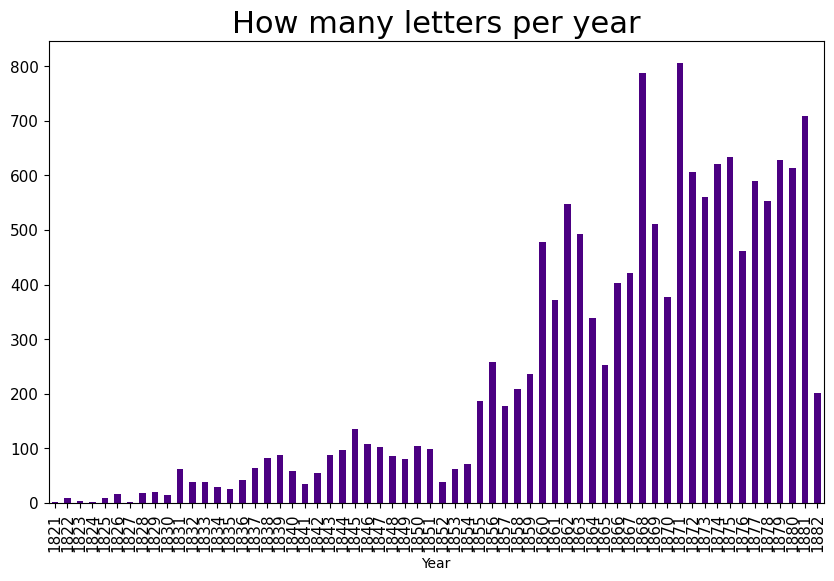

In [224]:
ax = df0.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=11);
#ax.set_alpha(0.5)
ax.set_title("How many letters per year", fontsize=22)
plt.show()

I check the letters containing the word _insectivorous_:

In [225]:
pd.set_option('display.max_colwidth', 60)
word_of_interest = "insectivorous"

def extract_context(text, word, window=30):
    pattern = re.compile(rf".{{0,{window}}}{word}.{{0,{window}}}", re.IGNORECASE)
    match = pattern.search(text)
    return match.group(0) if match else ''

filtered_df = df[df['Transcription'].str.contains(word_of_interest, case=False, na=False)]
filtered_df['Context'] = filtered_df['Transcription'].apply(lambda x: extract_context(x, word_of_interest))
# Temporarily set options to display all rows and columns
pd.set_option('display.max_rows', None)  # None means no limit

print(filtered_df[['Year', 'Context']].sort_values(by='Year'))

# Reset options to default if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

       Year                                                      Context
7263   1846  ggot within; so that they are insectivorous.— A Cychrus ...
9780   1860   Feet ———–Birds of Prey. some insectivorous ————Some fis...
1002   1861  colour by the check caused by insectivorous animals. The...
4725   1862  ou sugar? Is the little Heron insectivorous? State somew...
9906   1866  scarlet insect & thus attract insectivorous birds, or fr...
14215  1867  ny one who keeps a variety of insectivorous birds. They ...
8203   1867  They have not even our little insectivorous quadruped th...
14720  1868  resume that on that island no insectivorous bird exists ...
11328  1868  ms a nice fat mouthful for an insectivorous bird, but by...
8085   1868  be exempt from the attacks of insectivorous birds; these...
12765  1868  the necessity there is for an insectivorous non-migrator...
1973   1868  t is but rarely discovered by insectivorous animals and ...
14231  1869  arvæ &c. eaten or rejected by insectiv

/var/folders/hm/km4mzkbs62nbjpx0cmtqlcx40000gn/T/ipykernel_49288/2486529140.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Context'] = filtered_df['Transcription'].apply(lambda x: extract_context(x, word_of_interest))


In [226]:
filtered_df[['Year', 'Context']].groupby('Year').size().reset_index(name='count_of_texts')

Year  count_of_texts
0   1846               1
1   1860               1
2   1861               1
3   1862               1
4   1866               1
5   1867               2
6   1868               5
7   1869               2
8   1871               2
9   1874               4
10  1875              80
11  1876              19
12  1877              12
13  1878               5
14  1879               3
15  1880               4
16  1881               4
17  1882               1

## 3. Linguistic pre-processing

**NB**: From here you can **skip** to the code line "df = pd.read_csv(os.path.join(out_folder, 'transcription_tokens.csv'), sep = "\t")"

Add a space before and after every m-dash:

In [227]:
s = "– – –Museum three — one from"
pat = re.compile(r"(\u2014)")
s = pat.sub(" \\1 ", s)
pat1 = re.compile(r"(\u2013)")
s = pat1.sub(" \\1 ", s)
s = s.replace("  ", " ")
s

' –  –  – Museum three — one from'

In [228]:
s = "– – –Museum three — one from"
pat = re.compile(r"(\u2014)")
pat1 = re.compile(r"(\u2013)")
s = pat.sub(" \\1 ", pat1.sub(" \\1 ", s)).replace("  ", " ")
s

' –  –  – Museum three — one from'

In [229]:
pat = re.compile(r"(\u2014)")
pat1 = re.compile(r"(\u2013)")
df['Transcription'] = [pat.sub(" \\1 ", pat1.sub(" \\1 ", df['Transcription'].iloc[i])).replace("  ", " ") for i in range(df.shape[0])]
df

File  Year           Sender          Receiver  \
0      DCP-LETT-12349.xml  1879    Darwin, C. R.      Payne, A. H.   
1      DCP-LETT-13057.xml  1881     Allen, Grant     Darwin, C. R.   
2      DCP-LETT-11898.xml  1879  Hamilton, C. W.     Darwin, C. R.   
3       DCP-LETT-7806.xml  1871    Darwin, C. R.   Darwin, Francis   
4      DCP-LETT-11640.xml  1878    Darwin, C. R.     Flower, W. H.   
...                   ...   ...              ...               ...   
14815  DCP-LETT-11659.xml  1878    Darwin, C. R.         Gray, Asa   
14816  DCP-LETT-11881.xml  1879    Darwin, C. R.    Vries, Hugo de   
14817  DCP-LETT-10547.xml  1862  Walker, Francis     Darwin, C. R.   
14818   DCP-LETT-2967.xml  1860    Darwin, C. R.  Sharpey, William   
14819  DCP-LETT-12350.xml  1879   Moulton, J. F.     Darwin, C. R.   

                                           Transcription  
0      I have no objection to express my opinion on t...  
1      I was greatly gratified and not a little flatt...  
2      I almost feel that you will not consider me in...  
3      Very many thanks for all that you have done fo...  
4      You will remember the dried wings of the goose...  
...                                                  ...  
14815  Dr. Hugo de Vries, who has done such excellent...  
14816  I am going to beg a favour of you. I have just...  
14817  I received your letter today. The larger brown...  
14818  My dear Dr. Sharpey I hear that Mr. Oliver is ...  
14819  By some mysterious process Mr Malcolm Guthrie ...  

[14820 rows x 5 columns]

In [230]:
df[df['File'] == "DCP-LETT-6078.xml"]

File  Year       Sender       Receiver  \
12765  DCP-LETT-6078.xml  1868  Weir, J. J.  Darwin, C. R.   

                                           Transcription  
12765  I was in Spitalfields recently & had some furt...

load the spaCy language model:

In [231]:
sp = spacy.load("en_core_web_sm")

I split the letters into sentences, although this step may not be needed in the end. **NB** This can take about 10 minutes.

File  Year           Sender          Receiver  \
0      DCP-LETT-12349.xml  1879    Darwin, C. R.      Payne, A. H.   
1      DCP-LETT-13057.xml  1881     Allen, Grant     Darwin, C. R.   
2      DCP-LETT-11898.xml  1879  Hamilton, C. W.     Darwin, C. R.   
3       DCP-LETT-7806.xml  1871    Darwin, C. R.   Darwin, Francis   
4      DCP-LETT-11640.xml  1878    Darwin, C. R.     Flower, W. H.   
...                   ...   ...              ...               ...   
14815  DCP-LETT-11659.xml  1878    Darwin, C. R.         Gray, Asa   
14816  DCP-LETT-11881.xml  1879    Darwin, C. R.    Vries, Hugo de   
14817  DCP-LETT-10547.xml  1862  Walker, Francis     Darwin, C. R.   
14818   DCP-LETT-2967.xml  1860    Darwin, C. R.  Sharpey, William   
14819  DCP-LETT-12350.xml  1879   Moulton, J. F.     Darwin, C. R.   

                                           Transcription  \
0      I have no objection to express my opinion on t...   
1      I was greatly gratified and not a little flatt...   
2      I almost feel that you will not consider me in...   
3      Very many thanks for all that you have done fo...   
4      You will remember the dried wings of the goose...   
...                                                  ...   
14815  Dr. Hugo de Vries, who has done such excellent...   
14816  I am going to beg a favour of you. I have just...   
14817  I received your letter today. The larger brown...   
14818  My dear Dr. Sharpey I hear that Mr. Oliver is ...   
14819  By some mysterious process Mr Malcolm Guthrie ...   

                                     Transcription_spacy  
0      (I, have, no, objection, to, express, my, opin...  
1      (I, was, greatly, gratified, and, not, a, litt...  
2      (I, almost, feel, that, you, will, not, consid...  
3      (Very, many, thanks, for, all, that, you, have...  
4      (You, will, remember, the, dried, wings, of, t...  
...                                                  ...  
14815  (Dr., Hugo, de, Vries, ,, who, has, done, such...  
14816  (I, am, going, to, beg, a, favour, of, you, .,...  
14817  (I, received, your, letter, today, ., The, lar...  
14818  (My, dear, Dr., Sharpey, I, hear, that, Mr., O...  
14819  (By, some, mysterious, process, Mr, Malcolm, G...  

[14820 rows x 6 columns]

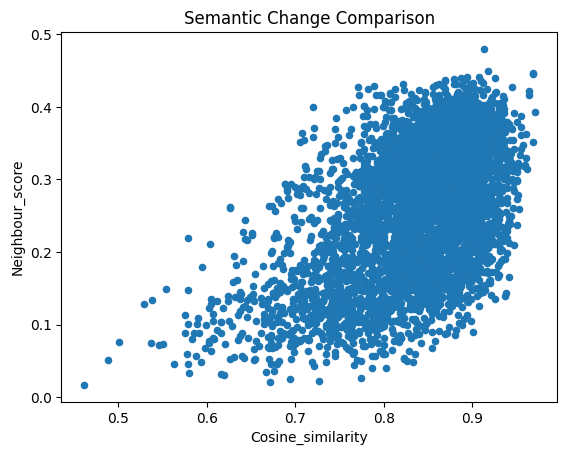

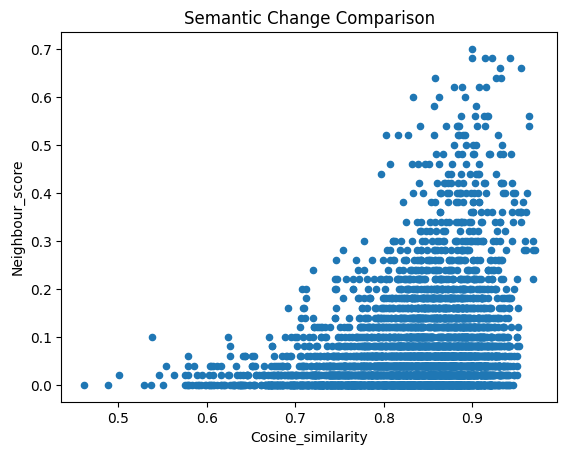

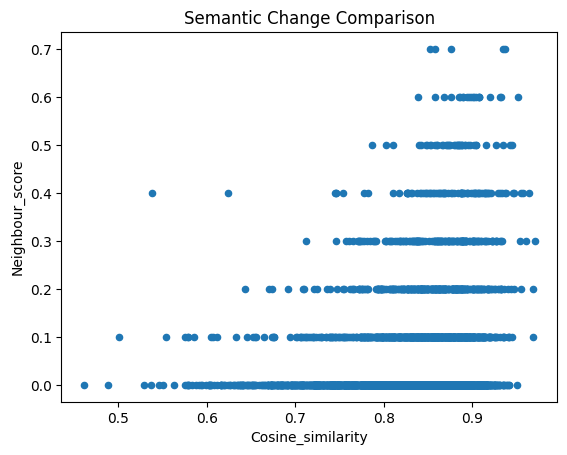

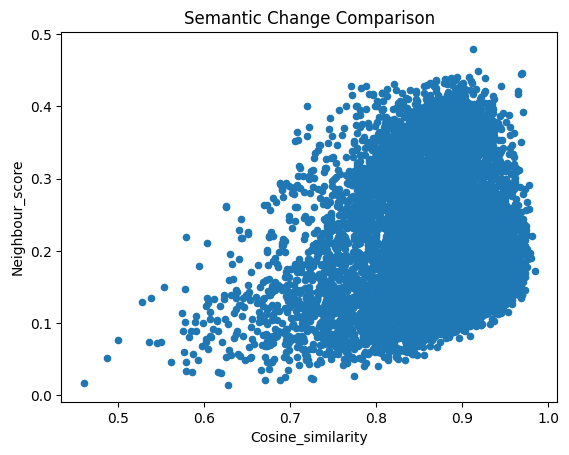

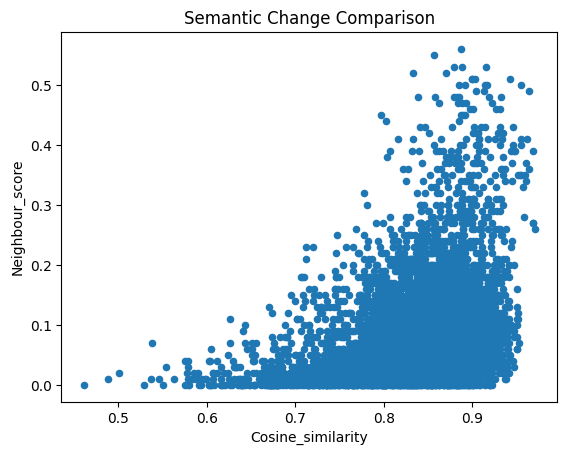

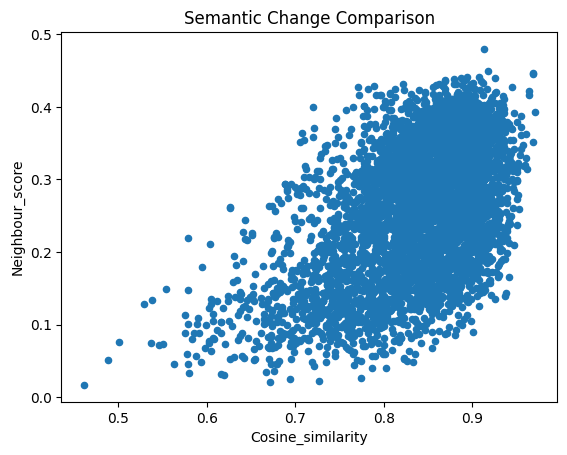

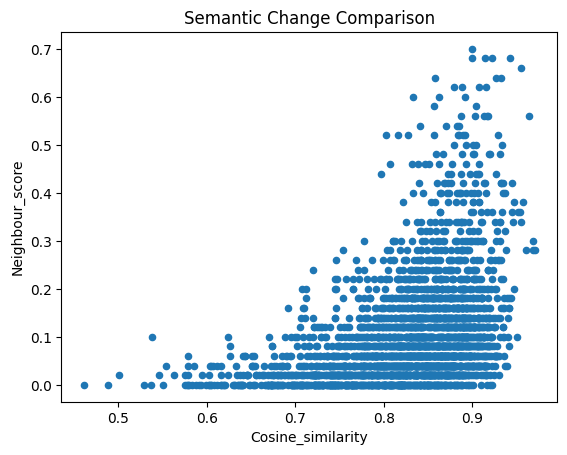

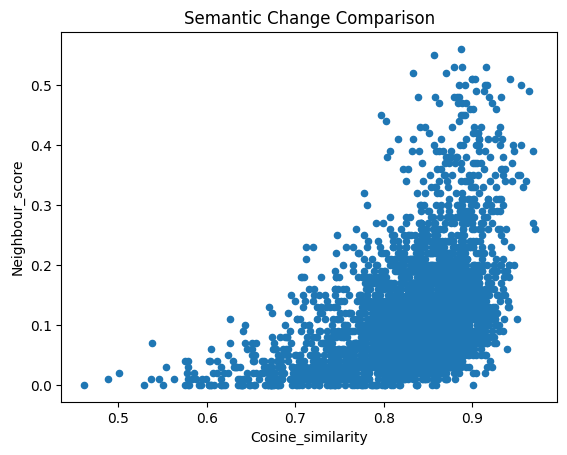

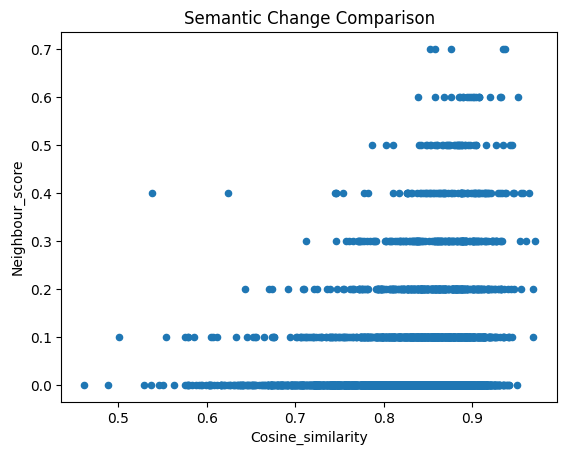

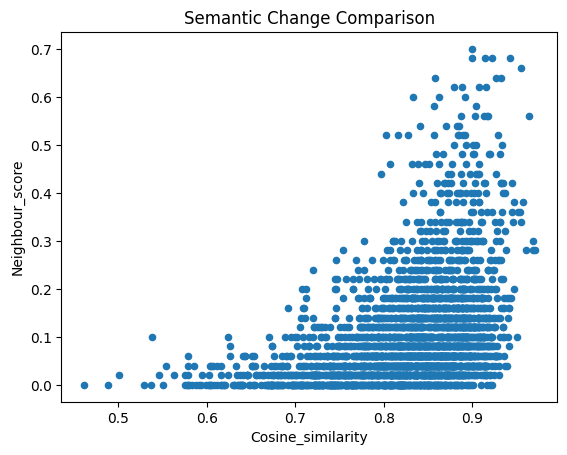

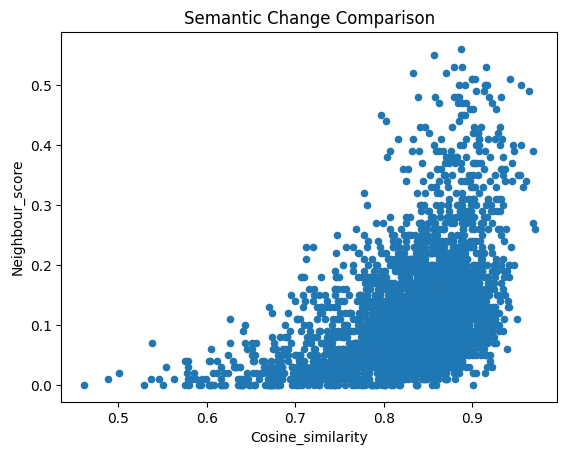

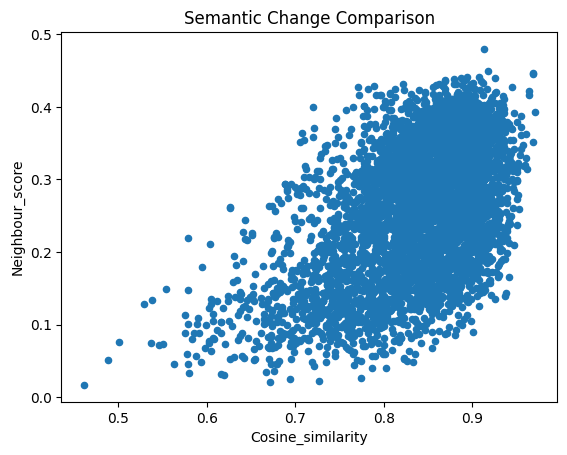

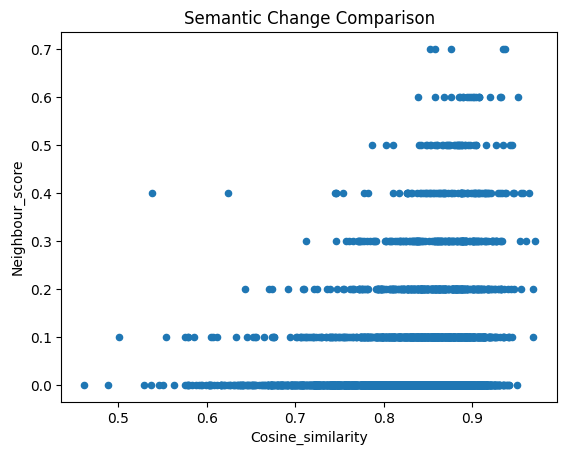

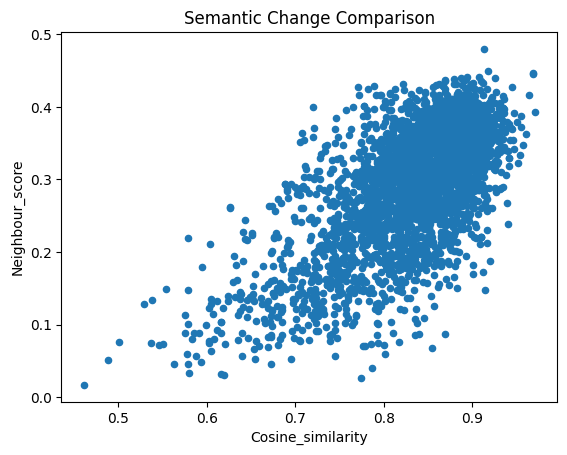

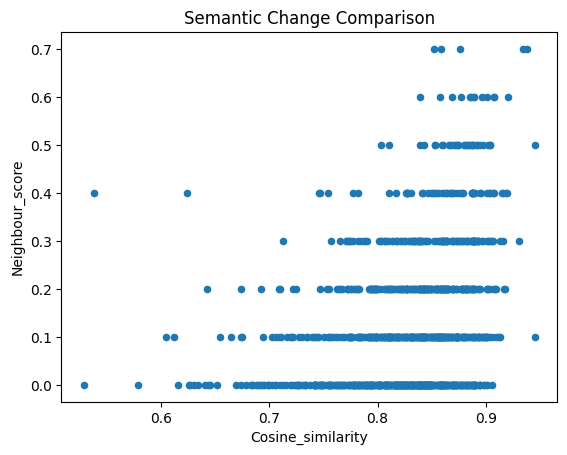

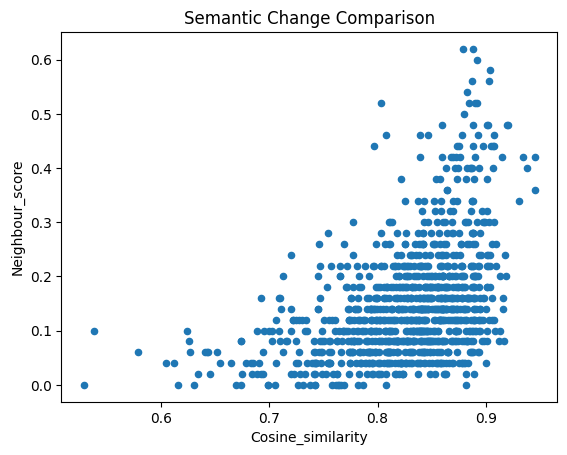

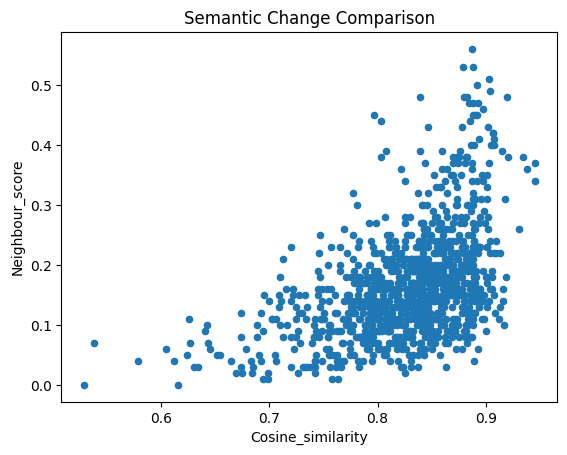

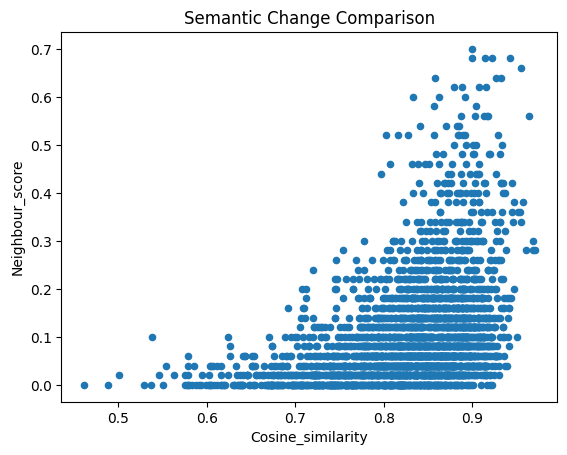

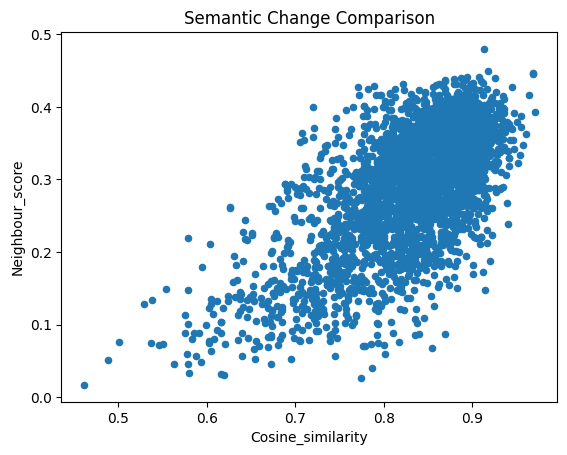

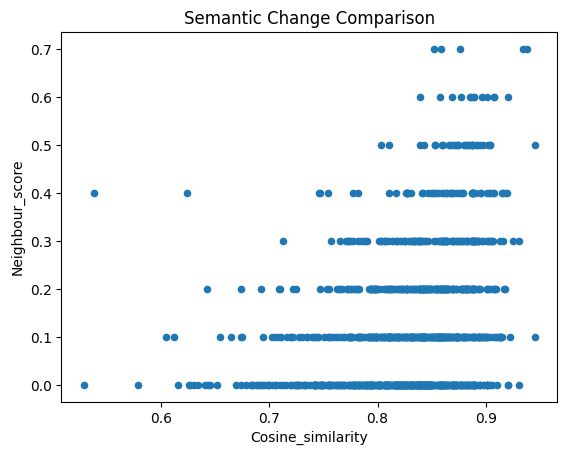

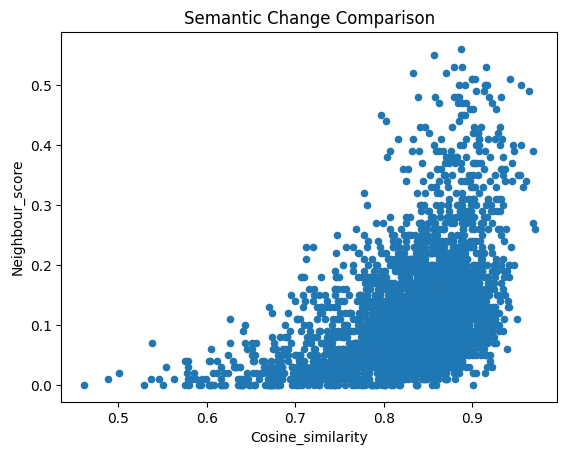

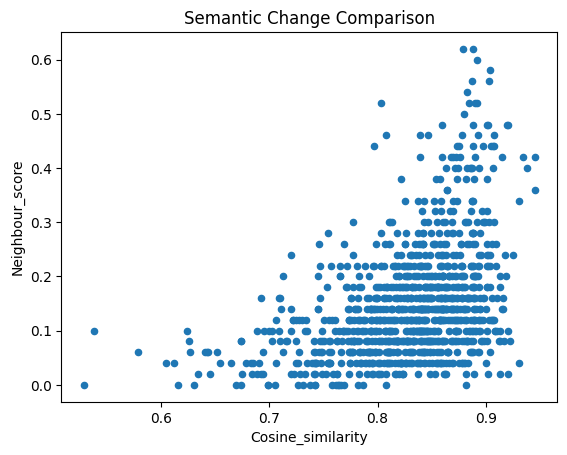

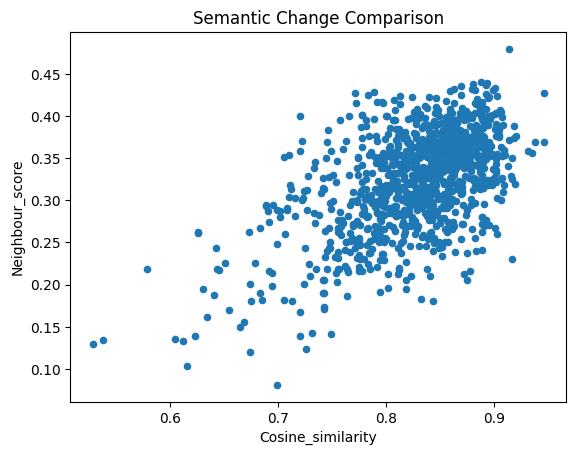

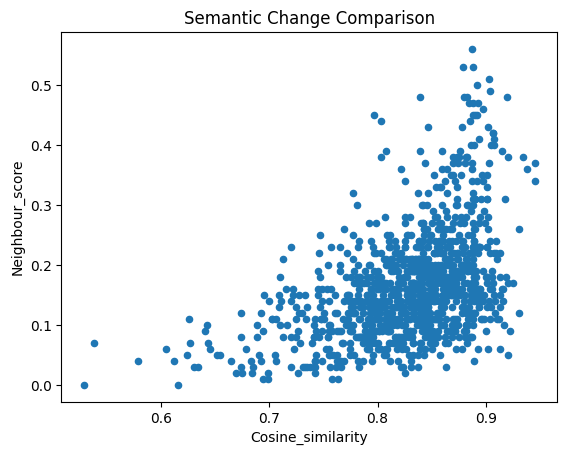

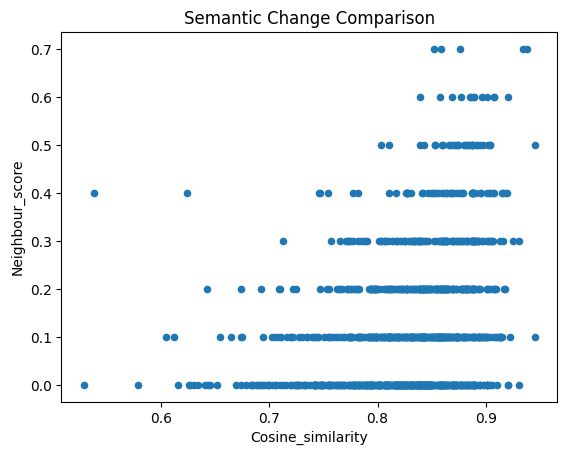

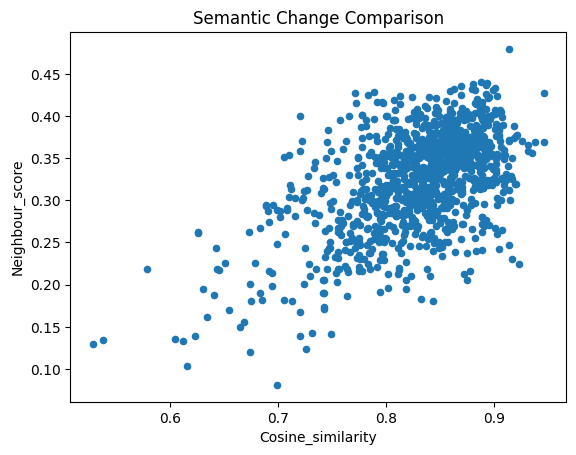

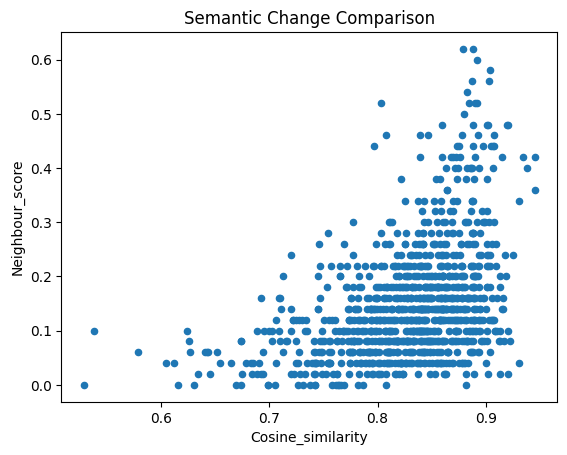

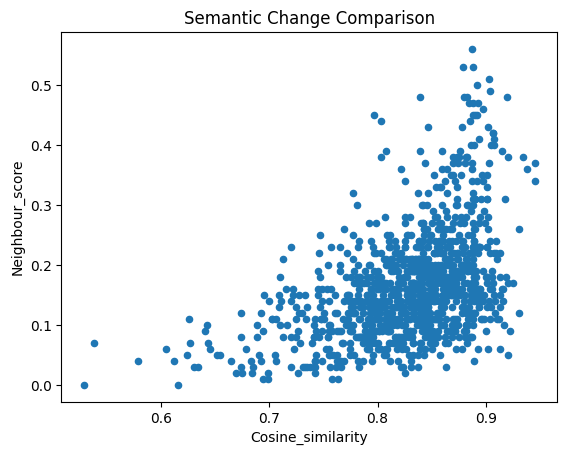

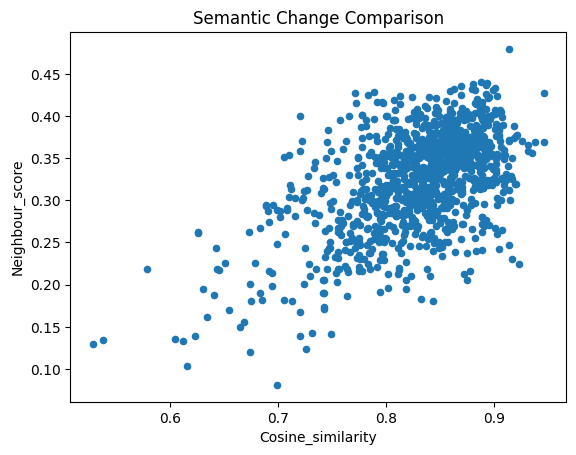

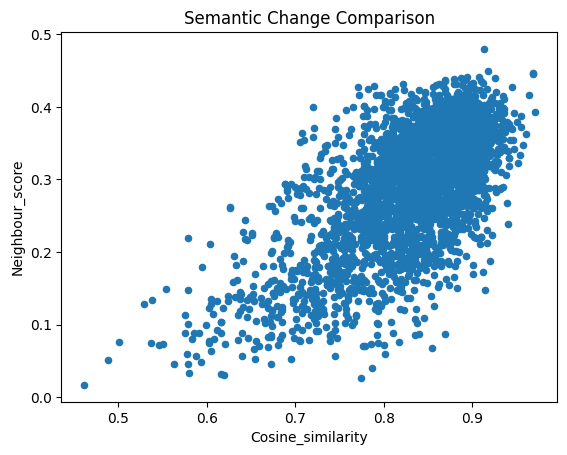

In [232]:
df['Transcription_spacy'] = [sp(df['Transcription'].iloc[i]) for i in range(df.shape[0])]
df

A token simply refers to an individual part of a sentence having some semantic value. Let's see what tokens we have in our document. **NB This takes about 12 minutes**.

In [233]:
df['Tokens'] = [[word.text for word in sp(df['Transcription'].iloc[i])] for i in range(df.shape[0])]
df

File  Year           Sender          Receiver  \
0      DCP-LETT-12349.xml  1879    Darwin, C. R.      Payne, A. H.   
1      DCP-LETT-13057.xml  1881     Allen, Grant     Darwin, C. R.   
2      DCP-LETT-11898.xml  1879  Hamilton, C. W.     Darwin, C. R.   
3       DCP-LETT-7806.xml  1871    Darwin, C. R.   Darwin, Francis   
4      DCP-LETT-11640.xml  1878    Darwin, C. R.     Flower, W. H.   
...                   ...   ...              ...               ...   
14815  DCP-LETT-11659.xml  1878    Darwin, C. R.         Gray, Asa   
14816  DCP-LETT-11881.xml  1879    Darwin, C. R.    Vries, Hugo de   
14817  DCP-LETT-10547.xml  1862  Walker, Francis     Darwin, C. R.   
14818   DCP-LETT-2967.xml  1860    Darwin, C. R.  Sharpey, William   
14819  DCP-LETT-12350.xml  1879   Moulton, J. F.     Darwin, C. R.   

                                           Transcription  \
0      I have no objection to express my opinion on t...   
1      I was greatly gratified and not a little flatt...   
2      I almost feel that you will not consider me in...   
3      Very many thanks for all that you have done fo...   
4      You will remember the dried wings of the goose...   
...                                                  ...   
14815  Dr. Hugo de Vries, who has done such excellent...   
14816  I am going to beg a favour of you. I have just...   
14817  I received your letter today. The larger brown...   
14818  My dear Dr. Sharpey I hear that Mr. Oliver is ...   
14819  By some mysterious process Mr Malcolm Guthrie ...   

                                     Transcription_spacy  \
0      (I, have, no, objection, to, express, my, opin...   
1      (I, was, greatly, gratified, and, not, a, litt...   
2      (I, almost, feel, that, you, will, not, consid...   
3      (Very, many, thanks, for, all, that, you, have...   
4      (You, will, remember, the, dried, wings, of, t...   
...                                                  ...   
14815  (Dr., Hugo, de, Vries, ,, who, has, done, such...   
14816  (I, am, going, to, beg, a, favour, of, you, .,...   
14817  (I, received, your, letter, today, ., The, lar...   
14818  (My, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  (By, some, mysterious, process, Mr, Malcolm, G...   

                                                  Tokens  
0      [I, have, no, objection, to, express, my, opin...  
1      [I, was, greatly, gratified, and, not, a, litt...  
2      [I, almost, feel, that, you, will, not, consid...  
3      [Very, many, thanks, for, all, that, you, have...  
4      [You, will, remember, the, dried, wings, of, t...  
...                                                  ...  
14815  [Dr., Hugo, de, Vries, ,, who, has, done, such...  
14816  [I, am, going, to, beg, a, favour, of, you, .,...  
14817  [I, received, your, letter, today, ., The, lar...  
14818  [My, dear, Dr., Sharpey, I, hear, that, Mr., O...  
14819  [By, some, mysterious, process, Mr, Malcolm, G...  

[14820 rows x 7 columns]

In [234]:
df[df['File'] == "DCP-LETT-686.xml"]

File  Year             Sender       Receiver  \
5  DCP-LETT-686.xml  1843  Waterhouse, G. R.  Darwin, C. R.   

                                       Transcription  \
5   – Museum three — one from Dr. Richardson who ...   

                                 Transcription_spacy  \
5  ( , –, Museum, three, —, one, from, Dr., Richa...   

                                              Tokens  
5  [ , –, Museum, three, —, one, from, Dr., Richa...

### Lemmatisation

I lemmatise the letters. **NB this can take about 12 minutes.**

In [235]:
df['Lemmas'] = [[word.lemma_ for word in sp(df['Transcription'].iloc[i])] for i in range(df.shape[0])]
df

File  Year           Sender          Receiver  \
0      DCP-LETT-12349.xml  1879    Darwin, C. R.      Payne, A. H.   
1      DCP-LETT-13057.xml  1881     Allen, Grant     Darwin, C. R.   
2      DCP-LETT-11898.xml  1879  Hamilton, C. W.     Darwin, C. R.   
3       DCP-LETT-7806.xml  1871    Darwin, C. R.   Darwin, Francis   
4      DCP-LETT-11640.xml  1878    Darwin, C. R.     Flower, W. H.   
...                   ...   ...              ...               ...   
14815  DCP-LETT-11659.xml  1878    Darwin, C. R.         Gray, Asa   
14816  DCP-LETT-11881.xml  1879    Darwin, C. R.    Vries, Hugo de   
14817  DCP-LETT-10547.xml  1862  Walker, Francis     Darwin, C. R.   
14818   DCP-LETT-2967.xml  1860    Darwin, C. R.  Sharpey, William   
14819  DCP-LETT-12350.xml  1879   Moulton, J. F.     Darwin, C. R.   

                                           Transcription  \
0      I have no objection to express my opinion on t...   
1      I was greatly gratified and not a little flatt...   
2      I almost feel that you will not consider me in...   
3      Very many thanks for all that you have done fo...   
4      You will remember the dried wings of the goose...   
...                                                  ...   
14815  Dr. Hugo de Vries, who has done such excellent...   
14816  I am going to beg a favour of you. I have just...   
14817  I received your letter today. The larger brown...   
14818  My dear Dr. Sharpey I hear that Mr. Oliver is ...   
14819  By some mysterious process Mr Malcolm Guthrie ...   

                                     Transcription_spacy  \
0      (I, have, no, objection, to, express, my, opin...   
1      (I, was, greatly, gratified, and, not, a, litt...   
2      (I, almost, feel, that, you, will, not, consid...   
3      (Very, many, thanks, for, all, that, you, have...   
4      (You, will, remember, the, dried, wings, of, t...   
...                                                  ...   
14815  (Dr., Hugo, de, Vries, ,, who, has, done, such...   
14816  (I, am, going, to, beg, a, favour, of, you, .,...   
14817  (I, received, your, letter, today, ., The, lar...   
14818  (My, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  (By, some, mysterious, process, Mr, Malcolm, G...   

                                                  Tokens  \
0      [I, have, no, objection, to, express, my, opin...   
1      [I, was, greatly, gratified, and, not, a, litt...   
2      [I, almost, feel, that, you, will, not, consid...   
3      [Very, many, thanks, for, all, that, you, have...   
4      [You, will, remember, the, dried, wings, of, t...   
...                                                  ...   
14815  [Dr., Hugo, de, Vries, ,, who, has, done, such...   
14816  [I, am, going, to, beg, a, favour, of, you, .,...   
14817  [I, received, your, letter, today, ., The, lar...   
14818  [My, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  [By, some, mysterious, process, Mr, Malcolm, G...   

                                                  Lemmas  
0      [I, have, no, objection, to, express, my, opin...  
1      [I, be, greatly, gratified, and, not, a, littl...  
2      [I, almost, feel, that, you, will, not, consid...  
3      [very, many, thank, for, all, that, you, have,...  
4      [you, will, remember, the, dry, wing, of, the,...  
...                                                  ...  
14815  [Dr., Hugo, de, Vries, ,, who, have, do, such,...  
14816  [I, be, go, to, beg, a, favour, of, you, ., I,...  
14817  [I, receive, your, letter, today, ., the, larg...  
14818  [my, dear, Dr., Sharpey, I, hear, that, Mr., O...  
14819  [by, some, mysterious, process, Mr, Malcolm, G...  

[14820 rows x 8 columns]

#### Stopwords exclusion and further filtering
I exclude non-alphabetical characters:

In [236]:
df["Lemmas_clean"] = ''
for i in range(df.shape[0]):
  #df['Lemmas_clean'].iloc[i] = [t for t in df['Lemmas'].iloc[i] if t not in '''!()-[]{};:\'"\,<>./?@#$%^&*_~\|–—\“’`''']# and t.isalpha() ]
    df.at[i, 'Lemmas_clean'] = [t for t in df.loc[i, 'Lemmas'] if t not in '''!()-[]{};:\'"\,<>./?@#$%^&*_~\|–—\“’`〉〈''']
df

File  Year           Sender          Receiver  \
0      DCP-LETT-12349.xml  1879    Darwin, C. R.      Payne, A. H.   
1      DCP-LETT-13057.xml  1881     Allen, Grant     Darwin, C. R.   
2      DCP-LETT-11898.xml  1879  Hamilton, C. W.     Darwin, C. R.   
3       DCP-LETT-7806.xml  1871    Darwin, C. R.   Darwin, Francis   
4      DCP-LETT-11640.xml  1878    Darwin, C. R.     Flower, W. H.   
...                   ...   ...              ...               ...   
14815  DCP-LETT-11659.xml  1878    Darwin, C. R.         Gray, Asa   
14816  DCP-LETT-11881.xml  1879    Darwin, C. R.    Vries, Hugo de   
14817  DCP-LETT-10547.xml  1862  Walker, Francis     Darwin, C. R.   
14818   DCP-LETT-2967.xml  1860    Darwin, C. R.  Sharpey, William   
14819  DCP-LETT-12350.xml  1879   Moulton, J. F.     Darwin, C. R.   

                                           Transcription  \
0      I have no objection to express my opinion on t...   
1      I was greatly gratified and not a little flatt...   
2      I almost feel that you will not consider me in...   
3      Very many thanks for all that you have done fo...   
4      You will remember the dried wings of the goose...   
...                                                  ...   
14815  Dr. Hugo de Vries, who has done such excellent...   
14816  I am going to beg a favour of you. I have just...   
14817  I received your letter today. The larger brown...   
14818  My dear Dr. Sharpey I hear that Mr. Oliver is ...   
14819  By some mysterious process Mr Malcolm Guthrie ...   

                                     Transcription_spacy  \
0      (I, have, no, objection, to, express, my, opin...   
1      (I, was, greatly, gratified, and, not, a, litt...   
2      (I, almost, feel, that, you, will, not, consid...   
3      (Very, many, thanks, for, all, that, you, have...   
4      (You, will, remember, the, dried, wings, of, t...   
...                                                  ...   
14815  (Dr., Hugo, de, Vries, ,, who, has, done, such...   
14816  (I, am, going, to, beg, a, favour, of, you, .,...   
14817  (I, received, your, letter, today, ., The, lar...   
14818  (My, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  (By, some, mysterious, process, Mr, Malcolm, G...   

                                                  Tokens  \
0      [I, have, no, objection, to, express, my, opin...   
1      [I, was, greatly, gratified, and, not, a, litt...   
2      [I, almost, feel, that, you, will, not, consid...   
3      [Very, many, thanks, for, all, that, you, have...   
4      [You, will, remember, the, dried, wings, of, t...   
...                                                  ...   
14815  [Dr., Hugo, de, Vries, ,, who, has, done, such...   
14816  [I, am, going, to, beg, a, favour, of, you, .,...   
14817  [I, received, your, letter, today, ., The, lar...   
14818  [My, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  [By, some, mysterious, process, Mr, Malcolm, G...   

                                                  Lemmas  \
0      [I, have, no, objection, to, express, my, opin...   
1      [I, be, greatly, gratified, and, not, a, littl...   
2      [I, almost, feel, that, you, will, not, consid...   
3      [very, many, thank, for, all, that, you, have,...   
4      [you, will, remember, the, dry, wing, of, the,...   
...                                                  ...   
14815  [Dr., Hugo, de, Vries, ,, who, have, do, such,...   
14816  [I, be, go, to, beg, a, favour, of, you, ., I,...   
14817  [I, receive, your, letter, today, ., the, larg...   
14818  [my, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  [by, some, mysterious, process, Mr, Malcolm, G...   

                                            Lemmas_clean  
0      [I, have, no, objection, to, express, my, opin...  
1      [I, be, greatly, gratified, and, not, a, littl...  
2      [I, almost, feel, that, you, will, not, consid...  
3      [very, many, thank, for, all, that, you, have,...  
4

I exclude stop words, although they will be needed for word embedding training:

In [237]:
stopWords = set(stopwords.words('english'))
additional_stopwords = {'fig', 'etc', 'mr', 'mrs', 'dr', 'sir', 'et', 'al', 'st', 'fig.', 'ibid'}
stopWords.update(additional_stopwords)

df["Lemmas_nostop"] = ''
for i in range(df.shape[0]):
  df.at[i,'Lemmas_nostop'] = [t for t in df.loc[i, 'Lemmas'] if t.lower() not in stopWords]
df

File  Year           Sender          Receiver  \
0      DCP-LETT-12349.xml  1879    Darwin, C. R.      Payne, A. H.   
1      DCP-LETT-13057.xml  1881     Allen, Grant     Darwin, C. R.   
2      DCP-LETT-11898.xml  1879  Hamilton, C. W.     Darwin, C. R.   
3       DCP-LETT-7806.xml  1871    Darwin, C. R.   Darwin, Francis   
4      DCP-LETT-11640.xml  1878    Darwin, C. R.     Flower, W. H.   
...                   ...   ...              ...               ...   
14815  DCP-LETT-11659.xml  1878    Darwin, C. R.         Gray, Asa   
14816  DCP-LETT-11881.xml  1879    Darwin, C. R.    Vries, Hugo de   
14817  DCP-LETT-10547.xml  1862  Walker, Francis     Darwin, C. R.   
14818   DCP-LETT-2967.xml  1860    Darwin, C. R.  Sharpey, William   
14819  DCP-LETT-12350.xml  1879   Moulton, J. F.     Darwin, C. R.   

                                           Transcription  \
0      I have no objection to express my opinion on t...   
1      I was greatly gratified and not a little flatt...   
2      I almost feel that you will not consider me in...   
3      Very many thanks for all that you have done fo...   
4      You will remember the dried wings of the goose...   
...                                                  ...   
14815  Dr. Hugo de Vries, who has done such excellent...   
14816  I am going to beg a favour of you. I have just...   
14817  I received your letter today. The larger brown...   
14818  My dear Dr. Sharpey I hear that Mr. Oliver is ...   
14819  By some mysterious process Mr Malcolm Guthrie ...   

                                     Transcription_spacy  \
0      (I, have, no, objection, to, express, my, opin...   
1      (I, was, greatly, gratified, and, not, a, litt...   
2      (I, almost, feel, that, you, will, not, consid...   
3      (Very, many, thanks, for, all, that, you, have...   
4      (You, will, remember, the, dried, wings, of, t...   
...                                                  ...   
14815  (Dr., Hugo, de, Vries, ,, who, has, done, such...   
14816  (I, am, going, to, beg, a, favour, of, you, .,...   
14817  (I, received, your, letter, today, ., The, lar...   
14818  (My, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  (By, some, mysterious, process, Mr, Malcolm, G...   

                                                  Tokens  \
0      [I, have, no, objection, to, express, my, opin...   
1      [I, was, greatly, gratified, and, not, a, litt...   
2      [I, almost, feel, that, you, will, not, consid...   
3      [Very, many, thanks, for, all, that, you, have...   
4      [You, will, remember, the, dried, wings, of, t...   
...                                                  ...   
14815  [Dr., Hugo, de, Vries, ,, who, has, done, such...   
14816  [I, am, going, to, beg, a, favour, of, you, .,...   
14817  [I, received, your, letter, today, ., The, lar...   
14818  [My, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  [By, some, mysterious, process, Mr, Malcolm, G...   

                                                  Lemmas  \
0      [I, have, no, objection, to, express, my, opin...   
1      [I, be, greatly, gratified, and, not, a, littl...   
2      [I, almost, feel, that, you, will, not, consid...   
3      [very, many, thank, for, all, that, you, have,...   
4      [you, will, remember, the, dry, wing, of, the,...   
...                                                  ...   
14815  [Dr., Hugo, de, Vries, ,, who, have, do, such,...   
14816  [I, be, go, to, beg, a, favour, of, you, ., I,...   
14817  [I, receive, your, letter, today, ., the, larg...   
14818  [my, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  [by, some, mysterious, process, Mr, Malcolm, G...   

                                            Lemmas_clean  \
0      [I, have, no, objection, to, express, my, opin...   
1      [I, be, greatly, gratified, and, not, a, littl...   
2      [I, almost, feel, that, you, will, not, consid...   
3      [very, many, thank, for, all, that, you, have,...

I add the language of the letters in an additional column. **NB This takes 2 minutes.**

In [238]:
transcriptions = df[['Transcription']].to_numpy().flatten().tolist()
df['language'] = [detect(x) for x in transcriptions]

In [239]:
df

File  Year           Sender          Receiver  \
0      DCP-LETT-12349.xml  1879    Darwin, C. R.      Payne, A. H.   
1      DCP-LETT-13057.xml  1881     Allen, Grant     Darwin, C. R.   
2      DCP-LETT-11898.xml  1879  Hamilton, C. W.     Darwin, C. R.   
3       DCP-LETT-7806.xml  1871    Darwin, C. R.   Darwin, Francis   
4      DCP-LETT-11640.xml  1878    Darwin, C. R.     Flower, W. H.   
...                   ...   ...              ...               ...   
14815  DCP-LETT-11659.xml  1878    Darwin, C. R.         Gray, Asa   
14816  DCP-LETT-11881.xml  1879    Darwin, C. R.    Vries, Hugo de   
14817  DCP-LETT-10547.xml  1862  Walker, Francis     Darwin, C. R.   
14818   DCP-LETT-2967.xml  1860    Darwin, C. R.  Sharpey, William   
14819  DCP-LETT-12350.xml  1879   Moulton, J. F.     Darwin, C. R.   

                                           Transcription  \
0      I have no objection to express my opinion on t...   
1      I was greatly gratified and not a little flatt...   
2      I almost feel that you will not consider me in...   
3      Very many thanks for all that you have done fo...   
4      You will remember the dried wings of the goose...   
...                                                  ...   
14815  Dr. Hugo de Vries, who has done such excellent...   
14816  I am going to beg a favour of you. I have just...   
14817  I received your letter today. The larger brown...   
14818  My dear Dr. Sharpey I hear that Mr. Oliver is ...   
14819  By some mysterious process Mr Malcolm Guthrie ...   

                                     Transcription_spacy  \
0      (I, have, no, objection, to, express, my, opin...   
1      (I, was, greatly, gratified, and, not, a, litt...   
2      (I, almost, feel, that, you, will, not, consid...   
3      (Very, many, thanks, for, all, that, you, have...   
4      (You, will, remember, the, dried, wings, of, t...   
...                                                  ...   
14815  (Dr., Hugo, de, Vries, ,, who, has, done, such...   
14816  (I, am, going, to, beg, a, favour, of, you, .,...   
14817  (I, received, your, letter, today, ., The, lar...   
14818  (My, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  (By, some, mysterious, process, Mr, Malcolm, G...   

                                                  Tokens  \
0      [I, have, no, objection, to, express, my, opin...   
1      [I, was, greatly, gratified, and, not, a, litt...   
2      [I, almost, feel, that, you, will, not, consid...   
3      [Very, many, thanks, for, all, that, you, have...   
4      [You, will, remember, the, dried, wings, of, t...   
...                                                  ...   
14815  [Dr., Hugo, de, Vries, ,, who, has, done, such...   
14816  [I, am, going, to, beg, a, favour, of, you, .,...   
14817  [I, received, your, letter, today, ., The, lar...   
14818  [My, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  [By, some, mysterious, process, Mr, Malcolm, G...   

                                                  Lemmas  \
0      [I, have, no, objection, to, express, my, opin...   
1      [I, be, greatly, gratified, and, not, a, littl...   
2      [I, almost, feel, that, you, will, not, consid...   
3      [very, many, thank, for, all, that, you, have,...   
4      [you, will, remember, the, dry, wing, of, the,...   
...                                                  ...   
14815  [Dr., Hugo, de, Vries, ,, who, have, do, such,...   
14816  [I, be, go, to, beg, a, favour, of, you, ., I,...   
14817  [I, receive, your, letter, today, ., the, larg...   
14818  [my, dear, Dr., Sharpey, I, hear, that, Mr., O...   
14819  [by, some, mysterious, process, Mr, Malcolm, G...   

                                            Lemmas_clean  \
0      [I, have, no, objection, to, express, my, opin...   
1      [I, be, greatly, gratified, and, not, a, littl...   
2      [I, almost, feel, that, you, will, not, consid...   
3      [very, many, thank, for, all, that, you, have,...

How many letters per language?

In [240]:
df[['language']].value_counts()

language
en          14788
fr             13
de             11
ca              3
it              2
af              1
et              1
pt              1
dtype: int64

Only keep letters in English:

In [241]:
#df = df[~df.language.isin(['de', 'fr'])]
df = df[df.language.isin(['en'])]
df.shape

(14788, 11)

We only select the letters written by Charles Darwin:

In [242]:
df1 = df[df['Sender'] == "Darwin, C. R."]
df1.shape

(8133, 11)

I check the frequencies of *insectivorous*: (In the context of pandas DataFrames, lambda functions are often used with methods like apply to perform row-wise or column-wise operations in a concise manner)

In [243]:
df[df['Lemmas'].apply(lambda x: 'insectivorous' in x)]

File  Year                 Sender  \
133     DCP-LETT-10990.xml  1877         Martins, C. F.   
199    DCP-LETT-10037A.xml  1875          Darwin, C. R.   
315     DCP-LETT-11287.xml  1877          Darwin, C. R.   
620     DCP-LETT-10198.xml  1875          Darwin, C. R.   
658     DCP-LETT-10173.xml  1878        Marshall, W. C.   
...                    ...   ...                    ...   
14559   DCP-LETT-10619.xml  1876          Darwin, C. R.   
14575   DCP-LETT-12754.xml  1880         Aveling, E. B.   
14684   DCP-LETT-11301.xml  1875  Thiselton-Dyer, W. T.   
14720    DCP-LETT-5985.xml  1868            Weir, J. J.   
14788   DCP-LETT-11103.xml  1877         Romanes, G. J.   

                      Receiver  \
133              Darwin, C. R.   
199                Cohn, F. J.   
315    Saporta, L. C. J. G. de   
620               Carus, J. V.   
658              Darwin, C. R.   
...                        ...   
14559             Carus, J. V.   
14575            Darwin, C. R.   
14684            Darwin, C. R.   
14720            Darwin, C. R.   
14788            Darwin, C. R.   

                                           Transcription  \
133    I am happy to learn that the translation into ...   
199    As you expressed a wish to have an early copy ...   
315    I thank you sincerely for your long & most int...   
620    I send by this post clean sheets of my little ...   
658    I am sending you with this a plant which I sus...   
...                                                  ...   
14559  I sent by this morning’s Post the 4 first perf...   
14575  Many months ago I ventured to send you the ear...   
14684  In Insectivorous plants p. 353 you suggest tha...   
14720  I am very much obliged to you for your Work on...   
14788  I was very pleased to get your long and genial...   

                                     Transcription_spacy  \
133    (I, am, happy, to, learn, that, the, translati...   
199    (As, you, expressed, a, wish, to, have, an, ea...   
315    (I, thank, you, sincerely, for, your, long, &,...   
620    (I, send, by, this, post, clean, sheets, of, m...   
658    (I, am, sending, you, with, this, a, plant, wh...   
...                                                  ...   
14559  (I, sent, by, this, morning, ’s, Post, the, 4,...   
14575  (Many, months, ago, I, ventured, to, send, you...   
14684  (In, Insectivorous, plants, p.,  , 353,  , you...   
14720  (I, am, very, much, obliged, to, you, for, you...   
14788  (I, was, very, pleased, to, get, your, long, a...   

                                                  Tokens  \
133    [I, am, happy, to, learn, that, the, translati...   
199    [As, you, expressed, a, wish, to, have, an, ea...   
315    [I, thank, you, sincerely, for, your, long, &,...   
620    [I, send, by, this, post, clean, sheets, of, m...   
658    [I, am, sending, you, with, this, a, plant, wh...   
...                                                  ...   
14559  [I, sent, by, this, morning, ’s, Post, the, 4,...   
14575  [Many, months, ago, I, ventured, to, send, you...   
14684  [In, Insectivorous, plants, p.,  , 353,  , you...   
14720  [I, am, very, much, obliged, to, you, for, you...   
14788  [I, was, very, pleased, to, get, your, long, a...   

                                                  Lemmas  \
133    [I, be, happy, to, learn, that, the, translati...   
199    [as, you, express, a, wish, to, have, an, earl...   
315    [I, thank, you, sincerely, for, your, long, &,...   
620    [I, send, by, this, post, clean, sheet, of, my...   
658    [I, be, send, you, with, this, a, plant, which...   
...                                                  ...   
14559  [I, send, by, this, morning, ’s, post, the, 4,...   
14575  [many, month, ago, I, venture, to, send, you, ...   
14684  [in, insectivorous, plant, p.,  , 353,  , you,...   
14720  [I, be, very, much, oblige, to, you, for, your...   
14788  [I, be, very, pleased, to, get, your, long, an...   

                    

In [244]:
len(df[df['Lemmas'].apply(lambda x: 'insectivorous' in x)])

137

In [245]:
len(df1[df1['Lemmas'].apply(lambda x: 'insectivorous' in x)])

44

In [246]:
len(df[df['Lemmas'].apply(lambda x: 'transmutation' in x)])

43

In [247]:
len(df1[df1['Lemmas'].apply(lambda x: 'transmutation' in x)])

4

In [248]:
word_of_interest = 'insectivorous'
filtered_df1 = df1[df1['Lemmas_clean'].apply(lambda x: word_of_interest in x)]
pd.set_option('display.max_colwidth', 100)

filtered_df1.shape
filtered_df1[['Year']].groupby('Year').size().reset_index(name='count_of_texts')

Year  count_of_texts
0   1846               1
1   1862               1
2   1874               3
3   1875              26
4   1876               5
5   1877               3
6   1878               1
7   1879               1
8   1880               1
9   1881               1
10  1882               1

In [249]:
word_of_interest = 'insectivorous'
filtered_df1 = df1[df1['Transcription'].str.contains(word_of_interest, case=False, na=False)]
pd.set_option('display.max_colwidth', 100)

filtered_df1.shape
filtered_df1[['Year']].groupby('Year').size().reset_index(name='count_of_texts')

Year  count_of_texts
0   1846               1
1   1862               1
2   1874               3
3   1875              31
4   1876               6
5   1877               3
6   1878               2
7   1879               1
8   1880               1
9   1881               1
10  1882               1

In [250]:
word_of_interest = 'transmutation'
filtered_df1 = df1[df1['Lemmas_clean'].apply(lambda x: word_of_interest in x)]
pd.set_option('display.max_colwidth', 100)

filtered_df1.shape
filtered_df1[['Year']].groupby('Year').size().reset_index(name='count_of_texts')

Year  count_of_texts
0  1844               1
1  1863               2
2  1866               1

In [251]:
df1.head()

File  Year         Sender         Receiver  \
0   DCP-LETT-12349.xml  1879  Darwin, C. R.     Payne, A. H.   
3    DCP-LETT-7806.xml  1871  Darwin, C. R.  Darwin, Francis   
4   DCP-LETT-11640.xml  1878  Darwin, C. R.    Flower, W. H.   
9   DCP-LETT-8650F.xml  1874  Darwin, C. R.   Spengel, J. W.   
10  DCP-LETT-13731.xml  1882  Darwin, C. R.  Jenner, William   

                                                                                          Transcription  \
0   I have no objection to express my opinion on the subject of vivisection. I detest cruelty, & any...   
3   Very many thanks for all that you have done for me. — What on earth Mivart can mean by the ident...   
4   You will remember the dried wings of the goose & your wish for other wings in spirits. I have th...   
9   I thank you most sincerely for your kindness in having sent me your Fortschritte &c, which it wi...   
10  I am much obliged for the honour of your invitation to attend the meeting at the C. of Phys. on ...   

                                                                                    Transcription_spacy  \
0   (I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, ., I, dete...   
3   (Very, many, thanks, for, all, that, you, have, done, for, me, ., —, What, on, earth, Mivart, ca...   
4   (You, will, remember, the, dried, wings, of, the, goose, &, your, wish, for, other, wings, in, s...   
9   (I, thank, you, most, sincerely, for, your, kindness, in, having, sent, me, your, Fortschritte, ...   
10  (I, am, much, obliged, for, the, honour, of, your, invitation, to, attend, the, meeting, at, the...   

                                                                                                 Tokens  \
0   [I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, ., I, dete...   
3   [Very, many, thanks, for, all, that, you, have, done, for, me, ., —, What, on, earth, Mivart, ca...   
4   [You, will, remember, the, dried, wings, of, the, goose, &, your, wish, for, other, wings, in, s...   
9   [I, thank, you, most, sincerely, for, your, kindness, in, having, sent, me, your, Fortschritte, ...   
10  [I, am, much, obliged, for, the, honour, of, your, invitation, to, attend, the, meeting, at, the...   

                                                                                                 Lemmas  \
0   [I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, ., I, det,...   
3   [very, many, thank, for, all, that, you, have, do, for, I, ., —, what, on, earth, Mivart, can, m...   
4   [you, will, remember, the, dry, wing, of, the, goose, &, your, wish, for, other, wing, in, spiri...   
9   [I, thank, you, most, sincerely, for, your, kindness, in, having, send, I, your, Fortschritte, &...   
10  [I, be, much, oblige, for, the, honour, of, your, invitation, to, attend, the, meeting, at, the,...   

                                                                                           Lemmas_clean  \
0   [I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, I, det, cr...   
3   [very, many, thank, for, all, that, you, have, do, for, I, what, on, earth, Mivart, can, mean, b...   
4   [you, will, remember, the, dry, wing, of, the, goose, your, wish, for, other, wing, in, spirit, ...   
9   [I, thank, you, most, sincerely, for, your, kindness, in, having, send, I, your, Fortschritte, c...   
10  [I, be, much, oblige, for, the, honour, of, your, invitation, to, attend, the, meeting, at, the,...   

                                                                                          Lemmas_nostop  \
0   [objection, express, opinion, subject, vivisection, ., det, cruelty, ,, &, physiologist, investi...   
3   [many, thank, ., —, earth, Mivart, mean, identity, eye, Cephelopods, &, Vertebrata, conceive, :,...   
4   [remember, dry, wing, goose, &, wish, wing, spirit, ., day, hear, R.,  , A.,  , Blair, Sedali

I save the dataframe to a file:

In [253]:
df.to_csv(os.path.join(out_folder, 'transcription_tokens.csv'), encoding='utf-8', index = False, sep = "\t", quoting=csv.QUOTE_NONE)
df1.to_csv(os.path.join(out_folder, 'transcription_tokens_onlyDarwin.csv'), encoding='utf-8', index = False, sep = "\t", quoting=csv.QUOTE_NONE)

OSError: [Errno 28] No space left on device

NB: If you try and read the csv back as a data frame, you will see the columns containing lists of strings appearing with quotes around the list elements; this causes problems when training the Word2Vec models as the models interpret the input as a sequence of characters, rather than a sequence of tokens. So, you should not read the csv to define df and df1, but rather create it with the steps above.

## 4. Training word embeddings

Function for printing the vocabulary of a model

In [ ]:
def print_vocab(model, top_n = None):
  count = 0
  if top_n is not None:
    for index, word in enumerate(model.wv.index_to_key):
      count+= 1
      if count < top_n:
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  else:
    for index, word in enumerate(model.wv.index_to_key):
      print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

In [ ]:
pd.set_option('display.max_colwidth', -1)
(df1['Lemmas_clean']).head()

In [ ]:
print(df1['Lemmas_clean'].head())

I train Word2Vec embeddings from the letters. **You can skip this cell.**

`min_count`: the minimum frequency threshold allowed for a word to be included

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000.

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10.

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW.


In [ ]:
start = time.time()
cbow_w5_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")
start = time.time()
cbow_w5_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")

In [ ]:
print_vocab(cbow_w5_f1_300, 10)

In [ ]:
# Check the vocabulary
vocabulary = list(cbow_w5_f1_300.wv.index_to_key)
print(vocabulary[:20])  # Display the first 20 words in the vocabulary

Different parameters. **You can skip this cell.**

In [ ]:
#300 dimensions:
start = time.time()
cbow_w5_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 5, sg = 0)
end = time.time()
print("cbow_w5_f0_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f1_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f0_300 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f1_300 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f0_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f1_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f0_300 has taken", round(end - start), "seconds")
#1000 dimensions:
start = time.time()
cbow_w5_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 5, sg = 0)
end = time.time()
print("cbow_w5_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 5, sg = 1)
end = time.time()
print("sg_w5_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 5, sg = 1)
end = time.time()
print("sg_w5_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 10, sg = 1)
end = time.time()
print("sg_w10_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 10, sg = 1)
end = time.time()
print("sg_w10_f0_1000 has taken", round(end - start), "seconds")

Skip-gram is more computationally expensive, especially with larger window sizes.

Let's save the models so we can use them later. **You can skip this cell.**

In [ ]:
models_folder = '/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King\'sCollegeLondon/Research/2025/Darwin/Code/Models/'
models = [cbow_w5_f1_300, cbow_w5_f1_1000, cbow_w5_f0_300, cbow_w5_f0_1000, sg_w5_f1_300, sg_w5_f1_1000, sg_w5_f0_300, sg_w5_f0_1000, cbow_w10_f1_300, cbow_w10_f1_1000, cbow_w10_f0_300, cbow_w10_f0_1000, sg_w10_f1_300, sg_w10_f1_1000, sg_w10_f0_300, sg_w10_f0_1000]
models_names = ['cbow_w5_f1_300', 'cbow_w5_f1_1000', 'cbow_w5_f0_300', 'cbow_w5_f0_1000', 'sg_w5_f1_300', 'sg_w5_f1_1000', 'sg_w5_f0_300', 'sg_w5_f0_1000', 'cbow_w10_f1_300', 'cbow_w10_f1_1000', 'cbow_w10_f0_300', 'cbow_w10_f0_1000', 'sg_w10_f1_300', 'sg_w10_f1_1000', 'sg_w10_f0_300', 'sg_w10_f0_1000']
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Load the models:

In [ ]:
models_folder = '/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King\'sCollegeLondon/Research/2025/Darwin/Code/Models/'
cbow_w5_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f1_300"))
cbow_w5_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f0_300"))
sg_w5_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f1_300"))
sg_w5_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f0_300"))
cbow_w10_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f1_300"))
cbow_w10_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f0_300"))
sg_w10_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f1_300"))
sg_w10_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f0_300"))
cbow_w5_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f1_1000"))
cbow_w5_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f0_1000"))
sg_w5_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f1_1000"))
sg_w5_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f0_1000"))
cbow_w10_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f1_1000"))
cbow_w10_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f0_1000"))
sg_w10_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f1_1000"))
sg_w10_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f0_1000"))
models = [cbow_w5_f1_300, cbow_w5_f1_1000, cbow_w5_f0_300, cbow_w5_f0_1000, sg_w5_f1_300, sg_w5_f1_1000, sg_w5_f0_300, sg_w5_f0_1000, cbow_w10_f1_300, cbow_w10_f1_1000, cbow_w10_f0_300, cbow_w10_f0_1000, sg_w10_f1_300, sg_w10_f1_1000, sg_w10_f0_300, sg_w10_f0_1000]
models_names = ['cbow_w5_f1_300', 'cbow_w5_f1_1000', 'cbow_w5_f0_300', 'cbow_w5_f0_1000', 'sg_w5_f1_300', 'sg_w5_f1_1000', 'sg_w5_f0_300', 'sg_w5_f0_1000', 'cbow_w10_f1_300', 'cbow_w10_f1_1000', 'cbow_w10_f0_300', 'cbow_w10_f0_1000', 'sg_w10_f1_300', 'sg_w10_f1_1000', 'sg_w10_f0_300', 'sg_w10_f0_1000']


Print the first ten words of the vocabulary of each model

In [254]:
for i in range(len(models)):
  print(models_names[i])
  print_vocab(models[i], 10)

model1
word #0/11092 is I
word #1/11092 is the
word #2/11092 is be
word #3/11092 is to
word #4/11092 is of
word #5/11092 is have
word #6/11092 is you
word #7/11092 is in
word #8/11092 is a
model2
word #0/11092 is I
word #1/11092 is the
word #2/11092 is be
word #3/11092 is to
word #4/11092 is of
word #5/11092 is have
word #6/11092 is you
word #7/11092 is in
word #8/11092 is a
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


Let's look at the most similar words (i.e. neighbours) of *letter*:

In [255]:
for i in range(len(models)):
  print(models_names[i], models[i].wv.similar_by_word('letter', 10))

model1 [('note', 0.8148382306098938), ('message', 0.7049142122268677), ('enclosure', 0.7034847140312195), ('Memoir', 0.6838459372520447), ('Report', 0.6808332204818726), ('scrawl', 0.6737867593765259), ('Proofs', 0.6729424595832825), ('pamphlet', 0.671111524105072), ('friendly', 0.6708908677101135), ('preface', 0.6682941913604736)]
model2 [('note', 0.8508933186531067), ('Report', 0.7683513760566711), ('Address', 0.7386108040809631), ('extract', 0.7380295395851135), ('invitation', 0.7344582676887512), ('gift', 0.730795681476593), ('Lecture', 0.7303328514099121), ('pamphlet', 0.7248902916908264), ('Essay', 0.7247021198272705), ('Spectator', 0.7208701372146606)]


#### Model choice
In order to do a systematic evaluation and choose the best model for our purposes, we would need to test them all against some "gold standard", e.g. a list of known synonyms for this corpus. This is the list suggested by Liz:
superfluous, unnecessary
Display, exhibit
Mimetic, imitative
Disappear, vanish
Alike, identical

In [256]:
synonyms = dict({"superfluous": "unnecessary", "display": "exhibit", "mimetic" : "imitative", "disappear" : "vanish", "alike" : "identical"})
synonyms

{'superfluous': 'unnecessary',
 'display': 'exhibit',
 'mimetic': 'imitative',
 'disappear': 'vanish',
 'alike': 'identical'}

Check that the synonym pairs are preserved by the models:

In [260]:
models_synonymity_average = dict()
for i in range(len(models)):
    print("Model", models_names[i])
    average_synonimity = 0
    synonymities = list()
    for s1 in synonyms:
        if (s1 in list(models[i].wv.index_to_key) and synonyms[s1] in list(models[i].wv.index_to_key)):
            print("\tSimilarity between", s1, "and", synonyms[s1],  "in", models_names[i], models[i].wv.similarity(s1, synonyms[s1]))
            synonymities.append(models[i].wv.similarity(s1, synonyms[s1]))
    average_synonimity = mean(synonymities)
    print(average_synonimity)
    models_synonymity_average[models_names[i]] = average_synonimity
models_synonymity_average

Model model1
	Similarity between display and exhibit in model1 0.83058244
	Similarity between disappear and vanish in model1 0.81210256
	Similarity between alike and identical in model1 0.78811896
0.810268
Model model2
	Similarity between display and exhibit in model2 0.8539263
	Similarity between disappear and vanish in model2 0.7976848
	Similarity between alike and identical in model2 0.96720105
0.8729374


{'model1': 0.810268, 'model2': 0.8729374}

I choose the model that maximises the average similarity between synonyms:

In [261]:
model_chosen_name = max(models_synonymity_average, key=models_synonymity_average.get)
for i in range(len(models)):
  if models_names[i] == model_chosen_name:
    models[i].save(os.path.join(models_folder, "Chosen_model"))
model_chosen_name

2025-03-20 10:33:38,294 - INFO - Word2Vec lifecycle event {'fname_or_handle': "/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Models/Chosen_model", 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-03-20T10:33:38.292210', 'gensim': '4.3.0', 'python': '3.9.21 (main, Dec 11 2024, 10:21:40) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'saving'}
2025-03-20 10:33:38,303 - INFO - not storing attribute cum_table
2025-03-20 10:33:38,411 - INFO - saved /Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Models/Chosen_model


'model2'

# 5. Semantic change with cosine similarity

## Step 1: Define two time periods and split the corpus

In [262]:
date = 1870
time_period_1 = list(range(min(df1['Year']),date+1))
time_period_2 = list(range(date+1,max(df1['Year'])+1))
print(time_period_1, time_period_2)

[1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870] [1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882]


In [263]:
(df['Year']).describe()

count    14788.000000
mean      1867.064377
std         11.498371
min       1821.000000
25%       1862.000000
50%       1869.000000
75%       1876.000000
max       1882.000000
Name: Year, dtype: float64

In [264]:
df_t1 = df1[df1['Year'].isin(time_period_1)]
df_t2 = df1[df1['Year'].isin(time_period_2)]

Check the start and end dates:

In [265]:
max(df_t1['Year'])

1870

Check that I haven't lost any line:

In [266]:
df1.shape[0] == df_t1.shape[0] + df_t2.shape[0]

True

## Step 2. Train word embeddings for the two time periods


I train two word2vec models, one for each dataframe corresponding to a time period. I choose the parameters that led to the best model. This takes approximately 5 minutes. **You can skip this cell.**

In [267]:
model1 = gensim.models.Word2Vec(df_t1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)
model2 = gensim.models.Word2Vec(df_t2['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)

2025-03-20 10:33:44,219 - INFO - collecting all words and their counts
2025-03-20 10:33:44,220 - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-20 10:33:44,446 - INFO - collected 27038 word types from a corpus of 1322502 raw words and 4646 sentences
2025-03-20 10:33:44,446 - INFO - Creating a fresh vocabulary
2025-03-20 10:33:44,498 - INFO - Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 27038 unique words (100.00% of original 27038, drops 0)', 'datetime': '2025-03-20T10:33:44.498006', 'gensim': '4.3.0', 'python': '3.9.21 (main, Dec 11 2024, 10:21:40) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-20 10:33:44,498 - INFO - Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 1322502 word corpus (100.00% of original 1322502, drops 0)', 'datetime': '2025-03-20T10:33:44.498631', 'gensim': '4.3.0', 'python': '3.9.21 (main, Dec 11 2024, 10:21:40) \n[Clang 14.0.6 ]', 'platform': 'ma

Save the models. **You can skip this cell.**

In [268]:
models = [model1, model2]
models_names = ["model1", "model2"]
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

2025-03-20 10:34:04,542 - INFO - Word2Vec lifecycle event {'fname_or_handle': "/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Models/model1", 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-03-20T10:34:04.542346', 'gensim': '4.3.0', 'python': '3.9.21 (main, Dec 11 2024, 10:21:40) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'saving'}
2025-03-20 10:34:04,542 - INFO - not storing attribute cum_table
2025-03-20 10:34:04,643 - INFO - saved /Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Models/model1
2025-03-20 10:34:04,643 - INFO - Word2Vec lifecycle event {'fname_or_handle': "/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Models/model2", 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-03-20T10:34:04.643840', 'gensim': '4.3.0

Saving model number 1
Saving model number 2


I load the models:

In [269]:
model1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model1"))
model2 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model2"))
models = [model1, model2]
models_names = ["model1", "model2"]

2025-03-20 10:34:04,705 - INFO - loading Word2Vec object from /Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Models/model1
2025-03-20 10:34:04,726 - INFO - loading wv recursively from /Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Models/model1.wv.* with mmap=None
2025-03-20 10:34:04,727 - INFO - setting ignored attribute cum_table to None
2025-03-20 10:34:04,808 - INFO - Word2Vec lifecycle event {'fname': "/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Models/model1", 'datetime': '2025-03-20T10:34:04.807998', 'gensim': '4.3.0', 'python': '3.9.21 (main, Dec 11 2024, 10:21:40) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'loaded'}
2025-03-20 10:34:04,808 - INFO - loading Word2Vec object from /Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Model

What are the vocabularies of these models?

In [270]:
print_vocab(model1, 10)

word #0/27038 is I
word #1/27038 is the
word #2/27038 is be
word #3/27038 is to
word #4/27038 is of
word #5/27038 is have
word #6/27038 is you
word #7/27038 is in
word #8/27038 is a


In [271]:
print_vocab(model2,10)

word #0/16651 is I
word #1/16651 is the
word #2/16651 is be
word #3/16651 is to
word #4/16651 is of
word #5/16651 is have
word #6/16651 is you
word #7/16651 is a
word #8/16651 is in


In [272]:
print(str(len(list(model1.wv.index_to_key))))
print(str(len(list(model2.wv.index_to_key))))

27038
16651


The intersection between the vocabularies of the two models:

In [273]:
vocab1 = set(list(model1.wv.index_to_key))
vocab2 = set(list(model2.wv.index_to_key))
len(vocab1.intersection(vocab2))

11090

## Step 3. Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords <https://github.com/williamleif/histwords>.

First, I define a function to find the intersection between the vocabularies of two word2vec models:

In [274]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

Then, I define a function for aligning two spaces with [Orthogonal Procrustes](https://simonensemble.github.io/2018-10/orthogonal-procrustes.html):

In [275]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

Now I can apply the function to my models:

In [276]:
smart_procrustes_align_gensim(model1, model2, words=None)

11090 11090
11090 11090


Now the two models have been aligned and have the same vocabulary:

In [277]:
len(model1.wv.index_to_key)

11090

In [278]:
len(model2.wv.index_to_key)

11090

In [279]:
model1.wv.index_to_key == model2.wv.index_to_key

True

I save the aligned models:

In [280]:
for i in range(len(models)):
  print(models_names[i])
  models[i].save(os.path.join(models_folder, models_names[i] + "_aligned"))

2025-03-20 10:34:05,445 - INFO - Word2Vec lifecycle event {'fname_or_handle': "/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Models/model1_aligned", 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-03-20T10:34:05.445803', 'gensim': '4.3.0', 'python': '3.9.21 (main, Dec 11 2024, 10:21:40) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.6.1-arm64-arm-64bit', 'event': 'saving'}
2025-03-20 10:34:05,448 - INFO - not storing attribute cum_table
2025-03-20 10:34:05,495 - INFO - saved /Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Models/model1_aligned
2025-03-20 10:34:05,495 - INFO - Word2Vec lifecycle event {'fname_or_handle': "/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2024/Darwin/Code/Models/model2_aligned", 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-03-20T10:34:05.4

model1
model2


Let's look at the similarity between two words in the two spaces:

In [281]:
model1.wv.similarity("letter", "note")

0.8121735

In [282]:
model2.wv.similarity("letter", "note")

0.8690624

## Step 4: Measure change

Now I can measure the cosine similarity between the embedding of a word in the first time period and the embedding of the same word in the second time period. 

Let's define a function that calculates the cosine similarity between the embedding of a word in t1 and the embedding of the same word in t2:

In [283]:
def cosine_similarity(word):
  sc = 1-spatial.distance.cosine(model1.wv[word], model2.wv[word])
  return sc

Now I calculate the semantic similarity for all words in the vocabulary, and store this in the dataframe cosine_similarity; I also add a column for the frequency of the word in the first space and another one for its frequency in the second space:

In [284]:
cosine_similarity_df = pd.DataFrame(([w, cosine_similarity(w), model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in model1.wv.index_to_key), columns = ('Word', 'Cosine_similarity', "Frequency_t1", "Frequency_t2"))
cosine_similarity_df

Word  Cosine_similarity  Frequency_t1  Frequency_t2
0                   I           0.927484         67654         28669
1                 the           0.928715         53861         25772
2                  be           0.916179         50286         21568
3                  to           0.923964         40005         18619
4                  of           0.913665         38975         17271
...               ...                ...           ...           ...
11085       mamillate           0.935419             3             1
11086     mongrelised           0.963824             3             1
11087           specn           0.945290             3             1
11088          Elinor           0.949441             3             1
11089  ornithological           0.944981             3             1

[11090 rows x 4 columns]

Visualise the distribution of the semantic similarity scores with a histogram:

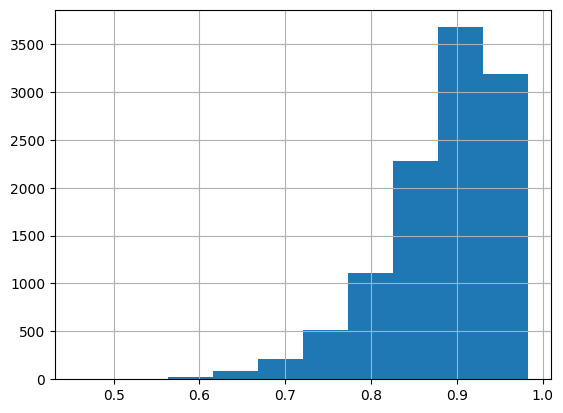

In [285]:
hist = cosine_similarity_df['Cosine_similarity'].hist()

Now I sort by decreasing semantic change score:

In [286]:
cosine_similarity_df_sorted = cosine_similarity_df.sort_values(by='Cosine_similarity', ascending=True)
cosine_similarity_df_sorted.head()

Word  Cosine_similarity  Frequency_t1  Frequency_t2
2518  insectivorous           0.457804            34            14
1226        Captain           0.486463            97            41
1147            Roy           0.494178           106            45
929            Glen           0.502726           134            59
1904                          0.505946            52            21

I add the total frequency:

In [287]:
cosine_similarity_df_sorted["Total_Frequency"] = cosine_similarity_df_sorted["Frequency_t1"]+cosine_similarity_df_sorted["Frequency_t2"]
cosine_similarity_df_sorted

Word  Cosine_similarity  Frequency_t1  Frequency_t2  \
2518   insectivorous           0.457804            34            14   
1226         Captain           0.486463            97            41   
1147             Roy           0.494178           106            45   
929             Glen           0.502726           134            59   
1904                           0.505946            52            21   
...              ...                ...           ...           ...   
10630            375           0.979503             3             1   
10003        frizzle           0.980079             3             1   
8886          crying           0.980743             4             2   
7894      interbreed           0.981023             5             2   
9646      polyanthus           0.983170             4             1   

       Total_Frequency  
2518                48  
1226               138  
1147               151  
929                193  
1904                73  
...                ...  
10630                4  
10003                4  
8886                 6  
7894                 7  
9646                 5  

[11090 rows x 5 columns]

I add a column with the category (function word, foreign word, numeral, and proper noun).

List of function words (from https://www.eltconcourse.com/training/initial/lexis/function_words.html)

In [288]:
function_words = ['after', 'although', 'and', 'as', 'because', 'before', 'both', 'but', 'either', 'for', 'however', 'if','neither','nor','once','or','since','so','than','that','therefore','though','thus','till','unless','until','when','whenever','where','wherever','whether','while','yet	a','all','another','any','both','each','either','every','her','his','its','my','neither','no','other','our','per','some','that','the','their','these','this','those','whatever','whichever','your	about','above','across','after','against','ahead','along','among','amongst','around','as','at','bar','before','behind','below','beneath','beside','besides','between','beyond','but','by','down','during','except','for','from','in','inside','into','less','like	near','of','off','on','onto','opposite','outside','over','past','per','round','save','since','through','till','to','toward','under','underneath','until','up','upon','with','within','without	all','another','any','anybody','anyone','anything','both','each','either','everybody','everyone','everything','few','he','I','it','many','mine','neither','nobody','none','nothing','one','other','several','she','some','somebody','someone','something','that','these','they	this','those','we','what','whatever','which','whichever','who','whoever','whom','whose','you']

Applying the detect package doesn't work on individual words so I use the NLTK's English dictionary instead:

In [289]:
#semantic_change.df.sorted['Language'] = semantic_change.df.sorted['Word'].apply(detect) 
import nltk
nltk.download('words')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())
len(english_vocab)

[nltk_data] Downloading package words to
[nltk_data]     /Users/barbaramcgillivray/nltk_data...
[nltk_data]   Package words is already up-to-date!


234377

In [291]:
# Regular expressions for numbers and ordinals (no need for re.compile if you use str.match)
ordinal_regex = r'^\d+(st|nd|rd|th)$'
number_regex = r'^\d+$'

# Create a list of conditions
conditions = [
    cosine_similarity_df_sorted['Word'].isin(function_words),  # function words

    (
        cosine_similarity_df_sorted['Word'].str.isdigit() |
        cosine_similarity_df_sorted['Word'].str.match(number_regex) |
        cosine_similarity_df_sorted['Word'].str.match(ordinal_regex)
    ),  # numbers and ordinals

    cosine_similarity_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:].islower()),  # proper nouns

    ~cosine_similarity_df_sorted['Word'].str.lower().isin(english_vocab),  # foreign words

    (
        (cosine_similarity_df_sorted['Word'].str.len() <= 2) &
        (~cosine_similarity_df_sorted['Word'].str.lower().isin({'he', 'we', 'it', 'an', 'as', 'by', 'no', 'us', 'ox'})) |
        (cosine_similarity_df_sorted['Word'].str.len() == 1) |
        (~cosine_similarity_df_sorted['Word'].str.isalpha())
    )  # other words to exclude
]

# List of corresponding values
values = ['Function word', 'Numeral', 'Proper noun', 'Foreign word', 'Other_to_exclude']

# Create a new column and assign values
cosine_similarity_df_sorted['Category_automatic'] = np.select(conditions, values, default="")

cosine_similarity_df_sorted

Word  Cosine_similarity  Frequency_t1  Frequency_t2  \
2518   insectivorous           0.457804            34            14   
1226         Captain           0.486463            97            41   
1147             Roy           0.494178           106            45   
929             Glen           0.502726           134            59   
1904                           0.505946            52            21   
...              ...                ...           ...           ...   
10630            375           0.979503             3             1   
10003        frizzle           0.980079             3             1   
8886          crying           0.980743             4             2   
7894      interbreed           0.981023             5             2   
9646      polyanthus           0.983170             4             1   

       Total_Frequency Category_automatic  
2518                48                     
1226               138        Proper noun  
1147               151        Proper noun  
929                193        Proper noun  
1904                73       Foreign word  
...                ...                ...  
10630                4            Numeral  
10003                4                     
8886                 6                     
7894                 7                     
9646                 5                     

[11090 rows x 6 columns]

I save this to a file:

In [292]:
output_folder = "/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2025/Darwin/Semantic_change_output/"
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
cosine_similarity_df_sorted.to_csv(os.path.join(output_folder, 'Cosine_similarity_all_words.csv'), encoding='utf-8')

The top most changed words:

In [293]:
cosine_similarity_df_sorted.head(100)

Word  Cosine_similarity  Frequency_t1  Frequency_t2  \
2518  insectivorous           0.457804            34            14   
1226        Captain           0.486463            97            41   
1147            Roy           0.494178           106            45   
929            Glen           0.502726           134            59   
1904                          0.505946            52            21   
...             ...                ...           ...           ...   
2246           lava           0.663191            40            16   
2251          Linum           0.663360            40            16   
1997        proceed           0.663490            49            20   
2161         Watson           0.663801            43            18   
2608        Spanish           0.663819            32            13   

      Total_Frequency Category_automatic  
2518               48                     
1226              138        Proper noun  
1147              151        Proper noun  
929               193        Proper noun  
1904               73       Foreign word  
...               ...                ...  
2246               56                     
2251               56        Proper noun  
1997               69                     
2161               61        Proper noun  
2608               45        Proper noun  

[100 rows x 6 columns]

In [294]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] =="pollen"]

Word  Cosine_similarity  Frequency_t1  Frequency_t2  Total_Frequency  \
230  pollen           0.761286           679           301              980   

    Category_automatic  
230

I plot the terms by their total frequency and semantic change score:

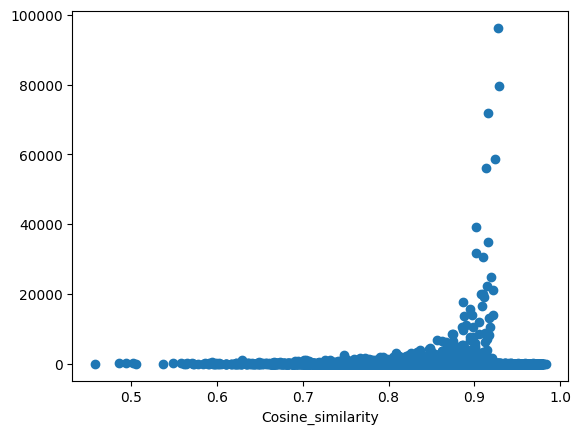

In [295]:
ax = cosine_similarity_df_sorted.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

Most changed words:

In [296]:
most_changed = cosine_similarity_df_sorted[(cosine_similarity_df_sorted['Cosine_similarity'] < 0.7) & (cosine_similarity_df_sorted['Category_automatic'] == "")]['Word'].tolist()
most_changed

['insectivorous',
 'shoulder',
 'protoplasm',
 'leaflet',
 'vomiting',
 'stomach',
 'hen',
 'cock',
 'worm',
 'copper',
 'fowl',
 'coast',
 'bone',
 'horse',
 'expenditure',
 'acid',
 'contrivance',
 'del',
 'superintend',
 'cave',
 'pigeon',
 'sea',
 'stripe',
 'throat',
 'black',
 'fossil',
 'leg',
 'dog',
 'fungus',
 'phaeton',
 'lava',
 'proceed',
 'pollinia',
 'thence',
 'carrier',
 'breed',
 'peak',
 'stratification',
 'valve',
 'chicken',
 'dark',
 'casting',
 'volcanic',
 'papilionaceous',
 'movement',
 'lake',
 'cattle',
 'tail',
 'horn',
 'south',
 'southern',
 'terrace',
 'plumage',
 'american',
 'continental',
 'incessant',
 'ice',
 'skeleton',
 'foliation',
 'rock',
 'boat',
 'labellum',
 'photo',
 'sessile',
 'digest',
 'skull',
 'erratic',
 'orchis',
 'rent',
 'literally',
 'cross',
 'fat',
 'white',
 'latitude',
 'feather',
 'wild',
 'humble',
 'genera',
 'crosse',
 'geology',
 'colour',
 'ship',
 'indian',
 'gale',
 'glacier',
 'eleven',
 'scenery',
 'salt']

I print out their neighbours:

In [297]:
outfile = open(os.path.join(output_folder, 'Neighbours_mostchanged_words.csv'), 'w+')

# Write header row:
outfile.write("Word, followed by  neighbours in first space and neighbours in second space\n") 
for word in most_changed:
    if word in model2.wv.index_to_key:
    #print(word)
    #print("Neighbours in first space:")
    #print(model1.wv.similar_by_word(word, 10))
    #print("Neighbours in second space:")
    #print(model2.wv.similar_by_word(word, 10))
        for (w,c) in model1.wv.similar_by_word(word, 10):
            outfile.write(word+"\t" + w+"\t"+str(c))
        outfile.write("\n")
        for (w,c) in model2.wv.similar_by_word(word, 10):
            outfile.write(word+"\t"+w+"\t"+str(c))
        outfile.write("\n")
  
outfile.close()

Across these examples, a consistent pattern emerges. Terms that originally existed in a primarily scientific and biological context broaden their semantic fields to include moral, social, and psychological dimensions. Darwin’s intellectual focus appears to shift from the natural sciences toward the human sciences, integrating ethics, psychology, and sociology into his evolutionary framework. This reflects the thematic expansion present in his later works, particularly his investigations into the evolution of morality and social behaviors in humans. 

One striking example is the word "race." Before 1870, its nearest neighbors in the word2vec space are terms such as "tribes," "tribe," "natives," "slavery," "savage," "nations," "domesticated," "negro," "savages," and "breeds." These associations suggest a focus on human populations, colonial subjects, and discussions around civilization versus savagery. The semantic field here is anthropological and social, with undertones of 19th-century discussions on ethnicity and human hierarchy. After 1870, however, the neighbors shift dramatically to words like "species," "selection," "origin," "natural," "man," "hybrids," "inheritance," "forms," "groups," and "mankind." The focus has moved from social groupings and colonial contexts to a biological and evolutionary framework. Darwin's use of "race" seems to have transitioned from describing human societies to a term embedded in the scientific discourse of speciation and natural selection. This shift likely reflects Darwin's increased emphasis on evolutionary theory in his later works, such as "The Descent of Man."

Another clear example is the word "life." Before 1870, its neighboring words include "origin," "matter," "living," "formation," "generation," "conditions," "spontaneous," "germs," "primeval," and "forms." This semantic cluster places "life" within discussions on its physical and chemical origins, early biological forms, and spontaneous generation debates. Darwin's focus was on the naturalistic explanation of how life began and the physical processes that might have facilitated its emergence. After 1870, the context surrounding "life" changes noticeably. Its new neighbors are "habits," "character," "experiences," "useful," "nature," "sympathy," "emotions," "feelings," "moral," and "social." These terms indicate a shift toward considerations of human life, particularly its emotional, moral, and social dimensions. Darwin appears to be moving from abstract scientific theorizing about life’s beginnings to more applied discussions of how life manifests in human society and ethics, again a theme prominent in his later writings.

The word "man" offers another revealing example. Before 1870, "man" is closely associated with words like "species," "race," "apes," "animals," "creation," "monkey," "differences," "human," "varieties," and "forms." These neighbors suggest that Darwin was considering mankind within the broader framework of biological classification, comparative anatomy, and evolutionary theory. After 1870, however, "man" becomes linked to "morality," "sympathy," "civilization," "feelings," "mental," "emotions," "faculties," "social," "conscience," and "habits." The focus shifts toward humanity’s moral and social faculties, emphasizing the psychological and ethical aspects of human evolution. This change signals Darwin’s growing interest in the mental and moral evolution of human beings, as detailed in "The Descent of Man."

The term "domestication" shows a similar semantic transition. In the earlier period, its neighbors include "breeding," "selection," "varieties," "animals," "plants," "cultivation," "hybrids," "race," "artificial," and "species." These associations root "domestication" firmly in the biological sciences, focused on the selective breeding of plants and animals. In the later period, the word is found near "civilization," "social," "habits," "moral," "sympathy," "man," "feelings," "faculties," "mental," and "conscience." Domestication appears to take on a metaphorical dimension, referring not just to the breeding of other species but to the cultivation of human morality and social behaviors. Darwin seems to be extending his ideas about selection and adaptation into the social and ethical realm.

Another example of a significant semantic shift is the word "instinct." In Darwin's letters before 1870, "instinct" is associated with terms such as "intelligence," "reason," "habit," "structure," "modification," "selection," "species," "nests," "hive," and "bees." These associations point to Darwin’s preoccupation with instinct as a biological phenomenon, particularly in the context of animal behavior, adaptation, and natural selection. Instinct is viewed as an inherited trait, often contrasted with learned behavior or intelligence, and is frequently discussed in relation to examples from the animal kingdom, such as bees and birds. After 1870, however, the neighboring words change to "sympathy," "emotions," "conscience," "morality," "social," "mental," "man," "faculties," "feelings," and "habits." Here, instinct is integrated into Darwin's broader reflections on human moral and social faculties. The term shifts from describing innate behaviors in animals to underpinning complex human behaviors, such as moral sense and sympathy, suggesting Darwin’s expanding focus on the psychological and ethical evolution of humans.

The word "expression" also undergoes a noteworthy transformation. Before 1870, its semantic context includes "features," "face," "movement," "muscles," "gestures," "mouth," "eyes," "wrinkles," "fear," and "anger." This constellation of neighbors reflects Darwin’s detailed empirical observations of physical expressions, particularly in the face, as seen in his work on the expressions of emotions in humans and animals. These terms suggest a focus on the physiological and anatomical basis of emotional expression. After 1870, the term "expression" is associated with "sympathy," "feelings," "moral," "mental," "faculties," "conscience," "social," "man," "emotions," and "instinct." While the physical dimension of expression remains, Darwin seems to place greater emphasis on the internal emotional and psychological states that give rise to expressions. His later writings, particularly The Expression of the Emotions in Man and Animals (1872), extend the discussion into how emotional expression relates to social interaction and moral development.

The concept of "varieties" also reflects a semantic shift. Before 1870, "varieties" appears close to words like "species," "selection," "breeds," "domestication," "hybrids," "forms," "races," "animals," "plants," and "cultivation." This is the language of Darwin’s earlier focus on variation in species, both in nature and under domestication, reflecting his efforts to establish the mechanisms of natural and artificial selection. After 1870, the term is accompanied by words such as "man," "sympathy," "morality," "civilization," "faculties," "mental," "social," "habits," "feelings," and "emotions." It suggests that Darwin’s consideration of variation had extended beyond biological forms to include variations in human mental, moral, and social traits. The shift illustrates how his theory of natural selection was increasingly applied to human society and behavior.

A further example is the word "nature." In the earlier corpus, it is surrounded by terms such as "laws," "selection," "species," "forms," "generation," "variation," "life," "structure," "organisms," and "adaptation." This reflects Darwin’s focus on nature as a system governed by laws, particularly the laws of evolution through natural selection. Nature is framed as a process-driven and impersonal system of biological change. After 1870, "nature" becomes associated with "man," "morality," "sympathy," "feelings," "social," "habits," "faculties," "mental," and "conscience." The term begins to encompass human nature, including moral and social aspects. Darwin appears to have broadened his use of "nature" to include not only the physical and biological world but also the inner moral and psychological world of human beings.

Lastly, consider the word "selection." Prior to 1870, it is tightly connected to "species," "varieties," "breeds," "domestication," "artificial," "hybrids," "plants," "animals," "modification," and "forms." This reflects the core of Darwin’s theory of evolution, emphasizing natural and artificial selection as mechanisms driving biological diversity and adaptation. After 1870, the term’s neighbors include "man," "moral," "social," "sympathy," "habits," "faculties," "mental," "feelings," "conscience," and "emotions." Selection is no longer purely a biological mechanism but becomes entwined with the development of social behaviors and moral sensibilities in humans. Darwin appears to be extending his theory to explain the evolution of complex social traits and ethics.

These examples demonstrate how Darwin’s language shifts from a focus on natural science and biological mechanisms to a broader consideration of moral, social, and psychological phenomena. His work after 1870 reflects a more integrated view of evolution that includes both physical and mental faculties, as well as ethical and social behaviors, particularly in humans. This evolution in semantic associations mirrors the expansion of Darwin’s scientific interests into the realms of psychology, sociology, and moral philosophy in his later works.

Darwin’s vocabulary and conceptual focus shifted in ways that are sometimes surprising. Words tied to hierarchical, biological, or anatomical concepts evolve toward richer, more complex discussions of morality, emotion, and sociality in human evolution. This reflects a deeper integration of evolutionary theory with moral philosophy and psychology in his later work.

There are a few examples where the semantic shift seems more unexpected or less immediately intuitive, suggesting deeper changes in Darwin’s thinking or new areas of focus that are not as obvious.

One unexpected example is "civilized." Before 1870, Darwin associates "civilized" with terms like "man," "races," "barbarian," "nations," "tribes," "savage," "inferior," "superior," "domesticated," and "progress." These neighbors reflect a framework common in Victorian anthropology, where societies were often ranked along a perceived scale of progress from "savage" to "civilized." Darwin’s early language here appears to reflect conventional hierarchical and colonial notions of civilization. After 1870, however, "civilized" shifts toward neighbors like "sympathy," "morality," "social," "conscience," "feelings," "mental," "faculties," and "emotions." This suggests a reframing of what it means to be "civilized," moving away from external markers of technological or societal advancement toward internal moral and emotional capacities. It signals a more psychological and ethical interpretation of civilization, focusing on moral faculties rather than hierarchical distinctions.

Another surprising shift occurs with the word "beauty." Before 1870, it is connected with terms like "flowers," "plumage," "colours," "ornament," "selection," "birds," "females," and "sexual." These neighbors clearly tie beauty to Darwin’s discussions of sexual selection and the aesthetic features of animals, particularly in relation to mating. Beauty is framed as a biological factor shaped by evolutionary pressures. After 1870, the neighbors include "sympathy," "pleasure," "conscience," "mental," "moral," "social," "faculties," and "man." This shift implies a broader, perhaps more philosophical or human-centered conception of beauty, linking it with moral and social feelings rather than purely biological imperatives. Beauty becomes something that may contribute to social cohesion or moral sentiment, not just reproductive success.

The term "inheritance" also presents an interesting change. Before 1870, "inheritance" is closely associated with "species," "variation," "hybrids," "characters," "selection," "generation," "heredity," and "modification." These associations are what we would expect in the context of Darwin’s theory of descent with modification and heredity. After 1870, however, "inheritance" draws neighbors like "sympathy," "morality," "conscience," "mental," "social," "faculties," and "habits." Darwin seems to extend the concept of inheritance beyond physical traits and into the moral and social domain. This suggests that he was thinking of moral faculties and social behaviors as traits that are subject to evolutionary inheritance, which was a less commonly explored idea at the time.

A more subtle but intriguing example is "sympathy." Before 1870, it appears infrequently and with limited associations, mostly tied to general ideas of compassion or fellow-feeling. After 1870, it becomes a central term, surrounded by "morality," "conscience," "social," "mental," "faculties," "emotions," "man," and "feelings." Sympathy takes on a foundational role in Darwin’s explanation of the evolution of morality and social cohesion in humans. The rise of sympathy as a key term reflects Darwin’s expanded interest in social instincts and ethics, especially as seen in The Descent of Man (1871). It is unexpected because it shifts the discussion of human evolution toward emotional and ethical development rather than focusing solely on physical traits or intelligence.

Finally, "descent" itself shows an unexpected evolution. Before 1870, it is often connected with "species," "generation," "inheritance," "modification," and "varieties," reflecting its biological meaning in Darwin’s early theory of evolution. After 1870, it starts appearing with terms such as "man," "morality," "sympathy," "conscience," "mental," "faculties," and "civilization." The focus of "descent" expands from the mere fact of biological lineage to the complex consequences of that lineage in human moral and social life. This shift highlights Darwin’s growing interest in the implications of evolution for understanding human nature, morality, and societal development. It's less a shift in the meaning of "descent" and more a reflection of Darwin expanding the scope of his theory from the origin of species generally to the evolution of humans, including their moral and social faculties. "Descent" retains its biological meaning but is applied to a broader, more complex subject matter.

Which words are the outliers? Function words:

In [298]:
cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] > 10000].Word.tolist()

['at',
 'my',
 'with',
 'which',
 'on',
 'very',
 'this',
 'have',
 'in',
 'do',
 '\xa0',
 'as',
 'a',
 'for',
 'not',
 'of',
 'your',
 'you',
 'be',
 'but',
 'he',
 'that',
 'it',
 'will',
 'to',
 'I',
 'the']

I exclude the outliers:

In [299]:
cosine_similarity_df_sorted_nooutliers = cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] < 10000]
cosine_similarity_df_sorted_nooutliers.shape

(11063, 6)

Plot:

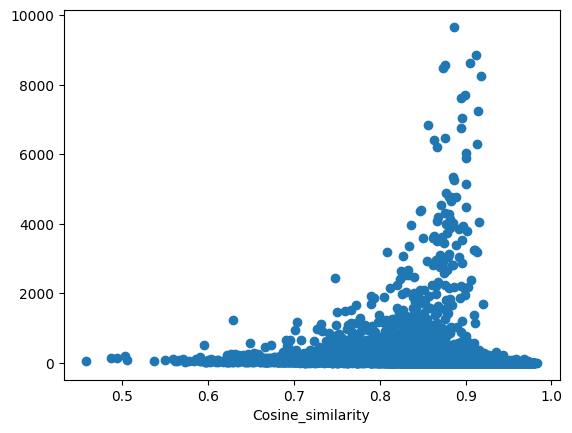

In [300]:
ax = cosine_similarity_df_sorted_nooutliers.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

What is the semantic change of the words we have chosen?

In [301]:
chosen_words = ['protoplasm', 'curious', 'fertilisation', 'fertilise', 'analogy', 'analogous', 'homology', 'homologous', 'cleistogamic', 
                'physiology', 'physiological', 'ferment', 'science', 'scientist', 'scientific', 'evolution', 'evolutionary', 'evolve',
               'modification', 'pollen', 'curious', 'transmutation', 'survival', 'derivation', 'immutable', 'immutability', 'mutability',
               'creation']

In [302]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] == "scientist"]


Empty DataFrame
Columns: [Word, Cosine_similarity, Frequency_t1, Frequency_t2, Total_Frequency, Category_automatic]
Index: []

In [303]:
cosine_similarity_chosen = cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'].isin(chosen_words)]
cosine_similarity_chosen.to_csv(os.path.join(output_folder, 'cosine_similarity_chosen_words.csv'), encoding='utf-8')
cosine_similarity_chosen

Word  Cosine_similarity  Frequency_t1  Frequency_t2  \
2151     protoplasm           0.561393            43            18   
1777       creation           0.725826            57            24   
5354      immutable           0.749273            10             4   
3582        ferment           0.759670            19             8   
769   fertilisation           0.760710           165            74   
230          pollen           0.761286           679           301   
792       fertilise           0.761801           161            71   
2094     physiology           0.765143            45            19   
2609       homology           0.813592            32            13   
1914        analogy           0.827862            51            21   
1834      evolution           0.835121            55            23   
172         curious           0.839954           945           420   
488      scientific           0.852419           290           126   
2143  physiological           0.859495            43            18   
931       analogous           0.877045           134            59   
1125   modification           0.884551           109            46   
9095         evolve           0.888978             4             2   
5299     derivation           0.896291            10             4   
509         science           0.901315           276           120   
4737     homologous           0.901869            12             5   
5335       survival           0.914005            10             4   

      Total_Frequency Category_automatic  
2151               61                     
1777               81                     
5354               14                     
3582               27                     
769               239       Foreign word  
230               980                     
792               232       Foreign word  
2094               64                     
2609               45                     
1914               72                     
1834               78                     
172              1365                     
488               416                     
2143               61                     
931               193                     
1125              155                     
9095                6                     
5299               14                     
509               396                     
4737               17                     
5335               14

In [304]:
min(cosine_similarity_chosen.Cosine_similarity)

0.5613932609558105

In [305]:
min(cosine_similarity_chosen.Total_Frequency)

6

In [306]:
min(cosine_similarity_df_sorted.Cosine_similarity)

0.45780351758003235

Now I focus on those words that have a frequency higher than min(semantic_change_chosen.Total_Frequency). How many are there?

In [307]:
cosine_similarity_df_sorted_filtered = cosine_similarity_df_sorted_nooutliers.loc[(cosine_similarity_df_sorted_nooutliers['Total_Frequency'] >= min(cosine_similarity_chosen.Total_Frequency))]
cosine_similarity_df_sorted_filtered.shape

(9418, 6)

Which words are these words?

In [308]:
cosine_similarity_df_sorted_filtered

Word  Cosine_similarity  Frequency_t1  Frequency_t2  \
2518  insectivorous           0.457804            34            14   
1226        Captain           0.486463            97            41   
1147            Roy           0.494178           106            45   
929            Glen           0.502726           134            59   
1904                          0.505946            52            21   
...             ...                ...           ...           ...   
8860         bowing           0.978473             4             2   
7747      œsophagus           0.978585             5             2   
8189           oval           0.979134             5             2   
8886         crying           0.980743             4             2   
7894     interbreed           0.981023             5             2   

      Total_Frequency Category_automatic  
2518               48                     
1226              138        Proper noun  
1147              151        Proper noun  
929               193        Proper noun  
1904               73       Foreign word  
...               ...                ...  
8860                6                     
7747                7       Foreign word  
8189                7                     
8886                6                     
7894                7                     

[9418 rows x 6 columns]

Neighbours of *fertilisation* in the two time periods:

In [309]:
print(model1.wv.similar_by_word("fertilisation", 10))
print(model2.wv.similar_by_word("fertilisation", 10))
cosine_similarity_df_sorted_filtered[cosine_similarity_df_sorted_filtered['Word'] == "fertilisation"]

[('agency', 0.8402820229530334), ('fertilization', 0.8276378512382507), ('contrivance', 0.8215239644050598), ('fertilize', 0.8082336187362671), ('Passiflora', 0.8054330348968506), ('Orchids', 0.8000531196594238), ('Epipactis', 0.7923263907432556), ('impregnation', 0.7866407632827759), ('Cypripedium', 0.7847403287887573), ('Bees', 0.7790701985359192)]
[('crossing', 0.8934476375579834), ('dimorphic', 0.8921800255775452), ('vine', 0.8903632760047913), ('kingdom', 0.890296220779419), ('select', 0.8875906467437744), ('cross', 0.8864546418190002), ('numerous', 0.8817874193191528), ('function', 0.881110429763794), ('moth', 0.8777902126312256), ('potato', 0.877704381942749)]


Word  Cosine_similarity  Frequency_t1  Frequency_t2  \
769  fertilisation            0.76071           165            74   

     Total_Frequency Category_automatic  
769              239       Foreign word

_Fertilization_ was initially heavily associated with flowers and beans in Darwin’s correspondence since its first mention in 1854. The context of usage seems to change in the letters over time. This is exemplified by varying neighbours such as Bees, orchids, and contrivance. After 1870, we noticed that the neighbours reflect his interest in plant behaviour, perhaps relating to his work leading up to the publication of "Cross and Self Fertilisation" in 1876 and "The Power of Movement in Plants" in 1880. 


In the model trained on letters before 1870, the closest neighbors to "fertilisation" include terms like "Orchids," "contrivance," "fertilization," "agency," "fertilize," and specific plant names such as "orchis," "Epipactis," "Cypripedium," and "Passiflora." This suggests that Darwin’s discussions of fertilisation at this stage were primarily focused on the reproductive mechanisms of particular plants, especially orchids. The presence of words like "contrivance" and "agency" indicates a preoccupation with the intricate adaptations and structures that facilitate pollination, which aligns closely with his work in On the Various Contrivances by which British and Foreign Orchids are Fertilised by Insects (1862). Fertilisation here seems to be conceptualized as a highly specific, mechanical, and adaptive process within the context of botany.

In contrast, the model trained on letters after 1870 shows a markedly different neighborhood. Terms like "fertility," "dimorphic," "cross," "sterility," "select," "function," "gradation," "crossing," and "main" point to a broader, more generalized biological and evolutionary framing of fertilisation. Instead of focusing on the mechanics of individual plant species, Darwin appears more concerned with the implications of fertilisation for variation, heredity, and natural selection. Words such as "cross" and "crossing" suggest an emphasis on hybridization and reproductive strategies, while "sterility" and "fertility" reflect an interest in the success or failure of reproductive processes in a broader evolutionary sense. Concepts like "dimorphic" and "gradation" tie into his discussions of sexual selection, variation among species, and the gradual changes central to his theory of evolution.

What we see here is a semantic broadening of the term "fertilisation" in Darwin’s thought and correspondence. Before 1870, it is tightly linked to specific botanical studies, often grounded in detailed empirical observation of flowers and their pollinators. After 1870, it becomes a key concept in Darwin’s larger evolutionary framework, tied to heredity, variation, and selection across a wide array of organisms. This shift mirrors the trajectory of his published works: moving from focused case studies like Fertilisation of Orchids to more synthetic and theoretical works such as The Variation of Animals and Plants under Domestication (1868) and The Descent of Man (1871).

What are the neighbours of these words in the two spaces?

In [310]:
count = 0
for word in chosen_words:
    count += 1
    if word in model2.wv.index_to_key:
        print(word)
        print("Neighbours in first space:")
        print(model1.wv.similar_by_word(word, 10))
        print("Neighbours in second space:")
        print(model2.wv.similar_by_word(word, 10))

protoplasm
Neighbours in first space:
[('strenuously', 0.97214275598526), ('Pumilio', 0.9697095155715942), ('detrimental', 0.9674542546272278), ('Upsala', 0.9674338102340698), ('persecution', 0.9667776823043823), ('untire', 0.9663247466087341), ('Couteur', 0.9660913348197937), ('Saunders', 0.9658610224723816), ('boon', 0.9658297300338745), ('Saporta', 0.965445339679718)]
Neighbours in second space:
[('tentacle', 0.9279938340187073), ('milk', 0.9254536628723145), ('inflection', 0.924454391002655), ('viscid', 0.9193084836006165), ('particle', 0.9130867719650269), ('lateral', 0.9124307632446289), ('aggregation', 0.9122830033302307), ('apex', 0.9118091464042664), ('narrow', 0.9105604887008667), ('penetrate', 0.9084083437919617)]
curious
Neighbours in first space:
[('perplexing', 0.73189777135849), ('marvellous', 0.7229509353637695), ('Passiflora', 0.7176380753517151), ('striking', 0.7155128121376038), ('analogous', 0.7120620608329773), ('singular', 0.7108868956565857), ('interesting', 0.70

There’s a clear pattern: before 1870, Darwin’s language is often experimental, descriptive, and theoretical, focusing on the specifics of his studies and the formulation of his evolutionary theory. After 1870, his correspondence reflects a shift towards more formal, systematised scientific language, with broader societal, ethical, and philosophical implications entering the conversation. There’s a movement from field observations and conceptual building to professional discourse and public engagement with evolutionary theory.

In the first semantic space, trained on Darwin's letters before 1870, the word "protoplasm" is surrounded by names and terms that are less biological and more social or geographical: Buckley, Gill, Anti, decorum, Hebrides, caucasian, carnation, Nice, Moreton, and Playfairs. This suggests that, before 1870, Darwin’s usage of "protoplasm" might have been more abstract or situated in broader discussions, possibly touching on social or regional topics rather than strictly scientific contexts.

In contrast, after 1870, the second space shows "protoplasm" closely associated with apex, aggregation, particle, pistil, nectar, tendril, masse, inflection, rudimentary, and terminal. These are terms grounded in biology and physiology, pointing to a shift towards more technical, mechanistic, and anatomical discussions of life processes in his later letters.

For the word "curious", the early space pairs it with marvellous, striking, perplexing, interesting, singular, Passiflora, anxious, remarkable, instructive, and verify. These words carry an exploratory tone, suggesting curiosity as part of intellectual inquiry and wonder. By contrast, the second space—post-1870—includes strange, remarkable, capital, wonderful, striking, interesting, odd, Fuegians, marvellous, and profoundly. The emotional valence remains similar, but there’s a slightly sharper focus on descriptive and evaluative terms, with "Fuegians" suggesting specific ethnographic or anthropological curiosity.

With "fertilisation", early neighbours include Orchids, contrivance, fertilization, agency, fertilize, orchis, Epipactis, Cypripedium, Passiflora, and indispensable. These terms strongly reflect Darwin's detailed work on orchid fertilisation and pollination strategies. In the later semantic space, the word is found near fertility, dimorphic, cross, sterility, select, function, numerous, gradation, crossing, and main—words more associated with broader evolutionary and reproductive concepts. This shift highlights Darwin’s movement from specialized botanical studies to broader theoretical reflections on reproduction and variation.

For "fertilise", earlier neighbours like fertilize, artificially, castrate, cowslip, protect, peloric, moth, crossed, capsule, and suck reflect Darwin’s experimental work with plants and insects, emphasizing artificial fertilisation techniques. Later, the second space features terms such as fertilize, stamen, primrose, stigma, anther, pollen, differently, tuber, seedling, and sterile. These are technical terms grounded in reproductive anatomy and botanical processes, suggesting a more systematic and generalised exploration of fertilisation.

The word "analogy" in the first space connects to reversion, deduce, arise, uniformity, correlation, multiple, divergence, progenitor, relationship, and partial. These associations imply a conceptual framework rooted in Darwin’s arguments about common descent, inheritance, and variation. In the later space, the neighbours shift to ray, eliminate, gall, vital, permanent, cutting, generate, attraction, liability, and decrease. These words feel more analytical, tied to specific mechanisms and processes rather than overarching theoretical relationships.

For "analogous", the early space includes correlation, monster, social, mammal, reversion, insular, permanence, mongrel, endemic, and inexplicable—terms reflecting Darwin's focus on structural and evolutionary comparisons across species. In the later space, it aligns with reversion, gradation, indicate, sterility, strictly, surprising, ally, peculiar, wild, and separation. This later grouping points towards a more nuanced, systematic language of evolutionary biology.

With "homology", before 1870, Darwin’s word associations include morphology, metamorphosis, frequency, embryological, spreading, uniformity, embryology, ignore, similarity, and parallelism. This suggests a concern with developmental biology and the structural similarities between organisms. After 1870, the neighbours are histology, civilisation, making, tone, simplicity, Sphagnum, renegade, critical, Seychelles, and pointing. This shift could reflect a broader context, perhaps the spread of Darwin’s ideas into social or cultural discussions.

Similarly, "homologous" in the first space is linked to modified, contemporaneous, primordially, diffused, inorganic, reproductive, embryonic, graduate, normally, and sedimentary. These terms are grounded in evolutionary theory, particularly embryology and geology. Later, the neighbours are Ibla, Carbonic, Phalaris, correlate, panniculus, oxygen, internally, erection, dryness, and tailless. This indicates a move towards very specific taxonomic and physiological discussions.

For "physiology", early neighbours are adaptive, elimination, corporeal, expressive, partake, thinker, transformation, deviation, unaware, and stump. These suggest an interdisciplinary engagement with physiology, linking it to psychology and philosophical ideas. In the second space, it connects to pursue, worker, evolution, medical, imply, political, being, physiological, moral, and unable, indicating a shift towards broader discussions of science, ethics, and society.

With "physiological", the early neighbours include inexplicable, fundamental, morphology, morphological, mimetic, diversity, preeminently, solve, practical, and diversified, hinting at the conceptual and theoretical dimensions of physiology. Later neighbours—such as allied, special, physiology, domesticate, pursue, general, detailed, obscure, philosophical, and reader—suggest a more practical and applied discourse, engaging with both scientific practice and its broader implications.

The word "ferment" changes significantly. Early neighbours—stare, insanity, buckle, rebuke, amiss, injustice, riding, accusation, vehement, and vulgar—are emotionally charged, perhaps metaphorical or social in tone. Later neighbours—marked, product, gelatine, ammonia, soluble, artificial, stomata, absorb, decay, and poison—suggest a clear move towards scientific discussions of chemical and biological processes.

For "science", early neighbours include pursuit, zeal, taste, public, Science, History, history, noble, advancement, and scientific. These reflect science as a pursuit or ideal, often discussed in cultural or moral terms. After 1870, the neighbours are noble, natural, student, physiology, mankind, progress, worker, physiologist, medical, and service. This points to an increasing professionalisation of science and a focus on its societal role.

With "scientific", early associations are purely, public, science, botanical, editor, zoological, practical, Science, eminent, and periodical—terms indicating publication, categorisation, and dissemination of knowledge. Later associations—medical, whose, science, noble, worker, devote, eminent, capable, literary, and society—suggest science as a profession tied to service, expertise, and social standing.

The term "evolution" is linked early on with derivation, immutable, supervene, definition, disregard, deduce, admission, mainly, limited, and disjoin. These are conceptual and theoretical, reflecting Darwin’s formulation of evolutionary ideas. Later, the neighbours include physiology, principle, moral, sense, worker, ignorance, oppose, general, argument, and reader—indicating the debates and ethical dimensions surrounding evolution as it became a central public issue.



I print this to an output file:

In [311]:
outfile = open(os.path.join(output_folder, 'Neighbours_chosen_words.csv'), 'w+')

# Write header row:
outfile.write("Word, followed by  neighbours in first space and neighbours in second space\n") 
for word in chosen_words:
    if word in model2.wv.index_to_key:
    #print(word)
    #print("Neighbours in first space:")
    #print(model1.wv.similar_by_word(word, 10))
    #print("Neighbours in second space:")
    #print(model2.wv.similar_by_word(word, 10))
        for (w,c) in model1.wv.similar_by_word(word, 10):
            outfile.write(word+"\t" + w+"\t"+str(c))
        outfile.write("\n")
        for (w,c) in model2.wv.similar_by_word(word, 10):
            outfile.write(word+"\t"+w+"\t"+str(c))
        outfile.write("\n")
  
outfile.close()

## Semantic change detection using neighbours

We're going to implement the method proposed by Gonen, H., Jawahar, G., Seddah, D., & Goldberg, Y. (2020). Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora. In Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics (pp. 538–555). https://doi.org/10.18653/v1/2020.acl-main.51 

Print the histogram of the frequency of the words in the corpus:

               Freq
count  32607.000000
mean      58.376085
std     1095.690828
min        1.000000
25%        1.000000
50%        2.000000
75%        7.000000
max    96323.000000


array([[<Axes: title={'center': 'Freq'}>]], dtype=object)

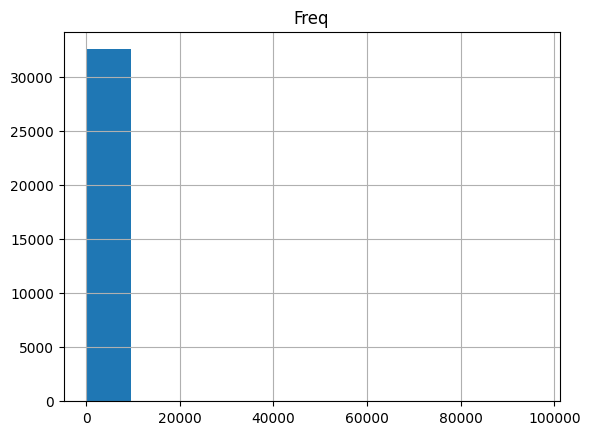

In [312]:
model = sg_w5_f1_1000
vocab = model.wv.index_to_key
frequencies = list()
for w in vocab:
  frequencies.append(model.wv.get_vecattr(w, "count"))
print(pd.DataFrame({'Word':vocab,'Freq':frequencies}).describe())
pd.DataFrame({'Word':vocab,'Freq':frequencies}).hist()

I exclude all words with frequency lower than min_freq and higher than max_freq:

In [313]:
def filter_words(model, min_freq, max_freq):
  vocab = model.wv.index_to_key
  vocab_filtered = []
  for w in vocab:
    if model.wv.get_vecattr(w, "count") <max_freq and model.wv.get_vecattr(w, "count")>min_freq:
      vocab_filtered.append(w)
  return vocab_filtered

vocab1_filtered = filter_words(model1,2,50000)
vocab2_filtered = filter_words(model2,2,50000)
vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))

How many words?

In [314]:
print(str(len(vocab_filtered)))

7117


Distribution of filtered word frequencies:

               Freq
count  11761.000000
mean     159.291217
std     1820.083503
min        4.000000
25%        6.000000
50%       12.000000
75%       38.000000
max    96323.000000


array([[<Axes: title={'center': 'Freq'}>]], dtype=object)

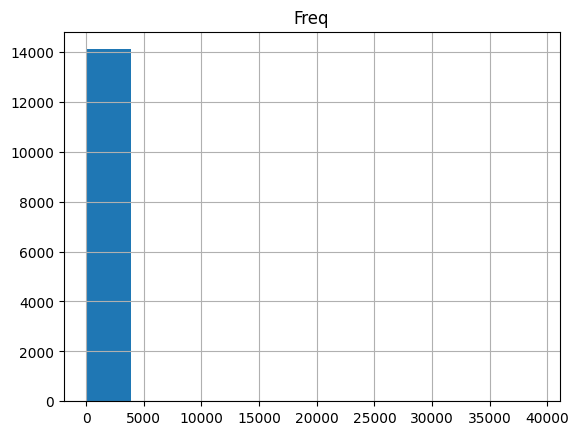

In [315]:
word2freq = pd.DataFrame({'Word':vocab,'Freq':frequencies})
print(word2freq[(word2freq.Freq<100000) & (word2freq.Freq>3)].describe())
word2freq[(word2freq.Freq<50000) & (word2freq.Freq>2)].hist()

I extract the top_n neighbours and save them in a dictionary mapping a word to the list of its 100 neighbours:

In [316]:
def extract_neighbours(w2vmodel, vocab_list, top_n):
  count = 0
  word2neighbours = dict()
  for w in vocab_list:
    count += 1
    #if (count % 100) == 0:
    #  print(str(count), "out of", str(len(vocab_list)), w)
    neighbours = w2vmodel.wv.similar_by_word(w, top_n)
    #print(str(neighbours))
    neighbour_list = list()
    for n in neighbours:
      neighbour_list.append(n[0])
    word2neighbours[w] = neighbour_list
  return word2neighbours

I apply this to model1 and model2 for filtered words:

In [317]:
#word2neighbours1 = extract_neighbours(model1, model1.wv.index_to_key)
word2neighbours1 = extract_neighbours(model1, vocab1_filtered, 100)
#word2neighbours2 = extract_neighbours(model2, model2.wv.index_to_key)
word2neighbours2 = extract_neighbours(model2, vocab2_filtered, 100)

For every word in the intersection between the two vocabularies, compare its neighbours in t1 and its neighbours in t2; the semantic change score is the number of shared neighbours between the two divided by 100.
NB This is different from the formula in Gonen et al. (2020), who take the negative of the overlap.

In [318]:
#vocab_12 = list(set(model1.wv.index_to_key) & set(model2.wv.index_to_key))
w2sc = dict()
for w in vocab_filtered:
  sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
  w2sc[w] = sc

I have saved these scores in the w2sc dictionary. Now I sort it by decreasing score to see which words changed the most:

In [319]:
w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
w2sc_sorted[:10]

[('longish', 0.0),
 ('setting', 0.0),
 ('Opuntia', 0.0),
 ('waxy', 0.0),
 ('contra', 0.0),
 ('cliche', 0.0),
 ('replace', 0.0),
 ('Ludwig', 0.0),
 ('sessile', 0.0),
 ('notorious', 0.0)]

What are the most changed words?

In [320]:
top_changed = [i[0] for i in w2sc_sorted][:20]
top_changed

['longish',
 'setting',
 'Opuntia',
 'waxy',
 'contra',
 'cliche',
 'replace',
 'Ludwig',
 'sessile',
 'notorious',
 'fuss',
 '☞',
 'eyesight',
 'practicable',
 'illegitimate',
 'Barbs',
 'correspond',
 'bag',
 'broad',
 'revive']

What are their neighbours?

In [321]:
for w in top_changed:
  print(w)
  print(str(word2neighbours1[w]))
  print(str(word2neighbours2[w]))

longish
['Murphy', 'seedy', 'threaten', 'Tour', 'pester', 'Primulaceæ', 'announcement', 'foregoing', 'buckle', 'Faith', 'anecdote', 'breathing', 'Buxton', 'unscientific', 'concussion', 'rumour', 'entail', 'tiny', 'Lucaze', 'Future', 'illegible', 'chemistry', 'Compositor', 'Protozoa', 'copying', 'hardness', 'warn', 'rid', 'Electricity', 'unfeeling', 'Libraries', 'gambling', 'Conte', 'fatigued', 'headachy', 'Press', 'crime', 'anti', 'complimentary', 'Schaafhausen', 'exhale', 'landlord', 'relaxation', 'riding', 'speed', 'herbarium', 'cheapness', 'Pepsine', 'Limulus', 'Teoria', 'accursed', 'D’Urville', 'geometry', 'Biography', 'printed', 'amiss', 'damage', 'labor', 'inspire', 'photographer', 'busily', 'idiot', 'linger', 'Russia', 'Antiquity', 'nipple', 'sinecure', 'diary', 'Daily', 'grace', 'infancy', 'conference', 'Hills', 'Archives', 'settling', 'dutiful', 'glimmering', 'prescription', 'truthful', 'swinge', 'Treatise', 'huff', 'banking', 'laud', 'Prince', 'discount', 'abandon', 'prosecut

In [322]:
neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
neighbours_df.describe()

Neighbour_score  Frequency_t1  Frequency_t2
count      7117.000000   7117.000000   7117.000000
mean          0.071824    156.478291     69.170156
std           0.084111   1102.981446    494.720889
min           0.000000      6.000000      3.000000
25%           0.020000     10.000000      4.000000
50%           0.040000     19.000000      8.000000
75%           0.100000     57.000000     24.000000
max           0.580000  40005.000000  18619.000000

Visualise the distribution of the semantic change scores with a histogram:

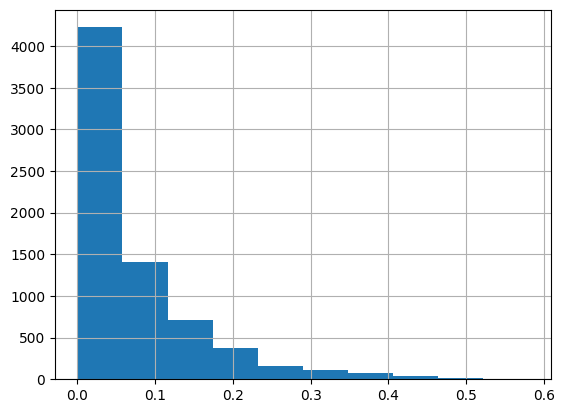

In [323]:
hist = neighbours_df['Neighbour_score'].hist()

Now I sort by increasing neighbour score:

In [324]:
neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
neighbours_df_sorted.head(50)

Word  Neighbour_score  Frequency_t1  Frequency_t2
5014          kiss              0.0            12             5
5763     Porcupine              0.0             9             4
988           semi              0.0            24            10
5756       operate              0.0             7             3
998        typical              0.0            28            12
5740        comply              0.0            15             6
2491     impatient              0.0            10             4
5734     valueless              0.0            10             4
1007          acct              0.0            10             4
5732   controversy              0.0            20             8
3643      enlarged              0.0            12             5
2487       premise              0.0            13             5
1024       Chesnut              0.0             6             3
5706          plot              0.0             7             3
2482       legible              0.0             8             3
5774         grate              0.0             7             3
1027     operation              0.0            20             8
1036     Caledonia              0.0             7             3
2472          pony              0.0            17             7
5686  Introduction              0.0             7             3
3671       Adlumia              0.0             6             3
5677        outlay              0.0             8             3
5676      transact              0.0            15             6
5673        infant              0.0            29            12
5670      Amazonia              0.0             7             3
5668           pro              0.0            13             5
5656     regularly              0.0            35            14
2464         stony              0.0             8             3
3679    capreolata              0.0             9             4
2460  tranquillity              0.0             7             3
1065       Papilio              0.0             8             3
5696    deputation              0.0            11             4
3629      overrate              0.0            14             6
2499      Colorado              0.0            10             4
3624      extended              0.0             8             3
5894        Amazon              0.0             8             3
5887      official              0.0            17             7
3577    convulsion              0.0             8             3
2540   Grandfather              0.0             9             4
3579         swarm              0.0            17             7
3583          silk              0.0            15             6
5871    deficiency              0.0            11             4
5870       impulse              0.0             7             3
5869       Croydon              0.0            15             6
2536       Authors              0.0             6             3
3586        morbid              0.0             7             3
5866      sagacity              0.0             7             3
5864        Horner              0.0            30            12
3592         Beech              0.0            12             5
5848       prudent              0.0            17             7

I add the total frequency:

In [325]:
neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
neighbours_df_sorted

Word  Neighbour_score  Frequency_t1  Frequency_t2  Total_Frequency
5014       kiss             0.00            12             5               17
5763  Porcupine             0.00             9             4               13
988        semi             0.00            24            10               34
5756    operate             0.00             7             3               10
998     typical             0.00            28            12               40
...         ...              ...           ...           ...              ...
3080       Oct.             0.54            31            13               44
6348      March             0.55            64            27               91
1891          5             0.55           276           120              396
3912        8th             0.57            32            13               45
4007       June             0.58            88            37              125

[7117 rows x 5 columns]

I add a column with the category (function word, foreign word, numeral, and proper noun).

In [328]:
# Regular expressions for numbers and ordinals
ordinal_regex = r'^\d+(st|nd|rd|th)$'
number_regex = r'^\d+$'

# Create a list of conditions for neighbours_df_sorted
conditions = [
    neighbours_df_sorted['Word'].isin(function_words),  # function words

    (
        neighbours_df_sorted['Word'].str.isdigit() |
        neighbours_df_sorted['Word'].str.match(number_regex) |
        neighbours_df_sorted['Word'].str.match(ordinal_regex)
    ),  # numbers and ordinals

    neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:].islower()),  # proper nouns

    ~neighbours_df_sorted['Word'].str.lower().isin(english_vocab),  # foreign words

    (
        (
            (neighbours_df_sorted['Word'].str.len() <= 2) &
            (~neighbours_df_sorted['Word'].str.lower().isin({'he', 'we', 'it', 'an', 'as', 'by', 'no', 'us', 'ox'}))
        )
        |
        (neighbours_df_sorted['Word'].str.len() == 1)
        |
        (~neighbours_df_sorted['Word'].str.isalpha())
    )  # other words to exclude
]

# Values to assign for each condition
values = ['Function word', 'Numeral', 'Proper noun', 'Foreign word', 'Other_to_exclude']

# Assign categories based on conditions
neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default="")


I save this to a file:

In [329]:
neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore.csv'), encoding='utf-8')

## Comparison of the two methods for semantic change detection

In [330]:
neighbours_df_sorted.sort_values(by='Word', ascending=True)

Word  Neighbour_score  Frequency_t1  Frequency_t2  Total_Frequency  \
2065                      0.09           121            53              174   
2435                      0.05            10             4               14   
5134                      0.00            52            21               73   
6440       (=             0.04             8             3               11   
6883       ):             0.00            40            17               57   
...       ...              ...           ...           ...              ...   
138         ☞             0.00             7             3               10   
6576        ♀             0.05            19             8               27   
6164        ♂             0.05            13             6               19   
2595        〈             0.02            16             7               23   
4812        〉             0.01            16             6               22   

     Category_automatic  
2065       Foreign word  
2435       Foreign word  
5134       Foreign word  
6440       Foreign word  
6883       Foreign word  
...                 ...  
138        Foreign word  
6576       Foreign word  
6164       Foreign word  
2595       Foreign word  
4812       Foreign word  

[7117 rows x 6 columns]

In [331]:
cosine_similarity_df_sorted.sort_values(by='Word', ascending=True)

Word  Cosine_similarity  Frequency_t1  Frequency_t2  \
1020                     0.684496           121            53   
5478                     0.893029            10             4   
1904                     0.505946            52            21   
7627                     0.827913             5             2   
6123        (=           0.893055             8             3   
...        ...                ...           ...           ...   
6482         ☞           0.849763             7             3   
3570         ♀           0.752588            19             8   
4478         ♂           0.831500            13             6   
4064         〈           0.793534            16             7   
4098         〉           0.769874            16             6   

      Total_Frequency Category_automatic  
1020              174       Foreign word  
5478               14       Foreign word  
1904               73       Foreign word  
7627                7       Foreign word  
6123               11       Foreign word  
...               ...                ...  
6482               10       Foreign word  
3570               27       Foreign word  
4478               19       Foreign word  
4064               23       Foreign word  
4098               22       Foreign word  

[11090 rows x 6 columns]

In [332]:
semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
semantic_change_2methods

Word  Cosine_similarity  Frequency_t1  Frequency_t2  \
0     insectivorous           0.457804            34            14   
1           Captain           0.486463            97            41   
2               Roy           0.494178           106            45   
3              Glen           0.502726           134            59   
4                             0.505946            52            21   
...             ...                ...           ...           ...   
7112             pp           0.969487             8             3   
7113          spawn           0.970706             6             3   
7114           M.D.           0.971603            14             6   
7115         F.R.S.           0.972341            48            20   
7116         carbon           0.972389             6             3   

      Total_Frequency Category_automatic  Neighbour_score  
0                  48                                0.00  
1                 138        Proper noun             0.00  
2                 151        Proper noun             0.01  
3                 193        Proper noun             0.01  
4                  73       Foreign word             0.00  
...               ...                ...              ...  
7112               11       Foreign word             0.17  
7113                9                                0.02  
7114               20       Foreign word             0.24  
7115               68       Foreign word             0.26  
7116                9                                0.05  

[7117 rows x 7 columns]

I integrate the neighbour score in the file:

In [333]:
semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores.csv'), encoding='utf-8')
semantic_change_2methods_all

Word  Cosine_similarity  Frequency_t1  Frequency_t2  \
0      insectivorous           0.457804            34            14   
1            Captain           0.486463            97            41   
2                Roy           0.494178           106            45   
3               Glen           0.502726           134            59   
4                              0.505946            52            21   
...              ...                ...           ...           ...   
11085            375           0.979503             3             1   
11086        frizzle           0.980079             3             1   
11087         crying           0.980743             4             2   
11088     interbreed           0.981023             5             2   
11089     polyanthus           0.983170             4             1   

       Total_Frequency Category_automatic  Neighbour_score  
0                   48                                0.00  
1                  138        Proper noun             0.00  
2                  151        Proper noun             0.01  
3                  193        Proper noun             0.01  
4                   73       Foreign word             0.00  
...                ...                ...              ...  
11085                4            Numeral              NaN  
11086                4                                 NaN  
11087                6                                 NaN  
11088                7                                 NaN  
11089                5                                 NaN  

[11090 rows x 7 columns]

In [334]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'] =="insectivorous"]

Word  Cosine_similarity  Frequency_t1  Frequency_t2  \
0  insectivorous           0.457804            34            14   

   Total_Frequency Category_automatic  Neighbour_score  
0               48                                 0.0

I plot the terms by two semantic change scores:

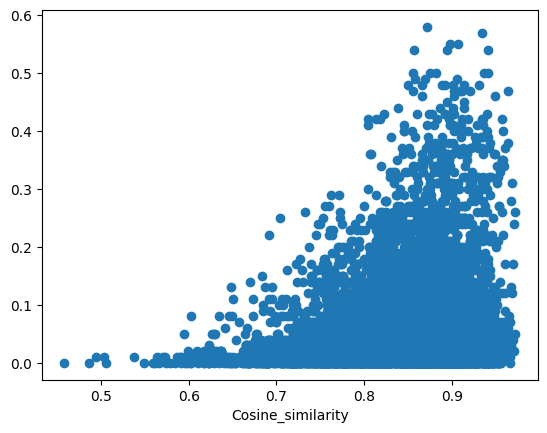

In [335]:
ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')

In [336]:
semantic_change_2methods_all.corr(method="spearman", numeric_only=True)

Cosine_similarity  Frequency_t1  Frequency_t2  \
Cosine_similarity           1.000000     -0.686198     -0.683009   
Frequency_t1               -0.686198      1.000000      0.991454   
Frequency_t2               -0.683009      0.991454      1.000000   
Total_Frequency            -0.686181      0.999479      0.994493   
Neighbour_score             0.072700      0.648919      0.649826   

                   Total_Frequency  Neighbour_score  
Cosine_similarity        -0.686181         0.072700  
Frequency_t1              0.999479         0.648919  
Frequency_t2              0.994493         0.649826  
Total_Frequency           1.000000         0.648981  
Neighbour_score           0.648981         1.000000

There seems to be a positive correlation: the higher the cosine similarity the higher the neighbour similarity.



In [337]:
semantic_change_2methods_all.describe()

Cosine_similarity  Frequency_t1  Frequency_t2  Total_Frequency  \
count       11090.000000  11090.000000  11090.000000     11090.000000   
mean            0.883015    117.369702     51.811362       169.181064   
std             0.067766   1298.091024    577.418766      1874.840315   
min             0.457804      3.000000      1.000000         4.000000   
25%             0.848076      5.000000      2.000000         7.000000   
50%             0.899881      9.000000      4.000000        13.000000   
75%             0.935131     29.000000     12.000000        41.000000   
max             0.983170  67654.000000  28669.000000     96323.000000   

       Neighbour_score  
count      7117.000000  
mean          0.071824  
std           0.084111  
min           0.000000  
25%           0.020000  
50%           0.040000  
75%           0.100000  
max           0.580000

Scores for chosen words:

In [338]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(chosen_words)].describe()

Cosine_similarity  Frequency_t1  Frequency_t2  Total_Frequency  \
count          21.000000     21.000000     21.000000        21.000000   
mean            0.816076    150.000000     65.714286       215.714286   
std             0.083939    238.879468    106.200350       345.077114   
min             0.561393      4.000000      2.000000         6.000000   
25%             0.761286     19.000000      8.000000        27.000000   
50%             0.835121     51.000000     21.000000        72.000000   
75%             0.884551    161.000000     71.000000       232.000000   
max             0.914005    945.000000    420.000000      1365.000000   

       Neighbour_score  
count        20.000000  
mean          0.098500  
std           0.092638  
min           0.000000  
25%           0.025000  
50%           0.065000  
75%           0.160000  
max           0.290000

Scores for not chosen words:

In [339]:
semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(chosen_words)].describe()

Cosine_similarity  Frequency_t1  Frequency_t2  Total_Frequency  \
count       11069.000000  11069.000000  11069.000000     11069.000000   
mean            0.883142    117.307797     51.784985       169.092782   
std             0.067673   1299.281455    577.948343      1876.559669   
min             0.457804      3.000000      1.000000         4.000000   
25%             0.848197      5.000000      2.000000         7.000000   
50%             0.900012      9.000000      4.000000        13.000000   
75%             0.935220     29.000000     12.000000        41.000000   
max             0.983170  67654.000000  28669.000000     96323.000000   

       Neighbour_score  
count      7097.000000  
mean          0.071749  
std           0.084081  
min           0.000000  
25%           0.020000  
50%           0.040000  
75%           0.100000  
max           0.580000

Compare the two means:

In [340]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(chosen_words)].mean(numeric_only=True)[[0,4]]

Cosine_similarity    0.816076
Neighbour_score      0.098500
dtype: float64

I define a list of words that I expect did not change:

In [341]:
not_changed = ['the', 'it', 'for', 'a', 'at', 'in', 'be', 'of', 'on', 'over', 'under']

Then I look at their scores:

In [342]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)]

Word  Cosine_similarity  Frequency_t1  Frequency_t2  Total_Frequency  \
704   under           0.762890           771           332             1103   
1835   over           0.822326          1003           458             1461   
4690     at           0.885767          7221          3220            10441   
5259     on           0.895290         11009          4721            15730   
5698     in           0.902140         22248          9429            31677   
6271      a           0.910000         21412          9097            30509   
6318    for           0.910496         13744          6259            20003   
6563     of           0.913665         38975         17271            56246   
6759     be           0.916179         50286         21568            71854   
7133     it           0.921094         14125          6969            21094   
7756    the           0.928715         53861         25772            79633   

     Category_automatic  Neighbour_score  
704       Function word             0.09  
1835      Function word             0.19  
4690      Function word             0.12  
5259      Function word             0.17  
5698      Function word             0.09  
6271   Other_to_exclude             0.06  
6318      Function word             0.15  
6563      Function word             0.11  
6759   Other_to_exclude              NaN  
7133      Function word             0.18  
7756      Function word              NaN

In [343]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].describe()

Cosine_similarity  Frequency_t1  Frequency_t2  Total_Frequency  \
count          11.000000     11.000000     11.000000        11.000000   
mean            0.888051  21332.272727   9554.181818     30886.454545   
std             0.050418  18600.583502   8461.297050     27043.349402   
min             0.762890    771.000000    332.000000      1103.000000   
25%             0.890528   9115.000000   3970.500000     13085.500000   
50%             0.910000  14125.000000   6969.000000     21094.000000   
75%             0.914922  30611.500000  13350.000000     43961.500000   
max             0.928715  53861.000000  25772.000000     79633.000000   

       Neighbour_score  
count         9.000000  
mean          0.128889  
std           0.045674  
min           0.060000  
25%           0.090000  
50%           0.120000  
75%           0.170000  
max           0.190000

In [344]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(chosen_words)].describe()

Cosine_similarity  Frequency_t1  Frequency_t2  Total_Frequency  \
count          21.000000     21.000000     21.000000        21.000000   
mean            0.816076    150.000000     65.714286       215.714286   
std             0.083939    238.879468    106.200350       345.077114   
min             0.561393      4.000000      2.000000         6.000000   
25%             0.761286     19.000000      8.000000        27.000000   
50%             0.835121     51.000000     21.000000        72.000000   
75%             0.884551    161.000000     71.000000       232.000000   
max             0.914005    945.000000    420.000000      1365.000000   

       Neighbour_score  
count        20.000000  
mean          0.098500  
std           0.092638  
min           0.000000  
25%           0.025000  
50%           0.065000  
75%           0.160000  
max           0.290000

Let's look at species:

In [345]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='species']

Word  Cosine_similarity  Frequency_t1  Frequency_t2  Total_Frequency  \
2239  species           0.833888            58            24               82   

     Category_automatic  Neighbour_score  
2239                                0.06

In [346]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='descent']

Word  Cosine_similarity  Frequency_t1  Frequency_t2  Total_Frequency  \
2920  descent           0.851442            59            25               84   

     Category_automatic  Neighbour_score  
2920                                0.09

I compare the means:

In [347]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean(numeric_only=True)[[0,4]]

Cosine_similarity    0.888051
Neighbour_score      0.128889
dtype: float64

### Systematic comparison of cosine similarity and neighbour similarity by different values of parameters

I'm going to compare two primary methods for detecting semantic change using word2vec embeddings trained on Darwin's letters before and after 1870. The first method involves calculating the cosine similarity between aligned word embeddings. In this approach, we align the two word2vec models from the two time periods and then measure the cosine similarity for each word vector across them. Words that show low cosine similarity between the two time periods are identified as having undergone significant semantic shift.

The second method focuses on changes in the nearest neighbours of a word. This neighbourhood-based approach compares the sets of nearest neighbours for each word in the two models. If a word’s neighbours differ greatly between the two time periods, it suggests that the word’s meaning has shifted. 

These two approaches are commonly used in diachronic semantic change research. Cosine similarity tends to capture more global shifts in a word’s position within the vector space, while neighbourhood-based methods detect local shifts by examining changes in a word’s immediate semantic context.

This is the list of non-scientific words currently analysed in the article:

In [348]:
nonsci_analysed = ['lunch', 'presentation', 'herewith', 'heartfelt', 'presentation', 'inconvenient']

This is the list of scientific words currently analysed in the article:

In [349]:
sci_analysed = ['molecule', 'fundamental', 'spiritual', 'latent', 'wriggle', 'sediment']

I define a function that, given a minimum frequency, a maximum frequency and the number of top neighbours, does the following: filter the vocabularies, apply this to model1 and model2 for filtered words, calculates the neghbour similarity score, define a dataframe with this score, save to a file, combine the dataframe with the cosine similarity score, I plot the terms by two semantic change scores, calculate Spearman correlation between the two scores, compares the means of the two scores for the chosen words (gold standard), the words that did not change, the words that were not in the gold standard, the non-scientific words currently analysed in the article and the scientific words currently analysed in the article.

In [350]:
def compare_two_methods(min_freq, max_freq, top_n):
    # Filter vocabularies based on frequency thresholds
    vocab1_filtered = filter_words(model1, min_freq, max_freq)
    vocab2_filtered = filter_words(model2, min_freq, max_freq)
    
    # Find intersection of filtered vocabularies
    vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))
    
    # Extract top_n neighbours for each word in both models
    word2neighbours1 = extract_neighbours(model1, vocab1_filtered, top_n)
    word2neighbours2 = extract_neighbours(model2, vocab2_filtered, top_n)
    
    # Compute neighbour overlap score (normalized by top_n)
    w2sc = {}
    for w in vocab_filtered:
        overlap_count = len(set(word2neighbours1[w]) & set(word2neighbours2[w]))
        score = overlap_count / top_n
        w2sc[w] = score
    
    # Create dataframe with scores and frequencies
    neighbours_df = pd.DataFrame([
        (w, w2sc[w], model1.wv.get_vecattr(w, "count"), model2.wv.get_vecattr(w, "count"))
        for w in vocab_filtered
    ], columns=['Word', 'Neighbour_score', 'Frequency_t1', 'Frequency_t2'])
    
    # Sort by neighbour score
    neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
    
    # Compute total frequency across both corpora
    neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"] + neighbours_df_sorted["Frequency_t2"]
    
    # Automatically categorize words
    conditions = [
        neighbours_df_sorted['Word'].isin(function_words),
        (neighbours_df_sorted['Word'].str.isdigit()) |
        (neighbours_df_sorted['Word'].str.match(r'^\d*?1st$')) |
        (neighbours_df_sorted['Word'].str.match(r'^\d*?2nd$')) |
        (neighbours_df_sorted['Word'].str.match(r'^\d*?3rd$')) |
        (neighbours_df_sorted['Word'].str.match(r'^\d*[^123]th$')),
        neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:].islower()),
        ~neighbours_df_sorted['Word'].str.lower().isin(english_vocab)
    ]
    
    categories = ['Function word', 'Numeral', 'Proper noun', 'Foreign word']
    
    neighbours_df_sorted['Category_automatic'] = np.select(conditions, categories, default="")
    
    # Export neighbour scores
    neighbours_df_sorted.to_csv(
        os.path.join(output_folder, f'all_words_neighbourscore{min_freq}-{max_freq}-{top_n}.csv'),
        encoding='utf-8'
    )
    
    # Merge cosine similarity scores with neighbour scores
    semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, on='Word', how='inner')
    semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, on='Word', how='outer')
    
    # Export combined scores
    semantic_change_2methods_all.to_csv(
        os.path.join(output_folder, f'all_words_2scores{min_freq}-{max_freq}-{top_n}.csv'),
        encoding='utf-8'
    )
    
    # Plot neighbour score vs cosine similarity
    ax = semantic_change_2methods.plot.scatter(x='Cosine_similarity', y='Neighbour_score', title='Semantic Change Comparison')
    
    # Compute Spearman correlation between two methods
    corr = semantic_change_2methods_all[['Cosine_similarity', 'Neighbour_score']].corr(method="spearman").iloc[0, 1]
    
    # Compute statistics for various word sets
    def compute_stats(word_list, df, label):
        subset = df[df['Word'].isin(word_list)]
        mean_cos = subset['Cosine_similarity'].mean()
        mean_nei = subset['Neighbour_score'].mean()
        median_cos = subset['Cosine_similarity'].median()
        median_nei = subset['Neighbour_score'].median()
        print(f"{label} - Mean Cosine: {mean_cos}, Mean Neighbour: {mean_nei}")
        print(f"{label} - Median Cosine: {median_cos}, Median Neighbour: {median_nei}")
        return mean_cos, mean_nei, median_cos, median_nei
    
    stats_chosen = compute_stats(chosen_words, semantic_change_2methods_all, "Chosen Words")
    stats_other = compute_stats(~semantic_change_2methods_all['Word'].isin(chosen_words), semantic_change_2methods_all, "Other Words")
    stats_unchanged = compute_stats(not_changed, semantic_change_2methods_all, "Unchanged Words")
    stats_nonsci = compute_stats(nonsci_analysed, semantic_change_2methods_all, "Non-Scientific Words")
    stats_sci = compute_stats(sci_analysed, semantic_change_2methods_all, "Scientific Words")
    
    return (
        vocab1_filtered, vocab2_filtered, vocab_filtered, corr,
        *stats_chosen, *stats_other, *stats_unchanged, *stats_nonsci, *stats_sci
    )


I try different parameters:

Max Freq Loop (0):   0%|                                  | 0/3 [00:00<?, ?it/s]

Top N Loop (0-10000):   0%|                               | 0/4 [00:00<?, ?it/s]2025-03-20 10:40:23,040 - INFO - Running compare_two_methods for min_freq=0, max_freq=10000, top_n=10


Top N Loop (0-10000):  25%|█████▊                 | 1/4 [00:51<02:35, 51.93s/it]2025-03-20 10:41:14,977 - INFO - Running compare_two_methods for min_freq=0, max_freq=10000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.06666666666666668
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.16666666666666666
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.02
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.0
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.0
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (0-10000):  50%|███████████▌           | 2/4 [01:41<01:40, 50.46s/it]2025-03-20 10:42:04,401 - INFO - Running compare_two_methods for min_freq=0, max_freq=10000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.07714285714285714
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.04
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11333333333333334
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.096
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.04
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.036666666666666674
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.01




Top N Loop (0-10000):  75%|█████████████████▎     | 3/4 [02:31<00:50, 50.20s/it]2025-03-20 10:42:54,298 - INFO - Running compare_two_methods for min_freq=0, max_freq=10000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.09380952380952381
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.13333333333333333
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.12
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.10800000000000001
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.07
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.051666666666666666
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.045




Top N Loop (0-10000): 100%|███████████████████████| 4/4 [03:52<00:00, 58.22s/it]

Max Freq Loop (0):  33%|████████▎                | 1/3 [03:52<07:45, 232.89s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.23261904761904761
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.257
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.25366666666666665
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.242
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.272
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.274
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.2248333333333333
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.2185




Top N Loop (0-100000):   0%|                              | 0/4 [00:00<?, ?it/s]2025-03-20 10:44:15,932 - INFO - Running compare_two_methods for min_freq=0, max_freq=100000, top_n=10


Top N Loop (0-100000):  25%|█████▌                | 1/4 [00:47<02:22, 47.45s/it]2025-03-20 10:45:03,384 - INFO - Running compare_two_methods for min_freq=0, max_freq=100000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.06666666666666668
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11818181818181821
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.02
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.0
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.0
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (0-100000):  50%|███████████           | 2/4 [01:38<01:38, 49.34s/it]2025-03-20 10:45:54,046 - INFO - Running compare_two_methods for min_freq=0, max_freq=100000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.07714285714285714
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.04
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.09272727272727273
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.096
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.04
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.036666666666666674
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.01




Top N Loop (0-100000):  75%|████████████████▌     | 3/4 [02:32<00:51, 51.48s/it]2025-03-20 10:46:48,063 - INFO - Running compare_two_methods for min_freq=0, max_freq=100000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.09380952380952381
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11454545454545455
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.11
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.10800000000000001
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.07
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.051666666666666666
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.045




Top N Loop (0-100000): 100%|██████████████████████| 4/4 [03:55<00:00, 58.79s/it]

Max Freq Loop (0):  67%|████████████████▋        | 2/3 [07:48<03:54, 234.23s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.23261904761904761
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.257
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.2745454545454546
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.25
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.272
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.274
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.2248333333333333
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.2185




Top N Loop (0-200000):   0%|                              | 0/4 [00:00<?, ?it/s]2025-03-20 10:48:11,097 - INFO - Running compare_two_methods for min_freq=0, max_freq=200000, top_n=10


Top N Loop (0-200000):  25%|█████▌                | 1/4 [00:57<02:52, 57.65s/it]2025-03-20 10:49:08,752 - INFO - Running compare_two_methods for min_freq=0, max_freq=200000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.06666666666666668
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11818181818181821
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.02
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.0
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.0
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (0-200000):  50%|███████████           | 2/4 [01:51<01:50, 55.38s/it]2025-03-20 10:50:02,538 - INFO - Running compare_two_methods for min_freq=0, max_freq=200000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.07714285714285714
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.04
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.09272727272727273
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.096
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.04
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.036666666666666674
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.01




Top N Loop (0-200000):  75%|████████████████▌     | 3/4 [02:50<00:57, 57.01s/it]2025-03-20 10:51:01,487 - INFO - Running compare_two_methods for min_freq=0, max_freq=200000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.09380952380952381
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11454545454545455
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.11
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.10800000000000001
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.07
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.051666666666666666
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.045




Top N Loop (0-200000): 100%|██████████████████████| 4/4 [04:19<00:00, 64.99s/it]

Min Freq Loop:  20%|█████▊                       | 1/5 [12:08<48:32, 728.04s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.23261904761904761
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.257
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.2745454545454546
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.25
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.272
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.274
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.2248333333333333
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.2185



Max Freq Loop (1):   0%|                                  | 0/3 [00:00<?, ?it/s]

Top N Loop (1-10000):   0%|                               | 0/4 [00:00<?, ?it/s]2025-03-20 10:52:31,087 - INFO - Running compare_two_methods for min_freq=1, max_freq=10000, top_n=10


Top N Loop (1-10000):  25%|█████▊                 | 1/4 [00:52<02:38, 52.75s/it]2025-03-20 10:53:23,838 - INFO - Running compare_two_methods for min_freq=1, max_freq=10000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.06666666666666668
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.16666666666666666
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.02
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.0
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.0
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (1-10000):  50%|███████████▌           | 2/4 [01:55<01:57, 58.84s/it]2025-03-20 10:54:26,939 - INFO - Running compare_two_methods for min_freq=1, max_freq=10000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.07714285714285714
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.04
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11333333333333334
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.096
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.04
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.04
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (1-10000):  75%|█████████████████▎     | 3/4 [03:05<01:03, 63.62s/it]2025-03-20 10:55:36,252 - INFO - Running compare_two_methods for min_freq=1, max_freq=10000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.09380952380952381
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.13333333333333333
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.12
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.10800000000000001
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.07
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.06
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.05




Top N Loop (1-10000): 100%|███████████████████████| 4/4 [04:39<00:00, 69.91s/it]

Max Freq Loop (1):  33%|████████▎                | 1/3 [04:39<09:19, 279.65s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.23261904761904761
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.257
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.25366666666666665
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.242
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.272
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.274
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.23659999999999998
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.226




Top N Loop (1-100000):   0%|                              | 0/4 [00:00<?, ?it/s]2025-03-20 10:57:10,749 - INFO - Running compare_two_methods for min_freq=1, max_freq=100000, top_n=10


Top N Loop (1-100000):  25%|█████▌                | 1/4 [00:52<02:36, 52.33s/it]2025-03-20 10:58:03,076 - INFO - Running compare_two_methods for min_freq=1, max_freq=100000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.06666666666666668
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11818181818181821
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.02
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.0
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.0
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (1-100000):  50%|███████████           | 2/4 [01:47<01:47, 53.76s/it]2025-03-20 10:58:57,844 - INFO - Running compare_two_methods for min_freq=1, max_freq=100000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.07714285714285714
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.04
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.09272727272727273
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.096
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.04
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.04
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (1-100000):  75%|████████████████▌     | 3/4 [02:47<00:56, 56.69s/it]2025-03-20 10:59:58,019 - INFO - Running compare_two_methods for min_freq=1, max_freq=100000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.09380952380952381
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11454545454545455
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.11
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.10800000000000001
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.07
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.06
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.05




Top N Loop (1-100000): 100%|██████████████████████| 4/4 [04:22<00:00, 65.54s/it]

Max Freq Loop (1):  67%|████████████████▋        | 2/3 [09:01<04:29, 269.37s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.23261904761904761
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.257
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.2745454545454546
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.25
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.272
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.274
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.23659999999999998
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.226




Top N Loop (1-200000):   0%|                              | 0/4 [00:00<?, ?it/s]2025-03-20 11:01:32,906 - INFO - Running compare_two_methods for min_freq=1, max_freq=200000, top_n=10
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


Top N Loop (1-200000):  25%|█████▌                | 1/4 [00:52<02:36, 52.21s/it]2025-03-20 11:02:25,115 - INFO - Running compare_two_methods for min_freq=1, max_freq=200000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.06666666666666668
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11818181818181821
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.02
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.0
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.0
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (1-200000):  50%|███████████           | 2/4 [02:01<02:04, 62.12s/it]2025-03-20 11:03:34,182 - INFO - Running compare_two_methods for min_freq=1, max_freq=200000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.07714285714285714
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.04
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.09272727272727273
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.096
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.04
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.04
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (1-200000):  75%|████████████████▌     | 3/4 [02:57<00:59, 59.55s/it]2025-03-20 11:04:30,659 - INFO - Running compare_two_methods for min_freq=1, max_freq=200000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.09380952380952381
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11454545454545455
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.11
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.10800000000000001
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.07
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.06
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.05




Top N Loop (1-200000): 100%|██████████████████████| 4/4 [04:22<00:00, 65.64s/it]

Min Freq Loop:  40%|███████████▌                 | 2/5 [25:32<38:38, 772.94s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.23261904761904761
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.257
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.2745454545454546
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.25
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.272
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.274
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.23659999999999998
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.226



Max Freq Loop (5):   0%|                                  | 0/3 [00:00<?, ?it/s]

Top N Loop (5-10000):   0%|                               | 0/4 [00:00<?, ?it/s]2025-03-20 11:05:55,479 - INFO - Running compare_two_methods for min_freq=5, max_freq=10000, top_n=10


Top N Loop (5-10000):  25%|█████▊                 | 1/4 [00:39<01:57, 39.19s/it]2025-03-20 11:06:34,670 - INFO - Running compare_two_methods for min_freq=5, max_freq=10000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.08125
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.16666666666666666
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.025
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.0
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.0
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (5-10000):  50%|███████████▌           | 2/4 [01:10<01:09, 34.81s/it]2025-03-20 11:07:06,408 - INFO - Running compare_two_methods for min_freq=5, max_freq=10000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.09624999999999999
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11333333333333334
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.11
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.1
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.02
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (5-10000):  75%|█████████████████▎     | 3/4 [01:43<00:33, 33.85s/it]2025-03-20 11:07:39,127 - INFO - Running compare_two_methods for min_freq=5, max_freq=10000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.11375
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.095
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.13333333333333333
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.12
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.125
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.12000000000000001
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.056666666666666664
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.05




Top N Loop (5-10000): 100%|███████████████████████| 4/4 [02:34<00:00, 38.55s/it]

Max Freq Loop (5):  33%|████████▎                | 1/3 [02:34<05:08, 154.20s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.258375
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.313
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.25366666666666665
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.242
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.29500000000000004
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.3015
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.24666666666666667
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.226




Top N Loop (5-100000):   0%|                              | 0/4 [00:00<?, ?it/s]2025-03-20 11:08:29,676 - INFO - Running compare_two_methods for min_freq=5, max_freq=100000, top_n=10


Top N Loop (5-100000):  25%|█████▌                | 1/4 [00:31<01:35, 31.76s/it]2025-03-20 11:09:01,436 - INFO - Running compare_two_methods for min_freq=5, max_freq=100000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.08125
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11818181818181821
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.025
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.0
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.0
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (5-100000):  50%|███████████           | 2/4 [01:06<01:06, 33.29s/it]2025-03-20 11:09:35,792 - INFO - Running compare_two_methods for min_freq=5, max_freq=100000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.09624999999999999
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.09272727272727273
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.11
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.1
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.02
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (5-100000):  75%|████████████████▌     | 3/4 [01:38<00:33, 33.05s/it]2025-03-20 11:10:08,557 - INFO - Running compare_two_methods for min_freq=5, max_freq=100000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.11375
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.095
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11454545454545455
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.11
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.125
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.12000000000000001
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.056666666666666664
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.05




Top N Loop (5-100000): 100%|██████████████████████| 4/4 [02:29<00:00, 37.29s/it]

Max Freq Loop (5):  67%|████████████████▋        | 2/3 [05:03<02:31, 151.23s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.258375
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.313
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.2745454545454546
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.25
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.29500000000000004
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.3015
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.24666666666666667
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.226




Top N Loop (5-200000):   0%|                              | 0/4 [00:00<?, ?it/s]2025-03-20 11:10:58,834 - INFO - Running compare_two_methods for min_freq=5, max_freq=200000, top_n=10


Top N Loop (5-200000):  25%|█████▌                | 1/4 [00:33<01:39, 33.27s/it]2025-03-20 11:11:32,105 - INFO - Running compare_two_methods for min_freq=5, max_freq=200000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.08125
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11818181818181821
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.025
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.0
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.0
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (5-200000):  50%|███████████           | 2/4 [01:07<01:08, 34.06s/it]2025-03-20 11:12:06,721 - INFO - Running compare_two_methods for min_freq=5, max_freq=200000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.09624999999999999
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.09272727272727273
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.11
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.1
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.02
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.0




Top N Loop (5-200000):  75%|████████████████▌     | 3/4 [01:41<00:33, 33.81s/it]2025-03-20 11:12:40,239 - INFO - Running compare_two_methods for min_freq=5, max_freq=200000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.11375
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.095
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11454545454545455
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.11
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.125
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.12000000000000001
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.056666666666666664
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.05




Top N Loop (5-200000): 100%|██████████████████████| 4/4 [02:33<00:00, 38.44s/it]

Min Freq Loop:  60%|█████████████████▍           | 3/5 [33:09<20:57, 628.75s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.258375
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.313
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.2745454545454546
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.25
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.29500000000000004
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.3015
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: 0.24666666666666667
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: 0.226



Max Freq Loop (10):   0%|                                 | 0/3 [00:00<?, ?it/s]

Top N Loop (10-10000):   0%|                              | 0/4 [00:00<?, ?it/s]2025-03-20 11:13:32,613 - INFO - Running compare_two_methods for min_freq=10, max_freq=10000, top_n=10
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-10000):  25%|█████▌                | 1/4 [00:21<01:05, 21.97s/it]2025-03-20 11:13:54,590 - INFO - Running compare_two_methods for min_freq=10, max_freq=10000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.08666666666666667
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.16666666666666666
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.05
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.05
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-10000):  50%|███████████           | 2/4 [00:46<00:46, 23.39s/it]2025-03-20 11:14:18,986 - INFO - Running compare_two_methods for min_freq=10, max_freq=10000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.10266666666666666
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11333333333333334
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.1
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.1
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-10000):  75%|████████████████▌     | 3/4 [01:10<00:23, 23.80s/it]2025-03-20 11:14:43,256 - INFO - Running compare_two_methods for min_freq=10, max_freq=10000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.12133333333333333
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.11
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.13333333333333333
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.12
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.14
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.14
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-10000): 100%|██████████████████████| 4/4 [01:47<00:00, 26.99s/it]

Max Freq Loop (10):  33%|████████                | 1/3 [01:47<03:35, 107.95s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.2735333333333333
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.32
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.25366666666666665
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.242
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.3015
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.3015
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan




Top N Loop (10-100000):   0%|                             | 0/4 [00:00<?, ?it/s]2025-03-20 11:15:20,567 - INFO - Running compare_two_methods for min_freq=10, max_freq=100000, top_n=10
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-100000):  25%|█████▎               | 1/4 [00:32<01:37, 32.60s/it]2025-03-20 11:15:53,166 - INFO - Running compare_two_methods for min_freq=10, max_freq=100000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.08666666666666667
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11818181818181821
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.05
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.05
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-100000):  50%|██████████▌          | 2/4 [01:03<01:03, 31.57s/it]2025-03-20 11:16:24,020 - INFO - Running compare_two_methods for min_freq=10, max_freq=100000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.10266666666666666
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.09272727272727273
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.1
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.1
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-100000):  75%|███████████████▊     | 3/4 [01:28<00:28, 28.54s/it]2025-03-20 11:16:48,952 - INFO - Running compare_two_methods for min_freq=10, max_freq=100000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.12133333333333333
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.11
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11454545454545455
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.11
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.14
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.14
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-100000): 100%|█████████████████████| 4/4 [02:04<00:00, 31.24s/it]

Max Freq Loop (10):  67%|████████████████        | 2/3 [03:52<01:57, 117.95s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.2735333333333333
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.32
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.2745454545454546
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.25
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.3015
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.3015
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan




Top N Loop (10-200000):   0%|                             | 0/4 [00:00<?, ?it/s]2025-03-20 11:17:25,523 - INFO - Running compare_two_methods for min_freq=10, max_freq=200000, top_n=10
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-200000):  25%|█████▎               | 1/4 [00:22<01:08, 22.78s/it]2025-03-20 11:17:48,305 - INFO - Running compare_two_methods for min_freq=10, max_freq=200000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.08666666666666667
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.0
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11818181818181821
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.05
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.05
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-200000):  50%|██████████▌          | 2/4 [00:46<00:46, 23.48s/it]2025-03-20 11:18:12,282 - INFO - Running compare_two_methods for min_freq=10, max_freq=200000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.10266666666666666
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.06
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.09272727272727273
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.1
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.1
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-200000):  75%|███████████████▊     | 3/4 [01:10<00:23, 23.43s/it]2025-03-20 11:18:35,653 - INFO - Running compare_two_methods for min_freq=10, max_freq=200000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.12133333333333333
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.11
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11454545454545455
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.11
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.14
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.14
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (10-200000): 100%|█████████████████████| 4/4 [01:46<00:00, 26.55s/it]

Min Freq Loop:  80%|███████████████████████▏     | 4/5 [38:48<08:34, 514.41s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.2735333333333333
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.32
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.2745454545454546
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.25
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: 0.3015
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: 0.3015
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan



Max Freq Loop (50):   0%|                                 | 0/3 [00:00<?, ?it/s]

Top N Loop (50-10000):   0%|                              | 0/4 [00:00<?, ?it/s]2025-03-20 11:19:11,737 - INFO - Running compare_two_methods for min_freq=50, max_freq=10000, top_n=10
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-10000):  25%|█████▌                | 1/4 [00:09<00:27,  9.12s/it]2025-03-20 11:19:20,862 - INFO - Running compare_two_methods for min_freq=50, max_freq=10000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.18571428571428572
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.2
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.16666666666666666
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-10000):  50%|███████████           | 2/4 [00:20<00:20, 10.18s/it]2025-03-20 11:19:31,785 - INFO - Running compare_two_methods for min_freq=50, max_freq=10000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.17714285714285713
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.18
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11333333333333334
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-10000):  75%|████████████████▌     | 3/4 [00:29<00:09,  9.75s/it]2025-03-20 11:19:41,022 - INFO - Running compare_two_methods for min_freq=50, max_freq=10000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.1957142857142857
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.16
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.13333333333333333
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.12
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-10000): 100%|██████████████████████| 4/4 [00:42<00:00, 10.58s/it]

Max Freq Loop (50):  33%|████████▎                | 1/3 [00:42<01:24, 42.32s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.3554285714285714
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.355
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.25366666666666665
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.242
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan




Top N Loop (50-100000):   0%|                             | 0/4 [00:00<?, ?it/s]2025-03-20 11:19:54,055 - INFO - Running compare_two_methods for min_freq=50, max_freq=100000, top_n=10
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-100000):  25%|█████▎               | 1/4 [00:08<00:24,  8.16s/it]2025-03-20 11:20:02,216 - INFO - Running compare_two_methods for min_freq=50, max_freq=100000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.18571428571428572
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.2
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11818181818181821
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-100000):  50%|██████████▌          | 2/4 [00:18<00:18,  9.22s/it]2025-03-20 11:20:12,185 - INFO - Running compare_two_methods for min_freq=50, max_freq=100000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.17714285714285713
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.18
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.09272727272727273
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-100000):  75%|███████████████▊     | 3/4 [00:27<00:09,  9.29s/it]2025-03-20 11:20:21,559 - INFO - Running compare_two_methods for min_freq=50, max_freq=100000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.1957142857142857
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.16
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11454545454545455
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.11
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-100000): 100%|█████████████████████| 4/4 [00:41<00:00, 10.27s/it]

Max Freq Loop (50):  67%|████████████████▋        | 2/3 [01:23<00:41, 41.60s/it]

Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.3554285714285714
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.355
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.2745454545454546
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.25
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan




Top N Loop (50-200000):   0%|                             | 0/4 [00:00<?, ?it/s]2025-03-20 11:20:35,159 - INFO - Running compare_two_methods for min_freq=50, max_freq=200000, top_n=10
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-200000):  25%|█████▎               | 1/4 [00:08<00:26,  8.78s/it]2025-03-20 11:20:43,936 - INFO - Running compare_two_methods for min_freq=50, max_freq=200000, top_n=50


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.18571428571428572
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.2
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11818181818181821
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-200000):  50%|██████████▌          | 2/4 [00:19<00:19,  9.78s/it]2025-03-20 11:20:54,422 - INFO - Running compare_two_methods for min_freq=50, max_freq=200000, top_n=100


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.17714285714285713
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.18
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.09272727272727273
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.1
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-200000):  75%|███████████████▊     | 3/4 [00:28<00:09,  9.41s/it]2025-03-20 11:21:03,387 - INFO - Running compare_two_methods for min_freq=50, max_freq=200000, top_n=1000


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.1957142857142857
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.16
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.11454545454545455
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.11
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/darwin-env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Top N Loop (50-200000): 100%|█████████████████████| 4/4 [00:41<00:00, 10.40s/it]

Min Freq Loop: 100%|█████████████████████████████| 5/5 [40:53<00:00, 490.75s/it]
2025-03-20 11:21:16,773 - INFO - Finished writing summary CSV to: /Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2025/Darwin/Semantic_change_output/summary_results.csv
2025-03-20 11:21:16,774 - INFO - Generating scatterplot of Cosine Similarity vs Neighbour Score...


Chosen Words - Mean Cosine: 0.8160761850220817, Mean Neighbour: 0.3554285714285714
Chosen Words - Median Cosine: 0.8351207971572876, Median Neighbour: 0.355
Other Words - Mean Cosine: nan, Mean Neighbour: nan
Other Words - Median Cosine: nan, Median Neighbour: nan
Unchanged Words - Mean Cosine: 0.888051303950223, Mean Neighbour: 0.2745454545454546
Unchanged Words - Median Cosine: 0.9100002646446228, Median Neighbour: 0.25
Non-Scientific Words - Mean Cosine: 0.9377071499824524, Mean Neighbour: nan
Non-Scientific Words - Median Cosine: 0.9351434111595154, Median Neighbour: nan
Scientific Words - Mean Cosine: 0.9210601548353831, Mean Neighbour: nan
Scientific Words - Median Cosine: 0.9267076849937439, Median Neighbour: nan


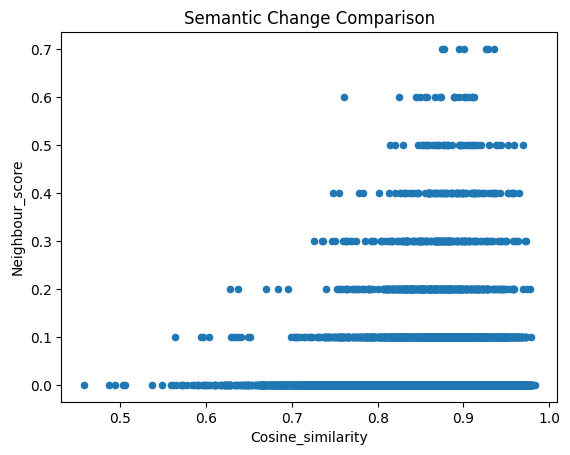

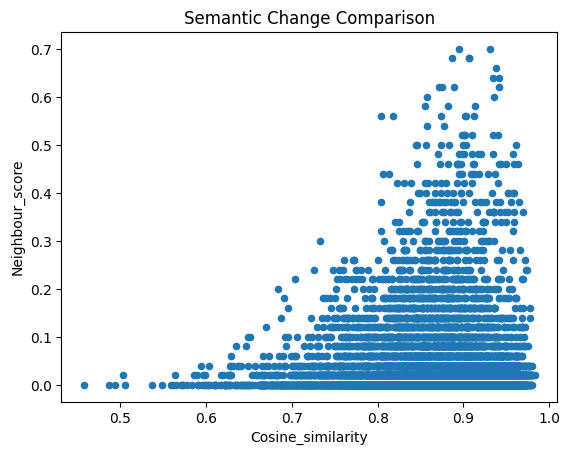

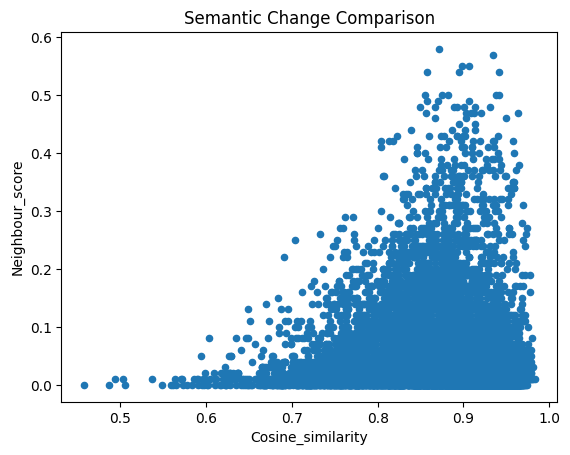

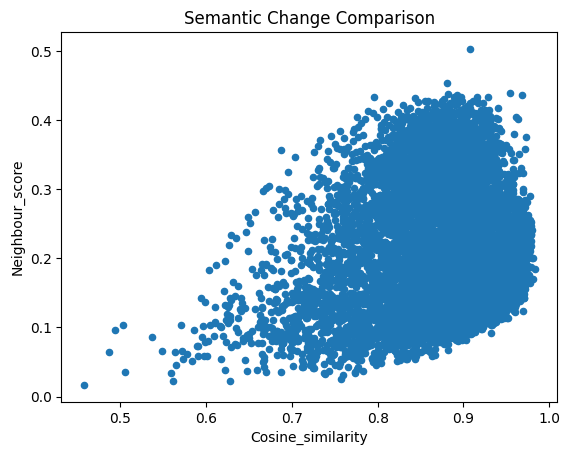

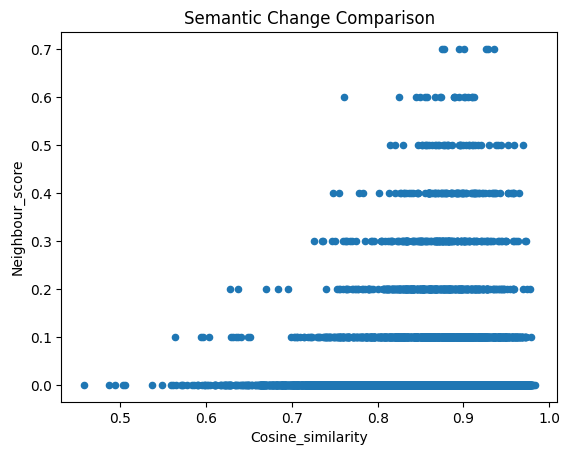

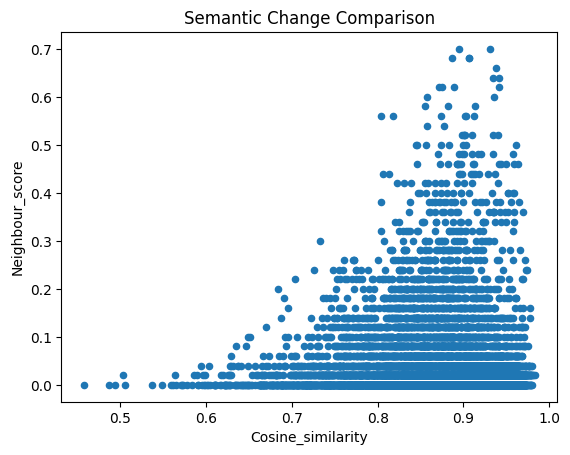

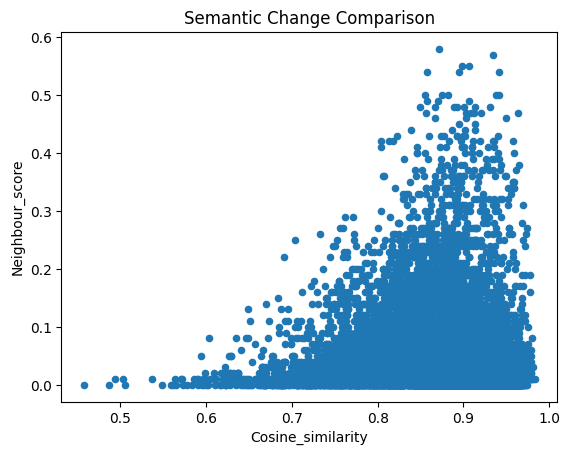

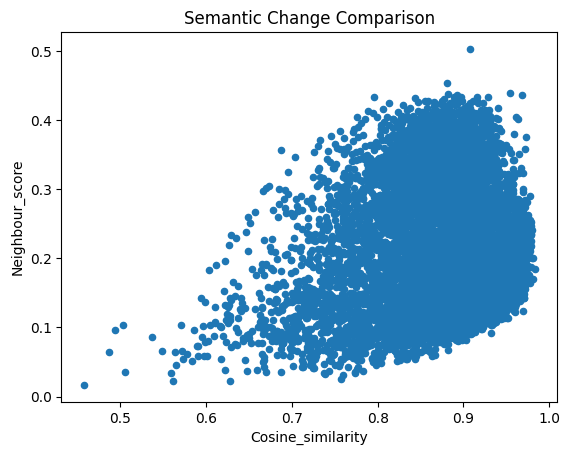

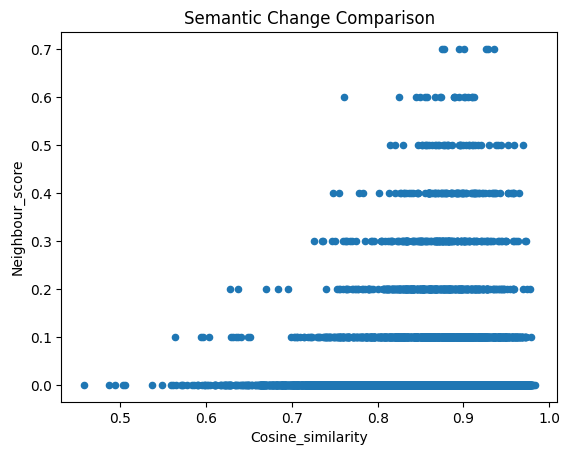

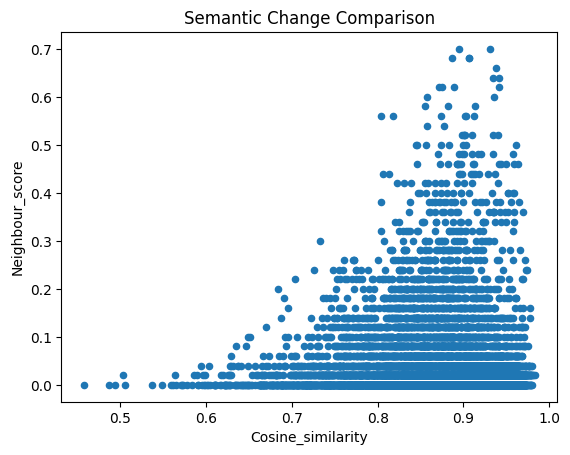

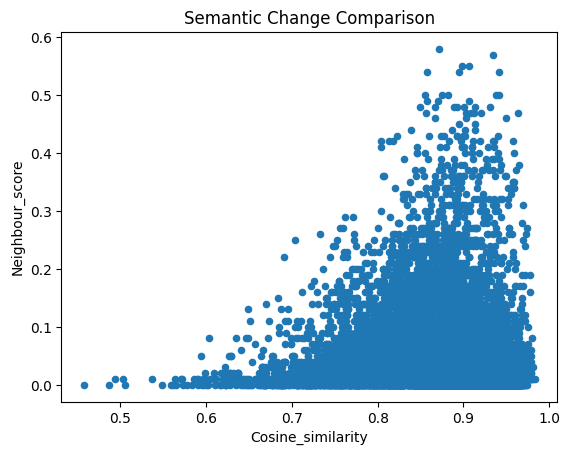

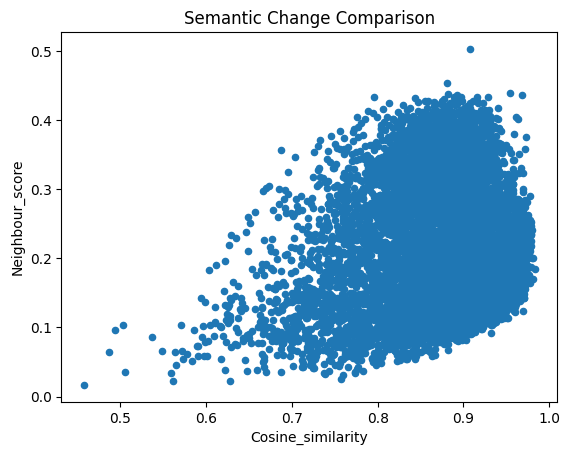

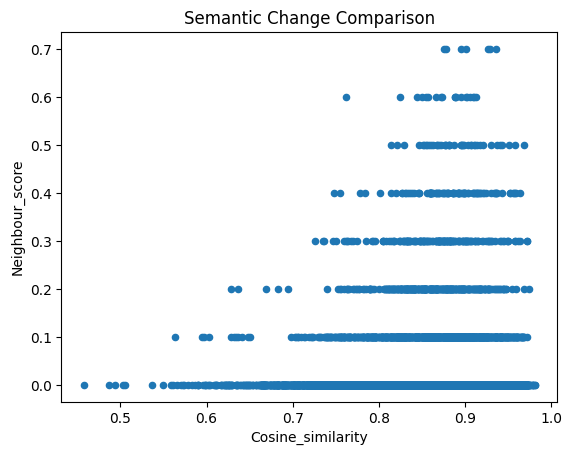

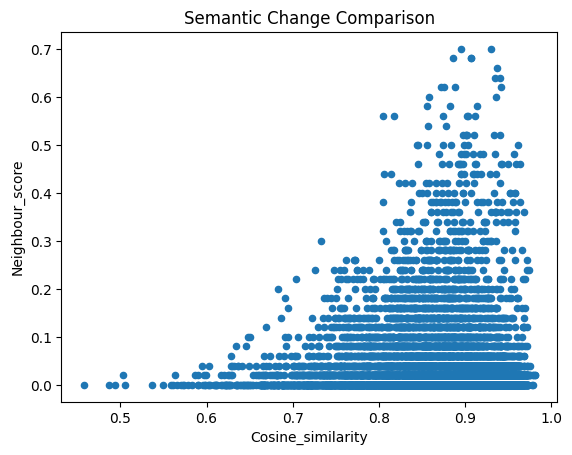

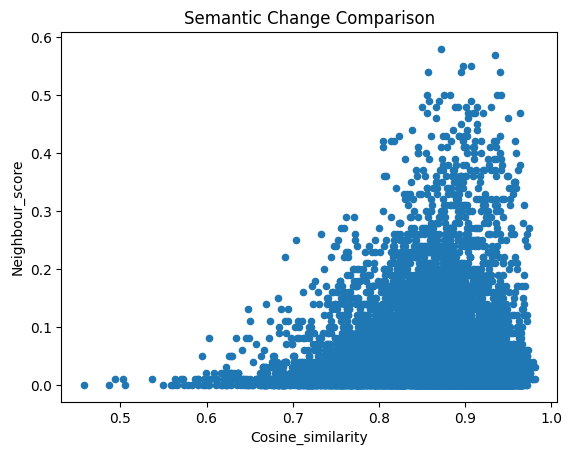

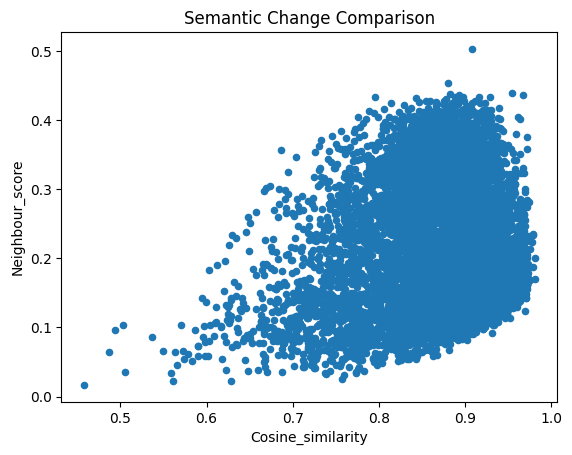

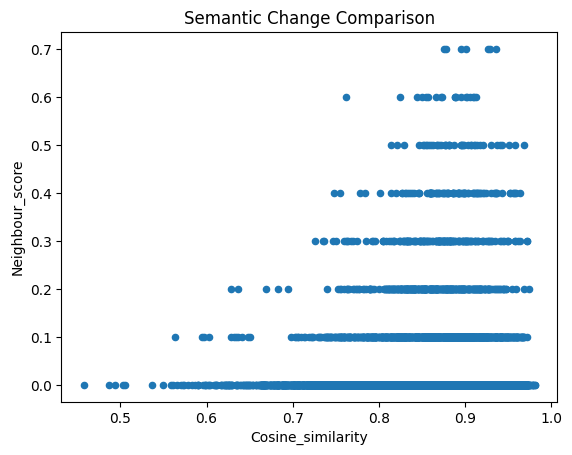

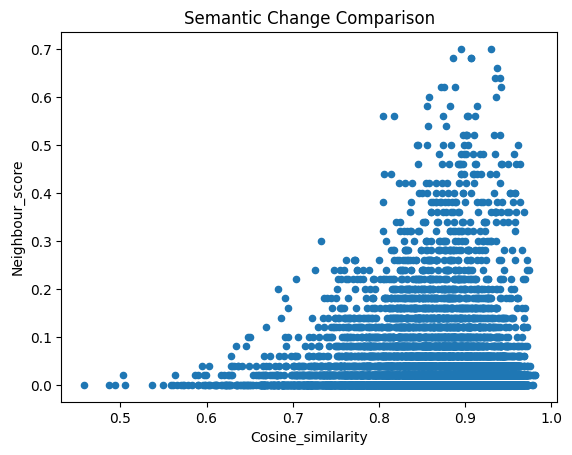

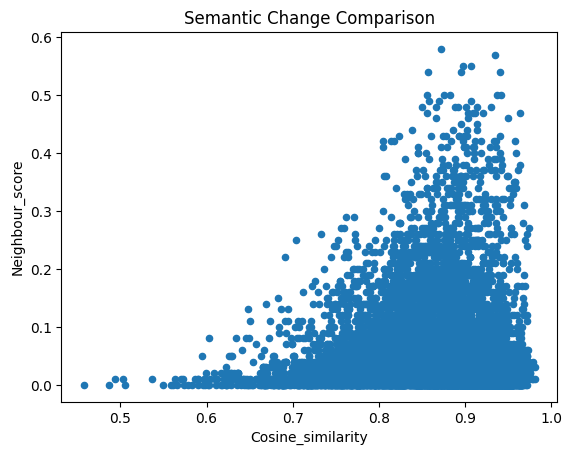

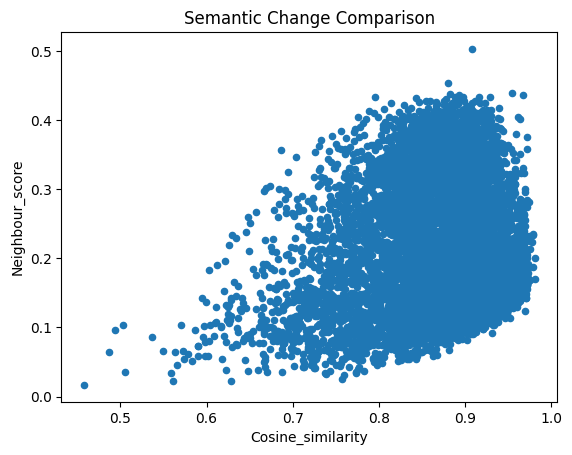

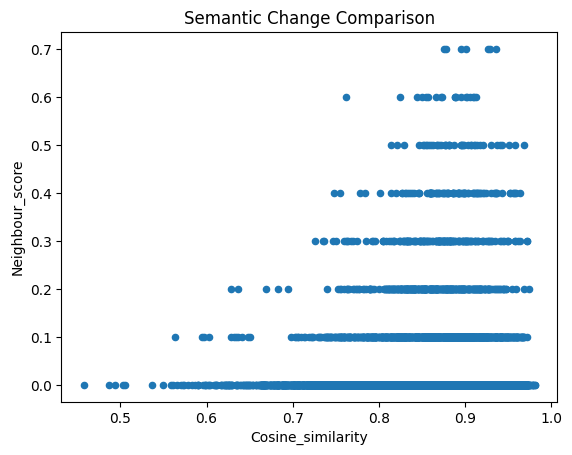

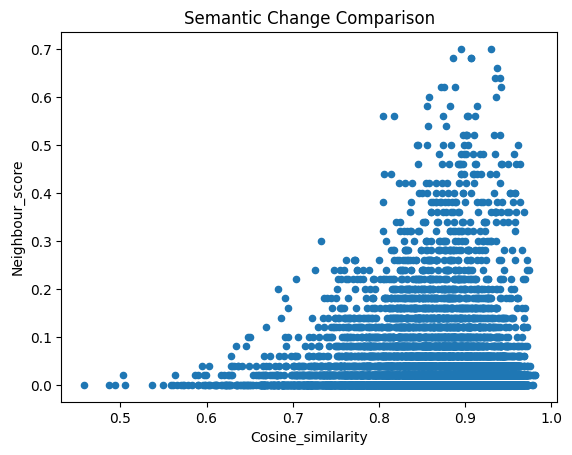

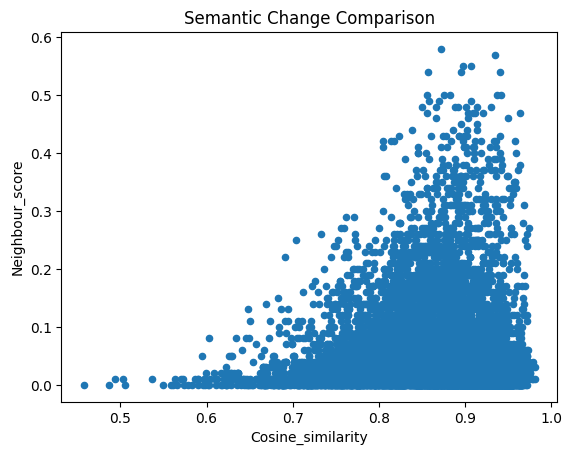

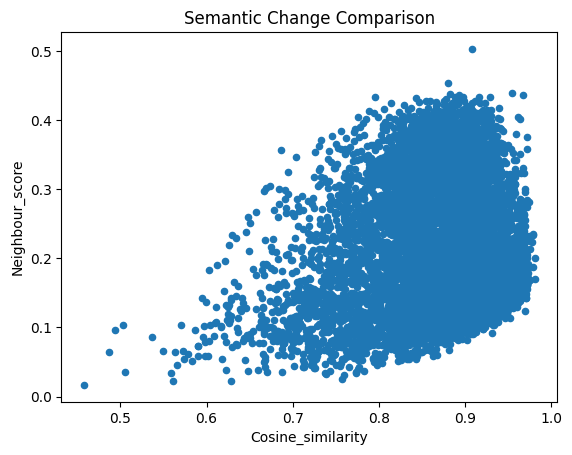

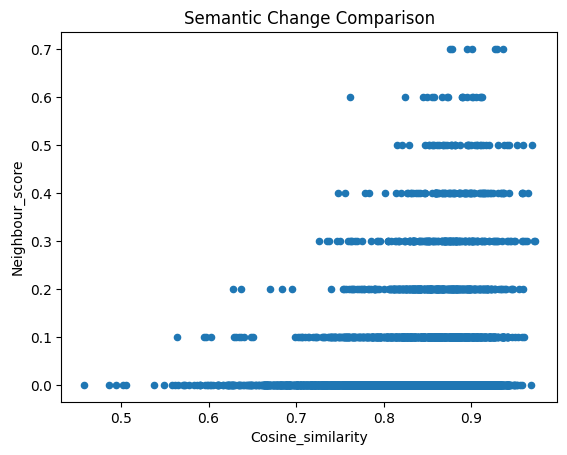

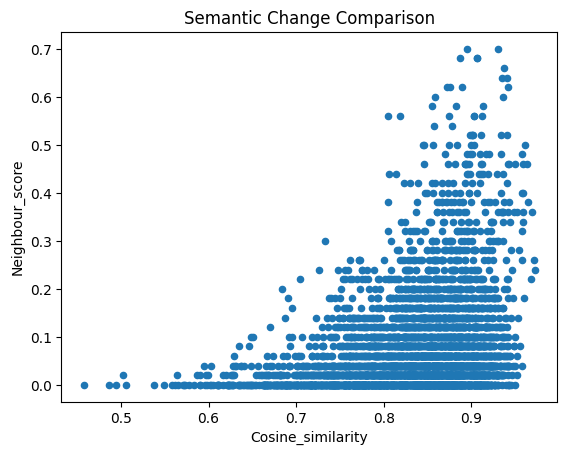

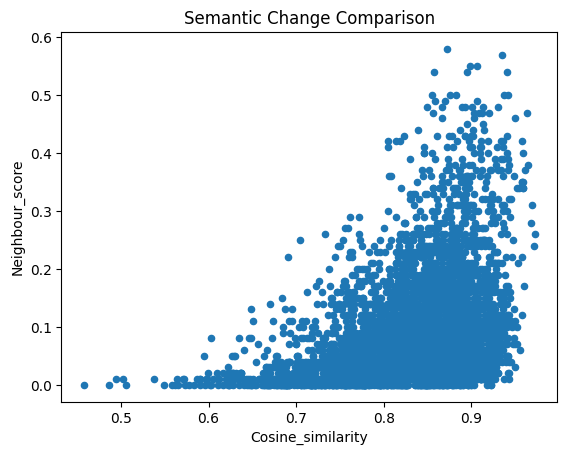

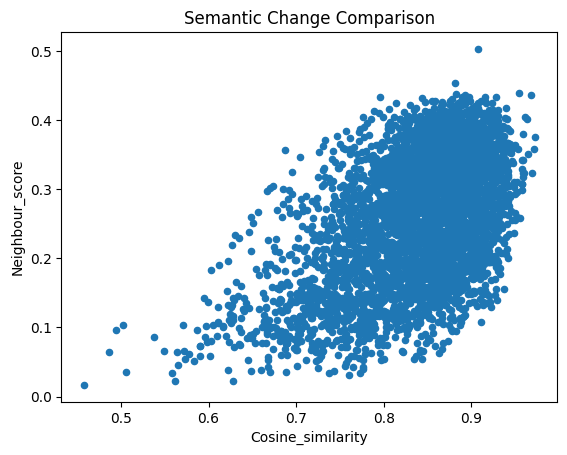

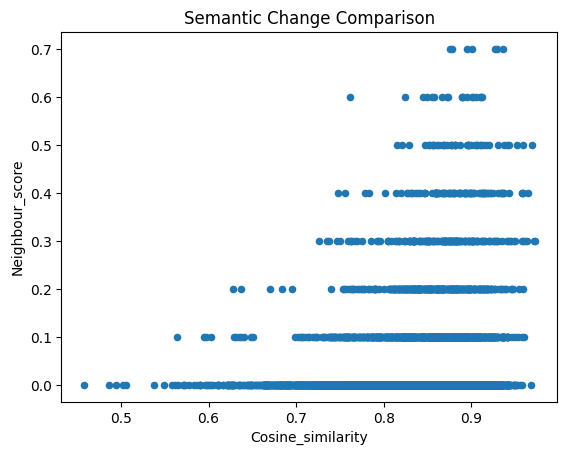

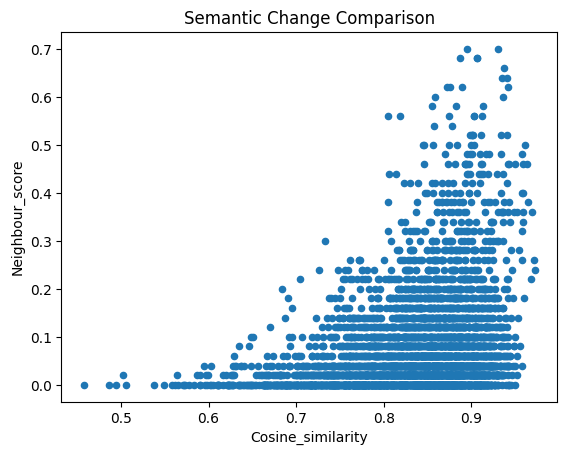

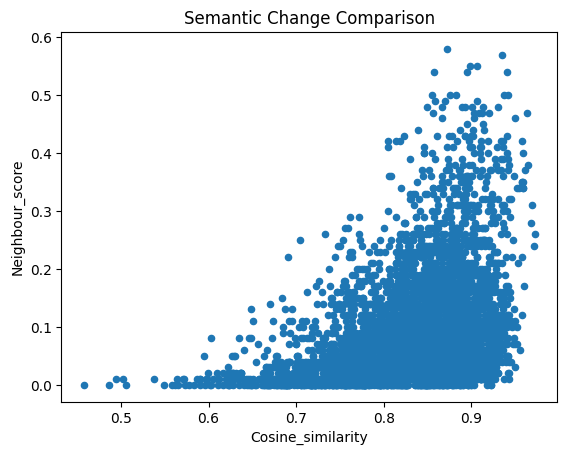

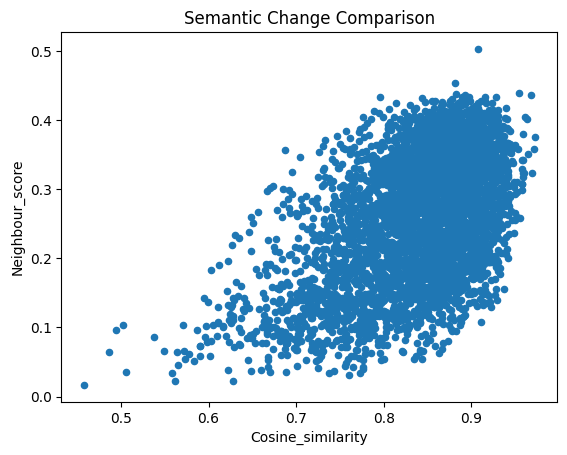

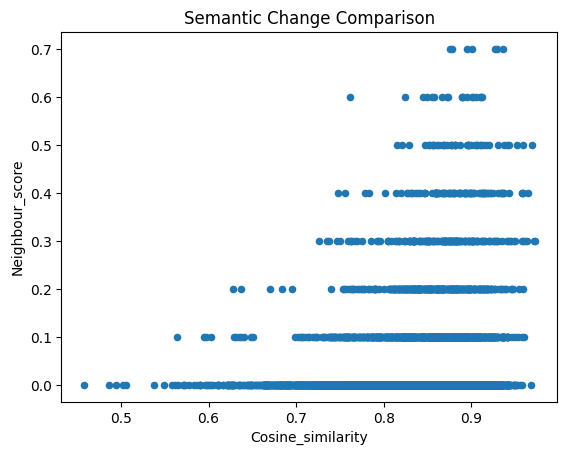

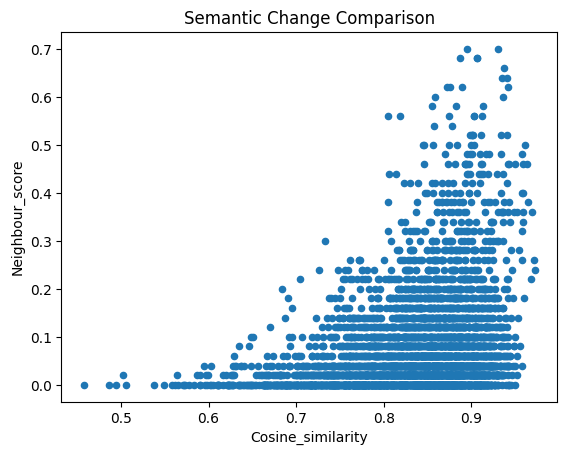

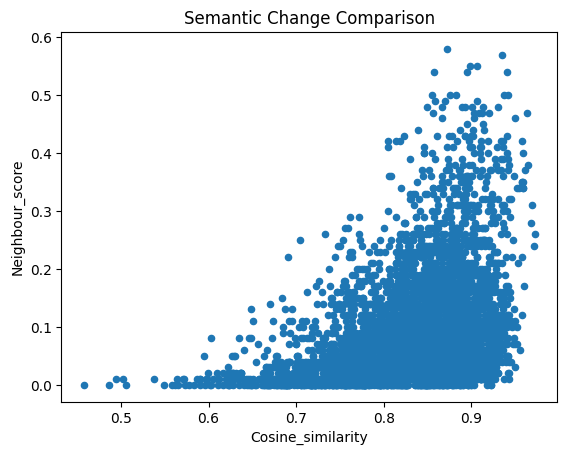

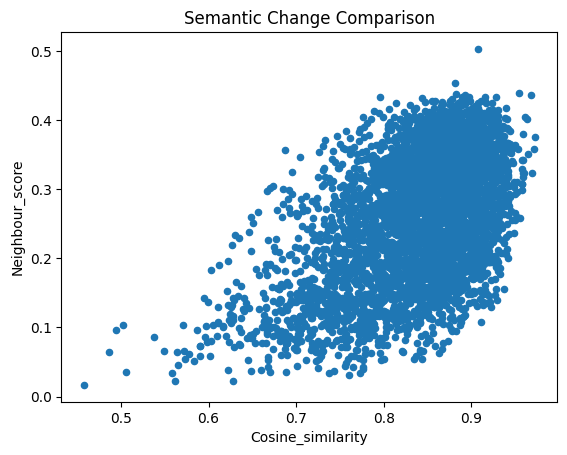

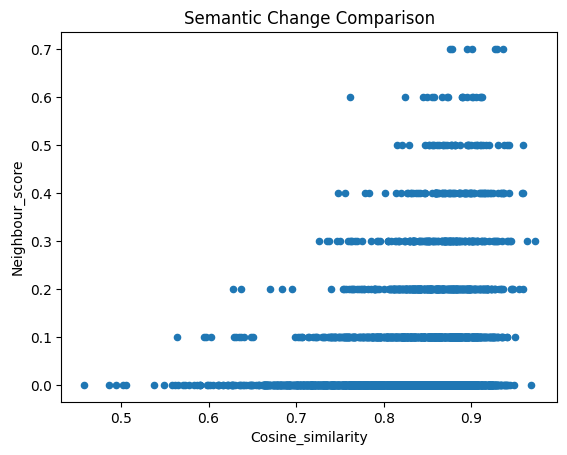

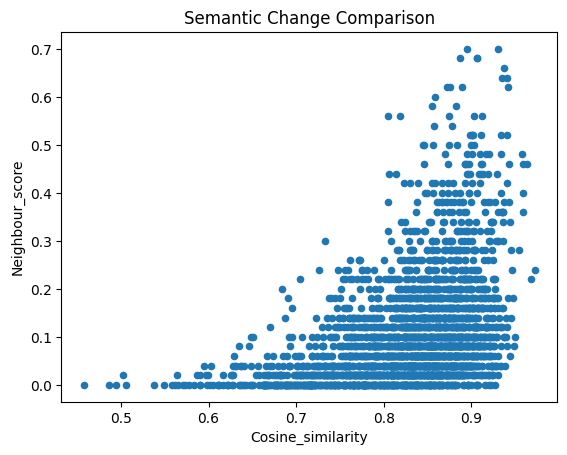

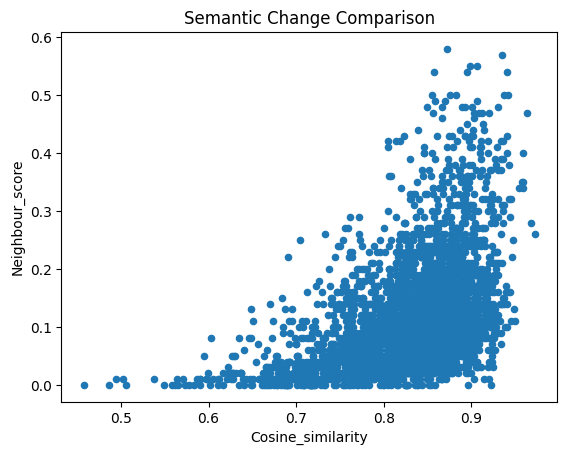

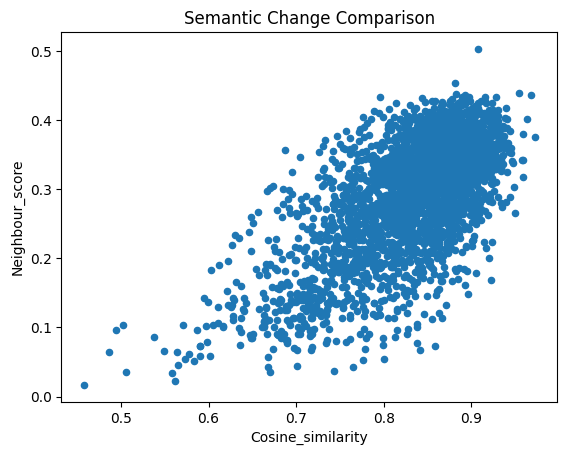

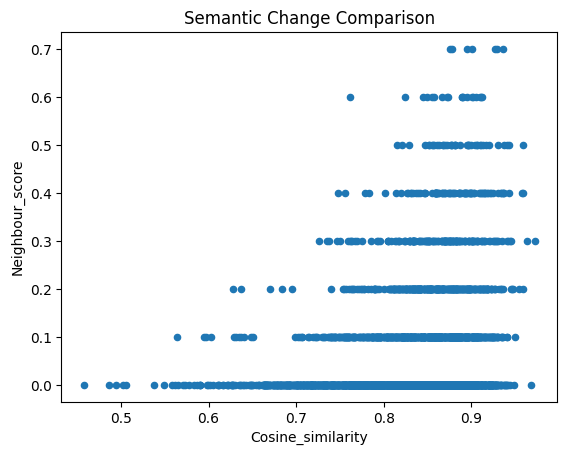

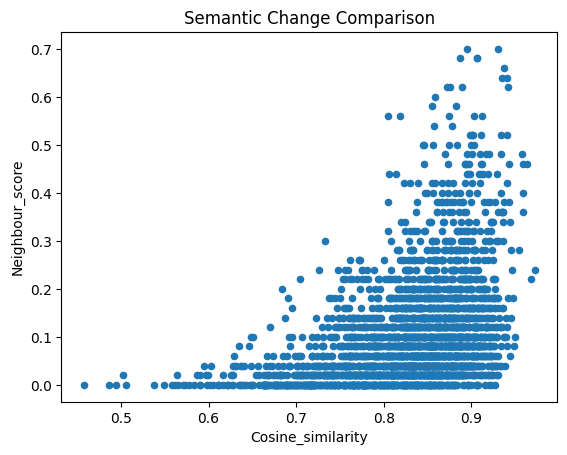

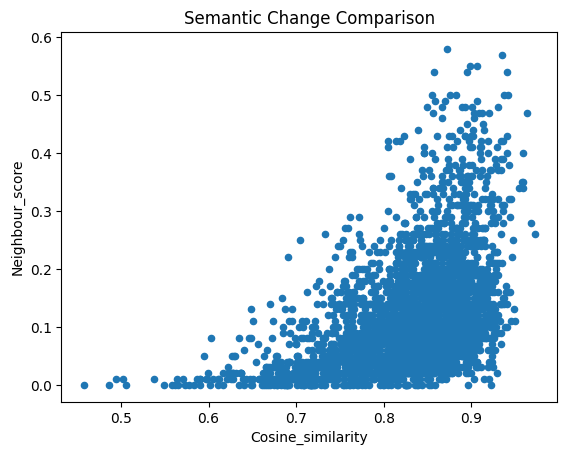

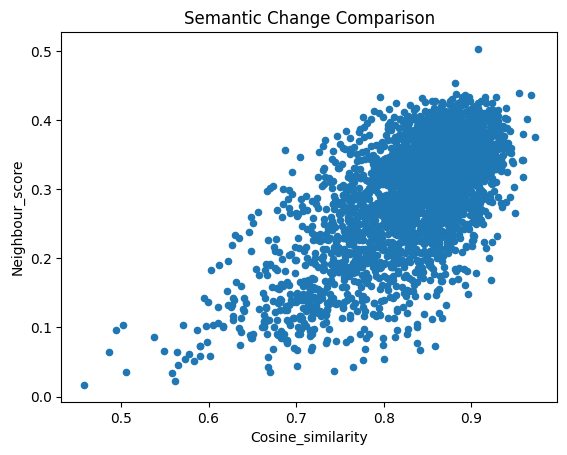

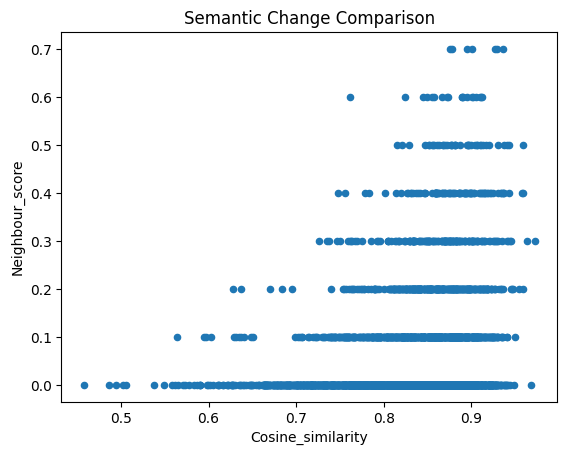

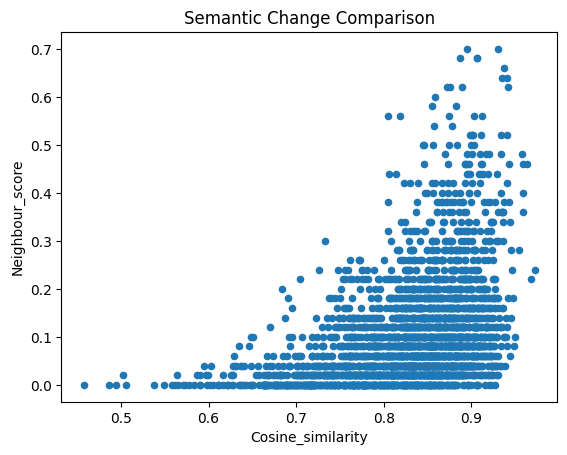

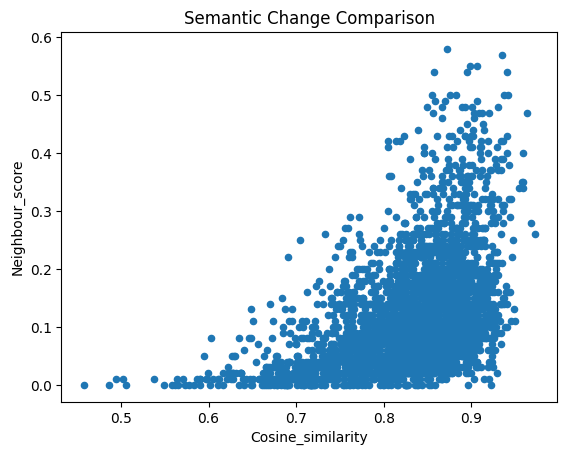

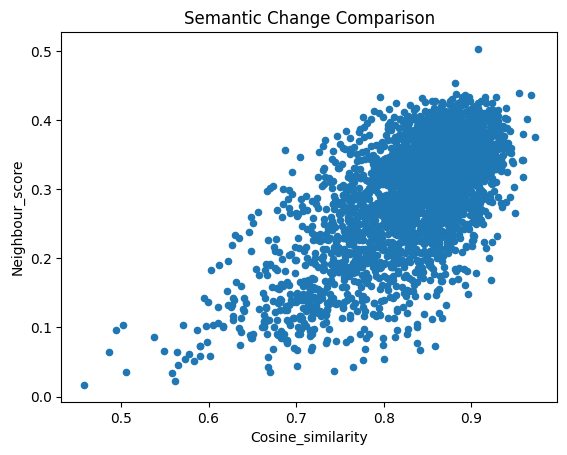

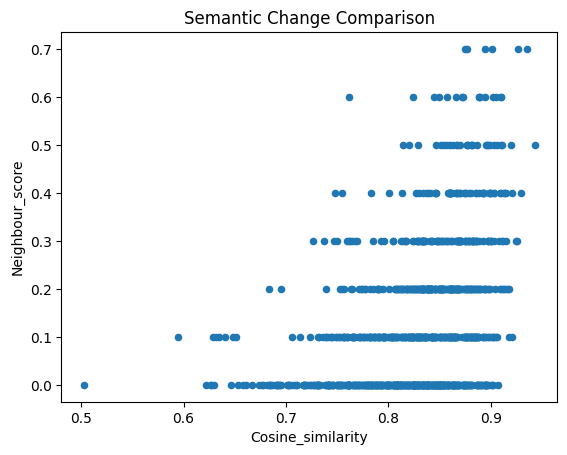

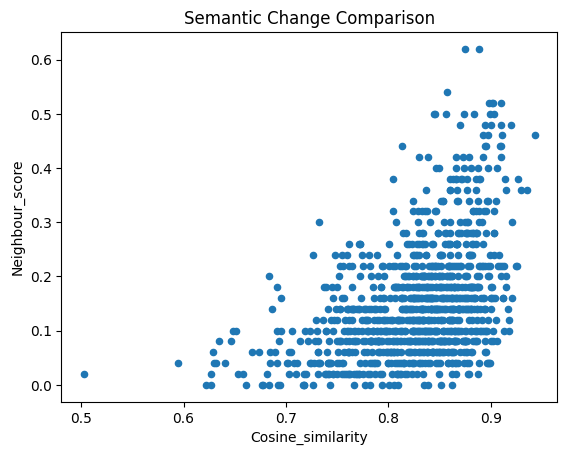

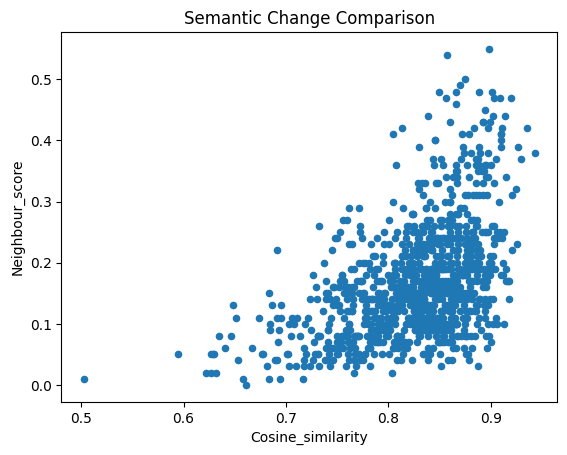

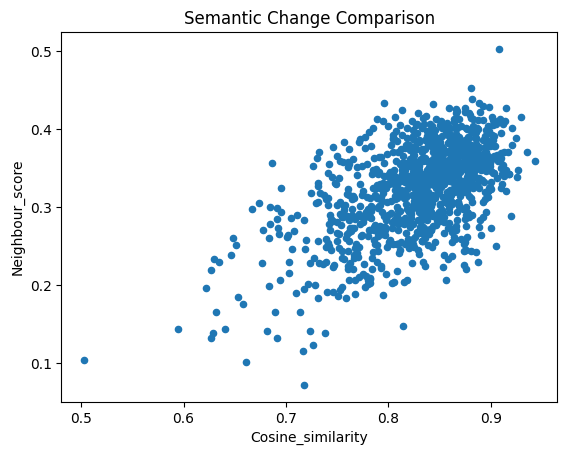

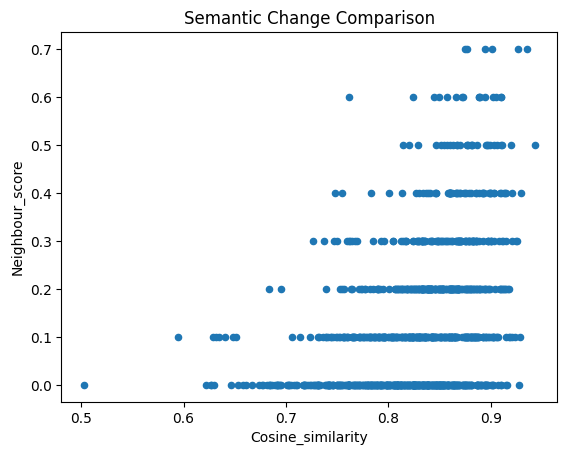

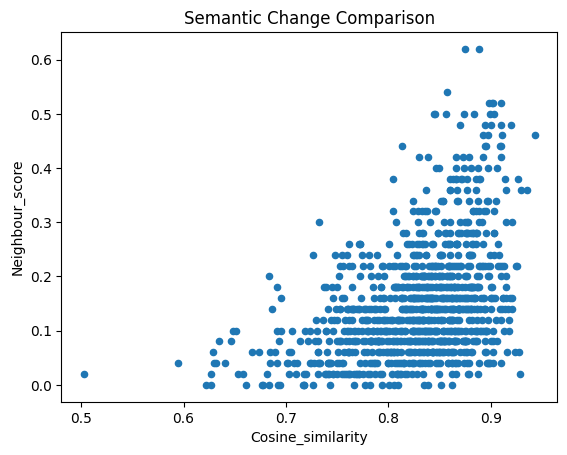

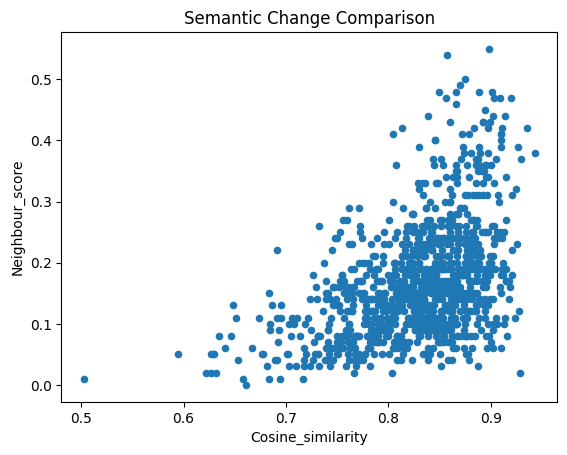

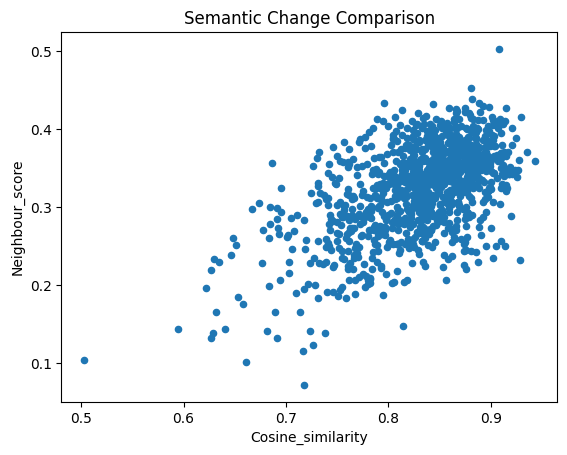

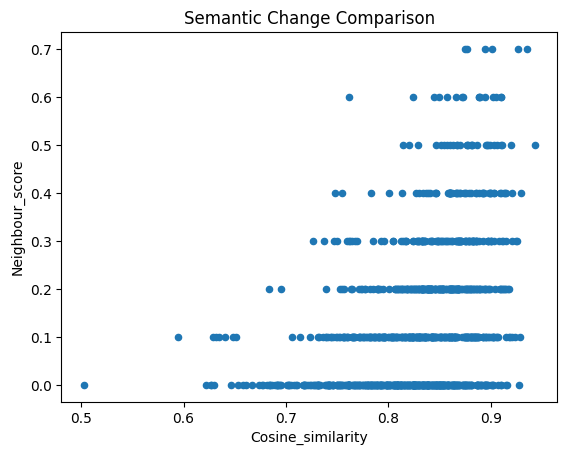

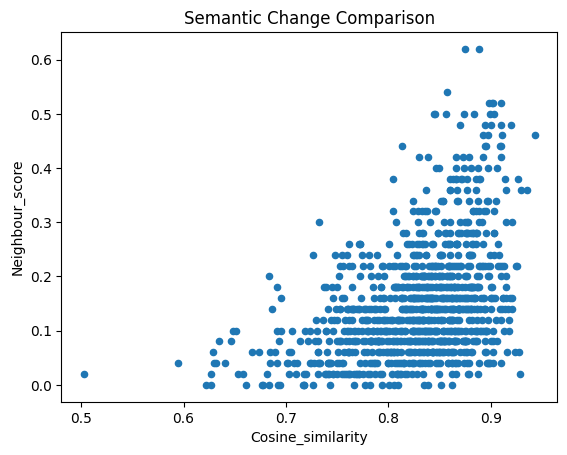

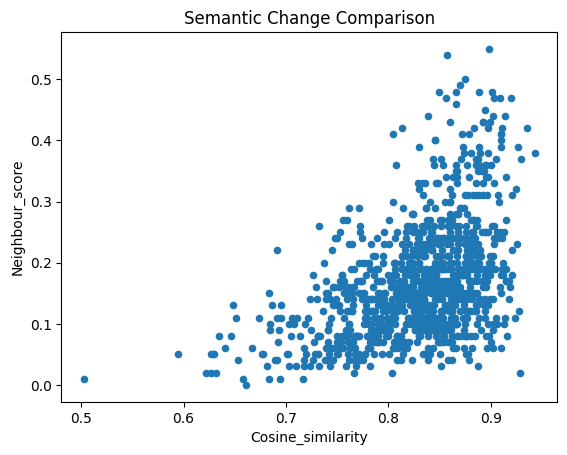

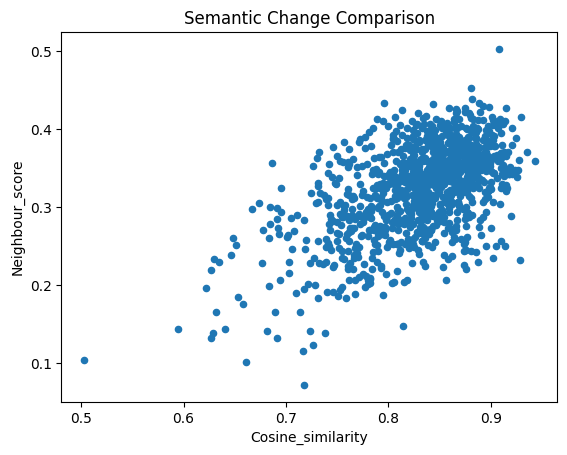

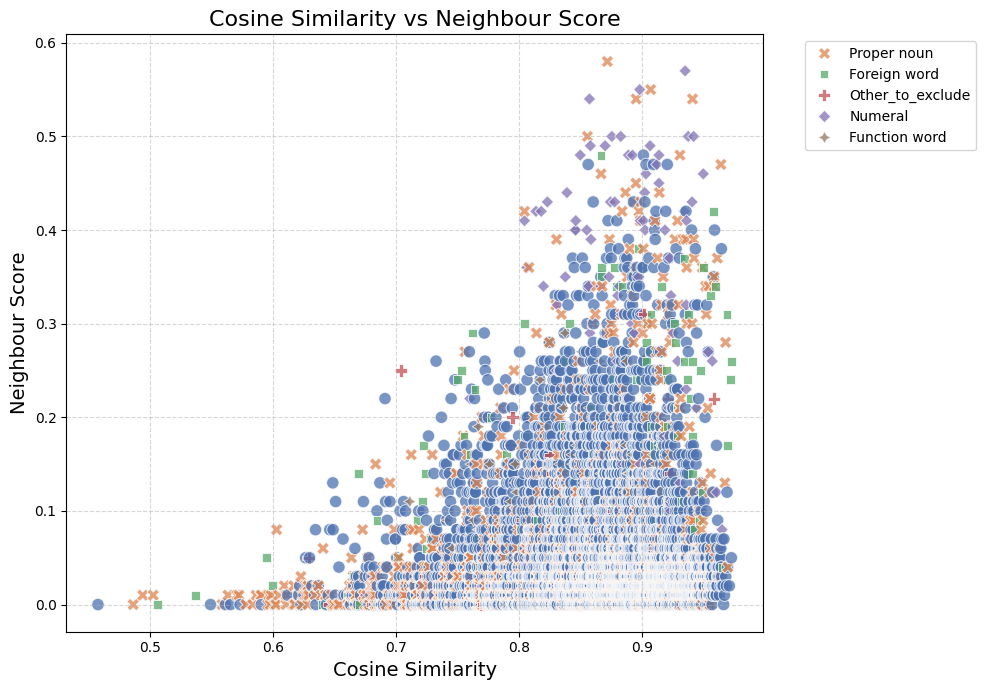

2025-03-20 11:21:21,406 - INFO - Scatterplot saved to: /Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King'sCollegeLondon/Research/2025/Darwin/Semantic_change_output/scatterplot_cosine_vs_neighbour.png


In [351]:
import csv
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import logging
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Summary CSV
summary_path = os.path.join(output_folder, 'summary_results.csv')

with open(summary_path, 'w+', newline='') as summary:
    writer = csv.writer(summary, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)

    writer.writerow([
        'min_freq', 'max_freq', 'top_n', 'vocab1_filtered', 'vocab2_filtered',
        'Spearman correlation cosine_sim-neighbour_sim',
        'mean_neighbourscore_chosen_words', 'mean_cosinescore_chosen_words',
        'mean_neighbourscore_other_words', 'mean_cosinescore_other_words',
        'pval_neighbourscore_chosen_vs_other_raw', 'pval_cosinescore_chosen_vs_other_raw',
        'pval_neighbourscore_chosen_vs_other_corrected', 'pval_cosinescore_chosen_vs_other_corrected',
        'median_neighbourscore_chosen_words', 'median_cosinescore_chosen_words',
        'median_neighbourscore_other_words', 'median_cosinescore_other_words'
    ])

    min_freq_values = [0, 1, 5, 10, 50]
    max_freq_values = [10000, 100000, 200000]
    top_n_values = [10, 50, 100, 1000]

    # Lists to store raw p-values
    pvals_nei = []
    pvals_cos = []
    all_results = []

    # Nested loop over parameter ranges
    for min_freq in tqdm(min_freq_values, desc="Min Freq Loop"):
        for max_freq in tqdm(max_freq_values, desc=f"Max Freq Loop ({min_freq})"):
            for top_n in tqdm(top_n_values, desc=f"Top N Loop ({min_freq}-{max_freq})"):

                logging.info(f'Running compare_two_methods for min_freq={min_freq}, max_freq={max_freq}, top_n={top_n}')

                results = compare_two_methods(min_freq, max_freq, top_n)

                # Unpack the returned results from compare_two_methods
                [vocab1_filtered, vocab2_filtered, vocab_filtered, corr,
                 mean_cos_chosen, mean_nei_chosen,
                 mean_cos_other, mean_nei_other,
                 mean_cos_unchanged, mean_nei_unchanged,
                 mean_cos_nonscian, mean_nei_nonscian,
                 mean_cos_scian, mean_nei_scian,
                 median_cos_chosen, median_nei_chosen,
                 median_cos_other, median_nei_other,
                 median_cos_unchanged, median_nei_unchanged,
                 median_cos_nonscian, median_nei_nonscian,
                 median_cos_scian, median_nei_scian] = results

                # Statistical tests: Mann-Whitney U
                try:
                    nei_chosen = semantic_change_2methods_all.loc[
                        semantic_change_2methods_all['Word'].isin(chosen_words), 'Neighbour_score'
                    ]
                    nei_other = semantic_change_2methods_all.loc[
                        ~semantic_change_2methods_all['Word'].isin(chosen_words), 'Neighbour_score'
                    ]

                    cos_chosen = semantic_change_2methods_all.loc[
                        semantic_change_2methods_all['Word'].isin(chosen_words), 'Cosine_similarity'
                    ]
                    cos_other = semantic_change_2methods_all.loc[
                        ~semantic_change_2methods_all['Word'].isin(chosen_words), 'Cosine_similarity'
                    ]

                    # Mann-Whitney U tests
                    stat_nei, pval_nei = mannwhitneyu(nei_chosen, nei_other, alternative='two-sided')
                    stat_cos, pval_cos = mannwhitneyu(cos_chosen, cos_other, alternative='two-sided')

                    pvals_nei.append(pval_nei)
                    pvals_cos.append(pval_cos)

                except Exception as e:
                    logging.error(f"Statistical test failed for min_freq={min_freq}, max_freq={max_freq}, top_n={top_n}: {e}")
                    pval_nei = np.nan
                    pval_cos = np.nan

                # Collect row data
                row = [
                    min_freq, max_freq, top_n, len(vocab1_filtered), len(vocab2_filtered), corr,
                    mean_nei_chosen, mean_cos_chosen,
                    mean_nei_other, mean_cos_other,
                    pval_nei, pval_cos,  # raw p-values
                    "TBD", "TBD",  # corrected p-values (to fill later)
                    median_nei_chosen, median_cos_chosen,
                    median_nei_other, median_cos_other
                ]

                all_results.append(row)

    # MULTIPLE TESTING CORRECTION (Benjamini-Hochberg)
    corrected_nei = multipletests(pvals_nei, method='fdr_bh')[1]
    corrected_cos = multipletests(pvals_cos, method='fdr_bh')[1]

    # Add corrected p-values to results & write CSV
    for idx, row in enumerate(all_results):
        row[12] = corrected_nei[idx]  # corrected neighbour p-value
        row[13] = corrected_cos[idx]  # corrected cosine p-value
        writer.writerow(row)

logging.info(f"Finished writing summary CSV to: {summary_path}")

# ===================
# Visualization (Scatterplot)
# ===================

logging.info("Generating scatterplot of Cosine Similarity vs Neighbour Score...")

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=semantic_change_2methods_all,
    x='Cosine_similarity',
    y='Neighbour_score',
    hue='Category_automatic',
    palette='deep',
    style='Category_automatic',
    alpha=0.75,
    s=80
)

plt.title('Cosine Similarity vs Neighbour Score', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Neighbour Score', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

scatterplot_path = os.path.join(output_folder, 'scatterplot_cosine_vs_neighbour.png')
plt.savefig(scatterplot_path, dpi=300)
plt.show()

logging.info(f"Scatterplot saved to: {scatterplot_path}")
